# **Analysis script for fast growing bamboo shoot datasets**

## **Part0 Import package and load file**

**Tips: Please must explicitly invoke figure style before each drawing code**
1. When the figure needs to use the matplotlib default style:
```python
        mpl.rcParams.update(mpl.rcParamsDefault)
        mpl.rcParams.update({'font.sans-serif':'Times New Roman','axes.unicode_minus':False})
```
2. When the figure needs to use the seborn aesthetics style:
```python
        sns.set(font='Times New Roman',style='ticks')
```

In [1]:
import numpy as np
import pandas as pd
import re,sys,os,csv

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from venn import venn
from matplotlib.ticker import MultipleLocator
# from tqdm import trange

from sklearn.linear_model import LinearRegression
#from sklearn.metrics import r2_score
from scipy import stats
# from statsmodels.stats.multitest import multipletests 

# from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
# from mpl_toolkits.axes_grid1.colorbar import colorbar
# from mpl_toolkits.mplot3d import Axes3D

from matplotlib_venn import venn3
from tqdm import trange

# import pyranges as pr
import pysam

from collections import Counter

from joblib import Parallel, delayed

# from upsetplot import UpSet
from upsetplot import from_contents, plot

import matplotlib.patches as mpatches

from scipy.stats import zscore

from functools import reduce


In [2]:
%matplotlib inline
mpl.rcParams["font.sans-serif"]=["Times New Roman"]
#axes.unicode_minus, Change True to False, the effect is to solve the problem that the minus sign '-' is displayed as a square..
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams["axes.unicode_minus"]=False
# plt.rcParams["figure.dpi"]=100

# sns.set(font='Times New Roman')

### **1.Basic function**

In [3]:
# def adjust_spines(ax, spines):  
#     '''
#     Adjusting the location and appearance of axis spines.
#     Define a method that adjusts the location of the axis spines.
#     https://matplotlib.org/3.1.0/gallery/ticks_and_spines/spine_placement_demo.html
#     '''
#     for loc, spine in ax.spines.items():
#         if loc in spines:
#             spine.set_position(('outward', 10))  # outward by 10 points
#             spine.set_smart_bounds(True)
#         else:
#             spine.set_color('none')  # don't draw spine

#     # turn off ticks where there is no spine
#     if 'left' in spines:
#         ax.yaxis.set_ticks_position('left')
#     else:
#         # no yaxis ticks
#         ax.yaxis.set_ticks([])

#     if 'bottom' in spines:
#         ax.xaxis.set_ticks_position('bottom')
#     else:
#         # no xaxis ticks
#         ax.xaxis.set_ticks([])

def adjust_spines(ax, spines):
    '''
    Adjusting the location and appearance of axis spines.
    Note: If you want to obtain arrow heads at the ends of the axes, also check out the Centered spines with arrows example.
    https://matplotlib.org/stable/gallery/ticks_and_spines/spine_placement_demo.html
    '''
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

In [3]:
def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r,p,lo,hi

In [4]:
def linear_regression(x,y,num1,num2,num3):
    
    matrix = np.matrix([x,y])
    matrix = matrix.transpose()
    model = LinearRegression()
    model = model.fit(matrix[:,0],matrix[:,1])
    coefs = [model.intercept_[0],model.coef_[0][0]]  
 #   print(coefs)
 #   print(model.coef_)
    
    x_line = np.linspace(num1,num2,num3)  
    y_line = coefs[0] + coefs[1]*x_line #+ coefs[:,2]*(x**2)
    y_hat = coefs[0] + coefs[1]*np.array(y)
    r,p,lo,hi = pearsonr_ci(x,y_hat)   
    r2 = r**2  
  
#    print(r)

    return x_line,y_line,r,coefs[1]

In [6]:
def list_to_csv(list_,out_file):
    with open(out_file,'w',newline='') as output_file:
        for string in list_:
            output_file.write(string + '\n')

###  **2.Load file**

In [58]:
#Moso bamboo GFF annotaion
gff_file = '/home/litao/bigdata/phe_shoot/moso_genome/Bamboo.Hic.gff'

#Stringtie nanopore GTF
phe_2b_stringtie_nanopore_gtf_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/04_stringtie/phe_shoot_2B_rep1_stringtie.gtf'
phe_2m_stringtie_nanopore_gtf_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/04_stringtie/phe_shoot_2M_rep1_stringtie.gtf'
phe_4b_stringtie_nanopore_gtf_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/04_stringtie/phe_shoot_4B_rep1_stringtie.gtf'
phe_4m_stringtie_nanopore_gtf_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/04_stringtie/phe_shoot_4M_rep1_stringtie.gtf'
phe_all_stringtie_nanopore_gtf_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/04_stringtie/phe_nanopore_merge.gtf'

#Stringtie pacbio GTF

#Stringtie illumina GTF

#featurecounts nanopore (counts.txt)
phe_2b_featurecounts_gene_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/06_featureCounts/phe_shoot_2B_rep1_counts.txt'
phe_2m_featurecounts_gene_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/06_featureCounts/phe_shoot_2M_rep1_counts.txt'
phe_4b_featurecounts_gene_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/06_featureCounts/phe_shoot_4B_rep1_counts.txt'
phe_4m_featurecounts_gene_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/06_featureCounts/phe_shoot_4M_rep1_counts.txt'

#featurecounts nanopore (.featurecounts)
phe_2b_featurecounts_reads_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/06_featureCounts/phe_shoot_2B_rep1_genome_correct_2308.sorted.bam.featureCounts'
phe_2m_featurecounts_reads_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/06_featureCounts/phe_shoot_2M_rep1_genome_correct_2308.sorted.bam.featureCounts'
phe_4b_featurecounts_reads_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/06_featureCounts/phe_shoot_4B_rep1_genome_correct_2308.sorted.bam.featureCounts'
phe_4m_featurecounts_reads_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/06_featureCounts/phe_shoot_4M_rep1_genome_correct_2308.sorted.bam.featureCounts'

#reads STAT
phe_2b_reads_cov_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/07_readsSTAT/phe_shoot_2B_rep1.data.csv'
phe_2m_reads_cov_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/07_readsSTAT/phe_shoot_2M_rep1.data.csv'
phe_4b_reads_cov_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/07_readsSTAT/phe_shoot_4B_rep1.data.csv'
phe_4m_reads_cov_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/07_readsSTAT/phe_shoot_4M_rep1.data.csv'

#Poly(A) tail info (gene-level)
phe_2b_polya_tail_gene_level_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/09_polya_tail_info/phe_shoot_2B_rep1_polya_info.csv'
phe_2m_polya_tail_gene_level_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/09_polya_tail_info/phe_shoot_2M_rep1_polya_info.csv'
phe_4b_polya_tail_gene_level_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/09_polya_tail_info/phe_shoot_4B_rep1_polya_info.csv'
phe_4m_polya_tail_gene_level_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/09_polya_tail_info/phe_shoot_4M_rep1_polya_info.csv'
phe_all_polya_tail_gene_level_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/09_polya_tail_info/phe_shoot_all_rep1_polya_info.csv'

#Poly(A) tail info (reads-level)
phe_2b_polya_tail_reads_level_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/output/01_nanopolish/polya_tail/phe_shoot_polya_length/phe_shoot_2B_rep1_polya_results.tsv'
phe_2m_polya_tail_reads_level_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/output/01_nanopolish/polya_tail/phe_shoot_polya_length/phe_shoot_2M_rep1_polya_results.tsv'
phe_4b_polya_tail_reads_level_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/output/01_nanopolish/polya_tail/phe_shoot_polya_length/phe_shoot_4B_rep1_polya_results.tsv'
phe_4m_polya_tail_reads_level_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/output/01_nanopolish/polya_tail/phe_shoot_polya_length/phe_shoot_4M_rep1_polya_results.tsv'

#Nanom6a ouput ratio file (gene-level)

#Nanom6a output ratio file (site-level)
phe_2b_nanom6a_ratio_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/11_m6A/phe_2b_m6a_ratio_file.csv'
phe_2m_nanom6a_ratio_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/11_m6A/phe_2m_m6a_ratio_file.csv'
phe_4b_nanom6a_ratio_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/11_m6A/phe_4b_m6a_ratio_file.csv'
phe_4m_nanom6a_ratio_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/11_m6A/phe_4m_m6a_ratio_file.csv'
phe_all_nanom6a_ratio_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/11_m6A/phe_all_m6a_ratio_file.csv'

#moso bamboo internode length file
internode_length_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/00_bamboo_internode_length/moso_internode_length.csv'

#difference polya tail length
diff_polya_2b_vs_2m_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/16_diff_polya/diff_poya_2B_vs_2M.csv'
diff_polya_2b_vs_4b_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/16_diff_polya/diff_poya_2B_vs_4B.csv'
diff_polya_2m_vs_4m_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/16_diff_polya/diff_poya_2M_vs_4M.csv'
diff_polya_4b_vs_4m_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/16_diff_polya/diff_poya_4B_vs_4M.csv'

###  **3.Load annotation**

In [3]:
#load annotation file (gene level)
def load_annotation_file_gene_level(gff):
    gff_list=["seqid","source","type","start","end","score","strand","phase","attributes"]
    anno = pd.read_csv(gff,sep="\t",names=gff_list,
    dtype={'seqid': str,'source': str,'type': str,'start': int,'end': int,'score': str,'strand': str,'phase': str,'attributes': str})
    
    gene_dict = {}
    for row in anno.iterrows():
        if row[1]['type'] == 'mRNA':  #moso bamboo gff annotation have some gene longer than the mRNA, maybe is error.
            gene_name = row[1]['attributes'].split('.')[0][3:]  #TSS and TTS refers to the mRNA start and end.
            scaffold = row[1]['seqid']
            gene_dict[gene_name] = {'cds':[] ,'strand':row[1]['strand'] ,'each_cds_length':[] ,'utr5p':[] ,'utr3p':[] ,'exon':[],
                                        'each_utr5p_length':[],'each_utr3p_length':[],'each_exon_length':[],'scaffold':scaffold}
            if row[1]['strand'] == '+':
                gene_dict[gene_name]['tss'] = row[1]['start']
                gene_dict[gene_name]['tts'] = row[1]['end']
            elif row[1]['strand'] == '-':
                gene_dict[gene_name]['tss'] = row[1]['end']
                gene_dict[gene_name]['tts'] = row[1]['start']
            else:
                raise
        elif row[1]['type'] == 'CDS':
            gene_name = row[1]['attributes'].split('.')[0][3:]
            cds = (row[1]['start'],row[1]['end'])
            cds_length = row[1]['end'] - row[1]['start'] + 1
            gene_dict[gene_name]['cds'].append(cds)
            gene_dict[gene_name]['each_cds_length'].append(cds_length)
        elif row[1]['type'] == 'exon':
            gene_name = row[1]['attributes'].split('.')[0][3:]
            exon = (row[1]['start'],row[1]['end'])
            exon_length = row[1]['end'] - row[1]['start'] + 1
            gene_dict[gene_name]['exon'].append(exon)
            gene_dict[gene_name]['each_exon_length'].append(exon_length)
        elif row[1]['type'] == 'five_prime_UTR':
            gene_name = row[1]['attributes'].split('.')[0][3:]
            utr5p = (row[1]['start'],row[1]['end'])
            utr5p_length = row[1]['end'] - row[1]['start'] + 1
            gene_dict[gene_name]['utr5p'].append(utr5p)
            gene_dict[gene_name]['each_utr5p_length'].append(utr5p_length)
        elif row[1]['type'] == 'three_prime_UTR':
            gene_name = row[1]['attributes'].split('.')[0][3:]
            utr3p = (row[1]['start'],row[1]['end'])
            utr3p_length = row[1]['end'] - row[1]['start'] + 1
            gene_dict[gene_name]['utr3p'].append(utr3p)
            gene_dict[gene_name]['each_utr3p_length'].append(utr3p_length)
        else:
            continue

    for key,value in gene_dict.items():
        gene_dict[key]['total_cds_length'] = sum(gene_dict[key]['each_cds_length'])
        gene_dict[key]['total_utr5p_length'] = sum(gene_dict[key]['each_utr5p_length'])
        gene_dict[key]['total_utr3p_length'] = sum(gene_dict[key]['each_utr3p_length'])
        gene_dict[key]['total_exon_length'] = sum(gene_dict[key]['each_exon_length'])
        gene_dict[key]['cds_num'] = len(gene_dict[key]['each_cds_length'])
        gene_dict[key]['utr5p_num'] = len(gene_dict[key]['each_utr5p_length'])
        gene_dict[key]['utr3p_num'] = len(gene_dict[key]['each_utr3p_length']) 
        gene_dict[key]['exon_num'] = len(gene_dict[key]['each_exon_length']) 
        if gene_dict[key]['strand'] == '+':
            gene_dict[key]['start_codon'] = gene_dict[key]['cds'][0][0]
            gene_dict[key]['end_codon'] = gene_dict[key]['cds'][-1][1]
        elif gene_dict[key]['strand'] == '-':
            gene_dict[key]['start_codon'] = gene_dict[key]['cds'][0][-1]  
            gene_dict[key]['end_codon'] = gene_dict[key]['cds'][-1][0]
    
    gene_df = pd.DataFrame(gene_dict).T
    gene_df = gene_df[['scaffold','start_codon','end_codon','tss','tts','strand','total_cds_length','total_utr5p_length','total_utr3p_length']]
    gene_df = gene_df.astype({'scaffold':str,'start_codon':int,'end_codon':int,'tss':int,'tts':int,'strand':str,'total_cds_length':int,'total_utr5p_length':int,'total_utr3p_length':int})
    gene_df[['total_cds_length','total_utr5p_length','total_utr3p_length']] = gene_df[['total_cds_length','total_utr5p_length','total_utr3p_length']].replace(0,np.nan)


    return gene_df

In [10]:
#load annotation file (cds level)
def get_label(attributes):
    label = attributes.split(';')[0].split('.')[2]
    return label
def get_gene_name(attributes):
    gene_name = attributes.split(';')[0].split('.')[0][3:]
    return gene_name
def get_group_label(label):
    if 'cds' in label:
        return 'cds'
    elif 'utr5p' in label:
        return 'utr5p'
    elif 'utr3p' in label:
        return 'utr3p'
    elif 'exon' in label:
        return 'exon'
    else:
        return label

# def revers_negative_strand_num(gene_name,label,strand,anno_gene_leve):
#     if strand == "+":
#         return label
#     else:
#         if 'cds' in label:
#             num = anno_gene_leve.loc[gene_name,'cds_num'] - int(label[3:]) +1 
#             new_label = 'cds' + str(num)
#         elif 'exon' in label:
#             num = anno_gene_leve.loc[gene_name,'exon_num'] - int(label[4:]) +1 
#             new_label = 'exon' + str(num)
#         elif 'utr5' in label:
#             num = anno_gene_leve.loc[gene_name,'utr5p_num'] - int(label[5:]) +1 
#             new_label = 'utr5p' + str(num)
#         else:
#             num = anno_gene_leve.loc[gene_name,'utr3p_num'] - int(label[5:]) +1 
#             new_label = 'utr3p' + str(num)
#         return new_label
def load_annotation_file_cds_level(gff):
    gff_list=["seqid","source","type","start","end","score","strand","phase","attributes"]
    anno = pd.read_csv(gff,sep="\t",names=gff_list,
    dtype={'seqid': str,'source': str,'type': str,'start': int,'end': int,'score': str,'strand': str,'phase': str,'attributes': str},
    usecols=['type','start','end','strand','attributes'])
    anno.drop(anno[(anno.type == 'gene') | (anno.type == 'mRNA')].index,inplace=True)
    anno.loc[:,'label'] = anno.attributes.apply(get_label)
    anno.loc[:,'gene_name'] = anno.attributes.apply(get_gene_name)
    anno.loc[:,'label_group'] = anno.label.apply(get_group_label)
    anno.loc[:,'length'] = anno.end - anno.start + 1
    anno = anno[['gene_name','label','label_group','start','end','strand','length']]
    #anno.loc[:,'label'] = anno.apply(lambda row : revers_negative_strand_num(row['gene_name'],row['label_original'],row['strand'],anno_gene_leve),axis=1)
    return anno

In [4]:
#load annotation file (intron level)
def construct_intron_list(num):
    intron_list = []
    for i in range(1,num+1):
        intron_label = ''.join(['intron',str(i)])
        intron_list.append(intron_label)
    return intron_list

def get_anno_intron_level(anno_cds_level):
    #1.drop single exon gene
    anno_intron_level = anno_cds_level[anno_cds_level.label_group == 'exon'].merge(
    anno_gene_level['scaffold'],how='left',left_on='gene_name',right_index=True,sort=False)[['gene_name','scaffold','start','end','strand']].copy()
    single_exon_gene = anno_intron_level.groupby(['gene_name']).agg(exon_num=('start','count'))[anno_intron_level.groupby(['gene_name']).agg(exon_num=('start','count')).exon_num <= 1].index.to_list()
    anno_intron_level.drop(anno_intron_level[anno_intron_level.gene_name.isin(single_exon_gene)].index,inplace=True)

    #2.group
    agg_list = []
    anno_intron_groups = anno_intron_level.groupby('gene_name')
    gene_name_list = anno_intron_level.gene_name.unique()
    try:
        with trange(len(gene_name_list)) as t:
            for gene_name,i in zip(gene_name_list,t):
                gene_group_df = anno_intron_groups.get_group(gene_name).copy()
                if gene_group_df.iloc[0,4] == '+':
                    gene_group_df.loc[:,'start'] = gene_group_df.start.shift(periods=-1,axis=0)
                    gene_group_df.drop(gene_group_df[gene_group_df.start.isna()].index,inplace=True)
                    gene_group_df.rename({'start':'end','end':'start'},axis=1,inplace=True)
                    gene_group_df.loc[:,'label'] = construct_intron_list(len(gene_group_df))
                    agg_list.append(gene_group_df)
                else:
                    gene_group_df.loc[:,'end'] = gene_group_df.end.shift(periods=-1,axis=0)
                    gene_group_df.drop(gene_group_df[gene_group_df.end.isna()].index,inplace=True)
                    gene_group_df.rename({'start':'end','end':'start'},axis=1,inplace=True)
                    gene_group_df.loc[:,'label'] = construct_intron_list(len(gene_group_df))
                    agg_list.append(gene_group_df)
    except KeyboardInterrupt:
        t.close()
        raise
    anno_intron_level = pd.concat(agg_list,axis=0)
    anno_intron_level = anno_intron_level[['scaffold','start','end','label','gene_name','strand']]
    anno_intron_level = anno_intron_level.astype({'start':int,'end':int})
    anno_intron_level['start'] = anno_intron_level['start'] + 1  #Avoid including sites on both ends of the exon
    anno_intron_level['end'] = anno_intron_level['end'] -1 
    
    return anno_intron_level


In [28]:
# Load annotation file
# anno_gene_level = load_annotation_file_gene_level(gff_file)
# anno_cds_level = load_annotation_file_cds_level(gff_file)
# anno_intron_level = get_anno_intron_level(anno_cds_level)

# # Some exons will overlap and these exons will be modified
# anno_cds_level.loc[550902,'start']=42599
# anno_cds_level.loc[550902,'end']=42600

# anno_cds_level.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/02_annotation/anno_cds_level.csv',sep='\t',index=False)
# anno_gene_level.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/02_annotation/anno_gene_level.csv',sep='\t',index=True,na_rep='NaN')
# anno_intron_level.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/02_annotation/anno_intron_level.csv',sep='\t',index=False)

In [40]:
def read_anno_cds_level(anno_cds_level_file):
    df = pd.read_csv(anno_cds_level_file,sep='\t',
    dtype={'gene_name':str,'label':str,'label_group':str,'start':int,'end':int,'strand':str,'length':int})
    return df
def read_anno_gene_level(anno_gene_level_file):
    df = pd.read_csv(anno_gene_level_file,sep='\t',header=0,index_col=0,
    dtype={'scaffold':str,'tss':int,'tts':int,'start_codon':int,'end_codon':int,'strand':str,'total_cds_length':float,'total_utr5p_length':float,'total_utr3p_length':float})
    return df
def read_anno_intron_level(anno_intron_level_file):
    df = pd.read_csv(anno_intron_level_file,sep='\t',header=0,
    dtype={'scaffold':str,'start':int,'end':int,'label':str,'gene_name':str,'strand':str})
def read_anno_exon_intron_level(anno_exon_intron_level_file):
    df = pd.read_csv(anno_exon_intron_level_file,sep='\t')
    return df 

In [41]:
anno_gene_level = read_anno_gene_level('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/02_annotation/anno_gene_level.csv')
anno_cds_level = read_anno_cds_level('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/02_annotation/anno_cds_level.csv')
anno_intron_level = read_anno_cds_level('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/02_annotation/anno_intron_level.csv')
anno_exon_intron_level = read_anno_exon_intron_level('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/02_annotation/anno_exon_intron_file.csv')

In [8]:
phe_sample_TPM = pd.read_csv('/home/litao/bigdata/phe_shoot/phe_shoot_illumina/06_featurecounts/sample_TPM.csv',sep='\t',index_col='gene_id')

In [10]:
#Descending order of bamboo gene list
order_gene_list = list(anno_gene_level.index)

In [ ]:
y_tick_gonum_list = list(df.loc[:y-1,'Description'])
    if len(y_tick_gonum_list) < y:
        dif = y - len(y_tick_gonum_list)
        y_tick_gonum_list = y_tick_gonum_list[::-1]
        y_tick_gonum_list.extend(['' for x in range(dif)])
        y_tick_gonum_list = y_tick_gonum_list[::-1]

###  **4.Gene Ontology (GO)**

In [8]:
def go_bar_plot(df,y,color,ax):

    #Hide the left y-axis tick-labels
    ax.set_yticklabels([]) 
    ax.set_yticks([]) 

    # Create a twin x-axis
    ax1 = ax.twinx() 

    #Hide the border
    ax1.spines['right'].set_visible(False) 
    ax1.spines['left'].set_visible(False) 
    ax1.spines['top'].set_visible(False) 
    ax.spines['right'].set_visible(False) 
    ax.spines['left'].set_visible(False) 
    ax.spines['top'].set_visible(False) 

    #Hide the right y-axis ticks but show tick labels
    ax1.tick_params(axis='y',length=0)

    #plot barh
    y_list = list(df.loc[:y-1,'x_loc'])
    high_vline = y / y 
    if len(y_list) < y:
        high_vline = len(y_list) / y
        dif = y - len(y_list)
        y_list = y_list[::-1]
        y_list.extend([x*0 for x in range(dif)])
        y_list = y_list[::-1]
    
    y_tick_list = list(df.loc[:y-1,'ID'])
    if len(y_tick_list) < y:
        dif = y - len(y_tick_list)
        y_tick_list = y_tick_list[::-1]
        y_tick_list.extend(['' for x in range(dif)])
        y_tick_list = y_tick_list[::-1]

    #test add go number
    y_tick_gonum_list = list(df.loc[:y-1,'Description'])
    if len(y_tick_gonum_list) < y:
        dif = y - len(y_tick_gonum_list)
        y_tick_gonum_list = y_tick_gonum_list[::-1]
        y_tick_gonum_list.extend(['' for x in range(dif)])
        y_tick_gonum_list = y_tick_gonum_list[::-1]

    y_new_tick_list = []
    for term,go_num in zip(y_tick_list,y_tick_gonum_list):
        new_term = term + ' ' + go_num
        y_new_tick_list.append(new_term)

    ax1.barh(range(y),y_list[::-1],height=0.7,color=color)
    ax1.set_yticks(range(y))
    # ax1.set_yticklabels(y_tick_list[::-1])
    ax1.set_yticklabels(y_new_tick_list[::-1])

    #plot FDR threshold = 0.05
    
    ax1.axvline(-np.log10(0.05), 0, high_vline, color = "r", linestyle = "dashed")

    #auto set tick interval
    max_xtick = df.loc[0,'x_loc']
    if max_xtick < 4:    #'step' must be positive 
        max_xtick = 4
    x_major_locator=MultipleLocator(int(max_xtick / 4))
    ax1.xaxis.set_major_locator(x_major_locator)

    # #test
    # for go_y,go_num in zip(range(y),y_tick_gonum_list[::-1]):
    #     # ax1.text(0,go_y,go_num)
    #     ax = plt.gca()
    #     plt.text(0.8,go_y*.25, go_num, transform = ax.transAxes)

    #invert axis
    ax.invert_yaxis()
    ax.invert_xaxis()

    return ax

In [9]:
#GO analysis bar plot
#Important: When using this function, please do not activate any global settings related to seaborn, otherwise the output will be abnormal.
def go_plot(enrich_csv_file,showcategory,out_file):

    default_enrich_dir = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/03_enrich/'
    default_go_plot_dir = '/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part8_GO/'


    for i,color in zip(['_bp','_cc','_mf'],["dodgerblue", "lightcoral","mediumseagreen"]):
        # enrich_csv = enrich_csv_file + i + '.csv'
        # output_file = out_file + i + '.pdf'
    
        enrich_csv = default_enrich_dir + enrich_csv_file + i + '.csv'
        output_file = default_go_plot_dir + out_file + i + '.pdf'
        
        df = pd.read_csv(enrich_csv,sep='\t')
        if len(df) == 0:
            return None
        df = df.sort_values(by=['p.adjust'])
        df.loc[:,'x_loc'] = -np.log10(df['p.adjust'])

        # if showcategory > len(df):
        #     showcategory_new = len(df)
        # else:
        #     showcategory_new = showcategory
        
        # Automatically adjust the image height according to the number of displayed GO items.

        # figsize_y_hight = 0.5 * showcategory_new
        figsize_y_hight = 0.5 * showcategory

        fig, ax = plt.subplots(1,1,figsize=(4,figsize_y_hight))
        go_bar_plot(df,showcategory,color,ax)
        plt.savefig(output_file, format='pdf', dpi=600, bbox_inches='tight',transparent = True)
        # plt.savefig(output_file, format='ps', dpi=600, bbox_inches='tight',transparent = True)
        plt.close()
    # return ax

In [10]:
#go plot for all modification gene
go_plot('phe_all_mod_gene',5,'phe_all_mod_gene')

In [82]:
#go plot for all difference as gene
go_plot('all_as_gene',5,'all_as_gene')

In [38]:
#go plot for all DMR gene
go_plot('all_dmr_gene',5,'all_dmr_gene')

In [104]:
#go plot for DEGs 
go_plot('deg_2b_vs_2m_go',5,'deg_2b_vs_2m_go')
go_plot('deg_2b_vs_4b_go',5,'deg_2b_vs_4b_go')
go_plot('deg_2m_vs_4m_go',5,'deg_2m_vs_4m_go')
go_plot('deg_4b_vs_4m_go',5,'deg_4b_vs_4m_go')
go_plot('all_degs_go',5,'all_degs_go')

In [69]:
# go plot for all difference palya tail 
go_plot('all_dillference_pal',5,'all_dillference_pal')

In [ ]:
#go plot for modification gene
go_plot('dif_pas_2m_4m',5,'dif_pas_2m_4m')

In [5]:
#go plot for CMS/SMS gene
# go_plot('phe_cms_gene',5,'phe_cms_gene')
go_plot('phe_sms_2b_gene',5,'phe_sms_2b_gene')
go_plot('phe_sms_2m_gene',5,'phe_sms_2m_gene')
go_plot('phe_sms_4b_gene',5,'phe_sms_4b_gene')
go_plot('phe_sms_4m_gene',5,'phe_sms_4m_gene')

In [10]:
#go plot for difference polya tail
go_plot("polya_tail_diff_2b_vs_2m",5,"polya_tail_diff_2b_vs_2m")
go_plot("polya_tail_diff_2b_vs_4b",5,"polya_tail_diff_2b_vs_4b")
go_plot("polya_tail_diff_2m_vs_4m",5,"polya_tail_diff_2m_vs_4m")
go_plot("polya_tail_diff_4b_vs_4m",5,"polya_tail_diff_4b_vs_4m")

In [ ]:
go_plot("dms_4b_4m_gain",5,"dms_4b_4m_gain")
go_plot("dms_4b_4m_loss",5,"dms_4b_4m_loss")

In [29]:
#go plot for difference m6a gene
go_plot("dms_2b_2m_gain",5,"dms_2b_2m_gain")
go_plot("dms_2b_2m_loss",5,"dms_2b_2m_loss")
go_plot("dms_2b_4b_gain",5,"dms_2b_4b_gain")
go_plot("dms_2b_4b_loss",5,"dms_2b_4b_loss")
go_plot("dms_2m_4m_gain",5,"dms_2m_4m_gain")
go_plot("dms_2m_4m_loss",5,"dms_2m_4m_loss")
go_plot("dms_4b_4m_gain",5,"dms_4b_4m_gain")
go_plot("dms_4b_4m_loss",5,"dms_4b_4m_loss")

In [36]:
#go plot for pas site
go_plot("dif_pas_2b_2m",5,"dif_pas_2b_2m")
go_plot("dif_pas_2b_4b",5,"dif_pas_2b_4b")
go_plot("dif_pas_2m_4m",5,"dif_pas_2m_4m")
go_plot("dif_pas_4b_4m",5,"dif_pas_4b_4m")

###  **5.Rapid growth related genes**

In [6]:
#TFs_and_lignin_biosynthetic_genes (plant philosophy)
lignin_gene_list = pd.read_csv('/home/litao/bigdata/phe_shoot/phe_shoot_illumina/00_gene_function/TFs_and_lignin_biosynthetic_genes.csv')

#glycosyltransferase_GT43_family (hemicelluloses)
gt43_gene_list = pd.read_csv('/home/litao/bigdata/phe_shoot/phe_shoot_illumina/00_gene_function/glycosyltransferase_GT43_family.csv')

In [38]:
gt43_gene_list

Moso bamboo Gene assembly name
0     PeGT43-1      PH02Gene00093
1     PeGT43-2      PH02Gene00471
2     PeGT43-3      PH02Gene01387
3     PeGT43-4      PH02Gene04283
4     PeGT43-5      PH02Gene04386
5     PeGT43-6      PH02Gene08988
6     PeGT43-7      PH02Gene15591
7     PeGT43-8      PH02Gene16643
8     PeGT43-9      PH02Gene37058
9    PeGT43-10      PH02Gene37303
10   PeGT43-11      PH02Gene38222
11   PeGT43-12      PH02Gene39249
12   PeGT43-13      PH02Gene39763
13   PeGT43-14      PH02Gene40286
14   PeGT43-15      PH02Gene41747
15   PeGT43-16      PH02Gene44132
16   PeGT43-17      PH02Gene45587

## **Part1 Overview of internode length and DRS reads**

###  **0.Load file**

In [9]:
#Import_related_files.

#gff/gtf file
anno_gff = '/home/litao/bigdata/phe_shoot/moso_genome/Bamboo.Hic.gff'
nano_gtf = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/04_stringtie/phe_nanopore_merge.gtf'
pacb_gtf = '/home/litao/bigdata/phe_shoot/phe_shoot_PacBio/as/stringtie/stringtie_phe_shoot/Phe_all_Rep1_stringtie.gtf'
illu_gtf = '/home/litao/bigdata/phe_shoot/phe_shoot_illumina/huiyuan/StringTie/reconstruction/merge.gtf'

#coverage file
cov_file_2b = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/07_readsSTAT/phe_shoot_2B_rep1.data.csv'
cov_file_2m = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/07_readsSTAT/phe_shoot_2M_rep1.data.csv'
cov_file_4b = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/07_readsSTAT/phe_shoot_4B_rep1.data.csv'
cov_file_4m = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/07_readsSTAT/phe_shoot_4M_rep1.data.csv'

#bedtools coverage output file
rel_cov_2b_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/08_bedtools_coverage/phe_shoot_2B_rep1_bedtools_coverage.bed'
rel_cov_2m_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/08_bedtools_coverage/phe_shoot_2M_rep1_bedtools_coverage.bed'
rel_cov_4b_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/08_bedtools_coverage/phe_shoot_4B_rep1_bedtools_coverage.bed'
rel_cov_4m_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/08_bedtools_coverage/phe_shoot_4M_rep1_bedtools_coverage.bed'
rel_cov_full_all_file = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/08_bedtools_coverage/phe_shoot_all_rep1_full_length_bedtools_coverage.bed'

###  **1. The internodes length distribution**

In [3]:
internode_length_df = pd.read_csv(internode_length_file,sep=',')

In [4]:
internode_length_4m = internode_length_df.iloc[:,:6].copy()
internode_length_2m = internode_length_df.iloc[:,6:].dropna().copy()
internode_length_2m.loc[:,'mean'] = internode_length_2m.iloc[:,:6].apply(lambda x : x.mean(), axis=1)
internode_length_4m.loc[:,'mean'] = internode_length_4m.iloc[:,:6].apply(lambda x : x.mean(), axis=1)
internode_length_2m.loc[:,'sd'] = internode_length_2m.iloc[:,:6].apply(lambda x : np.std(x), axis=1)
internode_length_4m.loc[:,'sd'] = internode_length_4m.iloc[:,:6].apply(lambda x : np.std(x), axis=1)

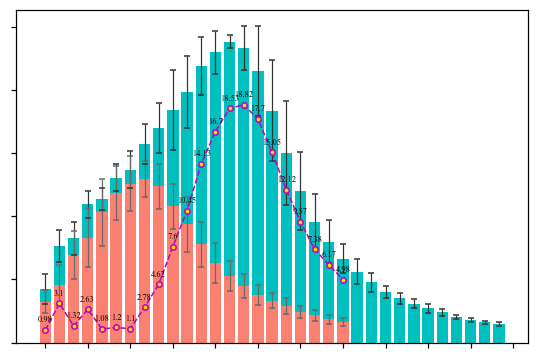

In [62]:
#Figure internode_length_distribution
fig, ax = plt.subplots(1,1)

ax.bar(range(0,33),internode_length_4m['mean'],color="c",label="4m length bamboo",
                    yerr=internode_length_4m['sd'],error_kw = {'ecolor' : '0.2', 'capsize' :2,"elinewidth" : 0.8},)
ax.bar(range(0,22),internode_length_2m['mean'],color="salmon",label="2m length bamboo",
                yerr=internode_length_2m['sd'],error_kw = {'ecolor' : 'dimgrey', 'capsize' :2,"elinewidth" : 0.8})

increasement=np.array(internode_length_4m['mean'][0:22]) - np.array(internode_length_2m['mean'])
plt.plot(range(0,22),increasement,marker=".",color="m",
         linestyle='dashed',linewidth=1,markerfacecolor='gold',markersize=7,label="Internode increasement")
for i,c in zip(range(0,22),increasement):
    plt.text(i,c+0.5,round(c,2),ha='center', va='bottom', fontsize=5.5)
# ax.set_xlabel("Internode number",size=10)
# ax.set_ylabel("Length(cm)",size=10)
# ax.set_xlim(0,34)
ax.set_xticks([x for x in range(0,34,3)])
# ax.set_xticklabels([str(x+1) for x in range(0,34,3)])
ax.set_xticklabels([str('') for x in range(0,34,3)])
ax.set_yticks([0,5,10,15,20,25])
ax.set_yticklabels('' * 6)
# x_major_locator=MultipleLocator(3)
#把x轴的主刻度设置为500的倍数
# ax.xaxis.set_major_locator(x_major_locator)
# sns.despine(ax=ax,trim=True,offset=10)
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part1_overview/Figure1.1_Internode_length_distribution.pdf', 
format='pdf', dpi=600, bbox_inches='tight',transparent = True)

###  **2. Isoform level**

#### **(1) Isoform length distribution**

In [10]:
def get_isoforms_length(annotation_gff,names,*args):
    """Extract isoforms length from gff/gtf file.

    Args:
        annotation_gff (file): annotation gff file.
        names(list): gtf name.
        *args (list): stringtie assembled gtf file.

    Returns:
        dataframe: col/anno,stri1,stir2.... , row/isoforms length.
    """
    
    length = pd.DataFrame()
    
    gff_list=["seqid","source","type","start","end","score","strand","phase","attributes"]
    anno = pd.read_csv(annotation_gff,sep="\t",names=gff_list)
    anno_mrna = anno[anno['type'] == 'mRNA'].reset_index()  
    length['anno_gff'] = anno_mrna['end'] - anno_mrna['start'] + 1

    for stringtie_gtf,file_name in zip(args,names):
        stri = pd.read_csv(stringtie_gtf,sep="\t",names=gff_list,skiprows=2)
        stri_mrna = stri[stri['type'] == 'transcript'].reset_index()
        length[file_name] = stri_mrna['end'] - stri_mrna['start'] + 1
    
    return length    

In [11]:
length = get_isoforms_length(anno_gff,['nano_gtf','pacb_gtf','illu_gtf'],nano_gtf,pacb_gtf,illu_gtf)

/home/litao/miniconda3/envs/jupyter-remote/lib/python3.7/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


/home/litao/miniconda3/envs/jupyter-remote/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


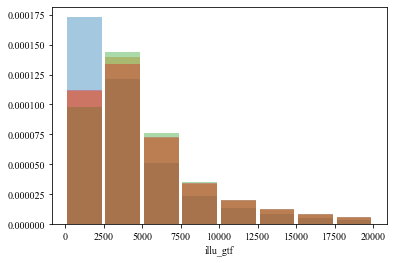

In [12]:
# Calculate_sns.distplot_density
def Calculate_sns_density(num1,num2,num3):
    n=0
    total_density = []
    samples = ['anno','nano','pacb','illu']
    density = pd.DataFrame()
    sns.distplot(length['anno_gff'],hist=True,kde=False,bins=np.linspace(num1,num2,num3),hist_kws={'density': True,"rwidth":0.9})
    sns.distplot(length['nano_gtf'],hist=True,kde=False,bins=np.linspace(num1,num2,num3),hist_kws={'density': True,"rwidth":0.9})
    sns.distplot(length['pacb_gtf'],hist=True,kde=False,bins=np.linspace(num1,num2,num3),hist_kws={'density': True,"rwidth":0.9})
    a = sns.distplot(length['illu_gtf'],hist=True,kde=False,bins=np.linspace(num1,num2,num3),hist_kws={'density': True,"rwidth":0.9}).patches
    for i in a:
        total_density.append(i.get_height())
    for sample in samples:
        density[sample] = total_density[n:n+num3-1]
        n += num3-1

    return density

density_sns = Calculate_sns_density(0,20000,9)

In [13]:
density_sns['FC_nano_vs_anno'] = density_sns['nano'] / density_sns['anno']
density_sns['FC_nano_vs_pacb'] = density_sns['nano'] / density_sns['pacb']
density_sns['FC_nano_vs_illu'] = density_sns['nano'] / density_sns['illu']
density_sns

anno      nano      pacb      illu  FC_nano_vs_anno  FC_nano_vs_pacb  \
0  0.000173  0.000112  0.000098  0.000112         0.644309         1.139125   
1  0.000121  0.000140  0.000143  0.000134         1.151908         0.972853   
2  0.000051  0.000072  0.000076  0.000072         1.408823         0.943608   
3  0.000024  0.000033  0.000035  0.000035         1.399919         0.937376   
4  0.000014  0.000019  0.000020  0.000020         1.417643         0.964346   
5  0.000009  0.000012  0.000013  0.000013         1.382469         0.910239   
6  0.000005  0.000008  0.000009  0.000008         1.442511         0.906348   
7  0.000004  0.000005  0.000006  0.000006         1.434120         0.905127   

   FC_nano_vs_illu  
0         0.992600  
1         1.042740  
2         0.989346  
3         0.960362  
4         0.955137  
5         0.921559  
6         0.948187  
7         0.926065

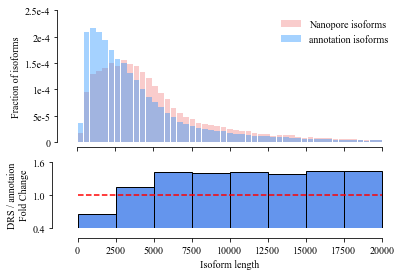

In [24]:
#Figure1.2 Isoform_distribution_and_fold_change_nanopore_vs_annotation.

#fig,[ax1,ax2] = plt.subplots(2,figsize=(4.0,2.5),sharex=True,gridspec_kw = {'height_ratios':[2, 1]})
fig,[ax1,ax2] = plt.subplots(2,gridspec_kw = {'height_ratios':[2, 1]})
labels = ['Nanopore isoforms','annotation isoforms']
colors = ["lightcoral", "dodgerblue"]
samples = ['nano_gtf','anno_gff']
for indexs,color,lable in zip(samples,colors,labels):
    sns.distplot(length[indexs].dropna(),
                 hist=True, kde=False,
                 bins=np.linspace(0, 20000, 50),
                 hist_kws={'density': True,"rwidth":0.9},
                 color=color,
                 label=lable, ax=ax1)

ax2.plot([0,20000],[1,1],color="red",linestyle="--")
for i in range(len(density_sns['FC_nano_vs_anno'])):
    # x_location = i * 1000 + 500
    x1 = i * 2500
    x2 = ((i+1) * 2500) - 1
    x = [x1,x2]
    y = [density_sns['FC_nano_vs_anno'][i],density_sns['FC_nano_vs_anno'][i]]
    ax2.add_patch(mpatches.Rectangle((x1,0),width = 2500,height= density_sns['FC_nano_vs_anno'][i],zorder = 0,edgecolor="black",facecolor='cornflowerblue'))


ax1.legend(loc='upper right',frameon=False)

ax1.set_ylim(0, 0.00025)
ax1.set_yticks([0,0.00005,0.0001,0.00015,0.0002,0.00025])
ax1.set_yticklabels(['0','5e-5','1e-4','1.5e-4','2e-4','2.5e-4'])
ax1.set_ylabel('Fraction of isoforms')

ax2.set_ylim(0.4, 1.6)
ax2.set_yticks([0.4,1,1.6])
ax2.set_ylabel("DRS / annotaion\nFold Change")

x_major_locator=MultipleLocator(2500)
ax2.xaxis.set_major_locator(x_major_locator)

# adjust_spines(ax1, ['left', 'bottom'])
# adjust_spines(ax2, ['left', 'bottom'])

ax1.set_xlabel('')
ax1.set_xticks([0,2500,5000,7500,10000,12500,15000,17500,20000])
ax1.set_xticklabels(['','','','','','','','',''])
sns.despine(ax=ax2,trim=True,offset=10)
sns.despine(ax=ax1,trim=True,offset=5)
plt.xlabel("Isoform length")

plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part1_overview/Figure2.3_Isoform_distribution_and_fold_change_nanopore_vs_annotation.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)


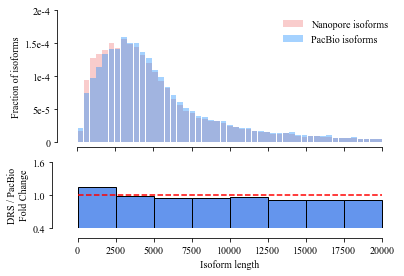

In [23]:
#Figure1.3 Isoform_distribution_and_fold_change_nanopore_vs_Pacbio.

#fig,[ax1,ax2] = plt.subplots(2,figsize=(4.0,2.5),sharex=True,gridspec_kw = {'height_ratios':[2, 1]})
fig,[ax1,ax2] = plt.subplots(2,gridspec_kw = {'height_ratios':[2, 1]})
labels = ['Nanopore isoforms','PacBio isoforms']
colors = ["lightcoral", "dodgerblue"]
samples = ['nano_gtf','pacb_gtf']
for indexs,color,lable in zip(samples,colors,labels):
    sns.distplot(length[indexs].dropna(),
                 hist=True, kde=False,
                 bins=np.linspace(0, 20000, 50),
                 hist_kws={'density': True,"rwidth":0.9},
                 color=color,
                 label=lable,ax=ax1)

ax2.plot([0,20000],[1,1],color="red",linestyle="--")
for i in range(len(density_sns['FC_nano_vs_pacb'])):
    # x_location = i * 1000 + 500
    x1 = i * 2500
    x2 = ((i+1) * 2500) - 1
    x = [x1,x2]
    y = [density_sns['FC_nano_vs_pacb'][i],density_sns['FC_nano_vs_pacb'][i]]
    ax2.add_patch(mpatches.Rectangle((x1,0),width = 2500,height= density_sns['FC_nano_vs_pacb'][i],zorder = 0,edgecolor="black",facecolor='cornflowerblue'))


ax1.legend(loc='upper right',frameon=False)

ax1.set_ylim(0, 0.0002)
ax1.set_yticks([0,0.00005,0.0001,0.00015,0.0002])
ax1.set_yticklabels(['0','5e-5','1e-4','1.5e-4','2e-4'])
ax1.set_ylabel('Fraction of isoforms')

ax2.set_ylim(0.4, 1.6)
ax2.set_yticks([0.4,1,1.6])
ax2.set_ylabel("DRS / PacBio\nFold Change")

x_major_locator=MultipleLocator(2500)
ax2.xaxis.set_major_locator(x_major_locator)

# adjust_spines(ax1, ['left', 'bottom'])
# adjust_spines(ax2, ['left', 'bottom'])

ax1.set_xlabel('')
ax1.set_xticks([0,2500,5000,7500,10000,12500,15000,17500,20000])
ax1.set_xticklabels(['','','','','','','','',''])

sns.despine(ax=ax2,trim=True,offset=10)
sns.despine(ax=ax1,trim=True,offset=5)

plt.xlabel("Isoform length")

plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part1_overview/Figure2.7_Isoform_distribution_and_fold_change_nanopore_vs_pacbio.pdf',format='pdf', dpi=600, bbox_inches='tight',transparent = True)

#### **(2) Number of alternative isoforms**

In [2]:
def read_suppa_ioe(ioe_file):
    df = pd.read_csv(ioe_file,sep='\t')
    return df

In [3]:
index_list = ['RI','SE','A3','A5','AF','AL','MX']
alt_iso_dict = {}
for sample in ['2B','2M','4B','4M','all']:
    alternative_isoform_list = []
    for as_type in index_list:
        path = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/05_AS/phe_shoot_' + sample + '_rep1_' + as_type + '_strict.ioe'
        df = read_suppa_ioe(path)
        alternative_isoform_list.append(len(df['alternative_transcripts'].unique()))
        alt_iso_dict[sample] = alternative_isoform_list
alt_iso_df = pd.DataFrame(alt_iso_dict,index=index_list)

In [24]:
alt_iso_df

2B    2M    4B    4M   all
RI  5712  7071  4595  3811  6066
SE  1008  1138   778   607  2435
A3   755   934   560   524  2041
A5   752   929   585   490  1991
AF   226   247   206   195   600
AL   138   137   136    87   381
MX    30    30    18    19    80

In [5]:
alt_type_dict = {}
index_list = ['RI','SE','A3','A5','AF','AL']
for as_type in index_list:
    path = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/05_AS/phe_shoot_' + 'all' + '_rep1_' + as_type + '_strict.ioe'
    df = read_suppa_ioe(path)
    alt_type_dict[as_type] = list(df['alternative_transcripts'].unique())

In [7]:
phe_all_isoform = from_contents(alt_type_dict)

In [32]:
alt_iso_df

2B    2M    4B    4M   all
RI  5712  7071  4595  3811  6066
SE  1008  1138   778   607  2435
A3   755   934   560   524  2041
A5   752   929   585   490  1991
AF   226   247   206   195   600
AL   138   137   136    87   381
MX    30    30    18    19    80

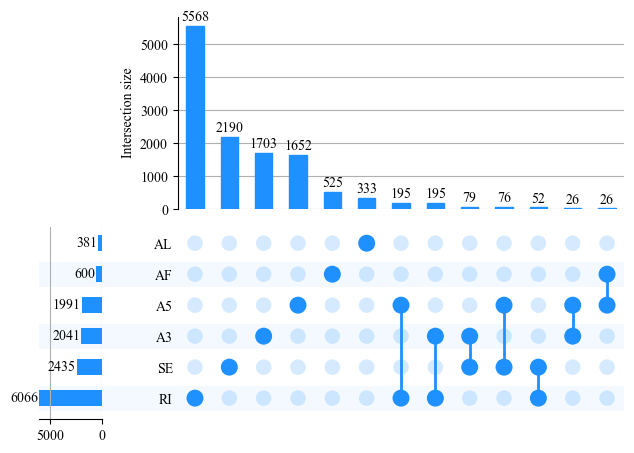

In [36]:
#Figure upsetplot of alternative isoform
# ax = UpSet(phe_all_isoform, subset_size='count',min_subset_size=20,facecolor="dodgerblue",show_counts=True,sort_by='cardinality',intersection_plot_elements=6)
plot(phe_all_isoform, subset_size='count',min_subset_size=20,facecolor="dodgerblue",show_counts=True,sort_by='cardinality')
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part1_overview/Figure2.4_Upsetplot_of_alternative_isoform.pdf', 
format='pdf', dpi=600, bbox_inches='tight',transparent = True)

###  **3. Full length transcriptome**

#### **(1) Extract full length reads bam file**

In [11]:
def extract_reads_by_name_list(name_list,inp_bam,out_bam):    
    """Extract alignment by read name from bamfile.
    https://github.com/pysam-developers/pysam/issues/666

    Args:
        name_list (list): query name list
        inp_bam (bam file): input bamfile.
        out_bam (bam file): output bam
    """
    bamfile = pysam.AlignmentFile(inp_bam, 'rb')
    name_indexed = pysam.IndexedReads(bamfile)  
    name_indexed.build()
#   header = bamfile.header.copy()
    out = pysam.AlignmentFile(out_bam, "wb", template=bamfile)
    for name in name_list:
        try:
            name_indexed.find(name)
        except KeyError:
            pass
        else:
            iterator = name_indexed.find(name)
            for x in iterator:  # x is an alignment
                out.write(x)
    out.close()

In [15]:
def get_full_length_reads_list(cov_file):
    df = pd.read_csv(cov_file,sep='\t')
    read_list = df[df['reads_coverage'] >= .95]['reads_name'].to_list()
    return read_list

In [25]:
#extract full length reads bam file
for i,n in zip(['2B','2M','4B','4M'],[phe_2b_reads_cov_file,phe_2m_reads_cov_file,phe_4b_reads_cov_file,phe_4m_reads_cov_file]):
    input_path = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/03_minimap2/phe_shoot_' + i + '_rep1_genome_correct_2308.sorted.bam'
    output_path = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/17_full_length_as/01_full_length_genome_bam/phe_shoot_full_length_' + i + '_genome.bam'
    extract_reads_by_name_list(get_full_length_reads_list(n),input_path,output_path)

#### **(2) Full-length reads percentage**

In [37]:
coverage_2b = pd.read_csv(cov_file_2b,sep='\t',dtype={'reads_coverage':float})['reads_coverage'] 
coverage_2m = pd.read_csv(cov_file_2m,sep='\t',dtype={'reads_coverage':float})['reads_coverage'] 
coverage_4b = pd.read_csv(cov_file_4b,sep='\t',dtype={'reads_coverage':float})['reads_coverage'] 
coverage_4m = pd.read_csv(cov_file_4m,sep='\t',dtype={'reads_coverage':float})['reads_coverage'] 
coverage_all = pd.concat([coverage_2b,coverage_2m,coverage_4b,coverage_4m])

In [38]:
samples = ['S-2-B','S-2-M','S-4-B','S-4-M']
reads_percentage = np.array([0.2111,0.2154,0.1848,0.1637]) * 100

In [39]:
reads_percentage

array([21.11, 21.54, 18.48, 16.37])

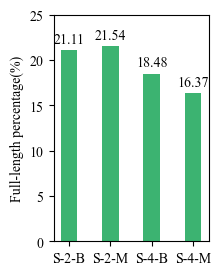

In [47]:
#Figure1.1 Full-length reads percentage.
fig, ax = plt.subplots(1,1,figsize=(2,3))
rects1 = ax.bar(samples,reads_percentage,width=0.4,color='mediumseagreen')
ax.set_ylim(0,25)
ax.set_ylabel('Full-length percentage(%)')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part1_overview/Figure2.1_Fraction_of_all_full-length_reads.pdf', 
format='pdf', dpi=600, bbox_inches='tight',transparent = True)

#### **(3) Fraction of all full-length reads**

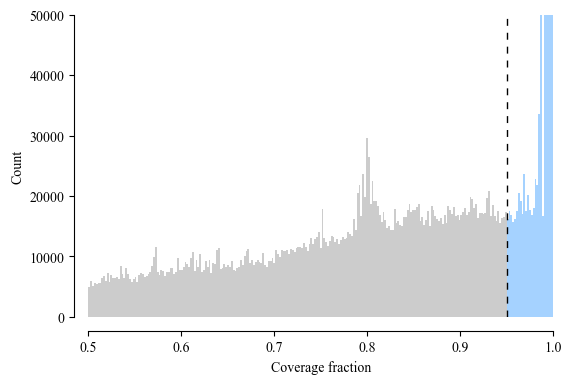

In [43]:
#Figure1.4 Fraction_of_all_full-length_reads.
up95 = coverage_all[coverage_all >= 0.95]
do95 = coverage_all[coverage_all < 0.95]
sns.distplot(up95,hist=True, kde=False,
                 bins=25,
                 hist_kws={'density': False},color='dodgerblue')
sns.distplot(do95,hist=True, kde=False,
                 bins=475,
                 hist_kws={'density': False},color='grey')

plt.xlim(0.5,1)
plt.ylim(0,50000)

plt.xlabel('Coverage fraction',fontsize=10)
plt.ylabel('Count',fontsize=10)

plt.axvline(x=0.95,ls=(0,(5,5)),linewidth=1,c="black")


ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none') 
adjust_spines(ax, ['left', 'bottom'])

#把x轴的刻度间隔设置为500，并存在变量里
y_major_locator=MultipleLocator(10000)
#把x轴的主刻度设置为500的倍数
ax.yaxis.set_major_locator(y_major_locator)

# plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/phe_shoot_figure/fig/Figure1.4_Fraction_of_all_full-length_reads.pdf', 
# format='pdf', dpi=600, bbox_inches='tight',transparent = True)

#### **(4) Gene body coverage of DRS reads**

In [44]:
#Tips:This function will cost a lot of memory.
#At least larger than the space occupied by the FAST file.
def gene_body_coverage(coverage_bed,bin=100):
    """Calculate relative coverage at the gene body level.

    Args:
        coverage_bed: bedtools coverage output file.
        bin(int): length of all genes normalised to bin. default is 100.

    Returns:
        list: Relative coverage of each bin.
    """
    rel_cov = []
    bed_list = ['gene_name','transcript_start','transcript_end','position','depth']
    coverage_bedtools = pd.read_csv(coverage_bed,names=bed_list,sep='\t',
    dtype={'gene_name':str,'transcript_start':int,'transcript_end':int,'position':int,'depth':int},usecols=['transcript_end','position','depth'])
    coverage_bedtools = coverage_bedtools[coverage_bedtools['depth'] > 0]
    coverage_bedtools['relative_position'] = coverage_bedtools['position'] / coverage_bedtools['transcript_end']
    coverage_bedtools['bin'] = coverage_bedtools['relative_position'] * bin
    coverage_bedtools['rel_bin'] = coverage_bedtools['bin'].astype(int)

    total_base = coverage_bedtools['depth'].sum()
    for i in trange(bin):
        rel_cov.append(coverage_bedtools[coverage_bedtools['rel_bin'] == i]['depth'].sum() / total_base) 
            
    return rel_cov

In [48]:
rel_cov_2b = gene_body_coverage(rel_cov_2b_file)
rel_cov_2m = gene_body_coverage(rel_cov_2m_file)
rel_cov_4b = gene_body_coverage(rel_cov_4b_file)
rel_cov_4m = gene_body_coverage(rel_cov_4m_file)
rel_cov_full_all = gene_body_coverage(rel_cov_full_all_file)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.13it/s]


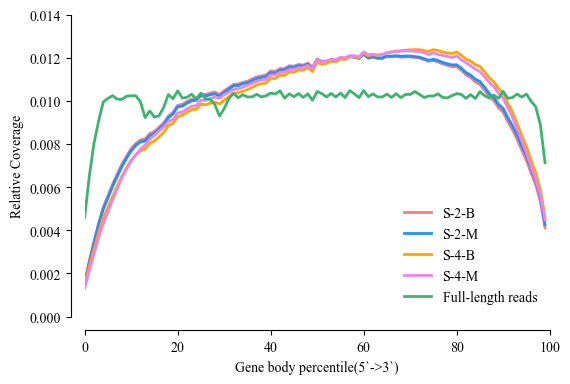

In [50]:
#Figure1.5 Gene_body_relative_coverage.
colors = ["lightcoral", "dodgerblue","orange","violet"]
plt.plot(rel_cov_2b,color='lightcoral',linewidth=2,label='S-2-B')
plt.plot(rel_cov_2m,color='dodgerblue',linewidth=2,label='S-2-M')
plt.plot(rel_cov_4b,color='orange',linewidth=2,label='S-4-B')
plt.plot(rel_cov_4m,color='violet',linewidth=2,label='S-4-M')
plt.plot(rel_cov_full_all,color='mediumseagreen',linewidth=2,label='Full-length reads')

plt.xlim(0,100)
plt.ylim(0,0.014)

plt.xlabel('Gene body percentile(5`->3`)',fontsize=10)
plt.ylabel('Relative Coverage',fontsize=10)
plt.legend(loc='lower right',frameon=False,fontsize=10)

ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none') 
adjust_spines(ax, ['left', 'bottom'])

plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part1_overview/Figure2.2_Gene_body_relative_coverage.pdf', 
format='pdf', dpi=600, bbox_inches='tight',transparent = True)

#### **(5) Gene level full length ratio**

In [19]:
def load_reads_cov_file(reads_cov_file):
    df = pd.read_csv(reads_cov_file,sep='\t',header=0,
    dtype={'reference_name':str,'reads_name':str,'reads_coverage':float})
    return df

def count_full_length(x):
    num = len(x[x >= 0.95])
    return num

In [20]:
phe_2b_reads_cov = load_reads_cov_file(phe_2b_reads_cov_file)
phe_2m_reads_cov = load_reads_cov_file(phe_2m_reads_cov_file)
phe_4b_reads_cov = load_reads_cov_file(phe_4b_reads_cov_file)
phe_4m_reads_cov = load_reads_cov_file(phe_4m_reads_cov_file)

phe_2b_gene_cov = phe_2b_reads_cov[['reference_name','reads_coverage']].groupby(['reference_name']).agg(full_length_num=('reads_coverage',count_full_length),total_num=('reads_coverage','count'))
phe_2m_gene_cov = phe_2m_reads_cov[['reference_name','reads_coverage']].groupby(['reference_name']).agg(full_length_num=('reads_coverage',count_full_length),total_num=('reads_coverage','count'))
phe_4b_gene_cov = phe_4b_reads_cov[['reference_name','reads_coverage']].groupby(['reference_name']).agg(full_length_num=('reads_coverage',count_full_length),total_num=('reads_coverage','count'))
phe_4m_gene_cov = phe_4m_reads_cov[['reference_name','reads_coverage']].groupby(['reference_name']).agg(full_length_num=('reads_coverage',count_full_length),total_num=('reads_coverage','count'))

phe_2b_gene_cov.loc[:,'full_length_ratio'] = phe_2b_gene_cov['full_length_num'] /phe_2b_gene_cov['total_num']
phe_2m_gene_cov.loc[:,'full_length_ratio'] = phe_2m_gene_cov['full_length_num'] /phe_2m_gene_cov['total_num']
phe_4b_gene_cov.loc[:,'full_length_ratio'] = phe_4b_gene_cov['full_length_num'] /phe_4b_gene_cov['total_num']
phe_4m_gene_cov.loc[:,'full_length_ratio'] = phe_4m_gene_cov['full_length_num'] /phe_4m_gene_cov['total_num']

In [26]:
phe_2b_gene_cov[phe_2b_gene_cov['full_length_num'] >= 1]

full_length_num  total_num  full_length_ratio
reference_name                                                 
PH02Gene00003.t1               12         34           0.352941
PH02Gene00005.t1                1          1           1.000000
PH02Gene00006.t1                7         12           0.583333
PH02Gene00016.t1                4         47           0.085106
PH02Gene00018.t1                1         44           0.022727
...                           ...        ...                ...
PH02Gene51471.t1                1          1           1.000000
PH02Gene51473.t1                5          8           0.625000
PH02Gene51480.t1                1          1           1.000000
PH02Gene51513.t1                1          3           0.333333
PH02Gene51522.t1                1          1           1.000000

[11635 rows x 3 columns]

## **Part2 Properties of poly(A) tail length**

### **1. Poly(A) tail length distribution**

In [56]:
def read_polya_tsv(polya_tsv):
    """Read polya results file and remove duplicate rows.

    Args:
        polya_tsv (file): nanopolish output prefix.polya_results.tsv file.

    Returns:
        dataframe: reads unique dataframe.
    """
    polya_df = pd.read_table(
        polya_tsv, sep='\t',
        usecols=['readname', 'contig', 'position', 'polya_length', 'qc_tag'],
        na_values=['-1'],
        dtype={'readname': str, 'contig': str, 'position': int, 'polya_length': float, 'qc_tag': 'category'},
        index_col='readname'
    )
    polya_df = polya_df[polya_df['qc_tag']=='PASS']
    polya_df = polya_df[~polya_df.index.duplicated()]
    return polya_df

def read_featurecounts_tsv(featurecounts_tsv):
    featurecounts_df = pd.read_table(
        featurecounts_tsv, sep='\t',
        names=['readname', 'assigned_type', 'num', 'geneid'],
        dtype={'readname': str, 'assigned_type': str, 'num': int,  'geneid': str},
        index_col='readname'
    )
    featurecounts_df = featurecounts_df[featurecounts_df['assigned_type'] == 'Assigned']
    featurecounts_df = featurecounts_df[~featurecounts_df.index.duplicated()]
    return featurecounts_df

In [59]:
polya_2b = read_polya_tsv(phe_2b_polya_tail_reads_level_file)
polya_2m = read_polya_tsv(phe_2m_polya_tail_reads_level_file)
polya_4b = read_polya_tsv(phe_4b_polya_tail_reads_level_file)
polya_4m = read_polya_tsv(phe_4m_polya_tail_reads_level_file)
polya_all = pd.concat([polya_2b,polya_2m,polya_4b,polya_4m])

count_2b = read_featurecounts_tsv(phe_2b_featurecounts_reads_file)
count_2m = read_featurecounts_tsv(phe_2m_featurecounts_reads_file)
count_4b = read_featurecounts_tsv(phe_4b_featurecounts_reads_file)
count_4m = read_featurecounts_tsv(phe_4m_featurecounts_reads_file)
count_all = pd.concat([count_2b,count_2m,count_4b,count_4m])

In [34]:
#Combine all polya data and add tags.
samples = ['phe_2B','phe_2M','phe_4B','phe_4M']
polya_dfs = [polya_2b,polya_2m,polya_4b,polya_4m]
for polya_df,sample in zip(polya_dfs,samples):
    polya_df.loc[:, 'sample_name'] = sample
polya = pd.concat(polya_dfs)

In [35]:
polya.loc[:,'gene_id'] = count_all['geneid']

In [100]:
polya

contig  position  \
readname                                                             
c2e82a6d-5790-4efd-acce-af3a1c439612      hic_scaffold_1     37988   
3147d80e-5137-4add-b621-2cdb616da86b      hic_scaffold_1     38038   
4c5f8be7-bcb9-4f16-b2ca-d8222631b331      hic_scaffold_1     72893   
529ed237-d906-408b-910f-8be134f6d5f1      hic_scaffold_1      3347   
b09f9a73-4819-4152-bdcd-95806a883285      hic_scaffold_1     73059   
...                                                  ...       ...   
91c5d5a5-5958-41a6-94d8-0ece9219cc5a  hic_scaffold_19684      4303   
45f64dc0-b33d-4007-9988-4c6094c7a551  hic_scaffold_19656      4651   
d023eeb2-fc0a-4ab0-9e26-7e10967d485d  hic_scaffold_19684      4263   
9975d81a-e578-409a-9bed-188fa22aeb53  hic_scaffold_19656      5373   
dacd4f7a-8bf3-44de-8c9e-420fd013aca7  hic_scaffold_19684      4263   

                                      polya_length qc_tag sample_name  \
readname                                                                
c2e82a6d-5790-4efd-acce-af3a1c439612         68.20   PASS      phe_2B   
3147d80e-5137-4add-b621-2cdb616da86b         40.94   PASS      phe_2B   
4c5f8be7-bcb9-4f16-b2ca-d8222631b331        212.52   PASS      phe_2B   
529ed237-d906-408b-910f-8be134f6d5f1        110.08   PASS      phe_2B   
b09f9a73-4819-4152-bdcd-95806a883285        313.71   PASS      phe_2B   
...                                            ...    ...         ...   
91c5d5a5-5958-41a6-94d8-0ece9219cc5a        146.57   PASS      phe_4M   
45f64dc0-b33d-4007-9988-4c6094c7a551         58.46   PASS      phe_4M   
d023eeb2-fc0a-4ab0-9e26-7e10967d485d         45.21   PASS      phe_4M   
9975d81a-e578-409a-9bed-188fa22aeb53         11.12   PASS      phe_4M   
dacd4f7a-8bf3-44de-8c9e-420fd013aca7        132.71   PASS      phe_4M   

                                            gene_id  
readname                                             
c2e82a6d-5790-4efd-acce-af3a1c439612            NaN  
3147d80e-5137-4add-b621-2cdb616da86b            NaN  
4c5f8be7-bcb9-4f16-b2ca-d8222631b331            NaN  
529ed237-d906-408b-910f-8be134f6d5f1            NaN  
b09f9a73-4819-4152-bdcd-95806a883285            NaN  
...                                             ...  
91c5d5a5-5958-41a6-94d8-0ece9219cc5a  PH02Gene50871  
45f64dc0-b33d-4007-9988-4c6094c7a551  PH02Gene41760  
d023eeb2-fc0a-4ab0-9e26-7e10967d485d  PH02Gene50871  
9975d81a-e578-409a-9bed-188fa22aeb53  PH02Gene41760  
dacd4f7a-8bf3-44de-8c9e-420fd013aca7  PH02Gene50871  

[3675183 rows x 6 columns]

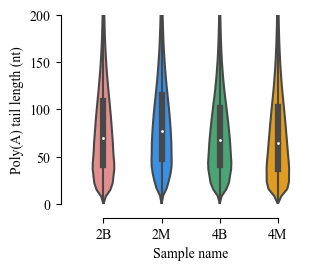

In [40]:
#Figure2.1 Polya_tail_length_violin_plot.
fig,ax = plt.subplots(figsize=(3,2.5))
samples = ['phe_2B','phe_2M','phe_4B','phe_4M']
colors = ["lightcoral", "dodgerblue","mediumseagreen","orange"]
sns.violinplot(x='sample_name',y='polya_length',data=polya,orient="v",scale="area",ax=ax,palette=colors,inner='box',width=0.4)

ax.set_ylim((0,200))

# adjust_spines(ax, ['left', 'bottom'])
ax.set_xticklabels(['2B','2M','4B','4M'])

y_major_locator=MultipleLocator(50)
ax.yaxis.set_major_locator(y_major_locator)

plt.ylabel('Poly(A) tail length (nt)',fontsize=10)
plt.xlabel('Sample name',fontsize=10)
sns.despine(ax = ax,trim=True,offset=10)
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part2_polya_tail/Figure2.2_Polya_tail_length_violin_plot.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)

In [11]:
#Calculate polya tail length confidence interval and median value.
polya_CIs = pd.DataFrame()
polya_CIs['2B'] = polya_2b.polya_length.describe(percentiles=(0.025, 0.25, 0.50, 0.75, 0.975))
polya_CIs['2M'] = polya_2m.polya_length.describe(percentiles=(0.025, 0.25, 0.50, 0.75, 0.975))
polya_CIs['4B'] = polya_4b.polya_length.describe(percentiles=(0.025, 0.25, 0.50, 0.75, 0.975))
polya_CIs['4M'] = polya_4m.polya_length.describe(percentiles=(0.025, 0.25, 0.50, 0.75, 0.975))

In [12]:
polya_CIs

2B             2M             4B             4M
count  948578.000000  997407.000000  921858.000000  807340.000000
mean       80.702171      87.235959      76.374621      75.809764
std        52.595385      53.664536      47.241089      51.681402
min         0.000000       0.000000       0.000000       0.000000
2.5%       13.790000      16.480000      14.710000      12.410000
25%        40.790000      47.190000      41.070000      36.607500
50%        70.230000      77.190000      67.460000      64.740000
75%       108.650000     114.960000     101.380000     102.650000
97.5%     210.420000     220.517000     191.500000     204.725250
max       697.840000     758.000000     692.080000     730.150000

In [ ]:
#Figure2.2 density_plot_polya_tail_length(2mvs4m)
fig, ax = plt.subplots(figsize=(6, 4))
polya_2meter = pd.concat([polya_2m['polya_length'],polya_2b['polya_length']])
polya_4meter = pd.concat([polya_4m['polya_length'],polya_4b['polya_length']])
colors = ["lightcoral", "dodgerblue"]
sns.distplot(polya_2meter,
             hist=True, kde=False,
             bins=np.linspace(0, 200, 50),
             hist_kws={'density': True,"rwidth":0.9},
             color=colors[0],
             label='2 meter shoot')
sns.distplot(polya_4meter,
             hist=True, kde=False,
             bins=np.linspace(0, 200, 50),
             hist_kws={'density': True,"rwidth":0.9},
             color=colors[1],
             label='4 meter shoot')
             
ax.legend(fontsize=10)
ax.set_ylim((0,0.012))
ax.set_xlabel('Poly(A) tail length')
ax.set_ylabel('Reads (Frequency Density)')
sns.despine(ax=ax,trim=True,offset=10)

### **2. Poly(A) tail length & gene expression**

In [9]:
def gene_median_mean_polya_length(polya,featurecounts,out):
    """Calculate the average and median length of each gene polya tail.

    Args:
        polya: read_polya_tsv output.
        featurecounts: read_featurecounts_tsv output.

    Returns:
        dict: {gene1_name:[read1_polya_length,...readN_polya_length],...}
        dataframe: index=gene_name,columns=["geneid","mean_length","median_length","polya_reads_num","count"].
        Tips:Count refers to the number of reads assigned to each gene by featurecounts, and does not require that the reads have a valid(qc_tag=PASS) polya tail length.
    """
    median_length = []
    mean_length = []
    polya_reads_num = []
    counts = []
    geneids = []
    gene_polya_length = {}

    polya_readnames = polya.index.tolist()
    featurecounts_readnames = featurecounts.index.tolist()
    #Intersection of polya_readname and featurecounts_readnames
    use_read = list(set(polya_readnames).intersection(set(featurecounts_readnames)))
    
    polya_inte = polya.loc[use_read]["polya_length"]
    featurecounts_inte = featurecounts.loc[use_read]["geneid"]

    #index=read_name,row[1]=geneid,row[2]=polya_length
    feature_polya = pd.concat([featurecounts_inte,polya_inte],axis=1)
    gene_names = list(set(feature_polya['geneid']))
    try:
        with tqdm(range(len(set(feature_polya['geneid'])))) as t:
            for geneid,i in zip(gene_names,t):
                gene_polya_length[geneid] = feature_polya[feature_polya['geneid'] == geneid]['polya_length']
                polya_reads_num.append(len(gene_polya_length[geneid]))
                median_length.append(round(np.median(gene_polya_length[geneid]),2))
                mean_length.append(round(np.mean(gene_polya_length[geneid]),2))
                geneids.append(geneid)
                counts.append(len(featurecounts[featurecounts['geneid'] == geneid]))
    except KeyboardInterrupt:
        t.close()
        raise
    t.close()

    row = [geneids,mean_length,median_length,polya_reads_num,counts]
    gene_polya_info = pd.DataFrame(row).T
    gene_polya_info.columns = ["geneid","mean_length","median_length","polya_reads_num","count"]
    gene_polya_info.set_index('geneid',inplace=True)
    gene_polya_info.to_csv(out,sep='\t')

    return gene_polya_length,gene_polya_info

In [47]:
def load_and_filter_polya_info(gene_polya_info_csv,polya_reads_num,count_num):
    """load and filter polya tial info.

        Args:
            gene_polya_info: gene_median_mean_polya_length output.
            polya_reads_num: If the number of pass_reads of single gene is less than the threshold_polya_num, they will be discarded.
            count_num: If the number of valid reads of single gene is less than the threshold_polya_num, they will be discarded.

        Returns:
            dataframe: header = ['geneid','mean_length','median_length','polya_reads_num','count']
    """
    gene_polya_info = pd.read_csv(gene_polya_info_csv,sep='\t',dtype={'geneid':str,'mean_length':float,'median_length':float,'polya_reads_num':float,'count':float},index_col='geneid')
    gene_polya_info = gene_polya_info[(gene_polya_info['polya_reads_num'] >= polya_reads_num) & (gene_polya_info['count'] >= count_num)]
    return gene_polya_info

In [48]:
#Load gene_polya_info and filter according to the number of valid polya lengths and count.
gene_polya_info_2b = load_and_filter_polya_info('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/09_polya_tail_info/phe_shoot_2B_rep1_polya_info.csv',3,0)
gene_polya_info_2m = load_and_filter_polya_info('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/09_polya_tail_info/phe_shoot_2M_rep1_polya_info.csv',3,0)
gene_polya_info_4b = load_and_filter_polya_info('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/09_polya_tail_info/phe_shoot_4B_rep1_polya_info.csv',3,0)
gene_polya_info_4m = load_and_filter_polya_info('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/09_polya_tail_info/phe_shoot_4M_rep1_polya_info.csv',3,0)
gene_polya_info_all = load_and_filter_polya_info('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/09_polya_tail_info/phe_shoot_all_rep1_polya_info.csv',3,0)

In [11]:
#merge TPM to gene polya info
phe_sample_TPM.loc[:,'all'] = phe_sample_TPM.apply('mean',axis=1)
gene_polya_info_all['TPM'] = phe_sample_TPM.loc[:,'all']

In [44]:
#liner regrssion
sample_names = ['2b','2m','4b','4m','all']
samples = [gene_polya_info_2b,gene_polya_info_2m,gene_polya_info_4b,gene_polya_info_4m,gene_polya_info_all]
line_df = pd.DataFrame()
r_slope_df = pd.DataFrame()
for sample,name in zip(samples,sample_names):
    x = name + '_x_line'
    y = name + '_y_line'
    line_df.loc[:,x] = linear_regression(np.log10(sample['count']),sample['median_length'],0,200,1000)[0]
    line_df.loc[:,y] = linear_regression(np.log10(sample['count']),sample['median_length'],0,200,1000)[1]
    r_slope_df.loc[:,name] = linear_regression(np.log10(sample['count']),sample['median_length'],0,1,1000)[2:]
r_slope_df.index = ['r','slope']

In [45]:
r_slope_df

2b         2m         4b         4m        all
r       0.312324   0.290614   0.273647   0.264656   0.300182
slope -25.059338 -23.847539 -18.002737 -19.532111 -18.866004

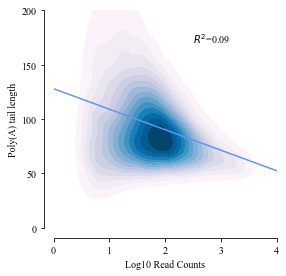

In [52]:
fig, ax = plt.subplots(1,1,figsize=(4,4))

#kdeplot (use phe-2b)
kde_x = np.log10(gene_polya_info_all['count'])
kde_y = gene_polya_info_all['median_length']
r = r_slope_df.loc['r','all']
x_line = line_df['all_x_line']
y_line = line_df['all_y_line']


ax.set_xlim(0,4)
ax.set_ylim(0,200)
sns.kdeplot(x=kde_x,y=kde_y,levels=15,shade = True, cmap = "PuBu",ax=ax)
ax.plot(x_line,y_line,color='cornflowerblue')
ax.text(2.5,170,"$R^2$=%.2f"%(r*r))
ax.set_ylabel('Poly(A) tail length')
ax.set_xlabel('Log10 Read Counts')

y_major_locator=MultipleLocator(50)
ax.yaxis.set_major_locator(y_major_locator)

sns.despine(ax = ax,trim=True,offset=10)
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part2_polya_tail/Figure_log10_count_and_polya_tail_length.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)


In [29]:
pearsonr_ci(gene_polya_info_all[gene_polya_info_all.TPM != 0]['TPM'].apply(np.log2),gene_polya_info_all[gene_polya_info_all.TPM != 0]['median_length'])

(-0.2689576485329464, 0.0, -0.2803918775698889, -0.25744710147834216)

In [37]:
0.2689576485329464 * 0.2689576485329464

0.07233821670437193

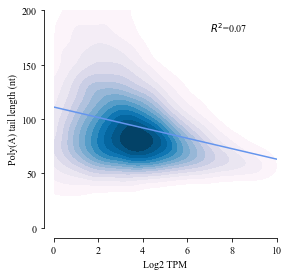

In [53]:
#Figure Density plot showing correlation between gene-expression(TPM) and polya tail length (kdeplot use phe-all)
fig, ax = plt.subplots(1,1,figsize=(4,4))
kde_x = gene_polya_info_all[gene_polya_info_all.TPM != 0]['TPM'].apply(np.log2)
kde_y = gene_polya_info_all[gene_polya_info_all.TPM != 0]['median_length']
x_line = linear_regression(gene_polya_info_all[gene_polya_info_all.TPM != 0]['TPM'].apply(np.log2),gene_polya_info_all[gene_polya_info_all.TPM != 0]['median_length'],0,200,1000)[0]
y_line = linear_regression(gene_polya_info_all[gene_polya_info_all.TPM != 0]['TPM'].apply(np.log2),gene_polya_info_all[gene_polya_info_all.TPM != 0]['median_length'],0,200,1000)[1]
r = linear_regression(gene_polya_info_all[gene_polya_info_all.TPM != 0]['TPM'].apply(np.log2),gene_polya_info_all[gene_polya_info_all.TPM != 0]['median_length'],0,200,1000)[2]

ax.set_xlim(0,10)
ax.set_ylim(0,200)
sns.kdeplot(x=kde_x,y=kde_y,levels=15,shade = True, cmap = "PuBu",ax=ax)
ax.plot(x_line,y_line,color='cornflowerblue')
ax.text(7,180,"$R^2$=%.2f"%(r*r))
ax.set_ylabel('Poly(A) tail length (nt)')
ax.set_xlabel('Log2 TPM')

y_major_locator=MultipleLocator(50)
ax.yaxis.set_major_locator(y_major_locator)

sns.despine(ax = ax,trim=True,offset=10)
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part2_polya_tail/Figure_TPM_and_polya_tail_length.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)


### **3. Poly(A) tail length & full-length reads**

In [53]:
def load_reads_cov_file(reads_cov_file):
    df = pd.read_csv(reads_cov_file,sep='\t',header=0,
    dtype={'reference_name':str,'reads_name':str,'reads_coverage':float})
    return df

In [54]:
phe_2b_reads_cov = load_reads_cov_file(phe_2b_reads_cov_file)
phe_2m_reads_cov = load_reads_cov_file(phe_2m_reads_cov_file)
phe_4b_reads_cov = load_reads_cov_file(phe_4b_reads_cov_file)
phe_4m_reads_cov = load_reads_cov_file(phe_4b_reads_cov_file)

In [55]:
def count_full_length(x):
    num = len(x[x >= 0.95])
    return num

phe_2m_gene_cov = phe_2m_reads_cov[['reference_name','reads_coverage']].groupby(['reference_name']).agg(full_length_num=('reads_coverage',count_full_length),total_num=('reads_coverage','count'))
phe_4b_gene_cov = phe_4b_reads_cov[['reference_name','reads_coverage']].groupby(['reference_name']).agg(full_length_num=('reads_coverage',count_full_length),total_num=('reads_coverage','count'))
phe_4m_gene_cov = phe_4m_reads_cov[['reference_name','reads_coverage']].groupby(['reference_name']).agg(full_length_num=('reads_coverage',count_full_length),total_num=('reads_coverage','count'))

phe_2b_gene_cov.loc[:,'full_length_ratio'] = phe_2b_gene_cov['full_length_num'] /phe_2b_gene_cov['total_num']
phe_2m_gene_cov.loc[:,'full_length_ratio'] = phe_2m_gene_cov['full_length_num'] /phe_2m_gene_cov['total_num']
phe_4b_gene_cov.loc[:,'full_length_ratio'] = phe_4b_gene_cov['full_length_num'] /phe_4b_gene_cov['total_num']
phe_4m_gene_cov.loc[:,'full_length_ratio'] = phe_4m_gene_cov['full_length_num'] /phe_4m_gene_cov['total_num']


In [54]:
phe_2b_gene_cov[(phe_2b_gene_cov['total_num'] > 10) & (phe_2b_gene_cov['full_length_num'] > 6)]

full_length_num  total_num  full_length_ratio
reference_name                                                 
PH02Gene00003.t1               12         34           0.352941
PH02Gene00006.t1                7         12           0.583333
PH02Gene00019.t1               42        120           0.350000
PH02Gene00024.t1               42         44           0.954545
PH02Gene00026.t1                7        278           0.025180
...                           ...        ...                ...
PH02Gene50862.t1               17         29           0.586207
PH02Gene50877.t1               42         63           0.666667
PH02Gene50977.t1               16         23           0.695652
PH02Gene51048.t1                9         18           0.500000
PH02Gene51218.t1               20         24           0.833333

[3265 rows x 3 columns]

In [56]:
phe_2b_full_length_reads = phe_2b_reads_cov[phe_2b_reads_cov['reads_coverage'] >= 0.95]['reads_name'].to_list()
phe_2m_full_length_reads = phe_2m_reads_cov[phe_2m_reads_cov['reads_coverage'] >= 0.95]['reads_name'].to_list()
phe_4b_full_length_reads = phe_4b_reads_cov[phe_4b_reads_cov['reads_coverage'] >= 0.95]['reads_name'].to_list()
phe_4m_full_length_reads = phe_4m_reads_cov[phe_4m_reads_cov['reads_coverage'] >= 0.95]['reads_name'].to_list()

In [57]:
phe_2b_non_full_length_reads = phe_2b_reads_cov[~(phe_2b_reads_cov['reads_coverage'] >= 0.95)]['reads_name'].to_list()
phe_2m_non_full_length_reads = phe_2m_reads_cov[~(phe_2m_reads_cov['reads_coverage'] >= 0.95)]['reads_name'].to_list()
phe_4b_non_full_length_reads = phe_4b_reads_cov[~(phe_4b_reads_cov['reads_coverage'] >= 0.95)]['reads_name'].to_list()
phe_4m_non_full_length_reads = phe_4m_reads_cov[~(phe_4m_reads_cov['reads_coverage'] >= 0.95)]['reads_name'].to_list()

In [63]:
len(phe_4m_non_full_length_reads)

831389

In [65]:
non_full_length_reads_list = [phe_2b_non_full_length_reads,phe_2m_non_full_length_reads,phe_4b_non_full_length_reads,phe_4m_non_full_length_reads]
full_length_reads_list = [phe_2b_full_length_reads,phe_2m_full_length_reads,phe_4b_full_length_reads,phe_4m_full_length_reads]
labels = ['phe_shoot_2B_rep1','phe_shoot_2M_rep1','phe_shoot_4B_rep1','phe_shoot_4M_rep1']
out_dir = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/15_sub_m6a/01_name_file/'
# for i,label in zip(full_length_reads_list,labels):
#     list_to_csv(i,out_dir + label + '_full_length_reads.csv')
for i,label in zip(non_full_length_reads_list,labels):
    list_to_csv(i,out_dir + label + '_non_full_length_reads.csv')

In [58]:
polya_2b_full_length = polya_2b[polya_2b.index.isin(phe_2b_full_length_reads)]
polya_2b_no_full_length = polya_2b[~polya_2b.index.isin(phe_2b_full_length_reads)]

polya_2m_full_length = polya_2m[polya_2m.index.isin(phe_2m_full_length_reads)]
polya_2m_no_full_length = polya_2m[~polya_2m.index.isin(phe_2m_full_length_reads)]

polya_4b_full_length = polya_4b[polya_4b.index.isin(phe_4b_full_length_reads)]
polya_4b_no_full_length = polya_4b[~polya_4b.index.isin(phe_4b_full_length_reads)]

polya_4m_full_length = polya_4m[polya_4m.index.isin(phe_4m_full_length_reads)]
polya_4m_no_full_length = polya_4m[~polya_4m.index.isin(phe_4m_full_length_reads)]

In [59]:
#all full/non-full length polya tail length 
polya_all_full_length = pd.concat([polya_2b_full_length,polya_2m_full_length,polya_4b_full_length,polya_4m_full_length])
polya_all_non_full_length = pd.concat([polya_2b_no_full_length,polya_2m_no_full_length,polya_4b_no_full_length,polya_4m_no_full_length])

In [18]:
polya_all_full_length.polya_length.describe(percentiles=(0.025, 0.25, 0.50, 0.75, 0.975))

count    740071.000000
mean         80.653794
std          49.808704
min           0.000000
2.5%         14.960000
25%          43.310000
50%          71.280000
75%         107.460000
97.5%       201.540000
max         648.040000
Name: polya_length, dtype: float64

In [20]:
polya_all_non_full_length.polya_length.describe(percentiles=(0.025, 0.25, 0.50, 0.75, 0.975))

count    2.935112e+06
mean     8.022976e+01
std      5.205261e+01
min      0.000000e+00
2.5%     1.400000e+01
25%      4.108000e+01
50%      6.993000e+01
75%      1.072400e+02
97.5%    2.095400e+02
max      7.580000e+02
Name: polya_length, dtype: float64

In [26]:
polya_4b_full_length.polya_length.describe(percentiles=(0.025, 0.25, 0.50, 0.75, 0.975))

count    176441.000000
mean         75.567495
std          45.243024
min           0.220000
2.5%         15.400000
25%          42.000000
50%          67.120000
75%          99.620000
97.5%       184.370000
max         500.960000
Name: polya_length, dtype: float64

In [27]:
polya_4b_no_full_length.polya_length.describe(percentiles=(0.025, 0.25, 0.50, 0.75, 0.975))

count    745417.000000
mean         76.565668
std          47.699816
min           0.000000
2.5%         14.560000
25%          40.820000
50%          67.540000
75%         101.830000
97.5%       193.156000
max         692.080000
Name: polya_length, dtype: float64

In [28]:
phe_2b_gene_cov

full_length_num  total_num  full_length_ratio
reference_name                                                 
PH02Gene00003.t1             12.0         34           0.352941
PH02Gene00004.t1              0.0         24           0.000000
PH02Gene00005.t1              1.0          1           1.000000
PH02Gene00006.t1              7.0         12           0.583333
PH02Gene00010.t1              0.0          4           0.000000
...                           ...        ...                ...
PH02Gene51473.t1              5.0          8           0.625000
PH02Gene51480.t1              1.0          1           1.000000
PH02Gene51497.t1              0.0          5           0.000000
PH02Gene51513.t1              1.0          3           0.333333
PH02Gene51522.t1              1.0          1           1.000000

[27137 rows x 3 columns]

In [ ]:
fig, axes = plt.subplots(1,4,figsize=(24, 4))
colors = ["lightcoral", "dodgerblue"]
samples = [[polya_2b_full_length,polya_2b_no_full_length],[polya_2m_full_length,polya_2m_no_full_length],[polya_4b_full_length,polya_4b_no_full_length],[polya_4m_full_length,polya_4m_no_full_length]]
for sample,i in zip(samples,range(4)):
    sns.histplot(sample[0]['polya_length'],stat='density',bins=np.linspace(0, 200, 50),color=colors[0],label='Full-length',ax=axes[i])
    stplot(sample[1]['polya_length'],stat='density',bins=np.linspace(0, 200, 50),color=colors[1],label='Non Full-length',ax=axes[i])
    axes[i].legend(fontsize=10,frameon=False)
    axes[i].set_ylim((0,0.012))
    axes[i].set_xlim((0,200))
    axes[i].set_xlabel('Poly(A) tail length')
    axes[i].set_ylabel('Reads (Frequency Density)')
    sns.despine(ax=axes[i],trim=True,offset=10)
plt.subplots_adjust(wspace=0.5)
# plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Figure_full_length.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)

# sns.distplot(polya_2b_no_full_length['polya_length'],
#              hist=False, kde=True,
#              bins=np.linspace(0, 200, 50),
#              hist_kws={'density': True,"rwidth":0.9},
#              color=colors[0],
#              label='Full-length')
# sns.distplot(polya_2b_full_length['polya_length'],
#              hist=False, kde=True,
#              bins=np.linspace(0, 200, 50),
#              hist_kws={'density': True,"rwidth":0.9},
#              color=colors[1],
#              label='Non Full-length')          

/home/litao/miniconda3/envs/jupyter-remote/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


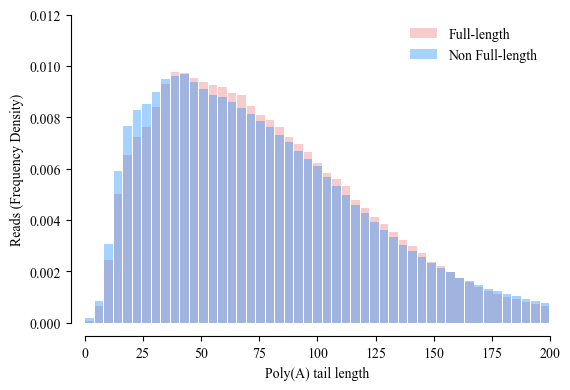

In [63]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'font.sans-serif':'Times New Roman','axes.unicode_minus':False})
mpl.rcParams['pdf.fonttype'] = 42


fig, ax = plt.subplots(1,1,figsize=(6, 4))
colors = ["lightcoral", "dodgerblue"]
samples = [[polya_2b_full_length,polya_2b_no_full_length],[polya_2m_full_length,polya_2m_no_full_length],[polya_4b_full_length,polya_4b_no_full_length],[polya_4m_full_length,polya_4m_no_full_length]]
# for sample,i in zip(samples,range(4)):
sns.distplot(polya_all_full_length['polya_length'],hist=True, kde=False,bins=np.linspace(0, 200, 50),color='lightcoral',label='Full-length',ax=ax,hist_kws={'density': True,"rwidth":0.9})
sns.distplot(polya_all_non_full_length['polya_length'],hist=True, kde=False,bins=np.linspace(0, 200, 50),color='dodgerblue',label='Non Full-length',ax=ax,hist_kws={'density': True,"rwidth":0.9})
ax.legend(fontsize=10,frameon=False)
ax.set_ylim((0,0.012))
ax.set_xlim((0,200))
ax.set_xlabel('Poly(A) tail length')
ax.set_ylabel('Reads (Frequency Density)')
sns.despine(ax=ax,trim=True,offset=10)
# plt.subplots_adjust(wspace=0.5)
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part2_polya_tail/Figure2.3_all_Polya_tail_length_full_lengt_reads.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)

In [ ]:
sns.distplot(length[indexs].dropna(),
                 hist=True, kde=False,
                 bins=np.linspace(0, 20000, 50),
                 hist_kws={'density': True,"rwidth":0.9},
                 color=color,
                 label=lable, ax=ax1)

### **4. Poly(A) tail length & splicing raeds**

In [53]:
def read_ex_ir_out(ex_out_file):
    df = pd.read_csv(ex_out_file,sep='\t')
    print('{} {} {} '.format('A total of ',len(df[df.duplicated(subset='read_id',keep=False)]['read_id'].unique()),
                                ' reads span multiple genes, these reads will be discarded.'))
    #Some reads span two genes body, these reads will be discarded. 
    df.drop_duplicates(subset='read_id',keep=False,inplace=True)
    return df    

In [54]:
df_list = []
samples = ['phe_shoot_2B_rep1','phe_shoot_2M_rep1','phe_shoot_4B_rep1','phe_shoot_4M_rep1']
labels = ['S-2-B', 'S-2-M', 'S-4-B', 'S-4-M']
for sample,label in zip(samples,labels):
    ex_path = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/14_splicing_reads/' + sample + '_ex_out.txt'
    ir_path = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/14_splicing_reads/' + sample + '_ir_out.txt'
    ex_df = read_ex_ir_out(ex_path)
    ir_df = read_ex_ir_out(ir_path)
    df = ex_df[['read_id','exon_total_count','exon_count','skipped_exon_count','skipped_exon']].merge(ir_df[['read_id','intron_total_count','intron_count','unsplice_count','unsplice_intron']],how='left',left_on=['read_id'],right_on=['read_id'],sort=False)
    df.loc[:,'sample'] = label
    df_list.append(df)
all_splice_stat_df = pd.concat(df_list)

A total of  15781  reads span multiple genes, these reads will be discarded. 
A total of  15781  reads span multiple genes, these reads will be discarded. 
A total of  18079  reads span multiple genes, these reads will be discarded. 
A total of  18079  reads span multiple genes, these reads will be discarded. 
A total of  13050  reads span multiple genes, these reads will be discarded. 
A total of  13050  reads span multiple genes, these reads will be discarded. 
A total of  10477  reads span multiple genes, these reads will be discarded. 
A total of  10477  reads span multiple genes, these reads will be discarded. 


In [55]:
ex_reads = all_splice_stat_df[(all_splice_stat_df['skipped_exon'].notna() & all_splice_stat_df['unsplice_intron'].isna())]['read_id']
ir_reads = all_splice_stat_df[(all_splice_stat_df['skipped_exon'].isna() & all_splice_stat_df['unsplice_intron'].notna())]['read_id']
ex_ir_reads = all_splice_stat_df[(all_splice_stat_df['skipped_exon'].notna() & all_splice_stat_df['unsplice_intron'].notna())]['read_id']
un_spliced_reads = all_splice_stat_df[(all_splice_stat_df['skipped_exon'].isna() & all_splice_stat_df['unsplice_intron'].isna())]['read_id']

In [60]:
ex_polya = polya_all[polya_all.index.isin(ex_reads)].copy()
ir_polya = polya_all[polya_all.index.isin(ir_reads)].copy()
ex_ir_polya = polya_all[polya_all.index.isin(ex_ir_reads)].copy()
un_spliced_polya = polya_all[polya_all.index.isin(un_spliced_reads)].copy()

In [61]:
#Combine all polya data and add tags.
samples = ['ex_polya','ir_polya','ex_ir_polya','un_spliced_polya']
polya_dfs = [ex_polya,ir_polya,ex_ir_polya,un_spliced_polya]
for polya_df,sample in zip(polya_dfs,samples):
    polya_df.loc[:, 'sample_name'] = sample
spliced_polya = pd.concat(polya_dfs)

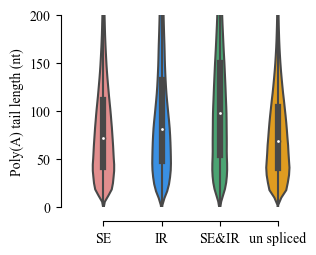

In [64]:
#Figure Spliced_reads_polya_tail_length_violin_plot.
fig,ax = plt.subplots(figsize=(3,2.5))
samples = ['ex_polya','ir_polya','ex_ir_polya','un_spliced_polya']
colors = ["lightcoral", "dodgerblue","mediumseagreen","orange"]
sns.violinplot(x="sample_name", y="polya_length", data=spliced_polya,orient="v",scale="area",ax=ax,palette=colors,inner='box',width=0.4)

ax.set_ylim((0,200))

# adjust_spines(ax, ['left', 'bottom'])
ax.set_xticklabels(['SE','IR','SE&IR','un spliced'])

y_major_locator=MultipleLocator(50)
ax.yaxis.set_major_locator(y_major_locator)

plt.ylabel('Poly(A) tail length (nt)',fontsize=10)
plt.xlabel('')
sns.despine(ax = ax,trim=True,offset=10)
# plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part2_polya_tail/Figure_Polya_tail_and_splicing.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)

In [63]:
spliced_polya[spliced_polya['sample_name'] == 'un_spliced_polya'].describe(percentiles=(0.025, 0.25, 0.50, 0.75, 0.975))

position  polya_length
count  1.890869e+06  1.890869e+06
mean   4.650378e+07  7.761466e+01
std    3.213647e+07  4.818321e+01
min    0.000000e+00  0.000000e+00
2.5%   1.019824e+06  1.422000e+01
25%    1.730056e+07  4.092000e+01
50%    4.423573e+07  6.876000e+01
75%    7.729339e+07  1.042900e+02
97.5%  1.093524e+08  1.931600e+02
max    1.372787e+08  7.580000e+02

In [44]:
len(anno_intron_level.gene_name.unique())

49053

In [46]:
anno_gene_level[~anno_gene_level.index.isin(anno_intron_level.gene_name.unique())].index

Index(['PH02Gene00011', 'PH02Gene00018', 'PH02Gene00028', 'PH02Gene00104',
       'PH02Gene00136', 'PH02Gene00191', 'PH02Gene00249', 'PH02Gene00263',
       'PH02Gene00269', 'PH02Gene00312',
       ...
       'PH02Gene51508', 'PH02Gene51511', 'PH02Gene51512', 'PH02Gene51514',
       'PH02Gene51515', 'PH02Gene51516', 'PH02Gene51517', 'PH02Gene51518',
       'PH02Gene51521', 'PH02Gene51522'],
      dtype='object', length=1883)

In [52]:
gene_polya_info_all[gene_polya_info_all.index.isin(anno_gene_level[~anno_gene_level.index.isin(anno_intron_level.gene_name.unique())].index)]['median_length'].describe(percentiles=(0.025, 0.25, 0.50, 0.75, 0.975))

count    955.000000
mean      67.233183
std       17.253123
min       26.850000
2.5%      40.514500
25%       57.240000
50%       65.260000
75%       73.990000
97.5%    110.901500
max      197.890000
Name: median_length, dtype: float64

### **5. Poly(A) tail length & m6A**

In [13]:
def polya_length_qcut(polya_df,group_num,sample_name,out_dir):
    polya_df.loc[:,'rank'] = pd.qcut(polya_df['polya_length'],group_num,labels=range(group_num))
    polya_df_groups = polya_df.groupby(['rank'])
    for i in range(group_num):
        out_path = os.path.join(out_dir,sample_name + '_' + 'polya' + '_' + str(i) + '.csv')
        list_to_csv(polya_df_groups.get_group(i).index,out_path)

In [18]:
samples = [polya_2b,polya_2m,polya_4b,polya_4m]
labels = ['phe_shoot_2B_rep1','phe_shoot_2M_rep1','phe_shoot_4B_rep1','phe_shoot_4M_rep1']
out_dir = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/15_sub_m6a/01_name_file/'
for sample,lable in zip(samples,labels):
    polya_length_qcut(sample,10,lable,out_dir)

In [17]:
def read_sub_ratio_df(ratio_df_file):
    df = pd.read_csv(ratio_df_file,sep='\t',
    dtype={'gene_name':str,'scaffold':str,'position':int,'mod_num':int,'total_num':int,'mod_ratio':float})
    num = len(df[df.mod_ratio > 1])
    df = df[df.mod_ratio <= 1]   #Filter out sites with a modification ratio greater than 1. (may be a nanom6a bug)
    df = df[df.total_num >= 3]
    # print('{} {} {} '.format('Tips: A total of',num,
    # 'sites with a modification ratio greater than 1 will be filtered out. (Nanom6A may output some sites with a modification ratio greater than 1, which may be a bug)'))
    return df

In [18]:
df_list = []
samples = ['phe_shoot_2B_rep1','phe_shoot_2M_rep1','phe_shoot_4B_rep1','phe_shoot_4M_rep1']
labels = ['S-2-B', 'S-2-M', 'S-4-B', 'S-4-M']
for sample,label in zip(samples,labels):
    for i in range(10):
        path = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/15_sub_m6a/02_sub_ratio_file/' + sample + '_polya_' + str(i) + '.ratio.csv'
        df = read_sub_ratio_df(path)
        df.loc[:,'quct'] = str(i)
        df.loc[:,'sample'] = label
        df_list.append(df)
all_sub_ratio_df = pd.concat(df_list)

In [41]:
all_sub_ratio_df

gene_name          scaffold  position  mod_num  total_num  \
0       PH02Gene11298    hic_scaffold_1  21232742       21         62   
1       PH02Gene11298    hic_scaffold_1  21232776       44         62   
2       PH02Gene11298    hic_scaffold_1  21232854       16         62   
3       PH02Gene11298    hic_scaffold_1  21232952       29         62   
4       PH02Gene11298    hic_scaffold_1  21235104       54         59   
...               ...               ...       ...      ...        ...   
118949  PH02Gene49866  hic_scaffold_999      3200        1          5   
118950  PH02Gene49866  hic_scaffold_999      3399        3          5   
118951  PH02Gene49866  hic_scaffold_999      3459        1          4   
118952  PH02Gene49866  hic_scaffold_999      4318        1          2   
118953  PH02Gene49866  hic_scaffold_999      4399        1          2   

        mod_ratio quct sample  
0        0.338710    0  S-2-B  
1        0.709677    0  S-2-B  
2        0.258065    0  S-2-B  
3        0.467742    0  S-2-B  
4        0.915254    0  S-2-B  
...           ...  ...    ...  
118949   0.200000    9  S-4-M  
118950   0.600000    9  S-4-M  
118951   0.250000    9  S-4-M  
118952   0.500000    9  S-4-M  
118953   0.500000    9  S-4-M  

[3096305 rows x 8 columns]

### **6. Difference polya tail length**

In [54]:
def log10pvalue(pvalue):
    if pvalue == 0:
        log10pvalue = np.nan
    else:
        log10pvalue = np.log10(pvalue)
    return log10pvalue
def read_diff_polya(diff_polya):
    COL_ORDER = ['chrom', 'start', 'end', 'gene_id',
             'score', 'strand', 'nreads_a', 'nreads_b',
             'median_a', 'ci_lower_a', 'ci_upper_a',
             'median_b', 'ci_lower_b', 'ci_upper_b',
             'ks', 'ks_p_val', 'ks_fdr',
             'mwu', 'mwu_p_val', 'mwu_fdr']
    df = pd.read_csv(diff_polya,sep='\t',names=COL_ORDER)
    df.loc[:,'FC'] = df['median_a'] / df['median_b']
    df.loc[:,'log2FC'] = np.log2(df['FC'])
    df = df[df['mwu_p_val'] != 0]
    df.loc[:,'log10pvalue'] = np.log10(df['mwu_p_val']).abs()
    return df

In [55]:
diff_2b_vs_2m_df = read_diff_polya(diff_polya_2b_vs_2m_file)
diff_2b_vs_4b_df = read_diff_polya(diff_polya_2b_vs_4b_file)
diff_2m_vs_4m_df = read_diff_polya(diff_polya_2m_vs_4m_file)
diff_4b_vs_4m_df = read_diff_polya(diff_polya_4b_vs_4m_file)

10 reads, median length 55.215
14 reads, median length 58.540000000000006
6 reads, median length 126.905
4 reads, median length 142.675


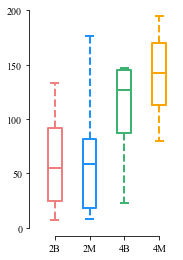

In [48]:
#plot single genen polya tail length of four sample

# FC > 2
# gene_name = 'PH02Gene00595'
# gene_name = 'PH02Gene00736'
# gene_name = 'PH02Gene01006'
# gene_name = 'PH02Gene01055'

# FC < .5erd345tm hn ghnm
gene_name = 'PH02Gene32657'
# gene_name = 'PH02Gene34751'
# gene_name = 'PH02Gene44827'



single_gene_2b_pal = polya[(polya.gene_id == gene_name) & (polya.sample_name == 'phe_2B')]['polya_length']
single_gene_2m_pal = polya[(polya.gene_id == gene_name) & (polya.sample_name == 'phe_2M')]['polya_length']
single_gene_4b_pal = polya[(polya.gene_id == gene_name) & (polya.sample_name == 'phe_4B')]['polya_length']
single_gene_4m_pal = polya[(polya.gene_id == gene_name) & (polya.sample_name == 'phe_4M')]['polya_length']

sample = [single_gene_2b_pal,single_gene_2m_pal,single_gene_4b_pal,single_gene_4m_pal]

fig, ax = plt.subplots(1,1,figsize=(2.5,4))


colors = ["lightcoral", "dodgerblue", "mediumseagreen","orange"]
colors_r = ["lightcoral", "lightcoral","dodgerblue","dodgerblue",  "mediumseagreen","mediumseagreen","orange","orange"]
labels = ["2B","2M","4B","4M"]


plt.ylim(0,200)
bplot = plt.boxplot(sample, patch_artist=False,labels=labels,widths=0.4,showfliers=False)
for patch, color in zip(bplot['medians'], colors):
    patch.set_color(color)
    patch.set_linewidth(2)
for patch, color in zip(bplot['boxes'], colors):
    patch.set_linewidth(2)
    patch.set_color(color)
for patch, color in zip(bplot['whiskers'], colors_r):
    patch.set_linewidth(2)
    patch.set_color(color)
    patch.set_linestyle('--')
for patch, color in zip(bplot['caps'], colors_r):
    patch.set_linewidth(2)
    patch.set_color(color)

y_major_locator = MultipleLocator(50)
ax.yaxis.set_major_locator(y_major_locator)

sns.despine(ax=ax,trim=True,offset=8)

print(str(len(single_gene_2b_pal)) + ' reads, ' + 'median length ' + str(np.median(single_gene_2b_pal)))
print(str(len(single_gene_2m_pal)) + ' reads, ' + 'median length ' + str(np.median(single_gene_2m_pal)))
print(str(len(single_gene_4b_pal)) + ' reads, ' + 'median length ' + str(np.median(single_gene_4b_pal)))
print(str(len(single_gene_4m_pal)) + ' reads, ' + 'median length ' + str(np.median(single_gene_4m_pal)))
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part2_polya_tail/Figure_PH02Gene32657_polya_tail.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)

In [70]:
set(diff_2b_vs_2m_df[(abs(diff_2b_vs_2m_df['log2FC']) >= np.log2(1.5)) & (diff_2b_vs_2m_df['log10pvalue'] >= -np.log10(0.05))]['gene_id']) & set(diff_2b_vs_4b_df[(abs(diff_2b_vs_4b_df['log2FC']) >= np.log2(1.5)) & (diff_2b_vs_4b_df['log10pvalue'] >= -np.log10(0.05))]['gene_id']) & set(diff_2m_vs_4m_df[(abs(diff_2m_vs_4m_df['log2FC']) >= np.log2(1.5)) & (diff_2m_vs_4m_df['log10pvalue'] >= -np.log10(0.05))]['gene_id']) & set(diff_4b_vs_4m_df[(abs(diff_4b_vs_4m_df['log2FC']) >= np.log2(1.5)) & (diff_4b_vs_4m_df['log10pvalue'] >= -np.log10(0.05))]['gene_id'])

{'PH02Gene02550', 'PH02Gene15780', 'PH02Gene24654'}

In [33]:
#output diff polya tail gene
all_diff_polya_df = [diff_2b_vs_2m_df,diff_2b_vs_4b_df,diff_2m_vs_4m_df,diff_4b_vs_4m_df]
labels = ['2b_vs_2m','2b_vs_4b','2m_vs_4m','4b_vs_4m']
for df,label in zip(all_diff_polya_df,labels):
    df = df[(abs(df['log2FC']) >= np.log2(1.5)) & (df['log10pvalue'] >= -np.log10(0.05))]  #use mwu p-value
    path = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/16_diff_polya/' + 'diff_' + label + '_gene_list_no_pi.txt'
    list_to_csv(df['gene_id'].unique(),path )

In [ ]:
fig, axes = plt.subplots(1,4,figsize=(20, 5))

for i,sample in zip(range(4),[diff_2b_vs_2m_df,diff_2b_vs_4b_df,diff_2m_vs_4m_df,diff_4b_vs_4m_df]):
    df=sample
    result = pd.DataFrame()
    result['x'] = df['log2FC']
    result['y'] = df['log10pvalue']

    #设置显著性阈值
    x_threshold=np.log2(1.5) #mean fold change >= 1.5
    y_threshold=-np.log10(0.05) #mean pvalue <= 0.05

    #分组为up, normal, down
    result['group'] = 'black'
    result.loc[(result.x > x_threshold)&(result.y > y_threshold),'group'] = 'tab:red' #x=-+x_threshold直接截断
    result.loc[(result.x < -x_threshold)&(result.y > y_threshold),'group'] = 'tab:blue' #x=-+x_threshold直接截断
    result.loc[result.y < y_threshold,'group'] = 'dimgrey' #阈值以下点为灰色

    up = len(result.loc[(result.x > x_threshold)&(result.y > y_threshold),'group'])
    down = len(result.loc[(result.x < -x_threshold)&(result.y > y_threshold),'group'])
    #确定坐标轴显示范围
    xmin=-2
    xmax=2
    ymin=0
    ymax=5

    #绘制散点图
    axes[i].set(xlim=(xmin, xmax), ylim=(ymin, ymax), title='')
    axes[i].scatter(result['x'], result['y'], s=2, color=result['group'])
    # axes[i].set_ylabel('-Log10(Q value)',fontweight='bold')
    # axes[i].set_xlabel('Log2 (fold change)',fontweight='bold')
    # axes[i].spines['right'].set_visible(False) #去掉右边框
    # axes[i].spines['top'].set_visible(False) #去掉上边框
    axes[i].set_xlabel('Log2 Fold change')
    axes[i].set_ylabel('-Log10 pvalue')

    axes[i].text(-1.5,4,"{} {}".format(down, "DOWN"),fontsize=8.5,c='tab:blue')
    axes[i].text(1.5,4,"{} {}".format(up, "UP"),fontsize=8.5,c='tab:red')
    #水平和竖直线
    axes[i].vlines(-x_threshold, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) #画竖直线
    axes[i].vlines(x_threshold, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) #画竖直线
    axes[i].hlines(y_threshold, xmin, xmax, color='dimgrey',linestyle='dashed', linewidth=1) #画竖水平线

    x_major_locator=MultipleLocator(1)
    axes[i].xaxis.set_major_locator(x_major_locator)

    #axes[i].set_xticks(range(-8,12,2)) #设置x轴刻度起点和步长
    #axes[i].set_yticks(range(-20,380,40)) #设置y轴刻度起点和步长

# plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part2_polya_tail/Figure2.1_volcano_plot_of_diff_polya_tail.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)

## **Part3 AS and APA**

### **1. Exon skipping and intron retention reads**

In [40]:
def read_ex_ir_out(ex_out_file):
    df = pd.read_csv(ex_out_file,sep='\t')
    print('{} {} {} '.format('A total of ',len(df[df.duplicated(subset='read_id',keep=False)]['read_id'].unique()),
                                ' reads span multiple genes, these reads will be discarded.'))
    #Some reads span two genes body, these reads will be discarded. 
    df.drop_duplicates(subset='read_id',keep=False,inplace=True)
    return df    

In [ ]:
ex_out = read_ex_ir_out('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/14_splicing_reads/phe_4m_ex_out.txt')
ir_out = read_ex_ir_out('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/14_splicing_reads/phe_4m_ir_out.txt')

In [8]:
splice_stat = ex_df[['read_id','exon_total_count','exon_count','skipped_exon_count','skipped_exon']].merge(ir_df[['read_id','intron_total_count','intron_count','unsplice_count','unsplice_intron']],how='left',left_on=['read_id'],right_on=['read_id'],sort=False)

In [42]:
df_list = []
samples = ['phe_shoot_2B_rep1','phe_shoot_2M_rep1','phe_shoot_4B_rep1','phe_shoot_4M_rep1']
labels = ['S-2-B', 'S-2-M', 'S-4-B', 'S-4-M']
for sample,label in zip(samples,labels):
    ex_path = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/14_splicing_reads/' + sample + '_ex_out.txt'
    ir_path = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/14_splicing_reads/' + sample + '_ir_out.txt'
    ex_df = read_ex_ir_out(ex_path)
    ir_df = read_ex_ir_out(ir_path)
    df = ex_df[['read_id','exon_total_count','exon_count','skipped_exon_count','skipped_exon']].merge(ir_df[['read_id','intron_total_count','intron_count','unsplice_count','unsplice_intron']],how='left',left_on=['read_id'],right_on=['read_id'],sort=False)
    df.loc[:,'sample'] = label
    df_list.append(df)
all_splice_stat_df = pd.concat(df_list)

A total of  15781  reads span multiple genes, these reads will be discarded. 
A total of  15781  reads span multiple genes, these reads will be discarded. 
A total of  18079  reads span multiple genes, these reads will be discarded. 
A total of  18079  reads span multiple genes, these reads will be discarded. 
A total of  13050  reads span multiple genes, these reads will be discarded. 
A total of  13050  reads span multiple genes, these reads will be discarded. 
A total of  10477  reads span multiple genes, these reads will be discarded. 
A total of  10477  reads span multiple genes, these reads will be discarded. 


In [9]:
ex_reads = splice_stat[(splice_stat['skipped_exon'].notna() & splice_stat['unsplice_intron'].isna())]['read_id']
ir_reads = splice_stat[(splice_stat['skipped_exon'].isna() & splice_stat['unsplice_intron'].notna())]['read_id']
ex_ir_reads = splice_stat[(splice_stat['skipped_exon'].notna() & splice_stat['unsplice_intron'].notna())]['read_id']
un_spliced_reads = splice_stat[(splice_stat['skipped_exon'].isna() & splice_stat['unsplice_intron'].isna())]['read_id']

### **2. Summary of alternative splicing (isoform level)**

In [37]:
all_as_list = [6675,2456,2174,2117,667,418]

In [73]:
as_dict = {}
as_types = ['RI','SE','A5','A3','AF','AL']
samples = ['2B','2M','4B','4M','all']
for sample in samples:
    as_list = []
    for as_type in as_types:
        path = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/05_AS/phe_shoot_' + sample + '_rep1_' + as_type + '_strict.ioe'
        num = len(pd.read_csv(path,sep='t'))
        as_list.append(num)
    as_dict[sample] = as_list

In [74]:
as_dict

{'2B': [6325, 1012, 770, 779, 238, 145],
 '2M': [7872, 1149, 953, 965, 264, 142],
 '4B': [5077, 783, 602, 573, 223, 140],
 '4M': [4250, 611, 507, 535, 205, 90],
 'all': [6675, 2456, 2117, 2174, 667, 418]}

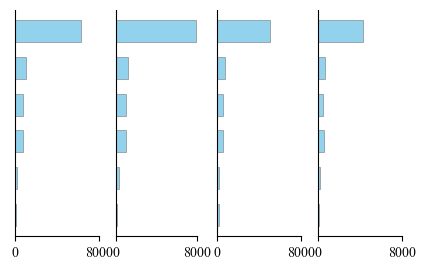

In [80]:
fig,axes = plt.subplots(1,4,figsize=(1.25*4,3))
samples = ['2B','2M','4B','4M','all']
for sample,i in zip(samples,range(4)):
    axes[i].barh(range(6), as_dict[sample][::-1],  align='center',height=.6,color='skyblue',edgecolor='dimgrey',linewidth=.4,alpha=.9)
    axes[i].spines['right'].set_visible(False) 
    axes[i].spines['top'].set_visible(False) 
    axes[i].set_yticks([])
    axes[i].set_xticks([0, 8000])
    axes[i].set_xticklabels(['0','8000'])
sns.despine(ax=axes[1],trim=True)
# axes[1].set_xticks([0, 8000])
# axes[1].set_xticklabels(['0','8000'])
# axes[1].set_xlim(0,8000)
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part1_overview/Figure2.6_AS_evnet_stat.pdf', 
format='pdf', dpi=600, bbox_inches='tight',transparent = True)

### **3. polya cleavage site cluste**

In [13]:
def read_anno_gene_level(anno_gene_level_file):
    df = pd.read_csv(anno_gene_level_file,sep='\t',header=0,index_col=0,
    dtype={'scaffold':str,'tss':int,'tts':int,'start_codon':int,'end_codon':int,'strand':str,'total_cds_length':float,'total_utr5p_length':float,'total_utr3p_length':float})
    return df

def read_anno_exon_intron_level(anno_exon_intron_level_file):
    df = pd.read_csv(anno_exon_intron_level_file,sep='\t')
    return df 

def get_last_exon_5end(gene_name,strand,anno_exon_level):
    gene_exon_df = anno_exon_level.loc[gene_name,:].copy()
    if strand == "+":
        if isinstance(gene_exon_df,pd.DataFrame):
            last_exon_5end = gene_exon_df.iloc[-1,2]
        else:
            last_exon_5end = gene_exon_df['start']
    else:
        if isinstance(gene_exon_df,pd.DataFrame):
            last_exon_5end = gene_exon_df.iloc[0,3]
        else:
            last_exon_5end = gene_exon_df['end']
    return last_exon_5end

def get_entropy(site_counter, total_count):
    '''
    Calculate the entropy of the polya site in this PAC
    '''
    entropy = 0
    for site in site_counter:
        p = site_counter[site]/total_count
        entropy += -p*np.log2(p)
    return entropy

STRAND_TO_BOOL = {'-': True, '+': False}

def get_three_end(inbam_file,anno_gene_name,scaffold,start,end,gene_strand,last_exon_5end):

    strand = STRAND_TO_BOOL[gene_strand]
    read_count = 0
    polya_cleavage_sites = []

    with pysam.AlignmentFile(inbam_file, 'rb') as inbam:
        for read in inbam.fetch(contig=scaffold, start=start, stop=end):
            # filter out reads that are strand different from gene annotations
            if strand is read.is_reverse:
                polya_length = read.get_tag('pa')
                gene_name = read.get_tag('gn')
                if polya_length != 'NA' and gene_name == anno_gene_name:
                    read_count += 1
                    if not read.is_reverse:  # reads strand is '+'
                        if read.reference_end > last_exon_5end:
                            polya_cleavage_sites.append(read.reference_end)
                    else:  # reads strand is '-'
                        if read.reference_start < last_exon_5end:
                            # It is convenient for sorting later, from small to large, from proximal to distal.
                            polya_cleavage_sites.append(read.reference_start * -1)
            
    # Select highly expressed genes
    if read_count < 10:
        return None
    if not polya_cleavage_sites:
        return None
        
    polya_cleavage_sites.sort()

    # PASs within 24 nt from each other were clustered. 
    total_site_count = len(polya_cleavage_sites)
    pac_list = None
    for polya_site in polya_cleavage_sites:
        if pac_list is None:
            pac_list = [[polya_site]]
        else:
            if polya_site-pac_list[-1][-1] <= 24:
                pac_list[-1].append(polya_site)
            else:
                pac_list.append([polya_site])
    
    num = 0
    polya_cluster = []
    for pac in pac_list:
        # Remove pac with less than 3 reads and pac whose read ratio is 
        # less than 1% of the total number of reads in the gene region
        if len(pac) < 3 or len(pac)/total_site_count < .01:
            continue

        siter_counter = Counter(pac)
        siter_counter_most = siter_counter.most_common(3)
        # Requires pac's summit to have at least 3 reads
        if siter_counter_most[0][1] >= 3:
            num += 1
            pac_start = min(abs(pac[0]), abs(pac[-1]))
            pac_end = max(abs(pac[0]), abs(pac[-1]))
            entropy = get_entropy(siter_counter,len(pac))
            summit = abs(siter_counter_most[0][0])
            # ['scaffold','gene_name_num','strand','pac_start','pac_end','summit','summit_count','pac_total_count','entropy','summit_count_ratio']
            row = [scaffold,'_'.join([anno_gene_name,str(num)]),gene_strand,pac_start,pac_end,summit,siter_counter_most[0][1],len(pac),entropy,siter_counter_most[0][1]/len(pac)]
            polya_cluster.append(row)

    return polya_cluster

In [14]:
#load pas cluste nedd annotation
anno_gene_level = read_anno_gene_level('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/02_annotation/anno_gene_level.csv')
anno_exon_intron_level = read_anno_exon_intron_level('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/02_annotation/anno_exon_intron_file.csv')
anno_exon_level = anno_exon_intron_level[anno_exon_intron_level.label.str.contains('exon',regex=False)].copy()
anno_exon_level = anno_exon_level.set_index('gene_name')

In [15]:
#get joblib parallel arg list
arg_list = []
for row in anno_gene_level.iterrows():
    gene_name = row[0]
    gene_scaffold = row[1]['scaffold']
    gene_start = min(row[1]['tss'],row[1]['tts'])
    gene_end = max(row[1]['tss'],row[1]['tts'])
    gene_strand = row[1]['strand']
    gene_laste_exon_5end = get_last_exon_5end(gene_name,gene_strand,anno_exon_level)
    arg_list.append([gene_name,gene_scaffold,gene_start,gene_end,gene_strand,gene_laste_exon_5end])

In [16]:
#tag bamfile path
phe_2b_tag_bamfile = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/19_utr_pas/01_tag_bam/phe_shoot_2B_rep1_genome_correct_2308_tag.sorted.bam'
phe_2m_tag_bamfile = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/19_utr_pas/01_tag_bam/phe_shoot_2M_rep1_genome_correct_2308_tag.sorted.bam'
phe_4b_tag_bamfile = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/19_utr_pas/01_tag_bam/phe_shoot_4B_rep1_genome_correct_2308_tag.sorted.bam'
phe_4m_tag_bamfile = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/19_utr_pas/01_tag_bam/phe_shoot_4M_rep1_genome_correct_2308_tag.sorted.bam'

In [19]:
try:
    with trange(50936) as t:
        for infile,out in zip([phe_2b_tag_bamfile,phe_2m_tag_bamfile,phe_4b_tag_bamfile,phe_4m_tag_bamfile],['2b','2m','4b','4m']):
        # for infile,out in zip([phe_2b_tag_bamfile],['2b']):
            results = Parallel(n_jobs=20)(delayed(get_three_end)(infile,arg[0],arg[1],arg[2],arg[3],arg[4],arg[5]) for arg,i in zip(arg_list,t))
            merge_result = []
            for res in results:
                if res is not None:
                    merge_result.extend(res)

            col_names = ['scaffold','gene_name_num','strand','pac_start','pac_end','summit',
                        'summit_count','pac_total_count','entropy','summit_count_ratio']
            outpath = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/19_utr_pas/02_pas_cluste/phe_' + out + '_pas.csv'

            pd.DataFrame(merge_result,columns=col_names).to_csv(outpath,sep='\t',index=False)
except:
    t.close()
    raise

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 50935/50936 [01:41<00:00, 500.02it/s]


In [9]:
rpm_2b = 1348026 / (10**6)
rpm_2m = 1450061 / (10**6)
rpm_4b = 1358986 / (10**6)
rpm_4m = 1088617 / (10**6)

In [3]:
def read_pas_cluster_file(pas_cluster_file):
    df = pd.read_csv(pas_cluster_file,sep='\t')
    return df

In [4]:
phe_pas_2b = read_pas_cluster_file('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/19_utr_pas/02_pas_cluste/phe_2b_pas.csv')
phe_pas_2m = read_pas_cluster_file('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/19_utr_pas/02_pas_cluste/phe_2m_pas.csv')
phe_pas_4b = read_pas_cluster_file('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/19_utr_pas/02_pas_cluste/phe_4b_pas.csv')
phe_pas_4m = read_pas_cluster_file('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/19_utr_pas/02_pas_cluste/phe_4m_pas.csv')

In [5]:
phe_pas_2b

scaffold    gene_name_num strand  pac_start   pac_end  \
0         hic_scaffold_16  PH02Gene00004_1      +   34796532  34796643   
1         hic_scaffold_15  PH02Gene00016_1      -   50414020  50414064   
2         hic_scaffold_15  PH02Gene00017_1      +   50427095  50427142   
3         hic_scaffold_15  PH02Gene00018_1      +   50435633  50435694   
4         hic_scaffold_15  PH02Gene00018_2      +   50435721  50435760   
...                   ...              ...    ...        ...       ...   
10573   hic_scaffold_6914  PH02Gene51011_1      +       4709      4821   
10574   hic_scaffold_6914  PH02Gene51011_2      +       4847      4858   
10575  hic_scaffold_18126  PH02Gene51039_1      -       1917      1957   
10576  hic_scaffold_13545  PH02Gene51050_1      -        623       915   
10577  hic_scaffold_12350  PH02Gene51351_1      +       2126      2146   

         summit  summit_count  pac_total_count   entropy  summit_count_ratio  \
0      34796581             3               15  3.456565            0.200000   
1      50414034             6               28  3.869331            0.214286   
2      50427127             6               16  2.608459            0.375000   
3      50435679             4               18  3.127987            0.222222   
4      50435728             4                8  2.000000            0.500000   
...         ...           ...              ...       ...                 ...   
10573      4755             9               35  3.857017            0.257143   
10574      4847             3                4  0.811278            0.750000   
10575      1932            19               34  2.537150            0.558824   
10576       699           150             1196  5.485982            0.125418   
10577      2134             3               11  2.413088            0.272727   

       median_polya_length  mean_polya_length  
0               102.750000          99.782666  
1                91.265003         100.145000  
2               132.835007         151.555001  
3                37.230000          48.993889  
4                48.020000          57.306251  
...                    ...                ...  
10573            60.540001          72.665143  
10574           164.785004         147.592503  
10575            50.525000          56.688529  
10576            93.739998          97.172483  
10577            57.889999          69.158181  

[10578 rows x 12 columns]

In [6]:
def get_gene_name(gene_name_num):
    return gene_name_num[:13]
def get_dpas_ppas(strand,summit_1,count_1,summit_2,count_2):
    summit_count = {summit_1:count_1,summit_2:count_2}
    if strand == '+':
        ppas = min(summit_1,summit_2)
        dpas = max(summit_1,summit_2)
    else:
        ppas = max(summit_1,summit_2)
        dpas = min(summit_1,summit_2)
    ppas_count = summit_count[ppas]
    dpas_count = summit_count[dpas]
    return ppas,ppas_count,dpas,dpas_count
def transform_pas_cluster(df,rpm_cf):
    df['gene_name'] = df['gene_name_num'].apply(get_gene_name)
    two_pas_gene = df[df['gene_name_num'].str.contains('_2',regex=False)]['gene_name']
    df = df[df['gene_name'].isin(two_pas_gene)]
    df = df[~df['gene_name_num'].str.contains('_3',regex=False)]
    df_1 = df[df['gene_name_num'].str.contains('_1',regex=False)].copy()
    df_2 = df[df['gene_name_num'].str.contains('_2',regex=False)].copy()
    df_1.rename(columns={'summit':'summit_1','pac_total_count':'count_1'},inplace=True)
    df_2.rename(columns={'summit':'summit_2','pac_total_count':'count_2'},inplace=True)
    df = df_1[['gene_name','scaffold','strand','summit_1','count_1']].merge(df_2[['gene_name','summit_2','count_2']],how='left',right_on='gene_name',left_on='gene_name',sort=False)
    df[['ppas','ppas_count','dpas','dpas_count']] = df.apply(lambda row : get_dpas_ppas(row['strand'],row['summit_1'],row['count_1'],row['summit_2'],row['count_2']),axis=1,result_type='expand')
    df.loc[:,'ppas_rpm'] = df['ppas_count'] / rpm_cf
    df.loc[:,'dpas_rpm'] = df['dpas_count'] / rpm_cf
    df.loc[:,'autr'] = abs(df['dpas'] - df['ppas'])
    df = df[['gene_name','scaffold','strand','ppas','ppas_count','ppas_rpm','dpas','dpas_count','dpas_rpm','autr']]
    return df

In [10]:
phe_pas_2b_rpm = transform_pas_cluster(phe_pas_2b,rpm_2b)
phe_pas_2m_rpm = transform_pas_cluster(phe_pas_2m,rpm_2m)
phe_pas_4b_rpm = transform_pas_cluster(phe_pas_4b,rpm_4b)
phe_pas_4m_rpm = transform_pas_cluster(phe_pas_4m,rpm_4m)

In [11]:
phe_pas_2b_rpm = phe_pas_2b_rpm.rename(columns={'ppas_rpm':'2b_ppas_rpm','dpas_rpm':'2b_dpas_rpm'})[['gene_name','2b_ppas_rpm','2b_dpas_rpm','autr']]
phe_pas_2m_rpm = phe_pas_2m_rpm.rename(columns={'ppas_rpm':'2m_ppas_rpm','dpas_rpm':'2m_dpas_rpm'})[['gene_name','2m_ppas_rpm','2m_dpas_rpm','autr']]
phe_pas_4b_rpm = phe_pas_4b_rpm.rename(columns={'ppas_rpm':'4b_ppas_rpm','dpas_rpm':'4b_dpas_rpm'})[['gene_name','4b_ppas_rpm','4b_dpas_rpm','autr']]
phe_pas_4m_rpm = phe_pas_4m_rpm.rename(columns={'ppas_rpm':'4m_ppas_rpm','dpas_rpm':'4m_dpas_rpm'})[['gene_name','4m_ppas_rpm','4m_dpas_rpm','autr']]

In [12]:
phe_pas_2b_2m = phe_pas_2b_rpm.merge(phe_pas_2m_rpm,how='inner',left_on='gene_name',right_on='gene_name',sort=False)
phe_pas_2b_4b = phe_pas_2b_rpm.merge(phe_pas_4b_rpm,how='inner',left_on='gene_name',right_on='gene_name',sort=False)
phe_pas_2m_4m = phe_pas_2m_rpm.merge(phe_pas_4m_rpm,how='inner',left_on='gene_name',right_on='gene_name',sort=False)
phe_pas_4b_4m = phe_pas_4b_rpm.merge(phe_pas_4m_rpm,how='inner',left_on='gene_name',right_on='gene_name',sort=False)

In [13]:
phe_pas_2b_2m['ppas_log_ratio'] = np.log2(phe_pas_2b_2m['2b_ppas_rpm'] / phe_pas_2b_2m['2m_ppas_rpm'])
phe_pas_2b_2m['dpas_log_ratio'] = np.log2(phe_pas_2b_2m['2b_dpas_rpm'] / phe_pas_2b_2m['2m_dpas_rpm'])
phe_pas_2b_4b['ppas_log_ratio'] = np.log2(phe_pas_2b_4b['2b_ppas_rpm'] / phe_pas_2b_4b['4b_ppas_rpm'])
phe_pas_2b_4b['dpas_log_ratio'] = np.log2(phe_pas_2b_4b['2b_dpas_rpm'] / phe_pas_2b_4b['4b_dpas_rpm'])
phe_pas_2m_4m['ppas_log_ratio'] = np.log2(phe_pas_2m_4m['2m_ppas_rpm'] / phe_pas_2m_4m['4m_ppas_rpm'])
phe_pas_2m_4m['dpas_log_ratio'] = np.log2(phe_pas_2m_4m['2m_dpas_rpm'] / phe_pas_2m_4m['4m_dpas_rpm'])
phe_pas_4b_4m['ppas_log_ratio'] = np.log2(phe_pas_4b_4m['4b_ppas_rpm'] / phe_pas_4b_4m['4m_ppas_rpm'])
phe_pas_4b_4m['dpas_log_ratio'] = np.log2(phe_pas_4b_4m['4b_dpas_rpm'] / phe_pas_4b_4m['4m_dpas_rpm'])

In [40]:
# def get_up_down(ppas_log_ratio,dpas_log_ratio):
#     if ppas_log_ratio < np.log(1/1.2) and  dpas_log_ratio > np.log2(1.2):
#         return 'length'
#     elif ppas_log_ratio > np.log(1.2) and dpas_log_ratio < np.log(1/1.2):
#         return 'short'
#     else:
#         return 'unchange'

In [14]:
def get_up_down(ppas_log_ratio,dpas_log_ratio):
    if (ppas_log_ratio - dpas_log_ratio) > 0.3:
        return 'short'
    elif (ppas_log_ratio - dpas_log_ratio) < -0.3:
        return 'length'
    else:
        return 'unchange'

In [15]:
phe_pas_2b_2m['type'] = phe_pas_2b_2m.apply(lambda row : get_up_down(row['ppas_log_ratio'],row['dpas_log_ratio']),axis=1)
phe_pas_2b_4b['type'] = phe_pas_2b_4b.apply(lambda row : get_up_down(row['ppas_log_ratio'],row['dpas_log_ratio']),axis=1)
phe_pas_2m_4m['type'] = phe_pas_2m_4m.apply(lambda row : get_up_down(row['ppas_log_ratio'],row['dpas_log_ratio']),axis=1)
phe_pas_4b_4m['type'] = phe_pas_4b_4m.apply(lambda row : get_up_down(row['ppas_log_ratio'],row['dpas_log_ratio']),axis=1)

#### **(1). Scatter plot showing expression change of dPAS and pPAS**

In [16]:
np.log2(1.5)
np.log2(2/3)

-0.5849625007211563

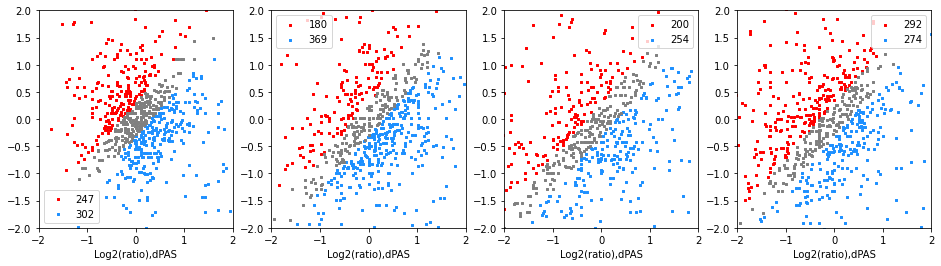

In [58]:
fig, axes = plt.subplots(1,4,figsize=(16,4))
samples = [phe_pas_2b_2m,phe_pas_2b_4b,phe_pas_2m_4m,phe_pas_4b_4m]
# labels = [('2b_mod_ratio','2m_mod_ratio'),('4b_mod_ratio','4m_mod_ratio'),('2b_mod_ratio','4b_mod_ratio'),('2m_mod_ratio','4m_mod_ratio')]
for sample,i in zip(samples,range(4)):
    axes[i].scatter(sample[sample.type == 'length']['ppas_log_ratio'],sample[sample.type == 'length']['dpas_log_ratio'],color='red',marker="s",s=2,label=len(sample[sample.type == 'length']))
    axes[i].scatter(sample[sample.type == 'short']['ppas_log_ratio'],sample[sample.type == 'short']['dpas_log_ratio'],color='dodgerblue',marker="s",s=2,label=len(sample[sample.type == 'short']))
    axes[i].scatter(sample[sample.type == 'unchange']['ppas_log_ratio'],sample[sample.type == 'unchange']['dpas_log_ratio'],color='grey',marker="s",s=2)
    axes[i].set_ylim(-2,2)
    axes[i].set_xlim(-2,2)
    axes[i].set_xlabel('Log2(ratio),pPAS')
    axes[i].set_xlabel('Log2(ratio),dPAS')
    axes[i].legend()
# plt.subplots_adjust(left=0, right=1, top=1, bottom=0,wspace=.5, hspace=1)

#### **(2). Relative expression difference(RED) plot**

In [151]:
#RED
phe_pas_2b_2m['red'] = np.log2(phe_pas_2b_2m['2b_dpas_rpm'] / phe_pas_2b_2m['2b_ppas_rpm']) - np.log2(phe_pas_2b_2m['2m_dpas_rpm'] / phe_pas_2b_2m['2m_ppas_rpm'])
phe_pas_2b_4b['red'] = np.log2(phe_pas_2b_4b['2b_dpas_rpm'] / phe_pas_2b_4b['2b_ppas_rpm']) - np.log2(phe_pas_2b_4b['4b_dpas_rpm'] / phe_pas_2b_4b['4b_ppas_rpm'])
phe_pas_2m_4m['red'] = np.log2(phe_pas_2m_4m['2m_dpas_rpm'] / phe_pas_2m_4m['2m_ppas_rpm']) - np.log2(phe_pas_2m_4m['4m_dpas_rpm'] / phe_pas_2m_4m['4m_ppas_rpm'])
phe_pas_4b_4m['red'] = np.log2(phe_pas_4b_4m['4b_dpas_rpm'] / phe_pas_4b_4m['4b_ppas_rpm']) - np.log2(phe_pas_4b_4m['4m_dpas_rpm'] / phe_pas_4b_4m['4m_ppas_rpm'])

(-0.4, 0.1)

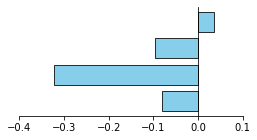

In [122]:
fig, ax = plt.subplots(1,1,figsize=(4,2))
# ax=fig.add_axes([0,0,2,2])
ax.barh(range(4),reds,height=.75,color='skyblue',edgecolor='black',linewidth=.8)
# sns.despine(ax = ax,trim=True,offset=0)
ax.spines['left'].set_position('zero')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
y_major_locator = MultipleLocator(1.5)
x_major_locator = MultipleLocator(0.1)
ax.yaxis.set_major_locator(y_major_locator)
ax.xaxis.set_major_locator(x_major_locator)
ax.set_yticks([])
ax.set_xlim(-0.4,0.1)

#### **(3). Alternative UTR and RED**

In [154]:
# pd.qcut(phe_all_illu_cp[phe_all_illu_cp[sample_label] != 0][sample_label],100,labels=range(100))
phe_pas_2b_2m['utr_delta'] = abs(phe_pas_2b_2m['autr_x'] - phe_pas_2b_2m['autr_y']) 

In [157]:
phe_pas_2b_2m[phe_pas_2b_2m['utr_delta'] < 50]

gene_name  2b_ppas_rpm  2b_dpas_rpm  autr_x  2m_ppas_rpm  \
0    PH02Gene00026   117.950247    11.127382     186    84.824018   
1    PH02Gene00089   698.799578     7.418255   91167   592.388872   
2    PH02Gene00090   172.103505    31.156669   29817   161.372522   
3    PH02Gene00150    18.545636   445.095273      71    13.792523   
4    PH02Gene00159   158.008822    37.833098     101   190.336820   
..             ...          ...          ...     ...          ...   
785  PH02Gene49311    11.869207    34.865796      89     8.275514   
786  PH02Gene49316     7.418255     9.643731     157     9.654766   
787  PH02Gene49578    37.833098     5.934604      83     4.137757   
789  PH02Gene49721    31.156669    30.414844    9158    16.551028   
790  PH02Gene50303    17.803811     4.450953     173    16.551028   

     2m_dpas_rpm  autr_y  ppas_log_ratio  dpas_log_ratio       red  utr_delta  
0       8.965140     187        0.475634        0.311716 -0.163918          1  
1      16.551028   91167        0.238334       -1.157769 -1.396103          0  
2      12.413271   29805        0.092882        1.327658  1.234776         12  
3     374.467005      71        0.427193        0.249276 -0.177918          0  
4      53.101214     101       -0.268550       -0.489096 -0.220546          0  
..           ...     ...             ...             ...       ...        ...  
785    28.964299      90        0.520303        0.267537 -0.252766          1  
786    10.344392     155       -0.380162       -0.101186  0.278976          2  
787    31.033177      87        3.192728       -2.386588 -5.579316          4  
789    10.344392    9185        0.912620        1.555927  0.643306         27  
790     4.137757     176        0.105265        0.105265  0.000000          3  

[658 rows x 11 columns]

In [ ]:
phe_pas_4b_4m['range_x'] = pd.qcut(phe_pas_4b_4m['autr_x'],5,range(5))

In [168]:
phe_pas_2b_2m['range_x'] = pd.qcut(phe_pas_2b_2m['autr_x'],5,range(5))
phe_pas_2b_4b['range_x'] = pd.qcut(phe_pas_2b_4b['autr_x'],5,range(5))
phe_pas_2m_4m['range_x'] = pd.qcut(phe_pas_2m_4m['autr_x'],5,range(5))
phe_pas_4b_4m['range_x'] = pd.qcut(phe_pas_4b_4m['autr_x'],5,range(5))

In [180]:
med_list = []
for n,sample in zip(range(5),[phe_pas_2b_2m,phe_pas_2b_4b,phe_pas_2m_4m,phe_pas_4b_4m]):
    med_list.append([])
    for i in [[0,119],[119,346],[347,828],[829,1642],[1642,100000000]]:
        med_list[n].append(np.median(sample[(sample.autr_x > i[0]) & (sample.autr_x < i[1])]['red']))

/home/litao/miniconda3/envs/jupyter-remote/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/litao/miniconda3/envs/jupyter-remote/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#### **(4). aUTR to BED**

In [34]:
def get_start_end(ppas,dpas):
    start = min(ppas,dpas)
    end = max(ppas,dpas)
    return start,end
def get_autr_bed(phe_pas_rpm,output):
    df = pd.DataFrame()
    df['scaffold'] = phe_pas_rpm['scaffold']
    df[['start','end']] = phe_pas_rpm.apply(lambda row : get_start_end(row['ppas'],row['dpas']),axis=1,result_type='expand')
    df['name'] = phe_pas_rpm['gene_name']
    df.to_csv(output,index=False,sep='\t',header=False)

In [35]:
get_autr_bed(phe_pas_2b_rpm,'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/19_utr_pas/03_autr/phe_2b_autr.bed')
get_autr_bed(phe_pas_2m_rpm,'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/19_utr_pas/03_autr/phe_2m_autr.bed')
get_autr_bed(phe_pas_4b_rpm,'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/19_utr_pas/03_autr/phe_4b_autr.bed')
get_autr_bed(phe_pas_4m_rpm,'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/19_utr_pas/03_autr/phe_4m_autr.bed')

In [13]:
phe_pas_2b

scaffold    gene_name_num strand  pac_start   pac_end  \
0         hic_scaffold_16  PH02Gene00004_1      +   34796532  34796643   
1         hic_scaffold_15  PH02Gene00016_1      -   50414020  50414064   
2         hic_scaffold_15  PH02Gene00017_1      +   50427095  50427142   
3         hic_scaffold_15  PH02Gene00018_1      +   50435633  50435694   
4         hic_scaffold_15  PH02Gene00018_2      +   50435721  50435760   
...                   ...              ...    ...        ...       ...   
10573   hic_scaffold_6914  PH02Gene51011_1      +       4709      4821   
10574   hic_scaffold_6914  PH02Gene51011_2      +       4847      4858   
10575  hic_scaffold_18126  PH02Gene51039_1      -       1917      1957   
10576  hic_scaffold_13545  PH02Gene51050_1      -        623       915   
10577  hic_scaffold_12350  PH02Gene51351_1      +       2126      2146   

         summit  summit_count  pac_total_count   entropy  summit_count_ratio  \
0      34796581             3               15  3.456565            0.200000   
1      50414034             6               28  3.869331            0.214286   
2      50427127             6               16  2.608459            0.375000   
3      50435679             4               18  3.127987            0.222222   
4      50435728             4                8  2.000000            0.500000   
...         ...           ...              ...       ...                 ...   
10573      4755             9               35  3.857017            0.257143   
10574      4847             3                4  0.811278            0.750000   
10575      1932            19               34  2.537150            0.558824   
10576       699           150             1196  5.485982            0.125418   
10577      2134             3               11  2.413088            0.272727   

           gene_name  
0      PH02Gene00004  
1      PH02Gene00016  
2      PH02Gene00017  
3      PH02Gene00018  
4      PH02Gene00018  
...              ...  
10573  PH02Gene51011  
10574  PH02Gene51011  
10575  PH02Gene51039  
10576  PH02Gene51050  
10577  PH02Gene51351  

[10578 rows x 11 columns]

## **Part4 N6-methyladenosine (m<sup>6</sup>A) modification**

### **1. Define function and load related file**

In [2]:
# def ratio_to_dataframe(ratio_file,output_file_path):
#     """Convert nanom6a output ratio file to dataframe-easy format.

#     Args:
#         ratio_file (file): nanom6A output file 'ratio.0.5.tsv'
#         output_file_path : output file path
#     Tips:    
#         deatframe-easy format is csv file
#         header = 'position','mod_num','total_num','mod_ratio','gene_name','scaffold'
#     """
#     gene_mod_df_list = []
#     position = []
#     mod_num = []
#     total_num = []
#     mod_ratio = []
#     with open(ratio_file,'r') as ratio:
#         for line in ratio:
#             line_list = line.split()
#             gene_name = line_list[0].split('|')[0]
#             scaffold = line_list[0].split('|')[1]
#             for site in line_list[1:]:
#                 site_list = site.split('|')
#                 position.append(site_list[0])
#                 mod_num.append(site_list[1])
#                 total_num.append(site_list[2])
#                 mod_ratio.append(site_list[3])
#             gene_mod_df_tem = pd.DataFrame({'position':position,'mod_num':mod_num,'total_num':total_num,'mod_ratio':mod_ratio})
#             gene_mod_df_tem.loc[:,'gene_name'] = gene_name
#             gene_mod_df_tem.loc[:,'scaffold'] = scaffold
#             gene_mod_df_list.append(gene_mod_df_tem)
#             position.clear()
#             mod_num.clear()
#             total_num.clear()
#             mod_ratio.clear()
#     gene_mod_df = pd.concat(gene_mod_df_list)
#     gene_mod_df = gene_mod_df[['gene_name','scaffold','position','mod_num','total_num','mod_ratio']]
#     gene_mod_df.to_csv(output_file_path,sep='\t',index=False)

In [30]:
# Classification of modified sites
def intron_TSS_TTS_decide(position,gene_name,anno_gene_level):
    if anno_gene_level.loc[gene_name,'strand'] == "+":
        if position > anno_gene_level.loc[gene_name,'TTS']:
            return 'TTS_DOWN'
        elif position < anno_gene_level.loc[gene_name,'TSS']:
            return 'TSS_UP'
        else:
            return 'intron'
    else:
        if position < anno_gene_level.loc[gene_name,'TTS']:
            return 'TTS_DOWN'
        elif position > anno_gene_level.loc[gene_name,'TSS']:
            return 'TSS_UP'
        else:
            return 'intron'

#Classification of modified sites according to CDS/UTR5P/UTR3P/intron/TSS_UP/TSS_DOWN
def mod_site_classification(anno_gene_level,anno_cds_level,ratio_df):
    
    agg_list = []
    gene_names = ratio_df.gene_name.unique()

    #Classification of modified sites according to CDS/UTR5P/UTR3P/intron/TSS_UP/TSS_DOWN
    anno_cds_level_no_exon = anno_cds_level.drop(anno_cds_level[anno_cds_level.label.str.contains('exon',regex=False)].index).copy()
    anno_groups_no_exon = anno_cds_level_no_exon.groupby('gene_name')
    #Classification of modified sites only according to exon
    anno_cds_level_only_exon = anno_cds_level[anno_cds_level.label.str.contains('exon',regex=False)].copy()
    anno_gropus_only_exon = anno_cds_level_only_exon.groupby('gene_name')

    ratio_groups = ratio_df.groupby('gene_name')
    try:
        with trange(len(gene_names)) as t:
            for gene_name,i in zip(gene_names,t):
                ratio_df_part = ratio_groups.get_group(gene_name).copy()
                #CDS
                anno_part_cds = anno_groups_no_exon.get_group(gene_name)
                bins_cds = pd.IntervalIndex.from_tuples(list(zip(anno_part_cds.start,anno_part_cds.end)),closed='both')
                x_cds = pd.cut(ratio_df_part.position.to_list(),bins_cds)
                x_cds.categories = list(anno_part_cds.label)
                ratio_df_part.loc[:,'label'] = x_cds
                #exon
                anno_part_exon = anno_gropus_only_exon.get_group(gene_name)
                bins_exon = pd.IntervalIndex.from_tuples(list(zip(anno_part_exon.start,anno_part_exon.end)),closed='both')
                try:
                    x_exon = pd.cut(ratio_df_part.position.to_list(),bins_exon)
                except ValueError:
                    print(gene_name)
                    print(bins_exon)
                    raise
                x_exon.categories = list(anno_part_exon.label)
                ratio_df_part.loc[:,'exon_label'] = x_exon

                agg_list.append(ratio_df_part)
 
    except KeyboardInterrupt:
        t.close()
        raise
    t.close()
    df_all = pd.concat(agg_list)

    df_na = df_all[df_all.label.isna()].copy()
    df_na.drop(['label'],axis=1)
    df_na.loc[:,'label'] = df_na.apply(lambda row : intron_TSS_TTS_decide(row['position'],row['gene_name'],anno_gene_level),axis=1)
    df_all.update(df_na,overwrite=False)

    df_all.loc[:,'label_group'] = df_all.label.apply(get_group_label)
    df_all = df_all.merge(anno_gene_level.strand,how='left',left_on='gene_name',right_index=True,sort=False)
    
    return df_all
     


In [11]:
def read_ratio_file(dataframe_easy_ratio_file,read_min):
    df = pd.read_csv(dataframe_easy_ratio_file,sep='\t',
                dtype={'gene_name':str,'scaffold':str,'position':int,'mod_num':int,'total_num':int,'mod_ratio':float})
    df.dropna(subset=['gene_name'],inplace=True)  #过滤没有匹配到基因的修饰位点
    df.drop(df[df.mod_num < read_min].index,inplace=True)  #过滤掉少于20个reads支持的修饰位点
    print('{} {} {} {} {}'.format('A total of',df.duplicated(subset=['scaffold','position'],keep='first').sum(),
    'sites are assigned to multiple genes, these sites will be deleted (Filter threshold =',read_min,'read).'))
    df.drop_duplicates(subset=['scaffold','position'],keep=False,inplace=True)  #某些修饰位点会同时分配给两个基因，这些位点将全部被删除
    return df

In [11]:
# Convert nanom6a output ratio file to dataframe-easy format
# ratio_to_dataframe(phe_2b_m6a_ratio_file,'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/11_m6A/phe_2b_m6a_ratio_file.csv')
# ratio_to_dataframe(phe_2m_m6a_ratio_file,'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/11_m6A/phe_2m_m6a_ratio_file.csv')
# ratio_to_dataframe(phe_4m_m6a_ratio_file,'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/11_m6A/phe_4m_m6a_ratio_file.csv')
# ratio_to_dataframe(phe_4b_m6a_ratio_file,'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/11_m6A/phe_4b_m6a_ratio_file.csv')
#ratio_to_dataframe(phe_all_m6a_ratio_file,'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/11_m6A/phe_all_m6a_ratio_file.csv')

In [11]:
# Load dataframe-easy format nanom6a ratio file
# phe_2b_ratio_df = read_ratio_file(phe_2b_nanom6a_ratio_file,20)
# phe_2m_ratio_df = read_ratio_file(phe_2m_nanom6a_ratio_file,20)
# phe_4b_ratio_df = read_ratio_file(phe_4b_nanom6a_ratio_file,20)
# phe_4m_ratio_df = read_ratio_file(phe_4m_nanom6a_ratio_file,20)
# phe_all_ratio_df = read_ratio_file(phe_all_nanom6a_ratio_file,20)

# Classification of modified sites
# phe_2b_ratio_df = mod_site_classification(anno_gene_level,anno_cds_level,phe_2b_ratio_df)
# phe_2m_ratio_df = mod_site_classification(anno_gene_level,anno_cds_level,phe_2m_ratio_df)
# phe_4b_ratio_df = mod_site_classification(anno_gene_level,anno_cds_level,phe_4b_ratio_df)
# phe_4m_ratio_df = mod_site_classification(anno_gene_level,anno_cds_level,phe_4m_ratio_df)
# phe_all_ratio_df = mod_site_classification(anno_gene_level,anno_cds_level,phe_all_ratio_df)

In [12]:
#dataframe to csv
# phe_2b_ratio_df.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/11_m6A/phe_2b_ratio_df.csv',sep='\t',index=False)
# phe_2m_ratio_df.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/11_m6A/phe_2m_ratio_df.csv',sep='\t',index=False)
# phe_4b_ratio_df.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/11_m6A/phe_4b_ratio_df.csv',sep='\t',index=False)
# phe_4m_ratio_df.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/11_m6A/phe_4m_ratio_df.csv',sep='\t',index=False)
# phe_all_ratio_df.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/11_m6A/phe_all_ratio_df.csv',sep='\t',index=False)

In [3]:
def read_ratio_df(ratio_df_file):
    df = pd.read_csv(ratio_df_file,sep='\t',
    dtype={'gene_name':str,'scaffold':str,'position':int,'mod_num':int,'total_num':int,'mod_ratio':float,'label':str,'exon_label':str,'label_group':str,'strand':str})
    num = len(df[df.mod_ratio > 1])
    df = df[df.mod_ratio <= 1]   #Filter out sites with a modification ratio greater than 1. (may be a nanom6a bug)
    print('{} {} {} '.format('Tips: A total of',num,
    'sites with a modification ratio greater than 1 will be filtered out. (Nanom6A may output some sites with a modification ratio greater than 1, which may be a bug)'))
    return df

In [4]:
phe_2b_ratio_df = read_ratio_df('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/11_m6A/phe_2b_ratio_df.csv')
phe_2m_ratio_df = read_ratio_df('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/11_m6A/phe_2m_ratio_df.csv')
phe_4b_ratio_df = read_ratio_df('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/11_m6A/phe_4b_ratio_df.csv')
phe_4m_ratio_df = read_ratio_df('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/11_m6A/phe_4m_ratio_df.csv')
phe_all_ratio_df = read_ratio_df('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/11_m6A/phe_all_ratio_df.csv')

Tips: A total of 14 sites with a modification ratio greater than 1 will be filtered out. (Nanom6A may output some sites with a modification ratio greater than 1, which may be a bug) 
Tips: A total of 15 sites with a modification ratio greater than 1 will be filtered out. (Nanom6A may output some sites with a modification ratio greater than 1, which may be a bug) 
Tips: A total of 13 sites with a modification ratio greater than 1 will be filtered out. (Nanom6A may output some sites with a modification ratio greater than 1, which may be a bug) 
Tips: A total of 15 sites with a modification ratio greater than 1 will be filtered out. (Nanom6A may output some sites with a modification ratio greater than 1, which may be a bug) 
Tips: A total of 111 sites with a modification ratio greater than 1 will be filtered out. (Nanom6A may output some sites with a modification ratio greater than 1, which may be a bug) 


In [36]:
phe_2b_ratio_df

gene_name         scaffold  position  mod_num  total_num  \
0      PH02Gene48954  hic_scaffold_17  63713104       22         77   
1      PH02Gene48954  hic_scaffold_17  63714088       26         84   
2      PH02Gene48954  hic_scaffold_17  63714115       25         85   
3      PH02Gene48954  hic_scaffold_17  63716879       24         87   
4      PH02Gene48954  hic_scaffold_17  63717921       51         97   
...              ...              ...       ...      ...        ...   
23322  PH02Gene22186  hic_scaffold_14  33940101       37         60   
23323  PH02Gene03117   hic_scaffold_7  33374432       21         59   
23324  PH02Gene45779  hic_scaffold_24  11402595       65        250   
23325  PH02Gene24469  hic_scaffold_24  47495876       24         56   
23326  PH02Gene22502   hic_scaffold_6  33983815       45        125   

       mod_ratio label exon_label label_group strand  
0       0.285714  cds1      exon1         cds      +  
1       0.309524  cds2      exon2         cds      +  
2       0.294118  cds2      exon2         cds      +  
3       0.275862  cds4      exon4         cds      +  
4       0.525773  cds5      exon5         cds      +  
...          ...   ...        ...         ...    ...  
23322   0.616667  cds1      exon1         cds      -  
23323   0.355932  cds1      exon1         cds      -  
23324   0.260000  cds2      exon2         cds      +  
23325   0.428571  cds2      exon2         cds      -  
23326   0.360000  cds3      exon3         cds      -  

[23313 rows x 10 columns]

In [26]:
print(len(phe_2b_ratio_df.gene_name.unique()))
print(len(phe_2m_ratio_df.gene_name.unique()))
print(len(phe_4b_ratio_df.gene_name.unique()))
print(len(phe_4m_ratio_df.gene_name.unique()))

5272
5710
4925
4099


### **2. CMS/SMS of m<sup>6</sup>A modification site**

#### **(1) Venn and box plot of m<sup>6</sup>A modification site**

<AxesSubplot:>

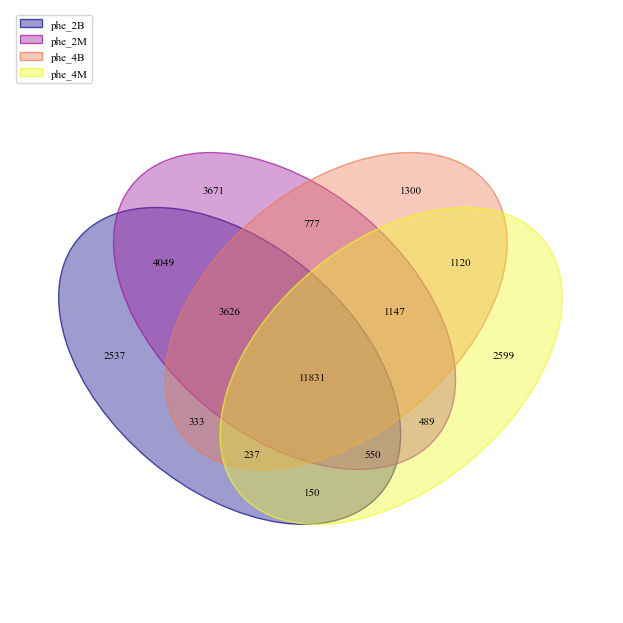

In [10]:
#Figure4.2.1 mod_site_venn_plot
phe_2b_scaffold_pos = set(zip(phe_2b_ratio_df.scaffold,phe_2b_ratio_df.position))
phe_2m_scaffold_pos = set(zip(phe_2m_ratio_df.scaffold,phe_2m_ratio_df.position))
phe_4b_scaffold_pos = set(zip(phe_4b_ratio_df.scaffold,phe_4b_ratio_df.position))
phe_4m_scaffold_pos = set(zip(phe_4m_ratio_df.scaffold,phe_4m_ratio_df.position))
cmap = ["cool", list("rgb"), "plasma", "viridis", "Set1"]
data_dict = {"phe_2B":phe_2b_scaffold_pos,"phe_2M":phe_2m_scaffold_pos,"phe_4B":phe_4b_scaffold_pos,"phe_4M":phe_4m_scaffold_pos}
venn(data_dict,fontsize=8, legend_loc="upper left",cmap="plasma")   #data_dict Must be a set (that is, no duplicates)
#venn(data_dict,fmt="{percentage:.1f}%",fontsize=8, legend_loc="upper left",cmap="plasma")   #Show percentage
# plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part4_m6a/Figure4.1_mod_site_venn_plot.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)
# plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part4_m6a/Figure4.1_mod_site_venn_plot.svg', format='svg', dpi=600, bbox_inches='tight',transparent = True)

<AxesSubplot:>

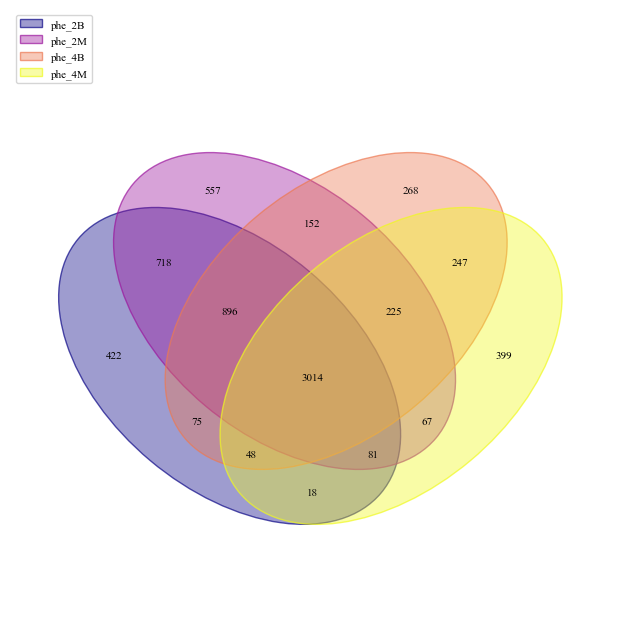

In [11]:
#Figure2.2 mod_gene_venn_plot
phe_2b_mod_gene = set(phe_2b_ratio_df.gene_name.unique())
phe_2m_mod_gene = set(phe_2m_ratio_df.gene_name.unique())
phe_4b_mod_gene = set(phe_4b_ratio_df.gene_name.unique())
phe_4m_mod_gene = set(phe_4m_ratio_df.gene_name.unique())
cmap = ["cool", list("rgb"), "plasma", "viridis", "Set1"]
data_dict = {"phe_2B":phe_2b_mod_gene,"phe_2M":phe_2m_mod_gene,"phe_4B":phe_4b_mod_gene,"phe_4M":phe_4m_mod_gene}
venn(data_dict,fontsize=8, legend_loc="upper left",cmap="plasma") 
# plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part4_m6a/Figure4.2_mod_gene_venn_plot.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)
# plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part4_m6a/Figure4.2_mod_gene_venn_plot.svg', format='svg', dpi=600, bbox_inches='tight',transparent = True)

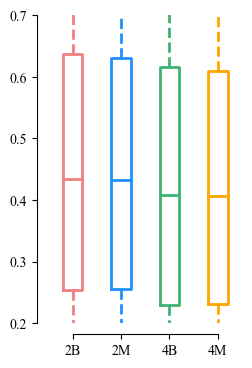

In [53]:
#Figure4.2.3 m6a_modification_ration_box_plot
phe_2b_mod_ratio = phe_2b_ratio_df.mod_ratio
phe_2m_mod_ratio = phe_2m_ratio_df.mod_ratio
phe_4b_mod_ratio = phe_4b_ratio_df.mod_ratio
phe_4m_mod_ratio = phe_4m_ratio_df.mod_ratio
fig = plt.figure(figsize=(2.5,4))  
ax = plt.subplot()  
sample = [phe_2b_mod_ratio,phe_2m_mod_ratio,phe_4b_mod_ratio,phe_4m_mod_ratio]
colors = ["lightcoral", "dodgerblue", "mediumseagreen","orange"]
colors_r = ["lightcoral", "lightcoral","dodgerblue","dodgerblue",  "mediumseagreen","mediumseagreen","orange","orange"]
labels = ["2B","2M","4B","4M"]

plt.ylim(0.2,0.7)
bplot = plt.boxplot(sample, patch_artist=False, labels=labels,widths=0.4)
for patch, color in zip(bplot['medians'], colors):
    patch.set_color(color)
    patch.set_linewidth(2)
for patch, color in zip(bplot['boxes'], colors):
    patch.set_linewidth(2)
    patch.set_color(color)
for patch, color in zip(bplot['whiskers'], colors_r):
    patch.set_linewidth(2)
    patch.set_color(color)
    patch.set_linestyle('--')

# ax = plt.gca()
# ax.spines['top'].set_color('none')
# ax.spines['right'].set_color('none') 
# adjust_spines(ax, ['left', 'bottom'])

sns.despine(ax=ax,trim=True,offset=8)
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part4_m6a/Figure4.3_m6a_modification_ration_box_plot.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part4_m6a/Figure4.3_m6a_modification_ration_box_plot.ps', format='ps', dpi=600, bbox_inches='tight',transparent = True)

In [41]:
#Calculate mod-ratio confidence interval and median value.
mod_ratio_CIs = pd.DataFrame()
mod_ratio_CIs['2B'] = phe_2b_ratio_df.mod_ratio.describe(percentiles=(0.025, 0.25, 0.50, 0.75, 0.975))
mod_ratio_CIs['2M'] = phe_2m_ratio_df.mod_ratio.describe(percentiles=(0.025, 0.25, 0.50, 0.75, 0.975))
mod_ratio_CIs['4B'] = phe_4b_ratio_df.mod_ratio.describe(percentiles=(0.025, 0.25, 0.50, 0.75, 0.975))
mod_ratio_CIs['4M'] = phe_4m_ratio_df.mod_ratio.describe(percentiles=(0.025, 0.25, 0.50, 0.75, 0.975))

In [42]:
mod_ratio_CIs

2B            2M            4B            4M
count  23313.000000  26140.000000  20371.000000  18123.000000
mean       0.451254      0.450030      0.430879      0.429794
std        0.238703      0.237284      0.239510      0.237866
min        0.005705      0.006464      0.005563      0.018373
2.5%       0.068492      0.069247      0.062967      0.067393
25%        0.253676      0.254717      0.229233      0.230461
50%        0.434783      0.431818      0.408462      0.405797
75%        0.636364      0.630435      0.615385      0.608696
97.5%      0.909091      0.909091      0.897828      0.903495
max        1.000000      1.000000      1.000000      1.000000

In [7]:
# export all modification gene name
# list_to_csv(phe_2b_ratio_df['gene_name'].unique(),'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/01_go/phe_2b_mod_gene.csv')
# list_to_csv(phe_2m_ratio_df['gene_name'].unique(),'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/01_go/phe_2m_mod_gene.csv')
# list_to_csv(phe_4b_ratio_df['gene_name'].unique(),'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/01_go/phe_4b_mod_gene.csv')
# list_to_csv(phe_4m_ratio_df['gene_name'].unique(),'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/01_go/phe_4m_mod_gene.csv')
list_to_csv(phe_all_ratio_df['gene_name'].unique(),'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/01_go/phe_all_mod_gene.csv')

#### **(2) Distinct features of CMS/SMS during fast-growth of the moso bamboo**

* **CMG/CMS** Genes that are modified in two different single internode regions that grow rapidly at two different heights as constitutive methylation genes/site(CMG/CMS)
* **SMG/SMS** Genes that are specifically modified only in a certain area during a certain period of rapid growth are called specifically methylation gene/site(CMG/SMS)



In [12]:
#CMS/SMS
cms = phe_2b_scaffold_pos & phe_2m_scaffold_pos & phe_4b_scaffold_pos & phe_4m_scaffold_pos
sms_2b = list(phe_2b_scaffold_pos - (phe_2m_scaffold_pos | phe_4b_scaffold_pos | phe_4m_scaffold_pos))
sms_2m = list(phe_2m_scaffold_pos - (phe_2b_scaffold_pos | phe_4b_scaffold_pos | phe_4m_scaffold_pos))
sms_4b = list(phe_4b_scaffold_pos - (phe_2b_scaffold_pos | phe_2m_scaffold_pos | phe_4m_scaffold_pos))
sms_4m = list(phe_4m_scaffold_pos - (phe_2b_scaffold_pos | phe_2m_scaffold_pos | phe_4b_scaffold_pos))

In [13]:
#df = df[pd.Series(list(zip(df.A, df.B)), index=df.index).isin(AB_col)]  Filter pandas dataframe from tuples
#SMS ratio dataframe 
sms_2b_ratio_df = phe_2b_ratio_df[pd.Series(list(zip(phe_2b_ratio_df.scaffold, phe_2b_ratio_df.position)),index=phe_2b_ratio_df.index).isin(sms_2b)].copy()
sms_2m_ratio_df = phe_2m_ratio_df[pd.Series(list(zip(phe_2m_ratio_df.scaffold, phe_2m_ratio_df.position)),index=phe_2m_ratio_df.index).isin(sms_2m)].copy()
sms_4b_ratio_df = phe_4b_ratio_df[pd.Series(list(zip(phe_4b_ratio_df.scaffold, phe_4b_ratio_df.position)),index=phe_4b_ratio_df.index).isin(sms_4b)].copy()
sms_4m_ratio_df = phe_4m_ratio_df[pd.Series(list(zip(phe_4m_ratio_df.scaffold, phe_4m_ratio_df.position)),index=phe_4m_ratio_df.index).isin(sms_4m)].copy()
#CMS ratio dataframe
cms_2b_ratio_df = phe_2b_ratio_df[pd.Series(list(zip(phe_2b_ratio_df.scaffold, phe_2b_ratio_df.position)),index=phe_2b_ratio_df.index).isin(cms)].copy()
cms_2m_ratio_df = phe_2m_ratio_df[pd.Series(list(zip(phe_2m_ratio_df.scaffold, phe_2m_ratio_df.position)),index=phe_2m_ratio_df.index).isin(cms)].copy()
cms_4b_ratio_df = phe_4b_ratio_df[pd.Series(list(zip(phe_4b_ratio_df.scaffold, phe_4b_ratio_df.position)),index=phe_4b_ratio_df.index).isin(cms)].copy()
cms_4m_ratio_df = phe_4m_ratio_df[pd.Series(list(zip(phe_4m_ratio_df.scaffold, phe_4m_ratio_df.position)),index=phe_4m_ratio_df.index).isin(cms)].copy()

In [19]:
# export sms/cms gene.(Tips:The SMS/CMS gene refers to the collection of genes where all mod sites are located)
# list_to_csv(sms_2b_ratio_df['gene_name'].unique(),'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/01_go/phe_sms_2b_gene.csv')
# list_to_csv(sms_2m_ratio_df['gene_name'].unique(),'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/01_go/phe_sms_2m_gene.csv')
# list_to_csv(sms_4b_ratio_df['gene_name'].unique(),'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/01_go/phe_sms_4b_gene.csv')
# list_to_csv(sms_4m_ratio_df['gene_name'].unique(),'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/01_go/phe_sms_4m_gene.csv')
# list_to_csv(cms_2b_ratio_df['gene_name'].unique(),'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/01_go/phe_cms_gene.csv')

In [14]:
sms_gene_body_distribution = pd.concat(
[sms_2b_ratio_df[['label_group','mod_ratio']].groupby(['label_group']).agg(mod_ratio=('mod_ratio','median'),mod_num=('mod_ratio','count')).rename({'mod_ratio':'2b_mod_ratio','mod_num':'2b_mod_num'},axis=1),
sms_2m_ratio_df[['label_group','mod_ratio']].groupby(['label_group']).agg(mod_ratio=('mod_ratio','median'),mod_num=('mod_ratio','count')).rename({'mod_ratio':'2m_mod_ratio','mod_num':'2m_mod_num'},axis=1),
sms_4b_ratio_df[['label_group','mod_ratio']].groupby(['label_group']).agg(mod_ratio=('mod_ratio','median'),mod_num=('mod_ratio','count')).rename({'mod_ratio':'4b_mod_ratio','mod_num':'4b_mod_num'},axis=1),
sms_4m_ratio_df[['label_group','mod_ratio']].groupby(['label_group']).agg(mod_ratio=('mod_ratio','median'),mod_num=('mod_ratio','count')).rename({'mod_ratio':'4m_mod_ratio','mod_num':'4m_mod_num'},axis=1),
cms_2b_ratio_df[['label_group','mod_ratio']].groupby(['label_group']).agg(mod_ratio=('mod_ratio','median'),mod_num=('mod_ratio','count')).rename({'mod_ratio':'cms_2b_mod_ratio','mod_num':'cms_2b_mod_num'},axis=1)],axis=1)

cms_gene_body_distribution = pd.concat(
[cms_2b_ratio_df[['label_group','mod_ratio']].groupby(['label_group']).agg(mod_ratio=('mod_ratio','median'),mod_num=('mod_ratio','count')).rename({'mod_ratio':'2b_mod_ratio','mod_num':'2b_mod_num'},axis=1),
cms_2m_ratio_df[['label_group','mod_ratio']].groupby(['label_group']).agg(mod_ratio=('mod_ratio','median'),mod_num=('mod_ratio','count')).rename({'mod_ratio':'2m_mod_ratio','mod_num':'2m_mod_num'},axis=1),
cms_4b_ratio_df[['label_group','mod_ratio']].groupby(['label_group']).agg(mod_ratio=('mod_ratio','median'),mod_num=('mod_ratio','count')).rename({'mod_ratio':'4b_mod_ratio','mod_num':'4b_mod_num'},axis=1),
cms_4m_ratio_df[['label_group','mod_ratio']].groupby(['label_group']).agg(mod_ratio=('mod_ratio','median'),mod_num=('mod_ratio','count')).rename({'mod_ratio':'4m_mod_ratio','mod_num':'4m_mod_num'},axis=1)],axis=1)



In [15]:
all_gene_body_distribution = pd.concat(
[phe_2b_ratio_df[['label_group','mod_ratio']].groupby(['label_group']).agg(mod_ratio=('mod_ratio','median'),mod_num=('mod_ratio','count')).rename({'mod_ratio':'2b_mod_ratio','mod_num':'2b_mod_num'},axis=1),
phe_2m_ratio_df[['label_group','mod_ratio']].groupby(['label_group']).agg(mod_ratio=('mod_ratio','median'),mod_num=('mod_ratio','count')).rename({'mod_ratio':'2m_mod_ratio','mod_num':'2m_mod_num'},axis=1),
phe_4b_ratio_df[['label_group','mod_ratio']].groupby(['label_group']).agg(mod_ratio=('mod_ratio','median'),mod_num=('mod_ratio','count')).rename({'mod_ratio':'4b_mod_ratio','mod_num':'4b_mod_num'},axis=1),
phe_4m_ratio_df[['label_group','mod_ratio']].groupby(['label_group']).agg(mod_ratio=('mod_ratio','median'),mod_num=('mod_ratio','count')).rename({'mod_ratio':'4m_mod_ratio','mod_num':'4m_mod_num'},axis=1),
phe_all_ratio_df[['label_group','mod_ratio']].groupby(['label_group']).agg(mod_ratio=('mod_ratio','median'),mod_num=('mod_ratio','count')).rename({'mod_ratio':'all_mod_ratio','mod_num':'all_mod_num'},axis=1)],axis=1)

In [45]:
all_gene_body_distribution

2b_mod_ratio  2b_mod_num  2m_mod_ratio  2m_mod_num  4b_mod_ratio  \
label_group                                                                     
TSS_UP           0.536232          15      0.430876          12      0.568734   
TTS_DOWN         0.429704         104      0.418182         123      0.357143   
cds              0.370574       15470      0.373134       17531      0.338235   
intron           0.535773          24      0.484287          30      0.423729   
utr3p            0.584906        7121      0.581101        7810      0.551724   
utr5p            0.428571         593      0.415094         649      0.379529   

             4b_mod_num  4m_mod_ratio  4m_mod_num  all_mod_ratio  all_mod_num  
label_group                                                                    
TSS_UP               10      0.592105           3       0.353846           83  
TTS_DOWN             95      0.385965          83       0.323308          619  
cds               12843      0.345737       11962       0.310195        69722  
intron               19      0.438462          20       0.380952          123  
utr3p              6903      0.541667        5606       0.497662        21580  
utr5p               514      0.398724         464       0.346410         2854

In [46]:
sms_gene_body_distribution

2b_mod_ratio  2b_mod_num  2m_mod_ratio  2m_mod_num  4b_mod_ratio  \
label_group                                                                     
TSS_UP           0.568116           4      0.725000           3      0.465531   
TTS_DOWN         0.643093          18      0.464510          24      0.411765   
cds              0.379310        1895      0.406780        2775      0.342813   
intron           0.627825           2      0.480769           7           NaN   
utr3p            0.550000         533      0.575000         773      0.525000   
utr5p            0.410714          89      0.468085          93      0.279392   

             4b_mod_num  4m_mod_ratio  4m_mod_num  cms_2b_mod_ratio  \
label_group                                                           
TSS_UP              2.0           NaN         NaN          0.691077   
TTS_DOWN            9.0      0.372414        17.0          0.453300   
cds               830.0      0.290323      2005.0          0.370492   
intron              NaN      0.282471         2.0          0.431034   
utr3p             416.0      0.403247       498.0          0.596242   
utr5p              44.0      0.380308        82.0          0.411765   

             cms_2b_mod_num  
label_group                  
TSS_UP                    2  
TTS_DOWN                 42  
cds                    7319  
intron                    9  
utr3p                  4188  
utr5p                   279

In [47]:
cms_gene_body_distribution

2b_mod_ratio  2b_mod_num  2m_mod_ratio  2m_mod_num  4b_mod_ratio  \
label_group                                                                     
TSS_UP           0.691077           2      0.597554           2      0.540397   
TTS_DOWN         0.453300          42      0.443520          42      0.361197   
cds              0.370492        7319      0.366013        7319      0.335766   
intron           0.431034           9      0.390476           9      0.330769   
utr3p            0.596242        4188      0.590164        4188      0.557674   
utr5p            0.411765         279      0.421875         279      0.398773   

             4b_mod_num  4m_mod_ratio  4m_mod_num  
label_group                                        
TSS_UP                2      0.658122           2  
TTS_DOWN             42      0.407516          42  
cds                7319      0.364865        7319  
intron                9      0.384615           9  
utr3p              4188      0.571429        4188  
utr5p               279      0.411111         279

In [37]:
sms_cms_gene_body_percentage = sms_gene_body_distribution.loc[['cds','utr3p','utr5p'],['2b_mod_num','2m_mod_num','4b_mod_num','4m_mod_num','cms_2b_mod_num']].apply(lambda x : x / x.sum())

In [41]:
#CMG/SMG 
cmg = phe_2b_mod_gene & phe_2m_mod_gene & phe_4b_mod_gene & phe_4m_mod_gene
smg_2b = list(phe_2b_mod_gene - (phe_2m_mod_gene | phe_4b_mod_gene | phe_4m_mod_gene))
smg_2m = list(phe_2m_mod_gene - (phe_2b_mod_gene | phe_4b_mod_gene | phe_4m_mod_gene))
smg_4b = list(phe_4b_mod_gene - (phe_2b_mod_gene | phe_2m_mod_gene | phe_4m_mod_gene))
smg_4m = list(phe_4m_mod_gene - (phe_2b_mod_gene | phe_2m_mod_gene | phe_4b_mod_gene))

In [50]:
# export CMG/SMG gene name dataframe to go analyze
cmg_smg_gene_dict = {'cmg':cmg,'smg_2b':smg_2b,'smg_2m':smg_2m,'smg_4b':smg_4b,'smg_4m':smg_4m}
cmg_smg_gene_df = pd.concat([pd.DataFrame(value,columns=[key]) for key,value in cmg_smg_gene_dict.items()], axis=1)
cmg_smg_gene_df.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/01_go/cmg_smg_gene_df.csv',sep='\t',index=False,na_rep='NaN')

In [42]:
#CMG/SMS ratio dataframe
smg_2b_ratio_df = phe_2b_ratio_df[phe_2b_ratio_df.gene_name.isin(smg_2b)].copy()
smg_2m_ratio_df = phe_2m_ratio_df[phe_2m_ratio_df.gene_name.isin(smg_2m)].copy()
smg_4b_ratio_df = phe_4b_ratio_df[phe_4b_ratio_df.gene_name.isin(smg_4b)].copy()
smg_4m_ratio_df = phe_4m_ratio_df[phe_4m_ratio_df.gene_name.isin(smg_4m)].copy()
cmg_ratio_df = phe_all_ratio_df[phe_all_ratio_df.gene_name.isin(cmg)].copy()
cmg_2b_ratio_df = phe_2b_ratio_df[phe_2b_ratio_df.gene_name.isin(cmg)].copy()

In [45]:
anno_cds_level_groups = anno_cds_level.groupby(['gene_name','label_group'])
#re-scale the widths of the 5'UTR and 3'UTR relative to the CDS (which is set constant to a width of 1 unit)
#1.calculate a simple scale factor (SF)
utr5p_sf = anno_gene_level.total_utr5p_length.dropna().median() / anno_gene_level.total_cds_length.dropna().median()
utr3p_sf = anno_gene_level.total_utr3p_length.dropna().median() / anno_gene_level.total_cds_length.dropna().median()
#2.The SF for the 5'UTR is 0.18 and for the 3'UTR is 0.34. Next, the following code rescales these relatively position accordingly
#CMG/SMG
smg_2b_ratio_df = get_rel_pos_and_rescale(smg_2b_ratio_df,anno_gene_level,anno_cds_level_groups)
smg_2m_ratio_df = get_rel_pos_and_rescale(smg_2m_ratio_df,anno_gene_level,anno_cds_level_groups)
smg_4b_ratio_df = get_rel_pos_and_rescale(smg_4b_ratio_df,anno_gene_level,anno_cds_level_groups)
smg_4m_ratio_df = get_rel_pos_and_rescale(smg_4m_ratio_df,anno_gene_level,anno_cds_level_groups)
#cmg_ratio_df = get_rel_pos_and_rescale(cmg_ratio_df,anno_gene_level,anno_cds_level_groups)
cmg_2b_ratio_df = get_rel_pos_and_rescale(cmg_2b_ratio_df,anno_gene_level,anno_cds_level_groups)
#SMS
sms_2b_ratio_df = get_rel_pos_and_rescale(sms_2b_ratio_df,anno_gene_level,anno_cds_level_groups)
sms_2m_ratio_df = get_rel_pos_and_rescale(sms_2m_ratio_df,anno_gene_level,anno_cds_level_groups)
sms_4b_ratio_df = get_rel_pos_and_rescale(sms_4b_ratio_df,anno_gene_level,anno_cds_level_groups)
sms_4m_ratio_df = get_rel_pos_and_rescale(sms_4m_ratio_df,anno_gene_level,anno_cds_level_groups)
cms_2b_ratio_df = get_rel_pos_and_rescale(cms_2b_ratio_df,anno_gene_level,anno_cds_level_groups)

In [57]:
smg_2b_ratio_df

gene_name         scaffold  position  mod_num  total_num  \
41     PH02Gene11857  hic_scaffold_15  94637835       22         40   
42     PH02Gene11857  hic_scaffold_15  94638142       27         42   
43     PH02Gene45938   hic_scaffold_2  23905756       20         31   
44     PH02Gene45938   hic_scaffold_2  23908454       21         29   
128    PH02Gene08077  hic_scaffold_14   6066629       21         24   
...              ...              ...       ...      ...        ...   
23313  PH02Gene08203  hic_scaffold_18   9339771       25         52   
23318  PH02Gene35625  hic_scaffold_13  88223937       21        126   
23319  PH02Gene35625  hic_scaffold_13  88224214       22        120   
23323  PH02Gene03117   hic_scaffold_7  33374432       21         59   
23325  PH02Gene24469  hic_scaffold_24  47495876       24         56   

       mod_ratio     label exon_label label_group strand  distance   rel_pos  
41      0.550000      cds2      exon2         cds      +     454.0  0.575721  
42      0.642857      cds3      exon3         cds      +     673.0  0.762422  
43      0.645161  TTS_DOWN        NaN    TTS_DOWN      -       NaN       NaN  
44      0.724138     cds11     exon11         cds      -    1389.0  0.988334  
128     0.875000    utr3p1      exon5       utr3p      -     138.0  1.268480  
...          ...       ...        ...         ...    ...       ...       ...  
23313   0.480769      cds1      exon1         cds      -     270.0  0.415952  
23318   0.166667      cds2      exon2         cds      -     199.0  0.528850  
23319   0.183333      cds1      exon1         cds      -      70.0  0.308337  
23323   0.355932      cds1      exon1         cds      -     167.0  0.572587  
23325   0.428571      cds2      exon2         cds      -     140.0  0.633124  

[643 rows x 12 columns]

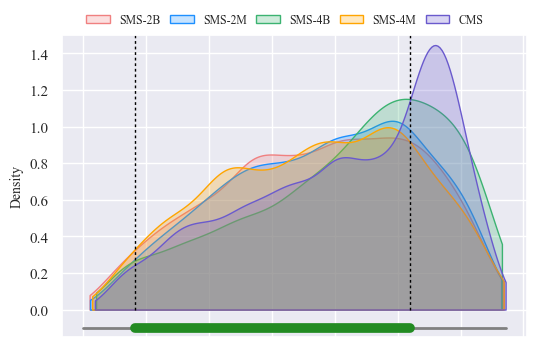

In [49]:
#Figure CMS/SMS metagene plot

sns.set(font='Times New Roman',style='darkgrid')

f, ax = plt.subplots(1,1)
#f, ax = plt.subplots(1,1,figsize=(10, 6))
tss = utr5p_sf
tts = utr5p_sf + 1
end = utr5p_sf + utr3p_sf + 1


scale_ls_x = np.linspace(0,1.6,8)
index_ls_x = ['','','','','','','','']
plt.xticks(scale_ls_x,index_ls_x)

# ax.set_ylim(0,1.7)
# ax.set_xlim(-0.1,1.6)

ax.plot([tss, tss], [0, 1.5], linestyle=(0,(2,2)), lw = 1 , color = "black")
ax.plot([tts, tts], [0, 1.5], linestyle=(0,(2,2)), lw = 1 , color = "black")
ax.plot([0,end],[-0.1,-0.1], lw = 2, color = 'grey')
ax.plot([tss,tts], [-0.1,-0.1], lw = 7, color = "forestgreen")

samples = [sms_2b_ratio_df,sms_2m_ratio_df,sms_4b_ratio_df,sms_4m_ratio_df,cms_2b_ratio_df]
colors = ['lightcoral','dodgerblue','mediumseagreen','orange','slateblue']
labels = ['SMS-2B','SMS-2M','SMS-4B','SMS-4M','CMS']

for sample,color,label in zip(samples,colors,labels):
    sns.kdeplot(sample.rel_pos.dropna(),
    fill=True,cut=0,color=color,label=label,ax = ax)

ax.legend(loc='center',fontsize=8.5,frameon=False,mode='expand',ncol=5,bbox_to_anchor=(0.03, 0.65, 0.9, 0.8))

ax.set_ylim(-0.15,1.5)
ax.set_ylabel("Density",fontsize=10)
ax.set_xlabel('')
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part4_m6a/Figure4.7_SMS_CMS_metagene.pdf', format='pdf', dpi=600, bbox_inches='tight')

### **3. Distribution of m<sup>6</sup>A sites on gene body**

#### **(1) Distribution of m<sup>6</sup>A sites on gene body**

In [55]:
#Count each region mod-site number of gene body
distribution_dict = {}
colors = [ "mediumseagreen", "lightcoral","dodgerblue"]
labels = ['5`UTR', 'CDS', '3`UTR','intron']
ratio_df_samples = [phe_2b_ratio_df,phe_2m_ratio_df,phe_4b_ratio_df,phe_4m_ratio_df,phe_all_ratio_df]
name_samples = ['2b','2m','4b','4m','all']
for sample_name,sample_ratio_df in zip(name_samples,ratio_df_samples):
    utr5p_num = sample_ratio_df.label.str.contains('utr5p',regex=False).sum()
    cds_num = sample_ratio_df.label.str.contains('cds',regex=False).sum()
    utr3p_num = sample_ratio_df.label.str.contains('utr3p',regex=False).sum()
    intron_num = sample_ratio_df.label.str.contains('intron',regex=False).sum()
    distribution_dict[sample_name] = [utr5p_num,cds_num,utr3p_num,intron_num]
distribution_df = pd.DataFrame(distribution_dict,index=['utr5p', 'cds', 'utr3p','intron'])
distribution_df_percentage = distribution_df.iloc[:3,].apply(lambda x : x / x.sum())  #compute percentage


Text(0.5, 1.0, 'Number of modified site on gene different region (all)')

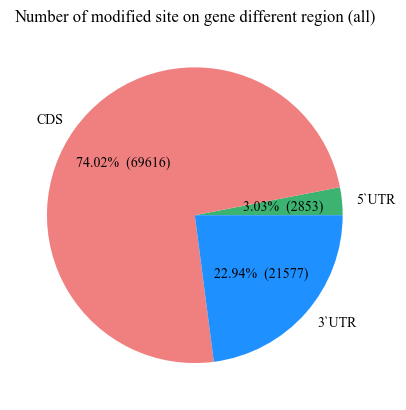

In [56]:
#Figure all_mod_site_distribution
def make_autopct(values):
    '''https://stackoverflow.com/questions/6170246/how-do-i-use-matplotlib-autopct'''
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

#plt.pie(distribution_dict['all'][:3],labels=labels[:3],colors=colors,autopct='%1.2f%%')
plt.pie(distribution_dict['all'][:3],labels=labels[:3],colors=colors,autopct=make_autopct(distribution_dict['all'][:3]))
plt.title('Number of modified site on gene different region (all)')


In [68]:
distribution_df_percentage

2b        2m        4b        4m       all
utr5p  0.025578  0.024971  0.025370  0.025732  0.030311
cds    0.667271  0.674529  0.633909  0.663376  0.740494
utr3p  0.307151  0.300500  0.340721  0.310892  0.229194

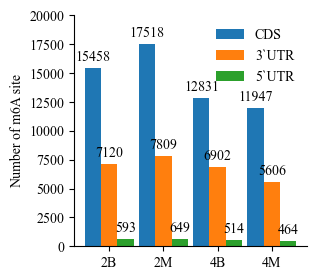

In [60]:
#Figure each_sample_mod_site_distribution (mod-site number)
fig, ax = plt.subplots(figsize=(3,3))
labels = ['2B','2M','4B','4M']

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

rects1 = ax.bar(x + 0.3, distribution_df.T.iloc[:4,].cds, width, label='CDS')
rects2 = ax.bar(x + 0.6, distribution_df.T.iloc[:4,].utr3p, width, label='3`UTR')
rects3 = ax.bar(x + 0.9, distribution_df.T.iloc[:4,].utr5p, width, label='5`UTR')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of m6A site')
#ax.set_xlabel('sample')
ax.set_xticks([0.6,1.6,2.6,3.6])  #设置横坐标的位置
ax.set_xticklabels(labels)
ax.set_ylim(0,20000)
ax.legend(frameon=False)

ax.spines['right'].set_visible(False) #去掉右边框
ax.spines['top'].set_visible(False) #去掉上边框

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
# plt.savefig(r'C:\Users\litao\Desktop\Figure_all_distribution.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)

In [62]:
distribution_df_percentage.T.iloc[:5,].cds

2b     0.667127
2m     0.674392
4b     0.633724
4m     0.663096
all    0.740234
Name: cds, dtype: float64

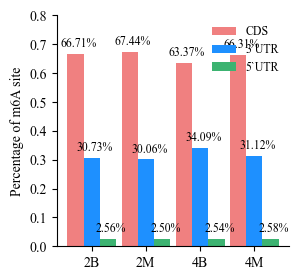

In [72]:
#Figure each_sample_mod_site_distribution (mod-site percentage)
labels = ['2B','2M','4B','4M']

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars
# colors = ["lightcoral", "dodgerblue", "mediumseagreen","orange"]
fig, ax = plt.subplots(figsize=(3,3))
rects1 = ax.bar(x + 0.3, distribution_df_percentage.T.iloc[:5,].cds[:4], width, label='CDS',color='lightcoral')
rects2 = ax.bar(x + 0.6, distribution_df_percentage.T.iloc[:5,].utr3p[:4], width, label='3`UTR',color='dodgerblue')
rects3 = ax.bar(x + 0.9, distribution_df_percentage.T.iloc[:5,].utr5p[:4], width, label='5`UTR',color='mediumseagreen')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage of m6A site')
#ax.set_xlabel('sample')
ax.set_xticks([0.6,1.6,2.6,3.6])  #设置横坐标的位置
ax.set_xticklabels(labels)
ax.set_ylim(0,0.8)
# ax.legend(loc='center',fontsize=8.5,frameon=False,mode='expand',ncol=3,bbox_to_anchor=(0.05, 0.7, 0.5, 0.5))
ax.legend(loc='best',fontsize=8.5,frameon=False)

ax.spines['right'].set_visible(False) #去掉右边框
ax.spines['top'].set_visible(False) #去掉上边框

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2%}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2 + 0.06, height),
                    xytext=(0,3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8.5)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part4_m6a/Figure4.4_m6a_distribution_on_gene_body.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part4_m6a/Figure4.4_m6a_distribution_on_gene_body.ps', format='ps', dpi=600, bbox_inches='tight',transparent = True)

#### **(2) Distribution of m<sup>6</sup>A sites on exon**

In [10]:
def get_exon_rel_pos(position,start,end,strand):
    if strand == "+":
        if position == end:
            return 0.99
        else:
            rel_pos = (position - start) / (end - start)
    else:
        if position == start:
            return 0.99
        else:
            rel_pos = (end - position) / (end - start)
    return rel_pos

In [11]:
anno_exon_intron_level = anno_exon_intron_level.rename(columns={'label':'exon_label'})
phe_2b_ratio_df = phe_2b_ratio_df.merge(anno_exon_intron_level[['start','end','gene_name','exon_label']],how='left',left_on=['gene_name','exon_label'],right_on=['gene_name','exon_label'],sort=False)
phe_2m_ratio_df = phe_2m_ratio_df.merge(anno_exon_intron_level[['start','end','gene_name','exon_label']],how='left',left_on=['gene_name','exon_label'],right_on=['gene_name','exon_label'],sort=False)
phe_4b_ratio_df = phe_4b_ratio_df.merge(anno_exon_intron_level[['start','end','gene_name','exon_label']],how='left',left_on=['gene_name','exon_label'],right_on=['gene_name','exon_label'],sort=False)
phe_4m_ratio_df = phe_4m_ratio_df.merge(anno_exon_intron_level[['start','end','gene_name','exon_label']],how='left',left_on=['gene_name','exon_label'],right_on=['gene_name','exon_label'],sort=False)

In [12]:
phe_2b_ratio_df['exon_rel_pos'] = phe_2b_ratio_df[~phe_2b_ratio_df.exon_label.isna()].apply(lambda row : get_exon_rel_pos(row['position'],row['start'],row['end'],row['strand']),axis=1)
phe_2m_ratio_df['exon_rel_pos'] = phe_2m_ratio_df[~phe_2m_ratio_df.exon_label.isna()].apply(lambda row : get_exon_rel_pos(row['position'],row['start'],row['end'],row['strand']),axis=1)
phe_4b_ratio_df['exon_rel_pos'] = phe_4b_ratio_df[~phe_4b_ratio_df.exon_label.isna()].apply(lambda row : get_exon_rel_pos(row['position'],row['start'],row['end'],row['strand']),axis=1)
phe_4m_ratio_df['exon_rel_pos'] = phe_4m_ratio_df[~phe_4m_ratio_df.exon_label.isna()].apply(lambda row : get_exon_rel_pos(row['position'],row['start'],row['end'],row['strand']),axis=1)

In [13]:
phe_2b_ratio_df['exon_tag'] = np.floor(phe_2b_ratio_df['exon_rel_pos'] * 100)
phe_2m_ratio_df['exon_tag'] = np.floor(phe_2m_ratio_df['exon_rel_pos'] * 100)
phe_4b_ratio_df['exon_tag'] = np.floor(phe_4b_ratio_df['exon_rel_pos'] * 100)
phe_4m_ratio_df['exon_tag'] = np.floor(phe_4m_ratio_df['exon_rel_pos'] * 100)

In [15]:
phe_2b_exon_relpos_list = phe_2b_ratio_df[~phe_2b_ratio_df.exon_tag.isna()][['exon_tag','strand']].groupby(['exon_tag']).agg('count')['strand'] / len(phe_2b_ratio_df[~phe_2b_ratio_df.exon_tag.isna()])
phe_2m_exon_relpos_list = phe_2m_ratio_df[~phe_2m_ratio_df.exon_tag.isna()][['exon_tag','strand']].groupby(['exon_tag']).agg('count')['strand'] / len(phe_2m_ratio_df[~phe_2m_ratio_df.exon_tag.isna()])
phe_4b_exon_relpos_list = phe_4b_ratio_df[~phe_4b_ratio_df.exon_tag.isna()][['exon_tag','strand']].groupby(['exon_tag']).agg('count')['strand'] / len(phe_4b_ratio_df[~phe_4b_ratio_df.exon_tag.isna()])
phe_4m_exon_relpos_list = phe_4m_ratio_df[~phe_4m_ratio_df.exon_tag.isna()][['exon_tag','strand']].groupby(['exon_tag']).agg('count')['strand'] / len(phe_4m_ratio_df[~phe_4m_ratio_df.exon_tag.isna()])

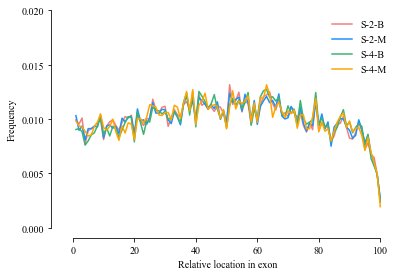

In [87]:
fig,ax = plt.subplots(1,1)
colors = ["lightcoral", "dodgerblue", "mediumseagreen","orange"]
labels = ["S-2-B","S-2-M","S-4-B","S-4-M"]
samples = [phe_2b_exon_relpos_list,phe_2m_exon_relpos_list,phe_4b_exon_relpos_list,phe_4m_exon_relpos_list]
for sample,color,label in zip(samples,colors,labels):
    sns.lineplot(x=range(1,101),y=sample,color=color,label=label,ax=ax)

y_major_locator=MultipleLocator(0.005)
ax.yaxis.set_major_locator(y_major_locator)
ax.legend(frameon=False)
ax.set_ylim(0,0.02)
sns.despine(ax=ax,trim=True,offset=10)
ax.set_xlabel('Relative location in exon')
ax.set_ylabel('Frequency')
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part4_m6a/Figure_m6a_distribution_in_exon.pdf', format='pdf', dpi=600, bbox_inches='tight')

### **4. Meatagene plot of m<sup>6</sup>A site**

#### **(1) Meatagene plot of m<sup>6</sup>A site (all reads)**

In [44]:
def get_distance(position,strand,gene_name,label,label_group,anno_cds_level_groups):
    if label_group in ['cds','utr5p','utr3p']:
        num = int(re.search('(?:(?<=cds)|(?<=utr3p|utr5p))[0-9]+',label).group())
        anno_part = anno_cds_level_groups.get_group((gene_name,label_group))
        if strand == "+":
            if num == 1:
                distance = position - anno_part.start.iloc[(num - 1)]
            else:
    #           print(num,gene_name,label)
                distance = anno_part.length.iloc[:(num - 1)].sum() + position - anno_part.start.iloc[(num - 1)]
        else:
            if num == 1:
                distance = anno_part.end.iloc[(num - 1)] - position
            else:
                distance = anno_part.length.iloc[:(num - 1)].sum() + anno_part.end.iloc[(num - 1)] - position
        return distance
    else:
        return np.nan

# def get_relatively_pos(gene_name,label_group,distance,anno_gene_level):
#     column_name = 'total_' + label_group + '_length'
#     if label_group == 'utr5p':
#         rel_pos = distance / anno_gene_level.loc[gene_name,column_name]
#         return rel_pos
#     elif label_group == 'cds':
#         rel_pos = distance / anno_gene_level.loc[gene_name,column_name] + 1
#         return rel_pos
#     elif label_group == 'utr3p':
#         rel_pos = distance / anno_gene_level.loc[gene_name,column_name] + 2
#         return rel_pos
#     else:
#          return np.nan
def get_relatively_pos(gene_name,label_group,distance,anno_gene_level):
    column_name = 'total_' + label_group + '_length'
    if label_group in ['cds','utr5p','utr3p']:
        rel_pos = distance / anno_gene_level.loc[gene_name,column_name]
        return rel_pos
    else:
        return np.nan

#When not scaled, please set SF(utr5p_sf,utr3p_sf) equal to _1
#Without scaling,three regions of gene-body are drawn with equal widths
def rel_pos_rescale(label_group,rel_pos,utr5p_sf,utr3p_sf):  
    if label_group == 'utr5p':
        return rel_pos * utr5p_sf
    elif label_group == 'cds':
        return rel_pos + utr5p_sf
    elif label_group == 'utr3p':
        return rel_pos * utr3p_sf + 1 + utr5p_sf
    else:
        return rel_pos

def get_rel_pos_and_rescale(ratio_df,anno_gene_level,anno_cds_level_groups):
    ratio_df.loc[:,'distance'] = ratio_df.apply(lambda row : get_distance(row['position'],row['strand'],row['gene_name'], row['label'],row['label_group'],anno_cds_level_groups),axis=1)
    ratio_df.loc[:,'rel_pos'] = ratio_df.apply(lambda row : get_relatively_pos(row['gene_name'],row['label_group'],row['distance'],anno_gene_level),axis=1)
    ratio_df.loc[:,'rel_pos'] = ratio_df.apply(lambda row: rel_pos_rescale(row['label_group'],row['rel_pos'],utr5p_sf,utr3p_sf),axis=1)
    return ratio_df


In [74]:
anno_cds_level_groups = anno_cds_level.groupby(['gene_name','label_group'])
#re-scale the widths of the 5'UTR and 3'UTR relative to the CDS (which is set constant to a width of 1 unit)
#1.calculate a simple scale factor (SF)
utr5p_sf = anno_gene_level.total_utr5p_length.dropna().median() / anno_gene_level.total_cds_length.dropna().median()
utr3p_sf = anno_gene_level.total_utr3p_length.dropna().median() / anno_gene_level.total_cds_length.dropna().median()
#2.The SF for the 5'UTR is 0.18 and for the 3'UTR is 0.34. Next, the following code rescales these relatively position accordingly
phe_2b_ratio_df = get_rel_pos_and_rescale(phe_2b_ratio_df,anno_gene_level,anno_cds_level_groups)
phe_2m_ratio_df = get_rel_pos_and_rescale(phe_2m_ratio_df,anno_gene_level,anno_cds_level_groups)
phe_4b_ratio_df = get_rel_pos_and_rescale(phe_4b_ratio_df,anno_gene_level,anno_cds_level_groups)
phe_4m_ratio_df = get_rel_pos_and_rescale(phe_4m_ratio_df,anno_gene_level,anno_cds_level_groups)

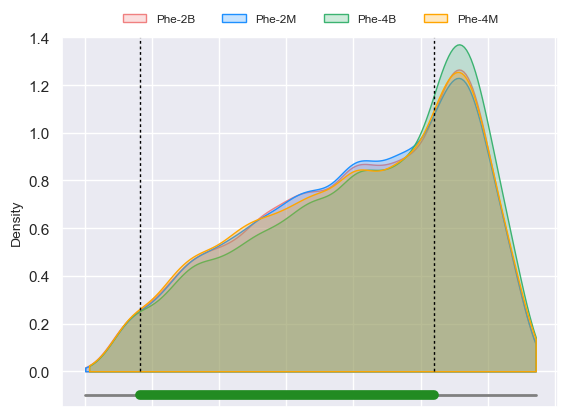

In [78]:
#Figure 
f, ax = plt.subplots(1,1)
#f, ax = plt.subplots(1,1,figsize=(10, 6))
sns.set_theme()
tss = utr5p_sf
tts = utr5p_sf + 1
end = utr5p_sf + utr3p_sf + 1


scale_ls_x = np.linspace(0,1.6,8)
index_ls_x = ['','','','','','','','']
plt.xticks(scale_ls_x,index_ls_x)

# ax.set_ylim(0,1.4)
# ax.set_xlim(-0.1,1.6)

ax.plot([tss, tss], [0, 1.4], linestyle=(0,(2,2)), lw = 1 , color = "black")
ax.plot([tts, tts], [0, 1.4], linestyle=(0,(2,2)), lw = 1 , color = "black")
ax.plot([0,end],[-0.1,-0.1], lw = 2, color = 'grey')
ax.plot([tss,tts], [-0.1,-0.1], lw = 7, color = "forestgreen")

sns.kdeplot(phe_2b_ratio_df.rel_pos.dropna(),fill=True,cut=0,color='lightcoral',label='Phe-2B',ax = ax)
sns.kdeplot(phe_2m_ratio_df.rel_pos.dropna(),fill=True,cut=0,color='dodgerblue',label='Phe-2M',ax = ax)
sns.kdeplot(phe_4b_ratio_df.rel_pos.dropna(),fill=True,cut=0,color='mediumseagreen',label='Phe-4B',ax = ax)
sns.kdeplot(phe_4m_ratio_df.rel_pos.dropna(),fill=True,cut=0,color='orange',label='Phe-4M',ax = ax)

ax.legend(loc='center',fontsize=8.5,frameon=False,mode='expand',ncol=4,bbox_to_anchor=(0.1, 0.65, 0.8, 0.8))

ax.set_ylim(-0.15,1.4)
ax.set_ylabel("Density",fontsize=10)
ax.set_xlabel('')
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part4_m6a/Figure4.5_metagene_density_plot.pdf', format='pdf', dpi=600, bbox_inches='tight')

#### **(2) Meatagene plot of m<sup>6</sup>A site (only full-length reads)**

### **5. Differential modification site**

In [40]:
# Load dataframe-easy format nanom6a ratio file
phe_2b_ratio_df_1reads = read_ratio_file(phe_2b_nanom6a_ratio_file,1)
phe_2m_ratio_df_1reads = read_ratio_file(phe_2m_nanom6a_ratio_file,1)
phe_4b_ratio_df_1reads = read_ratio_file(phe_4b_nanom6a_ratio_file,1)
phe_4m_ratio_df_1reads = read_ratio_file(phe_4m_nanom6a_ratio_file,1)
phe_all_ratio_df_1reads = read_ratio_file(phe_all_nanom6a_ratio_file,1)

# Load annotation file
# anno_gene_level = load_annotation_file_gene_level(gff_file)
# anno_cds_level = load_annotation_file_cds_level(gff_file)

# Some exons will overlap and these exons will be modified
anno_cds_level.loc[550902,'start']=42600
anno_cds_level.loc[550902,'end']=42600

# Classification of modified sites
phe_2b_ratio_df_1reads = mod_site_classification(anno_gene_level,anno_cds_level,phe_2b_ratio_df_1reads)
phe_2m_ratio_df_1reads = mod_site_classification(anno_gene_level,anno_cds_level,phe_2m_ratio_df_1reads)
phe_4b_ratio_df_1reads = mod_site_classification(anno_gene_level,anno_cds_level,phe_4b_ratio_df_1reads)
phe_4m_ratio_df_1reads = mod_site_classification(anno_gene_level,anno_cds_level,phe_4m_ratio_df_1reads)
phe_all_ratio_df_1reads = mod_site_classification(anno_gene_level,anno_cds_level,phe_all_ratio_df_1reads)

A total of 1679 sites are assigned to multiple genes, these sites will be deleted (Filter threshold = 1 read).
A total of 1868 sites are assigned to multiple genes, these sites will be deleted (Filter threshold = 1 read).
A total of 1539 sites are assigned to multiple genes, these sites will be deleted (Filter threshold = 1 read).
A total of 1434 sites are assigned to multiple genes, these sites will be deleted (Filter threshold = 1 read).
A total of 3716 sites are assigned to multiple genes, these sites will be deleted (Filter threshold = 1 read).


100%|█████████▉| 29884/29897 [03:35<00:00, 133.35it/s]


In [42]:
# phe_2b_ratio_df_1reads.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/11_m6A/phe_2b_ratio_df_1reads.csv',sep='\t',index=False)
# phe_2m_ratio_df_1reads.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/11_m6A/phe_2m_ratio_df_1reads.csv',sep='\t',index=False)
# phe_4b_ratio_df_1reads.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/11_m6A/phe_4b_ratio_df_1reads.csv',sep='\t',index=False)
# phe_4m_ratio_df_1reads.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/11_m6A/phe_4m_ratio_df_1reads.csv',sep='\t',index=False)
# phe_all_ratio_df_1reads.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/11_m6A/phe_all_ratio_df_1reads.csv',sep='\t',index=False)

In [14]:
phe_2b_ratio_df_1reads = read_ratio_df('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/11_m6A/phe_2b_ratio_df_1reads.csv')
phe_2m_ratio_df_1reads = read_ratio_df('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/11_m6A/phe_2m_ratio_df_1reads.csv')
phe_4b_ratio_df_1reads = read_ratio_df('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/11_m6A/phe_4b_ratio_df_1reads.csv')
phe_4m_ratio_df_1reads = read_ratio_df('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/11_m6A/phe_4m_ratio_df_1reads.csv')
phe_all_ratio_df_1reads = read_ratio_df('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/11_m6A/phe_all_ratio_df_1reads.csv')

Tips: A total of 104 sites with a modification ratio greater than 1 will be filtered out. (Nanom6A may output some sites with a modification ratio greater than 1, which may be a bug) 
Tips: A total of 109 sites with a modification ratio greater than 1 will be filtered out. (Nanom6A may output some sites with a modification ratio greater than 1, which may be a bug) 
Tips: A total of 84 sites with a modification ratio greater than 1 will be filtered out. (Nanom6A may output some sites with a modification ratio greater than 1, which may be a bug) 
Tips: A total of 67 sites with a modification ratio greater than 1 will be filtered out. (Nanom6A may output some sites with a modification ratio greater than 1, which may be a bug) 
Tips: A total of 335 sites with a modification ratio greater than 1 will be filtered out. (Nanom6A may output some sites with a modification ratio greater than 1, which may be a bug) 


In [15]:
phe_2b_ratio_df_3reads = phe_2b_ratio_df_1reads[phe_2b_ratio_df_1reads.total_num >= 3]
phe_2m_ratio_df_3reads = phe_2m_ratio_df_1reads[phe_2m_ratio_df_1reads.total_num >= 3]
phe_4b_ratio_df_3reads = phe_4b_ratio_df_1reads[phe_4b_ratio_df_1reads.total_num >= 3]
phe_4m_ratio_df_3reads = phe_4m_ratio_df_1reads[phe_4m_ratio_df_1reads.total_num >= 3]

In [21]:
#Select common sites
ratio_inter_2b_2m_3reads,ratio_inter_4b_4m_3reads,ratio_inter_2b_4b_3reads,ratio_inter_2m_4m_3reads = inter_ratio_site(phe_2b_ratio_df_3reads,phe_2m_ratio_df_3reads,phe_4b_ratio_df_3reads,phe_4m_ratio_df_3reads)

In [17]:
def assign_dmr_type(dmr):
    if dmr > 0 :
        return 'gain'
    else:
        return 'loss'

def get_difference_m6a_site(ratio_inter_df,sample1,sample2,dmr):
    label1 = ''.join([sample1,'_mod_ratio'])
    label2 = ''.join([sample2,'_mod_ratio'])
    df = ratio_inter_df.copy()
    df.loc[:,'dmr'] = ratio_inter_df[label1] - ratio_inter_df[label2]
    df = df[abs(df['dmr']) >= dmr]
    df.loc[:,'dmr_type'] = df['dmr'].apply(assign_dmr_type)
    return df


In [22]:
dmr_2b_2m = get_difference_m6a_site(ratio_inter_2b_2m_3reads,'2b','2m',.5)
dmr_2b_4b = get_difference_m6a_site(ratio_inter_2b_4b_3reads,'2b','4b',.5)
dmr_2m_4m = get_difference_m6a_site(ratio_inter_2m_4m_3reads,'2m','4m',.5)
dmr_4b_4m = get_difference_m6a_site(ratio_inter_4b_4m_3reads,'4b','4m',.5)

In [25]:
#export difference m6a gene
list_to_csv(dmr_2b_2m[dmr_2b_2m.dmr_type == 'gain']['gene_name'].unique(),'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/01_go/dms_2b_2m_gain.csv')
list_to_csv(dmr_2b_2m[dmr_2b_2m.dmr_type == 'loss']['gene_name'].unique(),'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/01_go/dms_2b_2m_loss.csv')

list_to_csv(dmr_2b_4b[dmr_2b_4b.dmr_type == 'gain']['gene_name'].unique(),'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/01_go/dms_2b_4b_gain.csv')
list_to_csv(dmr_2b_4b[dmr_2b_4b.dmr_type == 'loss']['gene_name'].unique(),'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/01_go/dms_2b_4b_loss.csv')

list_to_csv(dmr_2m_4m[dmr_2m_4m.dmr_type == 'gain']['gene_name'].unique(),'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/01_go/dms_2m_4m_gain.csv')
list_to_csv(dmr_2m_4m[dmr_2m_4m.dmr_type == 'loss']['gene_name'].unique(),'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/01_go/dms_2m_4m_loss.csv')

list_to_csv(dmr_4b_4m[dmr_4b_4m.dmr_type == 'gain']['gene_name'].unique(),'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/01_go/dms_4b_4m_gain.csv')
list_to_csv(dmr_4b_4m[dmr_4b_4m.dmr_type == 'loss']['gene_name'].unique(),'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/01_go/dms_4b_4m_loss.csv')

In [60]:
anno_cds_level_groups = anno_cds_level.groupby(['gene_name','label_group'])
#re-scale the widths of the 5'UTR and 3'UTR relative to the CDS (which is set constant to a width of 1 unit)
#1.calculate a simple scale factor (SF)
utr5p_sf = anno_gene_level.total_utr5p_length.dropna().median() / anno_gene_level.total_cds_length.dropna().median()
utr3p_sf = anno_gene_level.total_utr3p_length.dropna().median() / anno_gene_level.total_cds_length.dropna().median()
#2.The SF for the 5'UTR is 0.18 and for the 3'UTR is 0.34. Next, the following code rescales these relatively position accordingly
dmr_2b_2m = get_rel_pos_and_rescale(dmr_2b_2m,anno_gene_level,anno_cds_level_groups)
dmr_2b_4b = get_rel_pos_and_rescale(dmr_2b_4b,anno_gene_level,anno_cds_level_groups)
dmr_2m_4m = get_rel_pos_and_rescale(dmr_2m_4m,anno_gene_level,anno_cds_level_groups)
dmr_4b_4m = get_rel_pos_and_rescale(dmr_2b_2m,anno_gene_level,anno_cds_level_groups)

In [41]:
dmr_2b_2m

scaffold   position  2b_mod_ratio      gene_name exon_label  \
622      hic_scaffold_9   65017395      0.875000  PH02Gene30218     exon10   
1033    hic_scaffold_15   15714912      0.800000  PH02Gene43308      exon4   
2380    hic_scaffold_20   30423588      0.833333  PH02Gene31956      exon2   
2539     hic_scaffold_2    4490978      0.333333  PH02Gene32933      exon2   
2542     hic_scaffold_2    4491095      0.857143  PH02Gene32933      exon2   
...                 ...        ...           ...            ...        ...   
215767   hic_scaffold_6   36403076      0.285714  PH02Gene13876      exon2   
215831  hic_scaffold_15  101096091      0.800000  PH02Gene08379      exon2   
215935  hic_scaffold_24   26081419      0.800000  PH02Gene28644      exon2   
215939  hic_scaffold_23   31079430      0.600000  PH02Gene04048      exon1   
216218  hic_scaffold_24   50942271      0.800000  PH02Gene22596      exon3   

       strand   label label_group  2m_mod_ratio       dmr dmr_type  distance  \
622         -   cds10         cds      0.263158  0.611842     gain     823.0   
1033        -  utr3p2       utr3p      0.200000  0.600000     gain     678.0   
2380        -    cds2         cds      0.333333  0.500000     gain     454.0   
2539        -    cds2         cds      0.888889 -0.555556     loss    1051.0   
2542        -    cds2         cds      0.222222  0.634921     gain     934.0   
...       ...     ...         ...           ...       ...      ...       ...   
215767      +    cds1         cds      0.800000 -0.514286     loss     808.0   
215831      -    cds2         cds      0.222222  0.577778     gain     286.0   
215935      -    cds2         cds      0.200000  0.600000     gain      82.0   
215939      +    cds1         cds      0.090909  0.509091     gain     641.0   
216218      -  utr3p1       utr3p      0.285714  0.514286     gain     176.0   

         rel_pos  
622     0.767442  
1033    1.434745  
2380    0.717817  
2539    0.519807  
2542    0.482945  
...          ...  
215767  0.741725  
215831  0.539169  
215935  0.584815  
215939  0.880157  
216218  1.414846  

[1111 rows x 13 columns]

### **6. Correlation Analysis**

#### **(1) Exon-length & m<sup>6</sup>A**

In [104]:
def get_modified_exon_info(ratio_df,anno_cds_level):
    ratio_df_exon_mod_info = ratio_df[['gene_name','mod_ratio','exon_label']].groupby(['gene_name','exon_label']).agg(
    mod_site_num=('mod_ratio', 'count'), mod_ratio_mean=('mod_ratio', 'mean'),mod_ratio_median=('mod_ratio','median'))
    anno_mod_exon_info = anno_cds_level[anno_cds_level.label.str.contains('exon',regex=False)].merge(
    ratio_df_exon_mod_info[['mod_site_num','mod_ratio_mean','mod_ratio_median']],how='left',left_on=['gene_name','label'],right_index=True,sort=False)
    return anno_mod_exon_info

In [105]:
phe_all_mod_exon_info = get_modified_exon_info(phe_all_ratio_df,anno_cds_level)
phe_2b_mod_exon_info = get_modified_exon_info(phe_2b_ratio_df,anno_cds_level)
phe_2m_mod_exon_info = get_modified_exon_info(phe_2m_ratio_df,anno_cds_level)
phe_4b_mod_exon_info = get_modified_exon_info(phe_4b_ratio_df,anno_cds_level)
phe_4m_mod_exon_info = get_modified_exon_info(phe_4m_ratio_df,anno_cds_level)

all_mod_exon_length = phe_all_mod_exon_info[~phe_all_mod_exon_info.mod_site_num.isna()].length
all_non_mod_exon_length = phe_all_mod_exon_info[phe_all_mod_exon_info.mod_site_num.isna()].length
total_exon_length = anno_cds_level[anno_cds_level.label.str.contains('exon',regex=False)].length

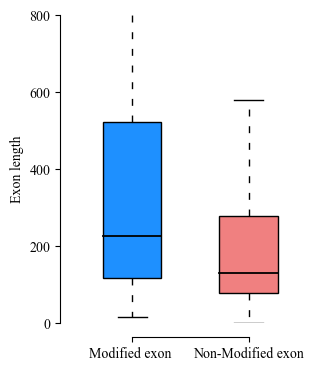

In [106]:
#Figure4.5.1 mod_exon_length_vs_non_mod_exon_length
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'font.sans-serif':'Times New Roman','axes.unicode_minus':False})

labels=["Modified exon ","Non-Modified exon"]
colors=['dodgerblue','lightcoral']
fig,ax = plt.subplots(figsize=(3,4))
plt.ylim(0,800) 
bplot = plt.boxplot([all_mod_exon_length,all_non_mod_exon_length], patch_artist=True, labels=labels,showfliers=False,widths=0.5)
for patch in bplot['whiskers']:
    patch.set_linestyle((0,(5,7)))
    patch.set_linewidth(1)
for patch in bplot['medians']:
    patch.set_linewidth(1.3)
    patch.set_color('black')
for patch,color in zip(bplot['boxes'],colors):
    patch.set_facecolor(color)

ax = plt.gca()
ax.set_ylabel('Exon length')
sns.despine(ax = ax,trim=True,offset=10)
y_major_locator=MultipleLocator(200)
ax.yaxis.set_major_locator(y_major_locator)

#Statistical test to calculate p-value.
# stats.mannwhitneyu(all_mod_exon_length,all_non_mod_exon_length,alternative='two-sided')
# plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part4_m6a/Figure4.11_mod_exon_length_vs_non_mod_exon_length.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)

In [107]:
mannwhitneyu(all_mod_exon_length,all_non_mod_exon_length)

MannwhitneyuResult(statistic=6131435192.5, pvalue=0.0)

In [78]:
#Calculate Modified/Non-Modified exon length confidence interval and median value.
exon_CIs = pd.DataFrame()
exon_CIs.loc[:,'2b_mod'] = phe_2b_mod_exon_info[~phe_2b_mod_exon_info.mod_site_num.isna()].length.describe(percentiles=(0.025, 0.25, 0.50, 0.75, 0.975))
exon_CIs.loc[:,'2b_no_mod'] = phe_2b_mod_exon_info[phe_2b_mod_exon_info.mod_site_num.isna()].length.describe(percentiles=(0.025, 0.25, 0.50, 0.75, 0.975))
exon_CIs.loc[:,'2m_mod'] = phe_2m_mod_exon_info[~phe_2m_mod_exon_info.mod_site_num.isna()].length.describe(percentiles=(0.025, 0.25, 0.50, 0.75, 0.975))
exon_CIs.loc[:,'2m_no_mod'] = phe_2m_mod_exon_info[phe_2m_mod_exon_info.mod_site_num.isna()].length.describe(percentiles=(0.025, 0.25, 0.50, 0.75, 0.975))
exon_CIs.loc[:,'4b_mod'] = phe_4b_mod_exon_info[~phe_4b_mod_exon_info.mod_site_num.isna()].length.describe(percentiles=(0.025, 0.25, 0.50, 0.75, 0.975))
exon_CIs.loc[:,'4b_no_mod'] = phe_4b_mod_exon_info[phe_4b_mod_exon_info.mod_site_num.isna()].length.describe(percentiles=(0.025, 0.25, 0.50, 0.75, 0.975))
exon_CIs.loc[:,'4m_mod'] = phe_4m_mod_exon_info[~phe_4m_mod_exon_info.mod_site_num.isna()].length.describe(percentiles=(0.025, 0.25, 0.50, 0.75, 0.975))
exon_CIs.loc[:,'4m_no_mod'] = phe_4m_mod_exon_info[phe_4m_mod_exon_info.mod_site_num.isna()].length.describe(percentiles=(0.025, 0.25, 0.50, 0.75, 0.975))
exon_CIs.loc[:,'all_mod'] = phe_all_mod_exon_info[~phe_all_mod_exon_info.mod_site_num.isna()].length.describe(percentiles=(0.025, 0.25, 0.50, 0.75, 0.975))
exon_CIs.loc[:,'all_no_mod'] = phe_all_mod_exon_info[phe_all_mod_exon_info.mod_site_num.isna()].length.describe(percentiles=(0.025, 0.25, 0.50, 0.75, 0.975))

In [79]:
exon_CIs

2b_mod      2b_no_mod        2m_mod      2m_no_mod       4b_mod  \
count  11513.000000  262756.000000  12996.000000  261273.000000  9869.000000   
mean     429.414575     272.322623    415.118960     272.142039   456.820549   
std      457.255690     378.600141    446.136517     378.863624   472.866664   
min       16.000000       1.000000     16.000000       1.000000    16.000000   
2.5%      57.000000      19.000000     57.000000      19.000000    59.000000   
25%      128.000000      81.000000    124.000000      81.000000   139.000000   
50%      282.000000     139.000000    265.000000     138.000000   318.000000   
75%      563.000000     301.000000    546.000000     300.000000   595.000000   
97.5%   1723.200000    1352.000000   1660.250000    1353.000000  1783.300000   
max     6109.000000   11606.000000   6109.000000   11606.000000  6109.000000   

           4b_no_mod       4m_mod      4m_no_mod       all_mod     all_no_mod  
count  264400.000000  8623.000000  265646.000000  40508.000000  233761.000000  
mean      272.276441   449.770729     273.370877    407.541152     256.627821  
std       378.165233   466.721033     379.230506    475.107609     360.693360  
min         1.000000    16.000000       1.000000     16.000000       1.000000  
2.5%       19.000000    58.000000      19.000000     55.000000      17.000000  
25%        81.000000   136.000000      81.000000    117.000000      78.000000  
50%       139.000000   301.000000     139.000000    228.000000     132.000000  
75%       301.000000   585.000000     303.000000    521.250000     279.000000  
97.5%    1350.000000  1829.900000    1352.000000   1791.000000    1275.000000  
max     11606.000000  4167.000000   11606.000000   9292.000000   11606.000000

In [80]:
phe_all_mod_exon_info_filter_na = phe_all_mod_exon_info[~phe_all_mod_exon_info.mod_site_num.isna()]
phe_2b_mod_exon_info_filter_na = phe_2b_mod_exon_info[~phe_2b_mod_exon_info.mod_site_num.isna()]
phe_2m_mod_exon_info_filter_na = phe_2m_mod_exon_info[~phe_2m_mod_exon_info.mod_site_num.isna()]
phe_4b_mod_exon_info_filter_na = phe_4b_mod_exon_info[~phe_4b_mod_exon_info.mod_site_num.isna()]
phe_4m_mod_exon_info_filter_na = phe_4m_mod_exon_info[~phe_4m_mod_exon_info.mod_site_num.isna()]


(x_line_all,y_line_all,r2_all,slope_all) = linear_regression(phe_all_mod_exon_info_filter_na.mod_site_num,phe_all_mod_exon_info_filter_na.length,0,3,1000)

r2_slope_df = pd.DataFrame()
r2_slope_df.loc[:,'2b'] = list(linear_regression(phe_2b_mod_exon_info_filter_na.mod_site_num,phe_2b_mod_exon_info_filter_na.length,0,3,1000))[2:]
r2_slope_df.loc[:,'2m'] = list(linear_regression(phe_2m_mod_exon_info_filter_na.mod_site_num,phe_2m_mod_exon_info_filter_na.length,0,3,1000))[2:]
r2_slope_df.loc[:,'4b'] = list(linear_regression(phe_4b_mod_exon_info_filter_na.mod_site_num,phe_4b_mod_exon_info_filter_na.length,0,3,1000))[2:]
r2_slope_df.loc[:,'4m'] = list(linear_regression(phe_4m_mod_exon_info_filter_na.mod_site_num,phe_4m_mod_exon_info_filter_na.length,0,3,1000))[2:]
r2_slope_df.loc[:,'all'] = [r2_all,slope_all]
r2_slope_df.loc[:,'index'] = ['r2','slope']
r2_slope_df.set_index('index',drop=True, append=False, inplace=True)
r2_slope_df = r2_slope_df.T

In [81]:
r2_slope_df

index        r2       slope
2b     0.389504   98.557246
2m     0.401867   99.696385
4b     0.392732  100.647679
4m     0.436056  104.289218
all    0.495287  102.556199

In [ ]:
#Figure4.5.2 Density plot showing correlation between modified exon length and m6a modification site number
fig, axes = plt.subplots(1,2,figsize=(6,2.5),gridspec_kw = {'width_ratios':[1, 1]})

#kdeplot
axes[0].set_xlim(0,3)
axes[0].set_ylim(0,800)
sns.kdeplot(x=phe_all_mod_exon_info_filter_na.mod_site_num,y=phe_all_mod_exon_info_filter_na.length,levels=15,shade = True, cmap = "PuBu",ax=axes[0])
axes[0].plot(x_line_all,y_line_all,color='cornflowerblue')
axes[0].text(1.5,700,"$R^2$=%.4f"%(r2_all))
axes[0].set_ylabel('Modified exon length')
axes[0].set_xlabel('m6a modification site number')

#plot slope
axes[1].set_ylim(98,106)
axes[1].set_ylabel('Regression line slope')
sample = ['2B','2M','4B','4M']
axes[1].plot(sample,r2_slope_df.slope[:4],color='cornflowerblue')
axes[1].scatter(sample,r2_slope_df.slope[:4],color='cornflowerblue')

plt.subplots_adjust(wspace=0.4)
sns.despine(ax = axes[0],trim=True,offset=10)
sns.despine(ax = axes[1],trim=True,offset=10)
# plt.savefig(r'C:\Users\litao\Desktop\Figure_exon_length_vs_m6a.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)

In [ ]:
#Figure
fig,ax = plt.subplots(1,1)
ax.set_xlim(0,1)
ax.set_ylim(0,1000)
anno_mod_exon_info_filter_na = anno_mod_exon_info[~anno_mod_exon_info.mod_site_num.isna()]
sns.kdeplot(x=anno_mod_exon_info_filter_na.mod_ratio_mean,y=anno_mod_exon_info_filter_na.length,levels=15,shade = True, cmap = "PuBu",ax=ax)

#### **(2) Gene expression & m<sup>6</sup>A**

In [67]:
def read_featurecounts(featurecounts_txt):
    df = pd.read_csv(featurecounts_txt,sep='\t',header=0,skiprows=1,
    names=['gene_name', 'scaffold', 'start', 'end','strand','length','count'],
    dtype={'gene_name':str, 'scaffold':str, 'start':str, 'end':str,'strand':str,'length':int,'count':int},
    usecols=['gene_name','length','count'],
    index_col='gene_name')
    return df

In [68]:
#load feaurecounts txt file
feature_count_2b = read_featurecounts(phe_2b_featurecounts_gene_file).rename({'count':'2b_count'},axis=1)
feature_count_2m = read_featurecounts(phe_2m_featurecounts_gene_file).rename({'count':'2m_count'},axis=1)
feature_count_4b = read_featurecounts(phe_4b_featurecounts_gene_file).rename({'count':'4b_count'},axis=1)
feature_count_4m = read_featurecounts(phe_4m_featurecounts_gene_file).rename({'count':'4m_count'},axis=1)
#merge all sample
all_featurecounts_df = pd.concat([feature_count_2b,feature_count_2m['2m_count'],feature_count_4b['4b_count'],feature_count_4m['4m_count']],axis=1).replace(0,np.nan)

In [69]:
#each_gene_mod_info
all_gene_mod_ratio = pd.concat(
[phe_2b_ratio_df[['gene_name','mod_ratio']].groupby(['gene_name']).agg(mod_num=('mod_ratio','count'),median_ratio=('mod_ratio','median')).rename({'median_ratio':'2b_median_ratio','mod_num':'2b_mod_num'},axis=1),
phe_2m_ratio_df[['gene_name','mod_ratio']].groupby(['gene_name']).agg(mod_num=('mod_ratio','count'),median_ratio=('mod_ratio','median')).rename({'median_ratio':'2m_median_ratio','mod_num':'2m_mod_num'},axis=1),
phe_4b_ratio_df[['gene_name','mod_ratio']].groupby(['gene_name']).agg(mod_num=('mod_ratio','count'),median_ratio=('mod_ratio','median')).rename({'median_ratio':'4b_median_ratio','mod_num':'4b_mod_num'},axis=1),
phe_4m_ratio_df[['gene_name','mod_ratio']].groupby(['gene_name']).agg(mod_num=('mod_ratio','count'),median_ratio=('mod_ratio','median')).rename({'median_ratio':'4m_median_ratio','mod_num':'4m_mod_num'},axis=1)],axis=1)

In [70]:
# #count number to FPKM
# all_featurecounts_df = all_featurecounts_df.merge(
# all_featurecounts_df[['2b_count','2m_count','4b_count','4m_count']].apply(lambda x : x /x.sum() * 1000000).rename({'2b_count':'2b_fpkm','2m_count':'2m_fpkm','4b_count':'4b_fpkm','4m_count':'4m_fpkm'},axis=1),
# how='left',left_index=True,right_index=True,sort=False)
# all_featurecounts_df.loc[:,'2b_fpkm'] = all_featurecounts_df['2b_fpkm'] / all_featurecounts_df['length'] * 1000
# all_featurecounts_df.loc[:,'2m_fpkm'] = all_featurecounts_df['2m_fpkm'] / all_featurecounts_df['length'] * 1000
# all_featurecounts_df.loc[:,'4b_fpkm'] = all_featurecounts_df['4b_fpkm'] / all_featurecounts_df['length'] * 1000
# all_featurecounts_df.loc[:,'4m_fpkm'] = all_featurecounts_df['4m_fpkm'] / all_featurecounts_df['length'] * 1000 

# #merge FPKM to ratio dataframe
all_gene_mod_ratio = all_gene_mod_ratio.merge(all_featurecounts_df,how='left',left_index=True,right_index=True,sort=False)


In [71]:
#each gene TPM
phe_sample_TPM = phe_sample_TPM.replace(0,np.nan)
all_gene_mod_ratio['2b_tpm'] = phe_sample_TPM['phe_2B']
all_gene_mod_ratio['2m_tpm'] = phe_sample_TPM['phe_2M']
all_gene_mod_ratio['4b_tpm'] = phe_sample_TPM['phe_4B']
all_gene_mod_ratio['4m_tpm'] = phe_sample_TPM['phe_4M']

In [72]:
#log10(count) liner regression
samples = [['2b_median_ratio','2b_count'],['2m_median_ratio','2m_count'],['4b_median_ratio','4b_count'],['4m_median_ratio','4m_count']]
log10count_line_df = pd.DataFrame()
log10count_r_slope_df = pd.DataFrame()
for sample in samples:
    x = sample[0][0:2] + '_x_line'
    y = sample[0][0:2] + '_y_line'
    log10count_line_df.loc[:,x] = linear_regression(all_gene_mod_ratio[all_gene_mod_ratio[sample].notna().all(axis=1)][sample[0]],np.log10(all_gene_mod_ratio[all_gene_mod_ratio[sample].notna().all(axis=1)][sample[1]]),0,1,1000)[0]
    log10count_line_df.loc[:,y] = linear_regression(all_gene_mod_ratio[all_gene_mod_ratio[sample].notna().all(axis=1)][sample[0]],np.log10(all_gene_mod_ratio[all_gene_mod_ratio[sample].notna().all(axis=1)][sample[1]]),0,1,1000)[1]
    log10count_r_slope_df.loc[:,sample[0][0:2]] = linear_regression(all_gene_mod_ratio[all_gene_mod_ratio[sample].notna().all(axis=1)][sample[0]],np.log10(all_gene_mod_ratio[all_gene_mod_ratio[sample].notna().all(axis=1)][sample[1]]),0,1,1000)[2:]
log10count_r_slope_df.index = ['r','slope']

In [73]:
#log2(TPM) liner regression
samples = [['2b_median_ratio','2b_tpm'],['2m_median_ratio','2m_tpm'],['4b_median_ratio','4b_tpm'],['4m_median_ratio','4m_tpm']]
log2tpm_line_df = pd.DataFrame()
log2tpm_r_slope_df = pd.DataFrame()
for sample in samples:
    x = sample[0][0:2] + '_x_line'
    y = sample[0][0:2] + '_y_line'
    log2tpm_line_df.loc[:,x] = linear_regression(all_gene_mod_ratio[all_gene_mod_ratio[sample].notna().all(axis=1)][sample[0]],np.log2(all_gene_mod_ratio[all_gene_mod_ratio[sample].notna().all(axis=1)][sample[1]]),0,1,1000)[0]
    log2tpm_line_df.loc[:,y] = linear_regression(all_gene_mod_ratio[all_gene_mod_ratio[sample].notna().all(axis=1)][sample[0]],np.log2(all_gene_mod_ratio[all_gene_mod_ratio[sample].notna().all(axis=1)][sample[1]]),0,1,1000)[1]
    log2tpm_r_slope_df.loc[:,sample[0][0:2]] = linear_regression(all_gene_mod_ratio[all_gene_mod_ratio[sample].notna().all(axis=1)][sample[0]],np.log2(all_gene_mod_ratio[all_gene_mod_ratio[sample].notna().all(axis=1)][sample[1]]),0,1,1000)[2:]
log2tpm_r_slope_df.index = ['r','slope']

In [84]:
log10count_r_slope_df

2b        2m        4b        4m
r      0.733447  0.723864  0.719622  0.726547
slope -1.422102 -1.416751 -1.446795 -1.443381

In [83]:
log2tpm_r_slope_df

2b        2m        4b        4m
r      0.671902  0.655869  0.660983  0.649177
slope -5.252758 -5.062840 -5.127954 -5.054995

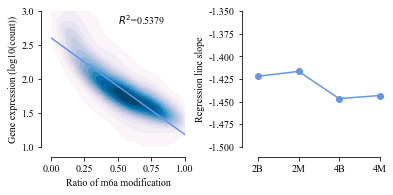

In [85]:
#Figure Density plot showing correlation between gene-expression(log10(count)) and m6a modification ratio (kdeplot use phe-2b)
fig, axes = plt.subplots(1,2,figsize=(6,2.5),gridspec_kw = {'width_ratios':[1, 1]})

#kdeplot (use phe-2b)
kde_x = all_gene_mod_ratio[all_gene_mod_ratio[['2b_median_ratio','2b_count']].notna().all(axis=1)]['2b_median_ratio']
kde_y = np.log10(all_gene_mod_ratio[all_gene_mod_ratio[['2b_median_ratio','2b_count']].notna().all(axis=1)]['2b_count'])
r = log10count_r_slope_df.loc['r','2b']
x_line = log10count_line_df['2b_x_line']
y_line = log10count_line_df['2b_y_line']

axes[0].set_xlim(0,1)
axes[0].set_ylim(1,3)
sns.kdeplot(x=kde_x,y=kde_y,levels=15,shade = True, cmap = "PuBu",ax=axes[0])
axes[0].plot(x_line,y_line,color='cornflowerblue')
axes[0].text(0.5,2.8,"$R^2$=%.4f"%(r*r))
axes[0].set_ylabel('Gene expression (log10(count))')
axes[0].set_xlabel('Ratio of m6a modification')

#plot slope
axes[1].set_ylim(-1.5,-1.35)
axes[1].set_ylabel('Regression line slope')
sample = ['2B','2M','4B','4M']
axes[1].plot(sample,log10count_r_slope_df.loc['slope',:],color='cornflowerblue')
axes[1].scatter(sample,log10count_r_slope_df.loc['slope',:],color='cornflowerblue')

plt.subplots_adjust(wspace=0.5)
sns.despine(ax = axes[0],trim=True,offset=10)
sns.despine(ax = axes[1],trim=True,offset=10)
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part4_m6a/Figure_log10count_m6a_ratio.pdf', format='pdf', dpi=600, bbox_inches='tight')

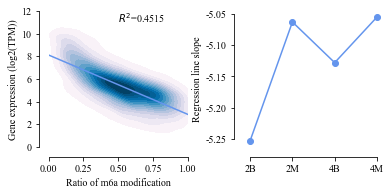

In [86]:
#Figure Density plot showing correlation between gene-expression(log2(TPM)) and m6a modification ratio
fig, axes = plt.subplots(1,2,figsize=(6,2.5),gridspec_kw = {'width_ratios':[1, 1]})

#kdeplot (use phe-2b)

kde_x = all_gene_mod_ratio[all_gene_mod_ratio[['2b_median_ratio','2b_tpm']].notna().all(axis=1)]['2b_median_ratio']
kde_y = np.log2(all_gene_mod_ratio[all_gene_mod_ratio[['2b_median_ratio','2b_tpm']].notna().all(axis=1)]['2b_tpm'])
r = log2tpm_r_slope_df.loc['r','2b']
x_line = log2tpm_line_df['2b_x_line']
y_line = log2tpm_line_df['2b_y_line']

axes[0].set_xlim(0,1)
axes[0].set_ylim(0,12)
sns.kdeplot(x=kde_x,y=kde_y,levels=15,shade = True, cmap = "PuBu",ax=axes[0])
axes[0].plot(x_line,y_line,color='cornflowerblue')
axes[0].text(0.5,11,"$R^2$=%.4f"%(r*r))
axes[0].set_ylabel('Gene expression (log2(TPM))')
axes[0].set_xlabel('Ratio of m6a modification')

#plot slope
# axes[1].set_ylim(-1.75,-1.65)
axes[1].set_ylabel('Regression line slope')
sample = ['2B','2M','4B','4M']
axes[1].plot(sample,log2tpm_r_slope_df.loc['slope',:],color='cornflowerblue')
axes[1].scatter(sample,log2tpm_r_slope_df.loc['slope',:],color='cornflowerblue')

plt.subplots_adjust(wspace=0.4)
sns.despine(ax = axes[0],trim=True,offset=10)
sns.despine(ax = axes[1],trim=True,offset=10)
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part4_m6a/Figure_TPM_m6a_ratio.pdf', format='pdf', dpi=600, bbox_inches='tight')

####  **(3) Poly(A)-tail length & m<sup>6</sup>A**

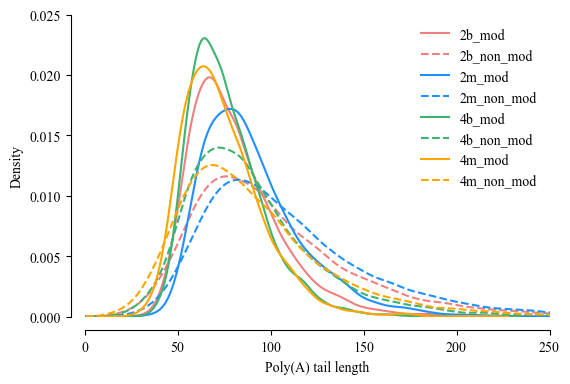

In [30]:
#Figure polya_tail_and_m6a
fig,ax = plt.subplots(1,1)
polyas = [gene_polya_info_2b,gene_polya_info_2m,gene_polya_info_4b,gene_polya_info_4m]
m6as = [phe_2b_ratio_df,phe_2m_ratio_df,phe_4b_ratio_df,phe_4m_ratio_df]
names = ['2b','2m','4b','4m']
colors = ['lightcoral','dodgerblue','mediumseagreen','orange']
for polya,m6a,name,color in zip(polyas,m6as,names,colors):
    sns.kdeplot(polya[polya.index.isin(m6a['gene_name'].unique())]['median_length'],color=color,label=''.join([name,"_mod"]),ax=ax)
    sns.kdeplot(polya[~polya.index.isin(m6a['gene_name'].unique())]['median_length'],color=color,label=''.join([name,"_non_mod"]),linestyle='dashed',ax=ax)

ax.set_ylim(0,0.025)
ax.set_xlim(0,250)
ax.legend(loc='upper right',frameon=False)
ax.set_xlabel('Poly(A) tail length')
sns.despine(ax=ax,trim=True,offset=10)
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part4_m6a/Figure4.6_polya_tail_and_m6a.pdf', format='pdf', dpi=600, bbox_inches='tight')
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part4_m6a/Figure4.6_polya_tail_and_m6a.ps', format='ps', dpi=600, bbox_inches='tight')

In [91]:
phe_2b_mod_pal = gene_polya_info_2b[gene_polya_info_2b.index.isin(phe_2b_ratio_df['gene_name'].unique())]['median_length']
phe_2b_non_mod_pal = gene_polya_info_2b[~gene_polya_info_2b.index.isin(phe_2b_ratio_df['gene_name'].unique())]['median_length']

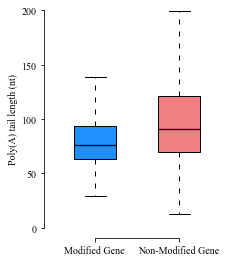

In [103]:
labels=["Modified Gene ","Non-Modified Gene"]
colors=['dodgerblue','lightcoral']
fig,ax = plt.subplots(figsize=(3,4))
plt.ylim(0,200) 
bplot = plt.boxplot([phe_2b_mod_pal,phe_2b_non_mod_pal], patch_artist=True, labels=labels,showfliers=False,widths=0.5)
for patch in bplot['whiskers']:
    patch.set_linestyle((0,(5,7)))
    patch.set_linewidth(1)
for patch in bplot['medians']:
    patch.set_linewidth(1.3)
    patch.set_color('black')
for patch,color in zip(bplot['boxes'],colors):
    patch.set_facecolor(color)

ax = plt.gca()
ax.set_ylabel('Poly(A) tail length (nt)')
sns.despine(ax = ax,trim=True,offset=10)
y_major_locator=MultipleLocator(50)
ax.yaxis.set_major_locator(y_major_locator)
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part4_m6a/Figure_mod_and_nomod_pal.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)

## **Part5 Illumina sequencing**

### **2. featureCounts version**

#### **(1). summarize row count**

In [13]:
def read_featurecount(file_path,file_name):
    df = pd.read_csv(file_path,sep='\t',skiprows=1,usecols=[0,6],names=['gene_id',file_name],header=0)
    df = df.sort_values(by=['gene_id'],key=lambda gene_name: gene_name.map(lambda gene_name : re.search('[0-9]{5}',str(gene_name)).group()),ignore_index=True)
    if list(df['gene_id']) != order_gene_list:
        print('Index order is inconsistent')
        raise IndexError
    df = df.set_index(['gene_id'])
    return df
def summarize_count(all_file,out_file):
    """Extract row count from multiple featurecounts output files and merge them into a dataframe.
       The index of the dataframe is the bamboo gene ID in ascending order

    Args:
        all_file : Comma-separated csv file, the first column is the path to the featurecount output file, and the second column is the sample symbol.
        out_file : output paht.
    """
    # file_path,file_name
    sum_count_df = pd.DataFrame()
    all_file_df = pd.read_csv(all_file,names=['file_path','file_name'])
    for row in all_file_df.iterrows():
        file_path = row[1]['file_path']
        file_name = row[1]['file_name']
        sum_count_df[file_name] = read_featurecount(file_path,file_name)
        sum_count_df.to_csv(out_file,sep='\t')

In [14]:
def row_count_2_TPM(count_df,gene_length_df,out_file):
    """Convert row cout to TPM.
    TPM = feature_fragement_count * 1000000 / feature_length * T ; T = ∑ feature_fragement_count / feature_length

    Args:
        count_df (dataframe): Row count dataframe ,the index must be in ascending order of gene ID.
        gene_length_df (series): Gene length series, the index must be in ascending order of gene ID.
        out_file : output path.
    """

    TPM_df = pd.DataFrame()
    for column in count_df.iteritems():
        if list(gene_length_df.index) != list(column[1].index):
            print('Index order is inconsistent')
            raise IndexError
        T = sum(column[1] / gene_length_df)
        T_length = gene_length_df * T
        TPM_df[column[0]] = (column[1] * 1000000) / T_length

        TPM_df.to_csv(out_file,sep='\t')

In [15]:
#merge all featurecount file
summarize_count('/home/litao/bigdata/phe_shoot/phe_shoot_illumina/all_count_file.txt','/home/litao/bigdata/phe_shoot/phe_shoot_illumina/06_featurecounts/all_row_count.csv')

#convert row count to TPM
all_count_df = pd.read_csv('/home/litao/bigdata/phe_shoot/phe_shoot_illumina/06_featurecounts/all_row_count.csv',sep='\t',index_col='gene_id')
gene_length_df = abs(anno_gene_level['tts'] - anno_gene_level['tss'] + 1)
row_count_2_TPM(all_count_df,gene_length_df,'/home/litao/bigdata/phe_shoot/phe_shoot_illumina/06_featurecounts/all_TPM.csv')

In [21]:
phe_all_tpm = pd.read_csv('/home/litao/bigdata/phe_shoot/phe_shoot_illumina/06_featurecounts/all_TPM.csv',sep='\t',index_col='gene_id')

In [78]:
#Get representative tpm values of technical replicates.
def get_representative_TPM(rep1,rep2,rep3):
    tpm_list = [rep1,rep2,rep3]
    # if max(tpm_list) >= 1 or np.median(tpm_list) >= 0.5:
    if np.mean(tpm_list) > 1:
        representative_tpm = np.mean(tpm_list)
        return representative_tpm
    else:
        return 0

In [82]:
phe_sample_TPM = pd.DataFrame()
phe_sample_TPM['phe_2B'] = phe_all_tpm[['Phe-2B-Rep1_L1','Phe-2B-Rep1_L2','Phe-2B-Rep1_L3']].apply(lambda row : get_representative_TPM(row['Phe-2B-Rep1_L1'],row['Phe-2B-Rep1_L1'],row['Phe-2B-Rep1_L1']),axis=1)
phe_sample_TPM['phe_2M'] = phe_all_tpm[['Phe-2M-Rep1_L1','Phe-2M-Rep1_L2','Phe-2M-Rep1_L3']].apply(lambda row : get_representative_TPM(row['Phe-2M-Rep1_L1'],row['Phe-2M-Rep1_L1'],row['Phe-2M-Rep1_L1']),axis=1)
phe_sample_TPM['phe_4B'] = phe_all_tpm[['Phe-4B-Rep1_L1','Phe-4B-Rep1_L2','Phe-4B-Rep1_L3']].apply(lambda row : get_representative_TPM(row['Phe-4B-Rep1_L1'],row['Phe-4B-Rep1_L1'],row['Phe-4B-Rep1_L1']),axis=1)
phe_sample_TPM['phe_4M'] = phe_all_tpm[['Phe-4M-Rep1_L1','Phe-4M-Rep1_L2','Phe-4M-Rep1_L3']].apply(lambda row : get_representative_TPM(row['Phe-4M-Rep1_L1'],row['Phe-4M-Rep1_L1'],row['Phe-4M-Rep1_L1']),axis=1)

phe_sample_TPM.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_illumina/06_featurecounts/sample_TPM.csv',sep='\t')

In [25]:
phe_sample_TPM = pd.read_csv('/home/litao/bigdata/phe_shoot/phe_shoot_illumina/06_featurecounts/sample_TPM.csv',sep='\t',index_col='gene_id')

In [4]:
phe_sample_TPM.loc[['PH02Gene06709','PH02Gene06710'],:]

phe_2B     phe_2M     phe_4B     phe_4M
gene_id                                                  
PH02Gene06709  45.303545  49.491723  37.065935  20.278828
PH02Gene06710  67.468271  76.365872  51.121321  35.792208

In [36]:
phe_2b_expression_gene_list = phe_sample_TPM[phe_sample_TPM['phe_2B'] > 0].index.to_list()
phe_2m_expression_gene_list = phe_sample_TPM[phe_sample_TPM['phe_2M'] > 0].index.to_list()
phe_4b_expression_gene_list = phe_sample_TPM[phe_sample_TPM['phe_4B'] > 0].index.to_list()
phe_4m_expression_gene_list = phe_sample_TPM[phe_sample_TPM['phe_4M'] > 0].index.to_list()

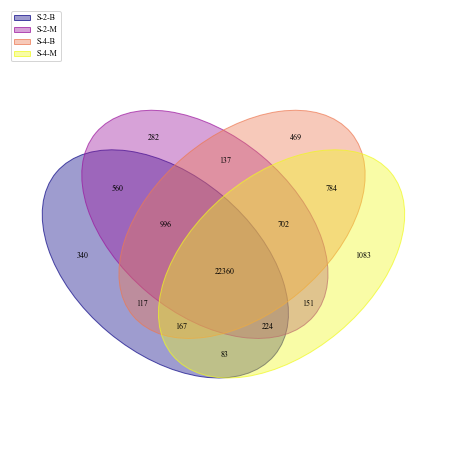

In [16]:
phe_2b_expression_gene_list = set(phe_2b_expression_gene_list)
phe_2m_expression_gene_list = set(phe_2m_expression_gene_list)
phe_4b_expression_gene_list = set(phe_4b_expression_gene_list)
phe_4m_expression_gene_list = set(phe_4m_expression_gene_list)
cmap = ["cool", list("rgb"), "plasma", "viridis", "Set1"]
data_dict = {"S-2-B":phe_2b_expression_gene_list,"S-2-M":phe_2m_expression_gene_list,"S-4-B":phe_4b_expression_gene_list,"S-4-M":phe_4m_expression_gene_list}
venn(data_dict,fontsize=8, legend_loc="upper left",cmap="plasma")   #data_dict Must be a set (that is, no duplicates)
#venn(data_dict,fmt="{percentage:.1f}%",fontsize=8, legend_loc="upper left",cmap="plasma")   #Show percentage
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part5_illumina/Figure.all_expression_gene_venn_plot.svg', format='svg', dpi=600, bbox_inches='tight',transparent = True)

In [8]:
print(len(phe_sample_TPM[phe_sample_TPM['phe_2B'] > 0]))
print(len(phe_sample_TPM[phe_sample_TPM['phe_2M'] > 0]))
print(len(phe_sample_TPM[phe_sample_TPM['phe_4B'] > 0]))
print(len(phe_sample_TPM[phe_sample_TPM['phe_4M'] > 0]))
print(len(phe_sample_TPM.replace(0,np.nan).dropna(axis=0,how='all'))) #total detected gene number
print(len(phe_sample_TPM.replace(0,np.nan).dropna(axis=0,how='any'))) #expression gene number in all four sample

24847
25412
25732
25554
28455
22360


#### **(3). function gene**

In [44]:
lignin_gene_list_tpm = phe_sample_TPM[phe_sample_TPM.index.isin(lignin_gene_list['Gene assembly name'])]
lignin_gene_list_tpm.replace(0,np.nan,inplace=True)
lignin_gene_list_tpm = lignin_gene_list_tpm.merge(lignin_gene_list[['Gene assembly name','Arabidopsis']],how='left',left_index=True,right_on='Gene assembly name',sort=False)[['phe_2B','phe_2M','phe_4B','phe_4M','Arabidopsis']]
lignin_gene_list_tpm_agg = lignin_gene_list_tpm.groupby(['Arabidopsis']).agg(np.nanmean)
lignin_gene_list_tpm_agg.replace(np.nan,1,inplace=True)


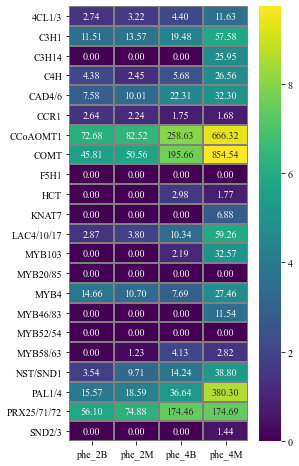

In [72]:
fig, ax = plt.subplots(1,1,figsize=(4,8))
sns.heatmap(lignin_gene_list_tpm_agg.apply(np.log2),cmap="viridis",annot=lignin_gene_list_tpm_agg.replace(1,0),linewidths=0.3,linecolor='grey',fmt='.2f',ax=ax)
ax.set_ylabel('')
# plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part5_illumina/Figure.lignin_gene_heatmap.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)

In [97]:
gt43_gene_tpm = phe_sample_TPM[phe_sample_TPM.index.isin(gt43_gene_list['Gene assembly name'])]

In [88]:
gt43_gene_tpm

phe_2B     phe_2M     phe_4B      phe_4M
gene_id                                                   
PH02Gene00093   4.341807   8.915333  15.267389   43.106301
PH02Gene00471  17.970787  34.231498  59.315529  136.034821
PH02Gene01387   7.554823  12.984872  15.278909   32.388336
PH02Gene04283  12.039379  19.537402  24.769396   41.506323
PH02Gene04386  14.973100  17.962070  25.273037   41.062470
PH02Gene08988  21.006987  27.518126  56.501901  128.054140
PH02Gene15591   1.000000   1.000000   1.000000    1.000000
PH02Gene16643   9.219135  11.602239  29.040766   74.873924
PH02Gene37058  18.242529  27.366539  59.955617  102.914138
PH02Gene37303   1.034750   1.216944   1.828029    3.497549
PH02Gene38222   1.867298   3.944819  10.520628   46.235852
PH02Gene39249   2.416024   3.417790   7.023417    9.728163
PH02Gene39763   2.347622   5.558057  10.554222   52.048191
PH02Gene40286   3.447735   3.245145   6.145775   13.157809
PH02Gene41747   7.320021   7.519069  12.854483   35.307353
PH02Gene44132   1.047276   1.516786   3.791990    4.955844
PH02Gene45587   5.362445   8.901231  16.499238   31.738730

In [98]:
# gt43_gene_tpm.replace(0,np.nan,inplace=True)
# gt43_gene_tpm.dropna(how='all',inplace=True)
# gt43_gene_tpm.replace(np.nan,1,inplace=True)
gt43_gene_tpm.replace(0,1,inplace=True)

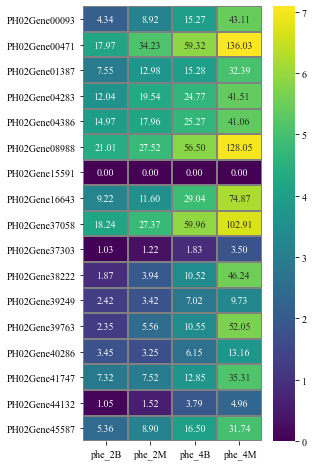

In [100]:
fig, ax = plt.subplots(1,1,figsize=(4,8))
sns.heatmap(gt43_gene_tpm.apply(np.log2),cmap="viridis",annot=gt43_gene_tpm.replace(1,0),linewidths=0.3,linecolor='grey',fmt='.2f',ax=ax)
ax.set_ylabel('')
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part5_illumina/Figure.gt43_gene_heatmap.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)


In [7]:
ratio_list = []
for ratio_df in [phe_2b_ratio_df,phe_2m_ratio_df,phe_4b_ratio_df,phe_4m_ratio_df]:
    # ratio_df[ratio_df['gene_name'].isin(lignin_gene_list['Gene assembly name'])]['mod_ratio'].apply('median')
    ratio_list.append(list(ratio_df[ratio_df['gene_name'].isin(lignin_gene_list['Gene assembly name'])]['mod_ratio']))

In [8]:
phe_2b_ratio_median = phe_2b_ratio_df['mod_ratio'].apply('median')
phe_2m_ratio_median = phe_2m_ratio_df['mod_ratio'].apply('median')
phe_4b_ratio_median = phe_4b_ratio_df['mod_ratio'].apply('median')
phe_4m_ratio_median = phe_4m_ratio_df['mod_ratio'].apply('median')

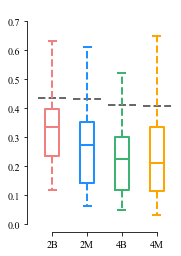

In [9]:
fig = plt.figure(figsize=(2.5,4))  
ax = plt.subplot()  
sample = ratio_list

colors = ["lightcoral", "dodgerblue", "mediumseagreen","orange"]
colors_r = ["lightcoral", "lightcoral","dodgerblue","dodgerblue",  "mediumseagreen","mediumseagreen","orange","orange"]
labels = ["2B","2M","4B","4M"]


plt.ylim(0,.75)
bplot = plt.boxplot(sample, patch_artist=False,labels=labels,widths=0.4,showfliers=False)
for patch, color in zip(bplot['medians'], colors):
    patch.set_color(color)
    patch.set_linewidth(2)
for patch, color in zip(bplot['boxes'], colors):
    patch.set_linewidth(2)
    patch.set_color(color)
for patch, color in zip(bplot['whiskers'], colors_r):
    patch.set_linewidth(2)
    patch.set_color(color)
    patch.set_linestyle('--')
for patch, color in zip(bplot['caps'], colors_r):
    patch.set_linewidth(2)
    patch.set_color(color)

ax.hlines(phe_2b_ratio_median, .6, 1.4, color='dimgrey',linestyle='dashed', linewidth=2)
ax.hlines(phe_2m_ratio_median, 1.6, 2.4, color='dimgrey',linestyle='dashed', linewidth=2)
ax.hlines(phe_4b_ratio_median, 2.6, 3.4, color='dimgrey',linestyle='dashed', linewidth=2)
ax.hlines(phe_4m_ratio_median, 3.6, 4.4, color='dimgrey',linestyle='dashed', linewidth=2)


sns.despine(ax=ax,trim=True,offset=8)
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part5_illumina/Figure_lignin_gene_m6a_ratio.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)

In [9]:
gt43_ratio_list = []
for ratio_df in [phe_2b_ratio_df,phe_2m_ratio_df,phe_4b_ratio_df,phe_4m_ratio_df]:
    # ratio_df[ratio_df['gene_name'].isin(lignin_gene_list['Gene assembly name'])]['mod_ratio'].apply('median')
    gt43_gene_list.append(list(ratio_df[ratio_df['gene_name'].isin(gt43_gene_list['Gene assembly name'])]['mod_ratio']))

In [20]:
polya_lignin_list = []
for ratio_df in [gene_polya_info_2b,gene_polya_info_2m,gene_polya_info_4b,gene_polya_info_4m]:
    # ratio_df[ratio_df['gene_name'].isin(lignin_gene_list['Gene assembly name'])]['mod_ratio'].apply('median')
    polya_lignin_list.append(list(ratio_df[ratio_df.index.isin(lignin_gene_list['Gene assembly name'])]['median_length']))

In [21]:
median_polya_2b = polya_2b['polya_length'].apply('median')
median_polya_2m = polya_2m['polya_length'].apply('median')
median_polya_4b = polya_4b['polya_length'].apply('median')
median_polya_4m = polya_4m['polya_length'].apply('median')

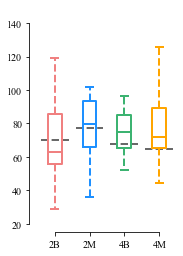

In [29]:
#lignin related gene polya tail length
fig = plt.figure(figsize=(2.5,4))  
ax = plt.subplot()  
sample = polya_lignin_list

colors = ["lightcoral", "dodgerblue", "mediumseagreen","orange"]
colors_r = ["lightcoral", "lightcoral","dodgerblue","dodgerblue",  "mediumseagreen","mediumseagreen","orange","orange"]
labels = ["2B","2M","4B","4M"]


plt.ylim(20,150)
bplot = plt.boxplot(sample, patch_artist=False,labels=labels,widths=0.4,showfliers=False)
for patch, color in zip(bplot['medians'], colors):
    patch.set_color(color)
    patch.set_linewidth(2)
for patch, color in zip(bplot['boxes'], colors):
    patch.set_linewidth(2)
    patch.set_color(color)
for patch, color in zip(bplot['whiskers'], colors_r):
    patch.set_linewidth(2)
    patch.set_color(color)
    patch.set_linestyle('--')
for patch, color in zip(bplot['caps'], colors_r):
    patch.set_linewidth(2)
    patch.set_color(color)

ax.hlines(median_polya_2b, .6, 1.4, color='dimgrey',linestyle='dashed', linewidth=2)
ax.hlines(median_polya_2m, 1.6, 2.4, color='dimgrey',linestyle='dashed', linewidth=2)
ax.hlines(median_polya_4b, 2.6, 3.4, color='dimgrey',linestyle='dashed', linewidth=2)
ax.hlines(median_polya_4m, 3.6, 4.4, color='dimgrey',linestyle='dashed', linewidth=2)


sns.despine(ax=ax,trim=True,offset=8)

plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part2_polya_tail/Figure_lignin_gene_polya_tail.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)

In [25]:
polya_gt43_list = []
for ratio_df in [gene_polya_info_2b,gene_polya_info_2m,gene_polya_info_4b,gene_polya_info_4m]:
    # ratio_df[ratio_df['gene_name'].isin(lignin_gene_list['Gene assembly name'])]['mod_ratio'].apply('median')
    polya_gt43_list.append(list(ratio_df[ratio_df.index.isin(gt43_gene_list['Gene assembly name'])]['median_length']))

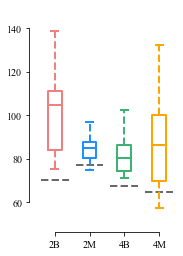

In [30]:
#GT43 gene polya tail length
fig = plt.figure(figsize=(2.5,4))  
ax = plt.subplot()  
sample = polya_gt43_list

colors = ["lightcoral", "dodgerblue", "mediumseagreen","orange"]
colors_r = ["lightcoral", "lightcoral","dodgerblue","dodgerblue",  "mediumseagreen","mediumseagreen","orange","orange"]
labels = ["2B","2M","4B","4M"]


plt.ylim(50,150)
bplot = plt.boxplot(sample, patch_artist=False,labels=labels,widths=0.4,showfliers=False)
for patch, color in zip(bplot['medians'], colors):
    patch.set_color(color)
    patch.set_linewidth(2)
for patch, color in zip(bplot['boxes'], colors):
    patch.set_linewidth(2)
    patch.set_color(color)
for patch, color in zip(bplot['whiskers'], colors_r):
    patch.set_linewidth(2)
    patch.set_color(color)
    patch.set_linestyle('--')
for patch, color in zip(bplot['caps'], colors_r):
    patch.set_linewidth(2)
    patch.set_color(color)

ax.hlines(median_polya_2b, .6, 1.4, color='dimgrey',linestyle='dashed', linewidth=2)
ax.hlines(median_polya_2m, 1.6, 2.4, color='dimgrey',linestyle='dashed', linewidth=2)
ax.hlines(median_polya_4b, 2.6, 3.4, color='dimgrey',linestyle='dashed', linewidth=2)
ax.hlines(median_polya_4m, 3.6, 4.4, color='dimgrey',linestyle='dashed', linewidth=2)


sns.despine(ax=ax,trim=True,offset=8)
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part2_polya_tail/Figure_gt43_gene_polya_tail.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)

#### **(2). DEseq2**

In [37]:
#deseq2 file
deseq2_2b_vs_2m_file = '/home/litao/bigdata/phe_shoot/phe_shoot_illumina/07_deseq2/deseq2_2B_vs_2M.csv'
deseq2_2b_vs_4b_file = '/home/litao/bigdata/phe_shoot/phe_shoot_illumina/07_deseq2/deseq2_2B_vs_4B.csv'
deseq2_2m_vs_4m_file = '/home/litao/bigdata/phe_shoot/phe_shoot_illumina/07_deseq2/deseq2_2M_vs_4M.csv'
deseq2_4b_vs_4m_file = '/home/litao/bigdata/phe_shoot/phe_shoot_illumina/07_deseq2/deseq2_4B_vs_4M.csv'

#deseq2_df
deseq2_2b_vs_2m = pd.read_csv(deseq2_2b_vs_2m_file,header=0,sep='\t',names=['gene_id', 'baseMean', 'log2FoldChange', 'lfcSE','stat','pvalue','padj'])
deseq2_2b_vs_4b = pd.read_csv(deseq2_2b_vs_4b_file,header=0,sep='\t',names=['gene_id', 'baseMean', 'log2FoldChange', 'lfcSE','stat','pvalue','padj'])
deseq2_2m_vs_4m = pd.read_csv(deseq2_2m_vs_4m_file,header=0,sep='\t',names=['gene_id', 'baseMean', 'log2FoldChange', 'lfcSE','stat','pvalue','padj'])
deseq2_4b_vs_4m = pd.read_csv(deseq2_4b_vs_4m_file,header=0,sep='\t',names=['gene_id', 'baseMean', 'log2FoldChange', 'lfcSE','stat','pvalue','padj'])

#select DEG gene (FC >= 2, padj <= .05)
deg_2b_vs_2m = deseq2_2b_vs_2m[(abs(deseq2_2b_vs_2m['log2FoldChange']) >= np.log2(2)) & (deseq2_2b_vs_2m['padj'] <= .05)]
deg_2b_vs_4b = deseq2_2b_vs_4b[(abs(deseq2_2b_vs_4b['log2FoldChange']) >= np.log2(2)) & (deseq2_2b_vs_4b['padj'] <= .05)]
deg_2m_vs_4m = deseq2_2m_vs_4m[(abs(deseq2_2m_vs_4m['log2FoldChange']) >= np.log2(2)) & (deseq2_2m_vs_4m['padj'] <= .05)]
deg_4b_vs_4m = deseq2_4b_vs_4m[(abs(deseq2_4b_vs_4m['log2FoldChange']) >= np.log2(2)) & (deseq2_4b_vs_4m['padj'] <= .05)]

filter_num_2b_vs_2m = len(deg_2b_vs_2m[~(deg_2b_vs_2m['gene_id'].isin(phe_2b_expression_gene_list)) & ~(deg_2b_vs_2m['gene_id'].isin(phe_2m_expression_gene_list))])
filter_num_2b_vs_4b = len(deg_2b_vs_4b[~(deg_2b_vs_4b['gene_id'].isin(phe_2b_expression_gene_list)) & ~(deg_2b_vs_4b['gene_id'].isin(phe_4b_expression_gene_list))])
filter_num_2m_vs_4m = len(deg_2m_vs_4m[~(deg_2m_vs_4m['gene_id'].isin(phe_2m_expression_gene_list)) & ~(deg_2m_vs_4m['gene_id'].isin(phe_4m_expression_gene_list))])
filter_num_4b_vs_4m = len(deg_4b_vs_4m[~(deg_4b_vs_4m['gene_id'].isin(phe_4b_expression_gene_list)) & ~(deg_4b_vs_4m['gene_id'].isin(phe_4m_expression_gene_list))])

# Filter out DEGs that are unexpressed in all two samples
deg_2b_vs_2m = deg_2b_vs_2m[(deg_2b_vs_2m['gene_id'].isin(phe_2b_expression_gene_list)) | (deg_2b_vs_2m['gene_id'].isin(phe_2m_expression_gene_list))]
deg_2b_vs_4b = deg_2b_vs_4b[(deg_2b_vs_4b['gene_id'].isin(phe_2b_expression_gene_list)) | (deg_2b_vs_4b['gene_id'].isin(phe_4b_expression_gene_list))]
deg_2m_vs_4m = deg_2m_vs_4m[(deg_2m_vs_4m['gene_id'].isin(phe_2m_expression_gene_list)) | (deg_2m_vs_4m['gene_id'].isin(phe_4m_expression_gene_list))]
deg_4b_vs_4m = deg_4b_vs_4m[(deg_4b_vs_4m['gene_id'].isin(phe_4b_expression_gene_list)) | (deg_4b_vs_4m['gene_id'].isin(phe_4m_expression_gene_list))]

# Filter out deseq2 row file that are unexpressed in all two samples
deseq2_2b_vs_2m = deseq2_2b_vs_2m[(deseq2_2b_vs_2m['gene_id'].isin(phe_2b_expression_gene_list)) | (deseq2_2b_vs_2m['gene_id'].isin(phe_2m_expression_gene_list))]
deseq2_2b_vs_4b = deseq2_2b_vs_4b[(deseq2_2b_vs_4b['gene_id'].isin(phe_2b_expression_gene_list)) | (deseq2_2b_vs_4b['gene_id'].isin(phe_4b_expression_gene_list))]
deseq2_2m_vs_4m = deseq2_2m_vs_4m[(deseq2_2m_vs_4m['gene_id'].isin(phe_2m_expression_gene_list)) | (deseq2_2m_vs_4m['gene_id'].isin(phe_4m_expression_gene_list))]
deseq2_4b_vs_4m = deseq2_4b_vs_4m[(deseq2_4b_vs_4m['gene_id'].isin(phe_4b_expression_gene_list)) | (deseq2_4b_vs_4m['gene_id'].isin(phe_4m_expression_gene_list))]


print('deg_2b_vs_2m: ' + 'Total ' + str(filter_num_2b_vs_2m) + ' DEGs that are unexpressed in all two samples,', 'remaining ' + str(len(deg_2b_vs_2m)) +' DEGs')
print('deg_2b_vs_4b: ' + 'Total ' + str(filter_num_2b_vs_4b) + ' DEGs that are unexpressed in all two samples,', 'remaining ' + str(len(deg_2b_vs_4b)) +' DEGs')
print('deg_2m_vs_4m: ' + 'Total ' + str(filter_num_2m_vs_4m) + ' DEGs that are unexpressed in all two samples,', 'remaining ' + str(len(deg_2m_vs_4m)) +' DEGs')
print('deg_4b_vs_4m: ' + 'Total ' + str(filter_num_4b_vs_4m) + ' DEGs that are unexpressed in all two samples,', 'remaining ' + str(len(deg_4b_vs_4m)) +' DEGs')

deg_2b_vs_2m: Total 453 DEGs that are unexpressed in all two samples, remaining 1096 DEGs
deg_2b_vs_4b: Total 1730 DEGs that are unexpressed in all two samples, remaining 5814 DEGs
deg_2m_vs_4m: Total 1798 DEGs that are unexpressed in all two samples, remaining 9515 DEGs
deg_4b_vs_4m: Total 1312 DEGs that are unexpressed in all two samples, remaining 5804 DEGs


In [10]:
all_degs = []
for i in [deg_2b_vs_2m,deg_2b_vs_4b,deg_2m_vs_4m,deg_4b_vs_4m]:
    all_degs.extend(i.gene_id)
print('Total ' + str(len(set(all_degs))) + ' DEGs')

Total 12061 DEGs


In [13]:
deg_2b_vs_4b

gene_id     baseMean  log2FoldChange     lfcSE       stat  \
12     PH02Gene00013    15.665900       -1.513276  0.478824  -3.160404   
14     PH02Gene00015     5.228783       -4.954581  1.298164  -3.816607   
17     PH02Gene00018  1712.695732       -1.438832  0.044042 -32.669209   
30     PH02Gene00031   121.270005       -1.402442  0.173645  -8.076480   
42     PH02Gene00043    29.147647       -1.311577  0.340897  -3.847428   
...              ...          ...             ...       ...        ...   
50845  PH02Gene51432    23.527043       -2.069497  0.394368  -5.247634   
50871  PH02Gene51458     4.350995       -5.649308  1.380295  -4.092826   
50873  PH02Gene51460    28.604827       -2.602622  0.383751  -6.782057   
50915  PH02Gene51502     6.341341        1.836866  0.757775   2.424025   
50933  PH02Gene51520     7.107458        1.669361  0.732377   2.279375   

              pvalue           padj  
12      1.575505e-03   3.425293e-03  
14      1.352992e-04   3.391998e-04  
17     4.276563e-234  4.122210e-232  
30      6.666297e-16   3.725333e-15  
42      1.193642e-04   3.008753e-04  
...              ...            ...  
50845   1.540647e-07   5.212666e-07  
50871   4.261477e-05   1.134646e-04  
50873   1.184767e-11   5.305583e-11  
50915   1.534956e-02   2.815709e-02  
50933   2.264476e-02   4.006642e-02  

[6637 rows x 7 columns]

In [101]:
#DEGs to file
list_to_csv(deg_2b_vs_2m.gene_id.to_list(),'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/01_go/deg_2b_vs_2m.csv')
list_to_csv(deg_2b_vs_4b.gene_id.to_list(),'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/01_go/deg_2b_vs_4b.csv')
list_to_csv(deg_2m_vs_4m.gene_id.to_list(),'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/01_go/deg_2m_vs_4m.csv')
list_to_csv(deg_4b_vs_4m.gene_id.to_list(),'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/01_go/deg_4b_vs_4m.csv')
list_to_csv(list(set(all_degs)),'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/01_go/all_degs.csv')

<AxesSubplot:>

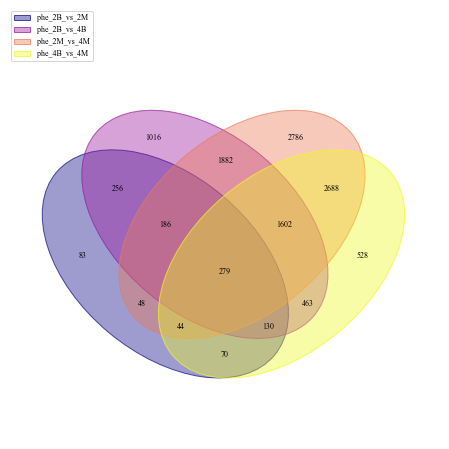

In [14]:
deg_2b_vs_2m_gene_list = set(deg_2b_vs_2m.gene_id)
deg_2b_vs_4b_gene_list = set(deg_2b_vs_4b.gene_id)
deg_2m_vs_4m_gene_list = set(deg_2m_vs_4m.gene_id)
deg_4b_vs_4m_gene_list = set(deg_4b_vs_4m.gene_id)
cmap = ["cool", list("rgb"), "plasma", "viridis", "Set1"]
data_dict = {"phe_2B_vs_2M":deg_2b_vs_2m_gene_list,"phe_2B_vs_4B":deg_2b_vs_4b_gene_list,"phe_2M_vs_4M":deg_2m_vs_4m_gene_list,"phe_4B_vs_4M":deg_4b_vs_4m_gene_list}
venn(data_dict,fontsize=8, legend_loc="upper left",cmap="plasma")   #data_dict Must be a set (that is, no duplicates)
#venn(data_dict,fmt="{percentage:.1f}%",fontsize=8, legend_loc="upper left",cmap="plasma")   #Show percentage

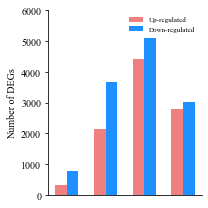

In [15]:
fig, ax = plt.subplots(figsize=(3,3))
labels = ['S-2-B vs S-2-M', 'S-2-B vs S-4-B', 'S-2-M vs S-4-M', 'S-4-B vs S-4-M']

# cg_num = np.array([len(phe_cg_2b_2m),len(phe_cg_2b_4b),len(phe_cg_2m_4m),len(phe_cg_4b_4m)]) / 100
# chg_num = np.array([len(phe_chg_2b_2m),len(phe_chg_2b_4b),len(phe_chg_2m_4m),len(phe_chg_4b_4m)]) / 100
# chh_num = np.array([len(phe_chh_2b_2m),len(phe_chh_2b_4b),len(phe_chh_2m_4m),len(phe_chh_4b_4m)]) / 100

# deg_2b_vs_2m_num = [len(deg_2b_vs_2m[deg_2b_vs_2m.log2FoldChange >= 1]),len(deg_2b_vs_2m[deg_2b_vs_2m.log2FoldChange <= -1])]
# deg_2b_vs_4b_num = [len(deg_2b_vs_4b[deg_2b_vs_4b.log2FoldChange >= 1]),len(deg_2b_vs_4b[deg_2b_vs_4b.log2FoldChange <= -1])]
# deg_2m_vs_4m_num = [len(deg_2m_vs_4m[deg_2m_vs_4m.log2FoldChange >= 1]),len(deg_2m_vs_4m[deg_2m_vs_4m.log2FoldChange <= -1])]
# deg_4b_vs_4m_num = [len(deg_4b_vs_4m[deg_4b_vs_4m.log2FoldChange >= 1]),len(deg_4b_vs_4m[deg_4b_vs_4m.log2FoldChange <= -1])]

up_regulated = [len(deg_2b_vs_2m[deg_2b_vs_2m.log2FoldChange >= 1]),len(deg_2b_vs_4b[deg_2b_vs_4b.log2FoldChange >= 1]),len(deg_2m_vs_4m[deg_2m_vs_4m.log2FoldChange >= 1]),len(deg_4b_vs_4m[deg_4b_vs_4m.log2FoldChange >= 1])]
down_regulated = [len(deg_2b_vs_2m[deg_2b_vs_2m.log2FoldChange <= -1]),len(deg_2b_vs_4b[deg_2b_vs_4b.log2FoldChange <= -1]),len(deg_2m_vs_4m[deg_2m_vs_4m.log2FoldChange <= -1]),len(deg_4b_vs_4m[deg_4b_vs_4m.log2FoldChange <= -1])]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

rects1 = ax.bar(x - width,up_regulated , width, label='Up-regulated',color='lightcoral')
rects2 = ax.bar(x , down_regulated, width, label='Down-regulated',color='dodgerblue')
# rects3 = ax.bar(x + width, chh_num, width, label='CHH',color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim(0,6000)
ax.set_ylabel('Number of DEGs')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(fontsize=7,frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

ax = plt.gca()
ax.axes.xaxis.set_ticks([]) 

fig.tight_layout()
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part5_illumina/Figure.DEG_number_bar_plot.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)

In [ ]:
fig, axes = plt.subplots(1,4,figsize=(20, 5))

for i,sample in zip(range(4),[deseq2_2b_vs_2m,deseq2_2b_vs_4b,deseq2_2m_vs_4m,deseq2_4b_vs_4m]):
    df=sample
    result = pd.DataFrame()
    result['x'] = df['log2FoldChange']
    result['y'] = df['padj'].apply(np.log10).apply(abs)

    #设置显著性阈值
    x_threshold=np.log2(2) #mean fold change >= 2
    y_threshold=-np.log10(0.05) #mean padj <= 0.05

    #分组为up, normal, down
    result['group'] = 'black'
    result.loc[(result.x > x_threshold)&(result.y > y_threshold),'group'] = 'tab:red' #x=-+x_threshold直接截断
    result.loc[(result.x < -x_threshold)&(result.y > y_threshold),'group'] = 'tab:blue' #x=-+x_threshold直接截断
    result.loc[result.y < y_threshold,'group'] = 'dimgrey' #阈值以下点为灰色

    up = len(result.loc[(result.x > x_threshold)&(result.y > y_threshold),'group'])
    down = len(result.loc[(result.x < -x_threshold)&(result.y > y_threshold),'group'])
    #确定坐标轴显示范围
    xmin=-10
    xmax=10
    ymin=0
    ymax=300

    #绘制散点图
    axes[i].set(xlim=(xmin, xmax), ylim=(ymin, ymax), title='')
    axes[i].scatter(result['x'], result['y'], s=2, color=result['group'])
    # axes[i].set_ylabel('-Log10(Q value)',fontweight='bold')
    # axes[i].set_xlabel('Log2 (fold change)',fontweight='bold')
    # axes[i].spines['right'].set_visible(False) #去掉右边框
    # axes[i].spines['top'].set_visible(False) #去掉上边框
    axes[i].set_xlabel('Log2 Fold change')
    axes[i].set_ylabel('-Log10 pvalue')

    axes[i].text(-5,ymax+20,"{} {}".format(down, "DOWN"),fontsize=10,c='tab:blue')
    axes[i].text(5,ymax+20,"{} {}".format(up, "UP"),fontsize=10,c='tab:red')
    #水平和竖直线
    axes[i].vlines(-x_threshold, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) #画竖直线
    axes[i].vlines(x_threshold, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) #画竖直线
    axes[i].hlines(y_threshold, xmin, xmax, color='dimgrey',linestyle='dashed', linewidth=1) #画竖水平线

    x_major_locator=MultipleLocator(1)
    axes[i].xaxis.set_major_locator(x_major_locator)


    #axes[i].set_xticks(range(-8,12,2)) #设置x轴刻度起点和步长
    #axes[i].set_yticks(range(-20,380,40)) #设置y轴刻度起点和步长

In [ ]:
enich_path = '/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/03_enrich/'
'deg_2b_vs_2m_go_bp.csv'
for sample in ['2b_vs_2m','2b_vs_4b','2m_vs_4m','4b_vs_4m']:
    for go_type in ['bp','cc','mf']:
        path = enich_path + 'deg_' + sample + '_go_' + go_type + '.csv'
         = pd.read_csv(path,sep='\t')

In [25]:
df = pd.read_csv('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/03_enrich/deg_2b_vs_2m_go_bp.csv',sep='\t')

### **3. rMATS**

In [32]:
index_list = ['RI','SE','A3SS','A5SS']
rmats_dict = {}
for sample in [('2B','2M'),('2B','4B'),('2M','4M'),('4B','4M')]:
    rmats_list = []
    for as_type in index_list:
        dic_path = ''.join(['Phe_',sample[0],'_vs_',sample[1]])
        path = '/home/litao/bigdata/phe_shoot/phe_shoot_illumina/09_rmats/' + dic_path + '/' + as_type + '.MATS.JC.txt'
        df = pd.read_csv(path,sep='\t')
        df = df[df['FDR'] <= .05]
        rmats_list.append(len(df))
        rmats_dict[''.join([sample[0],'_vs_',sample[1]])] = rmats_list
rmats_df = pd.DataFrame(rmats_dict,index=index_list)

In [33]:
rmats_df.apply('sum')

2B_vs_2M    6167
2B_vs_4B    8778
2M_vs_4M    7039
4B_vs_4M    8209
dtype: int64

In [25]:
gff_list=["seqid","source","type","start","end","score","strand","phase","attributes"]
nanopore_gff = pd.read_csv('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/04_stringtie/phe_nanopore_merge.gtf',names=gff_list,skiprows=2,sep='\t')

/home/litao/miniconda3/envs/jupyter-remote/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [63]:
def get_gene_id(attributes):
    gene_id = re.findall('"[\s\S]+?"', attributes)[0][1:-1]
    return gene_id
def get_reference_id(attributes):
    reference_id = re.findall('"[\s\S]+?"', attributes)[1]
    reference_id = reference_id[1:-1]
    if reference_id.startswith('PH02Gene'):
        reference_id = reference_id[:13]
        return reference_id
    else:
        return reference_id

In [64]:
nanopore_gff = nanopore_gff[nanopore_gff['type'] == 'transcript']
name_df = pd.DataFrame()
name_df['gene_id'] = nanopore_gff['attributes'].apply(get_gene_id)
name_df['reference_id'] = nanopore_gff['attributes'].apply(get_reference_id)

In [68]:
name_df_nanopore = name_df[name_df['reference_id'].str.contains('PH02Gene',regex=False)].drop_duplicates(subset=['gene_id'],keep=False).set_index(['gene_id'])

In [75]:
name_df_nanopore

reference_id
gene_id                     
MSTRG.4        PH02Gene41919
MSTRG.5        PH02Gene41920
MSTRG.6        PH02Gene50548
MSTRG.7        PH02Gene49229
MSTRG.8        PH02Gene49231
...                      ...
PH02Gene51518  PH02Gene51518
PH02Gene51519  PH02Gene51519
PH02Gene51520  PH02Gene51520
PH02Gene51521  PH02Gene51521
PH02Gene51522  PH02Gene51522

[49053 rows x 1 columns]

In [9]:
rmats = pd.read_csv('/home/litao/bigdata/phe_shoot/phe_shoot_illumina/09_rmats/Phe_2B_vs_4M/SE.MATS.JC.txt',sep='\t')

In [19]:
rmats[rmats['GeneID'] == 'MSTRG.42']

Empty DataFrame
Columns: [ID, GeneID, geneSymbol, chr, strand, exonStart_0base, exonEnd, upstreamES, upstreamEE, downstreamES, downstreamEE, ID.1, IJC_SAMPLE_1, SJC_SAMPLE_1, IJC_SAMPLE_2, SJC_SAMPLE_2, IncFormLen, SkipFormLen, PValue, FDR, IncLevel1, IncLevel2, IncLevelDifference]
Index: []

[0 rows x 23 columns]

In [22]:
rmats

ID         GeneID  geneSymbol                   chr strand  \
0          1  PH02Gene18729         NaN  chrhic_scaffold_3581      +   
1          2  PH02Gene27281         NaN     chrhic_scaffold_1      -   
2          3  PH02Gene40555         NaN     chrhic_scaffold_1      -   
3          7  PH02Gene17517         NaN     chrhic_scaffold_2      +   
4         10  PH02Gene28806         NaN     chrhic_scaffold_2      +   
...      ...            ...         ...                   ...    ...   
18368  19835    MSTRG.30892         NaN     chrhic_scaffold_7      -   
18369  19836    MSTRG.23597         NaN    chrhic_scaffold_24      +   
18370  19837    MSTRG.31347         NaN     chrhic_scaffold_8      -   
18371  19838    MSTRG.31347         NaN     chrhic_scaffold_8      -   
18372  19839    MSTRG.31347         NaN     chrhic_scaffold_8      -   

       exonStart_0base   exonEnd  upstreamES  upstreamEE  downstreamES  ...  \
0                14223     14280       13611       13692         14451  ...   
1             17173412  17173891    17171601    17172229      17174093  ...   
2             14067546  14069628    14066568    14066979      14071528  ...   
3             29151030  29151146    29150597    29150700      29151376  ...   
4             15572187  15572574    15572021    15572096      15583002  ...   
...                ...       ...         ...         ...           ...  ...   
18368         63690861  63691046    63690065    63690479      63691626  ...   
18369         68882250  68882355    68881619    68881807      68882557  ...   
18370         16599400  16599442    16598362    16598803      16599542  ...   
18371         16600033  16600092    16599798    16599939      16600300  ...   
18372         16600048  16600092    16599798    16599939      16600300  ...   

       SJC_SAMPLE_1  IJC_SAMPLE_2 SJC_SAMPLE_2 IncFormLen SkipFormLen  \
0             0,0,1         3,0,1        1,0,0        206         149   
1             0,0,0      21,12,21        3,0,0        298         149   
2             0,0,0         1,0,1        0,1,2        298         149   
3             0,0,1         6,0,0        0,2,1        265         149   
4             1,0,0         1,1,0        2,1,0        298         149   
...             ...           ...          ...        ...         ...   
18368      14,33,14         1,2,0     18,18,19        298         149   
18369    98,324,141       14,7,10     83,86,76        254         149   
18370   115,394,177         0,0,0  136,114,139        191         149   
18371    71,255,100         0,2,0    104,63,75        208         149   
18372    71,255,100         4,2,0    104,63,75        193         149   

         PValue       FDR          IncLevel1         IncLevel2  \
0      1.000000  1.000000         1.0,NA,0.0      0.685,NA,1.0   
1      0.676186  1.000000        1.0,1.0,1.0     0.778,1.0,1.0   
2      0.000179  0.003686        1.0,1.0,1.0       1.0,0.0,0.2   
3      1.000000  1.000000         1.0,NA,0.0       1.0,0.0,0.0   
4      1.000000  1.000000      0.818,1.0,1.0      0.2,0.333,NA   
...         ...       ...                ...               ...   
18368  0.766933  1.000000      0.0,0.015,0.0   0.027,0.053,0.0   
18369  0.006871  0.062841  0.035,0.026,0.044  0.09,0.046,0.072   
18370  1.000000  1.000000  0.013,0.002,0.004       0.0,0.0,0.0   
18371  1.000000  1.000000    0.0,0.003,0.007     0.0,0.022,0.0   
18372  0.130052  0.557762  0.021,0.035,0.023   0.029,0.024,0.0   

       IncLevelDifference  
0                  -0.343  
1                   0.074  
2                   0.600  
3                   0.167  
4                   0.673  
...                   ...  
18368              -0.022  
18369              -0.034  
18370               0.006  
18371              -0.004  
18372               0.009  

[18373 rows x 23 columns]

In [72]:
index_list = ['RI','SE','A3SS','A5SS']
all_as_gene = []
for sample in [('2B','2M'),('2B','4B'),('2M','4M'),('4B','4M')]:
    rmats_list = []
    for as_type in index_list:
        dic_path = ''.join(['Phe_',sample[0],'_vs_',sample[1]])
        path = '/home/litao/bigdata/phe_shoot/phe_shoot_illumina/09_rmats/' + dic_path + '/' + as_type + '.MATS.JC.txt'
        df = pd.read_csv(path,sep='\t')
        df = df[df['FDR'] <= .05]
        gene_name_list = set(df['GeneID'].unique()) & set(name_df_nanopore.index)
        reference_id_list = name_df_nanopore.loc[gene_name_list,'reference_id']
        all_as_gene.extend(reference_id_list)

In [77]:
len(set(all_as_gene))

8218

In [79]:
list_to_csv(list(set(all_as_gene)),'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/01_go/all_as_gene.csv')

## **Part6 Bisulfite sequencing**

### **1. Genome-wide methylation profile**

#### **(1) Correlation of CG, CHG and CHH methylation among different samples**

In [6]:
#load correlation matrix
cg_corr = pd.read_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/01_corr_file/CG_corr_fast.csv',index_col=0,header=0,sep='\t')
chg_corr = pd.read_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/01_corr_file/CHG_corr_fast.csv',index_col=0,header=0,sep='\t')
chh_corr = pd.read_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/01_corr_file/CHH_corr_fast.csv',index_col=0,header=0,sep='\t')

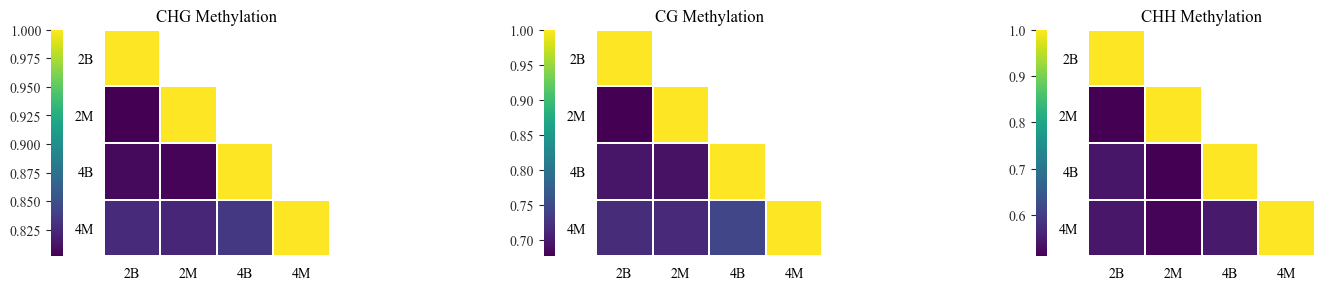

In [15]:
#Figure correlation_coefficient_heatmap
fig, axes = plt.subplots(1,3,figsize=(18, 3))
samples = [chg_corr,cg_corr,chh_corr]
labels = ['2B','2M','4B','4M']
titles = ['CHG Methylation','CG Methylation','CHH Methylation']
for sample,i,title in zip(samples,range(3),titles):
    mask = np.zeros_like(sample)
    mask[np.triu_indices_from(mask,k=1)] = True
    with sns.axes_style("white"):
        # f, ax = plt.subplots(figsize=(7, 5))
        sns.heatmap(sample, mask=mask,annot=False, annot_kws={'rotation':0},cmap="viridis",linewidths=0.3,square=True,cbar_kws={"use_gridspec":False,'location':'left'},ax=axes[i])
    #cbar = ax.collections[0].colorbar
    #cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=90, va='center')
    axes[i].yaxis.set_ticks_position('left')
    axes[i].xaxis.set_ticks_position('bottom')
    axes[i].tick_params(left=False,bottom=False)
    axes[i].set_xticklabels(labels,rotation=0)
    axes[i].set_yticklabels(labels)
    axes[i].set_title(title)

#2021-09-15
# plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part6_BS_seq/Figure6.1_DNA_methylation_correlation_coefficient_heatmap_anno.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part6_BS_seq/Figure6.1_DNA_methylation_correlation_coefficient_heatmap.ps', format='ps', dpi=600, bbox_inches='tight',transparent = True)

#### **(2) whole genome single sites methylation ratio**

In [65]:
#load whole genome methylation ratio
whole_genome_methylation_file = '/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/02_whole_genome_methylation/whole_genome_methylation_ratio.csv'
whole_genome_methylation_df = pd.read_csv(whole_genome_methylation_file,sep='\t',index_col=0)
#Convert dataframe format,adapted plot module
pt_whole_genome = pd.DataFrame(whole_genome_methylation_df.unstack()).reset_index()
pt_whole_genome.columns = ['period', 'CX', 'methy ratio']
pt_whole_genome.sort_values(['CX', 'period'], inplace=True)

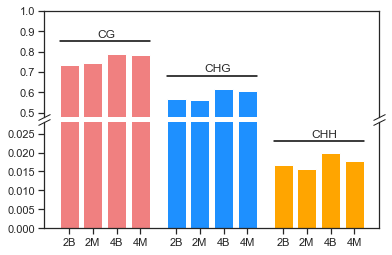

In [67]:
#Figure whole_genome_single_sites_methylation_ratio_bar_plot
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.05)  # adjust space between axes

# plot the same data on both axes
ax1.bar(x = [1,2,3,4, 5.5,6.5,7.5,8.5, 10,11,12,13], height = pt_whole_genome['methy ratio'],
       color = [y for y in ["lightcoral", "dodgerblue","orange"] for x in range(4)])
ax2.bar(x = [1,2,3,4, 5.5,6.5,7.5,8.5, 10,11,12,13], height = pt_whole_genome['methy ratio'],
       color = [y for y in ["lightcoral", "dodgerblue","orange"] for x in range(4)])


ax1.set_ylim(.48, 1.)  # outliers only
ax2.set_ylim(0, 0.028)  # most of the data
y_major_locator_ax1 = MultipleLocator(0.1)
y_major_locator_ax2 = MultipleLocator(0.005)
ax1.yaxis.set_major_locator(y_major_locator_ax1)
ax2.yaxis.set_major_locator(y_major_locator_ax2)

# hide the spines between ax and ax2
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('top')
ax1.tick_params(labeltop=False,top=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()



d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax2.set_xticks([1,2,3,4, 5.5,6.5,7.5,8.5, 10,11,12,13])
ax2.set_xticklabels([x for y in range(3) for x in ['2B','2M','4B','4M'] ])

ax1.plot([1 - 0.4, 4 + 0.4], [0.85,0.85],color = 'black')
ax1.plot([5.5 - 0.4, 8.5 + 0.4], [0.68,0.68],color = 'black')
ax2.plot([10 - 0.4, 13 + 0.4], [0.023,0.023],color = 'black')
ax1.text(x = 3-0.8,y = 0.87, s = "CG")
ax1.text(x = 7.5-0.8,y = 0.7, s = "CHG")
ax2.text(x = 12-0.8,y = 0.024, s = "CHH")

# 2021-12-22
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part6_BS_seq/Figure_whole_genome_single_sites_methylation_ratio_bar_plot_12-22.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)
# plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part6_BS_seq/Figure6.2_whole_genome_single_sites_methylation_ratio_bar_plot.ps', format='ps', dpi=600, bbox_inches='tight',transparent = True)

#### **(3) Global DNA methylation landscape in coding genes**

##### **(a) Aggregate the methylation percentage of a single cytosine site into 150 bins**

In [12]:
#  Important tips: Cytosine sites that are not covered by sequencing(that a modified number and an unmodified number of 0) 
#  will not be considered for the subsequent calculation of the methylation percentage of each bin.
def read_coding_gene_region(coding_gene_region_file):
    df = pd.read_csv(coding_gene_region_file,sep='\t')
    return df
def agg_rel_pos(coding_gene_region_rel_pos): 
    coding_gene_region_rel_pos = coding_gene_region_rel_pos[['methylation_percentage','gene_name','type','rel_pos']]
    #In this step, cytosine sites that have not been sequenced will be discarded
    coding_gene_region_rel_pos = coding_gene_region_rel_pos[coding_gene_region_rel_pos.methylation_percentage.notna()]
    cds_rel_pos_gene_level_agg = coding_gene_region_rel_pos.groupby(['type','gene_name','rel_pos']).agg('mean')
    # cds_rel_pos_bins_level_agg = coding_gene_region_rel_pos.groupby(['type','gene_name','rel_pos']).agg('mean').groupby(['type','rel_pos']).agg('mean')
    return cds_rel_pos_gene_level_agg

In [13]:
# coding_gene_region_dir = '/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/06_unfiter_coding_gene/'
# gene_level_rel_pos_dir = '/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/06_unfiter_coding_gene/02_gene_level_rel_pos/'
# samples = ['2B','2M','4B','4M']
# meth_types = ['CHG','CG','CHH']
# # 'coding_region_2B_CG.csv_coding_gene_region.csv'
# for sample in samples:
#     for meth_type in meth_types:
#         input_file_name = 'coding_region_' + sample + '_' + meth_type + '.csv_coding_gene_region.csv'
#         output_file_name = 'Phe-' + sample + '_' + meth_type + '_gene_level_rel_pos.csv'
#         input_path = os.path.join(coding_gene_region_dir,input_file_name)
#         output_path = os.path.join(gene_level_rel_pos_dir,output_file_name)
#         agg_rel_pos(read_coding_gene_region(input_path)).to_csv(output_path,sep='\t')

##### **(b) Filter genes whose distance between genes is less than 4000bp**

In [11]:
#Filter genes that are less than 2000bp from both ends of the scaffold
# This will only detect the first feature at both ends of the scaffold. 
# When the feature lenght is small, it may cause the feature that should be filtered out to pass the detection.
def take_gene_number(gene_name):
    return int(gene_name[-5:])
def filter_first_last_gene(anno_gene_level,scaffold_length):
    anno_gene_groups = anno_gene_level.groupby(['scaffold'])
    gene_list = []
    for scaffold in list(anno_gene_level.scaffold.unique()):
        anno_gene_part = anno_gene_groups.get_group(scaffold).copy()
        gene_list_temp = anno_gene_part.tss.to_list() + anno_gene_part.tts.to_list()
        max_num = max(gene_list_temp)
        min_num = min(gene_list_temp)
        max_length = scaffold_length.loc[scaffold] - max(gene_list_temp)
        if max_length < 2000:
            gene_name = anno_gene_part[(anno_gene_part['scaffold'] == scaffold) & ((anno_gene_part['tts'] == max_num) | (anno_gene_part['tss'] == max_num))].index.item()
            gene_list.append(gene_name)
        if min_num < 2000:
            gene_name = anno_gene_part[(anno_gene_part['scaffold'] == scaffold) & ((anno_gene_part['tts'] == min_num) | (anno_gene_part['tss'] == min_num))].index.item()
            gene_list.append(gene_name)
    gene_list = sorted(list(set(gene_list)),key=take_gene_number)
    return gene_list

In [12]:
#Filter genes whose distance between genes is less than 4000bp
def takeSecond(elem):
    return elem[1]
def take_gene_number(gene_name):
    return int(gene_name[-5:])
def interval_spacing(tuple_list,spacing):
    gene_list = []
    for i in range(len(tuple_list)-1):
        distance = tuple_list[i+1][1] - tuple_list[i][2] 
        if distance < spacing:
            gene_list.append(tuple_list[i][0])
            gene_list.append(tuple_list[i+1][0])
    gene_list = set(gene_list)
    return gene_list
def gene_interval(scaffold_df,spacing):
    gene_list = []
    scaffold_df_positive = scaffold_df[scaffold_df['strand'] == '+']
    scaffold_df_negative = scaffold_df[scaffold_df['strand'] == '-']
    if not scaffold_df_positive.empty:
        gene_list_positive = sorted(list(zip(scaffold_df_positive.index,scaffold_df_positive.tss,scaffold_df_positive.tts)),key=takeSecond)
        if len(gene_list_positive) > 1:
            gene_list.extend(interval_spacing(gene_list_positive,spacing))
    if not scaffold_df_negative.empty:
        gene_list_negative = sorted(list(zip(scaffold_df_positive.index,scaffold_df_negative.tts,scaffold_df_negative.tss)),key=takeSecond)
        if len(gene_list_negative) > 1:
            gene_list.extend(interval_spacing(gene_list_negative,spacing))
    return gene_list
def coding_gene_filter(gene_df,spacing):
    """ gene_df is anno_gene_lvel"""
    gene_list = []
    scaffolds = list(set(gene_df['scaffold']))
    for scaffold in scaffolds:
        scaffold_df = gene_df[gene_df['scaffold'] == scaffold]
        gene_list.extend(gene_interval(scaffold_df,spacing))
        gene_list = sorted(gene_list,key=take_gene_number)
    return gene_list

In [13]:
def gene_level_rel_pos_filter(gene_level_rel_pos_file,filter_gene_list):
    df = pd.read_csv(gene_level_rel_pos_file,sep='\t')
    df = df[~df['gene_name'].isin(filter_gene_list)]
    return df

def read_scaffold_length(fai_file):
    cx_list = ['scaffold','length','offset','LINEBASES','LINEWIDTH']
    fai_df = pd.read_csv(fai_file,sep='\t',names=cx_list,index_col='scaffold',
    dtype={'scaffold':str,'length':int,'offset':int,'LINEBASES':int,'LINEWIDTH':int})
    fai_df = fai_df['length']
    return fai_df

In [15]:
#Filter genes whose distance between genes is less than 4000bp
filter_between = coding_gene_filter(anno_gene_level,4000)

#Filter genes that are less than 2000bp from both ends of the scaffold
fai_df = read_scaffold_length('/home/litao/bigdata/phe_shoot/moso_genome/Bamboo.HIC.genome.fasta.fai')
filter_scaffold = filter_first_last_gene(anno_gene_level,fai_df)

#merge filter gene
filter_gene_list = list(set(filter_between) | set(filter_scaffold))

In [21]:
gene_level_rel_pos_dir = '/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/06_unfiter_coding_gene/02_gene_level_rel_pos/'
gene_level_rel_pos_filter_dir = '/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/06_unfiter_coding_gene/03_filter_gene_level_rel_pos/'
samples = ['2B','2M','4B','4M']
meth_types = ['CHG','CG','CHH']
for sample in samples:
    for meth_type in meth_types:
        input_file_name = 'Phe-' + sample + '_' + meth_type + '_gene_level_rel_pos.csv'
        output_file_name = 'Phe-' + sample + '_' + meth_type + '_gene_level_rel_pos_filter.csv'
        input_path = os.path.join(gene_level_rel_pos_dir,input_file_name)
        output_path = os.path.join(gene_level_rel_pos_filter_dir,output_file_name)
        gene_level_rel_pos_filter(input_path,filter_gene_list).to_csv(output_path,sep='\t',index=False)

##### **(c) Plot DNA methylation landscape in coding genes**

In [22]:
def read_rel_pos_csv(rel_pos_csv_file):
    df = pd.read_csv(rel_pos_csv_file,sep='\t',header=0,
    dtype={'type':str,'rel_pos':int,'methylation_percentage':float})
    df = df[df['methylation_percentage'].notna()]
    df = df.groupby(['type','rel_pos']).agg('mean')
    rel_pos_list = df.T[['cds_up','cds','cds_down']].loc['methylation_percentage',:].to_list()
    return rel_pos_list
def read_te_rel_pos_csv(rel_pos_csv_file):
    df = pd.read_csv(rel_pos_csv_file,sep='\t',header=0,
    dtype={'type':str,'rel_pos':int,'methylation_percentage':float},index_col='type')
    rel_pos_list = df.T[['te_up','te','te_down']].loc['methylation_percentage',:].to_list()
    return rel_pos_list

In [35]:
df = pd.read_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/06_unfiter_coding_gene/03_filter_gene_level_rel_pos/Phe-2B_CG_gene_level_rel_pos_filter.csv',sep='\t',header=0,dtype={'type':str,'rel_pos':int,'methylation_percentage':float})
df = df[df['methylation_percentage'].notna()]
df = df.groupby(['type','rel_pos']).agg('mean')

In [68]:
# coding gene profile
cg_rel_pos_list = []
for i in ['2B','2M','4B','4M']:
    file_name = ''.join(['Phe-',i,'_CG_gene_level_rel_pos_filter.csv'])
    path = os.path.join('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/06_unfiter_coding_gene/03_filter_gene_level_rel_pos/',file_name)
    cg_rel_pos_list.extend(read_rel_pos_csv(path))
chg_rel_pos_list = []
for i in ['2B','2M','4B','4M']:
    file_name = ''.join(['Phe-',i,'_CHG_gene_level_rel_pos_filter.csv'])
    path = os.path.join('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/06_unfiter_coding_gene/03_filter_gene_level_rel_pos/',file_name)
    chg_rel_pos_list.extend(read_rel_pos_csv(path))
chh_rel_pos_list = []
for i in ['2B','2M','4B','4M']:
    file_name = ''.join(['Phe-',i,'_CHH_gene_level_rel_pos_filter.csv'])
    path = os.path.join('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/06_unfiter_coding_gene/03_filter_gene_level_rel_pos/',file_name)
    chh_rel_pos_list.extend(read_rel_pos_csv(path))

In [69]:
types = [y for y in ['2B','2M','4B','4M'] for x in range(150)]
position = [x for y in range(4) for x in range(150) ]

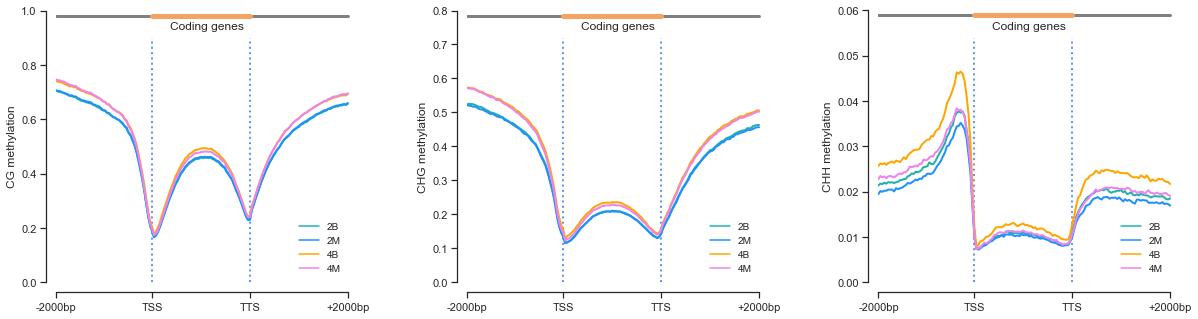

In [70]:
#Figure Global DNA methylation landscape in coding genes.
fig,axes = plt.subplots(1,3,figsize=(20, 5))
# colors = ["lightcoral", "dodgerblue","orange","violet"]
colors = ["lightseagreen", "dodgerblue","orange","violet"]
sns.set(style="ticks")
#CG methylation
axes[0].plot([49, 49], [0, 0.9], linestyle=':', lw = 2 , color = "cornflowerblue")
axes[0].plot([99, 99], [0, 0.9], linestyle=':', lw = 2 , color = "cornflowerblue")
axes[0].plot([0,149],[0.98,0.98], lw = 3, color = 'grey')
axes[0].plot([49,99], [0.98,0.98], lw = 5, color = "sandybrown")
sns.lineplot(x=position, y=cg_rel_pos_list,hue=types,
            palette=colors,linewidth=2, ax = axes[0])
axes[0].set_ylim(0, 1)
axes[0].set_xlim(0, 150)
axes[0].set_xticks([0,49,99,149])
# axes[i].set_yticks([0, 0.2, 0.4,0.6,0.8,1])
# axes[i].set_yticklabels([0, 0.2, 0.4,0.6,0.8,1])
axes[0].set_xticklabels(["-2000bp", "TSS", "TTS" , "+2000bp"])
axes[0].set_ylabel("CG methylation")
axes[0].text(58,0.93,'Coding genes')
axes[0].legend(loc='lower right',fontsize=10,frameon=False)
#CHG methylation
axes[1].plot([49, 49], [0, 0.9*.8], linestyle=':', lw = 2 , color = "cornflowerblue")
axes[1].plot([99, 99], [0, 0.9*.8], linestyle=':', lw = 2 , color = "cornflowerblue")
axes[1].plot([0,149],[0.98*.8,0.98*.8], lw = 3, color = 'grey')
axes[1].plot([49,99], [0.98*.8,0.98*.8], lw = 5, color = "sandybrown")
sns.lineplot(x=position, y=chg_rel_pos_list,hue=types,
            palette=colors,linewidth=2, ax = axes[1])
axes[1].set_ylim(0, 1*.8)
axes[1].set_xlim(0, 150)
axes[1].set_xticks([0,49,99,149])
# axes[i].set_yticks([0, 0.2, 0.4,0.6,0.8,1])
# axes[i].set_yticklabels([0, 0.2, 0.4,0.6,0.8,1])
axes[1].set_xticklabels(["-2000bp", "TSS", "TTS" , "+2000bp"])
axes[1].set_ylabel("CHG methylation")
axes[1].text(58,0.93*.8,'Coding genes')
axes[1].legend(loc='lower right',fontsize=10,frameon=False)
#CHH methylation
axes[2].plot([49, 49], [0,  0.9* 0.06], linestyle=':', lw = 2 , color = "cornflowerblue")
axes[2].plot([99, 99], [0,  0.9* 0.06], linestyle=':', lw = 2 , color = "cornflowerblue")
axes[2].plot([0,149],[0.059,0.059], lw = 3, color = 'grey')
axes[2].plot([49,99], [0.059,0.059], lw = 5, color = "sandybrown")
sns.lineplot(x=position, y=chh_rel_pos_list,hue=types,
            palette=colors,linewidth=2, ax = axes[2])
axes[2].set_ylim(0, 0.06)
axes[2].set_xlim(0, 150)
axes[2].set_xticks([0,49,99,149])
# axes[i].set_yticks([0, 0.2, 0.4,0.6,0.8,1])
# axes[i].set_yticklabels([0, 0.2, 0.4,0.6,0.8,1])
axes[2].set_xticklabels(["-2000bp", "TSS", "TTS" , "+2000bp"])
axes[2].set_ylabel("CHH methylation")
axes[2].text(58,0.93*0.06,'Coding genes')
axes[2].legend(loc='lower right',fontsize=10,frameon=False)

sns.despine(trim=True,offset=10)
plt.subplots_adjust(wspace=0.4)
# 2021-12-22
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part6_BS_seq/Figure_Global_DNA_methylation_landscape_in_coding_genes_12-22.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)
# plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part6_BS_seq/Figure6.3_Global_DNA_methylation_landscape_in_coding_genes.ps', format='ps', dpi=600, bbox_inches='tight',transparent = True)

#### **(4) Global DNA methylation landscape in transposable elements(TEs)**

In [15]:
# TEs profile
cg_rel_pos_list = []
for i in ['2B','2M','4B','4M']:
    file_name = ''.join(['Phe-',i,'_CG_te_agg.csv'])
    path = os.path.join('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/04_transposable_elements_region/',file_name)
    cg_rel_pos_list.extend(read_te_rel_pos_csv(path))
chg_rel_pos_list = []
for i in ['2B','2M','4B','4M']:
    file_name = ''.join(['Phe-',i,'_CHG_te_agg.csv'])
    path = os.path.join('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/04_transposable_elements_region/',file_name)
    chg_rel_pos_list.extend(read_te_rel_pos_csv(path))
chh_rel_pos_list = []
for i in ['2B','2M','4B','4M']:
    file_name = ''.join(['Phe-',i,'_CHH_te_agg.csv'])
    path = os.path.join('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/04_transposable_elements_region/',file_name)
    chh_rel_pos_list.extend(read_te_rel_pos_csv(path))

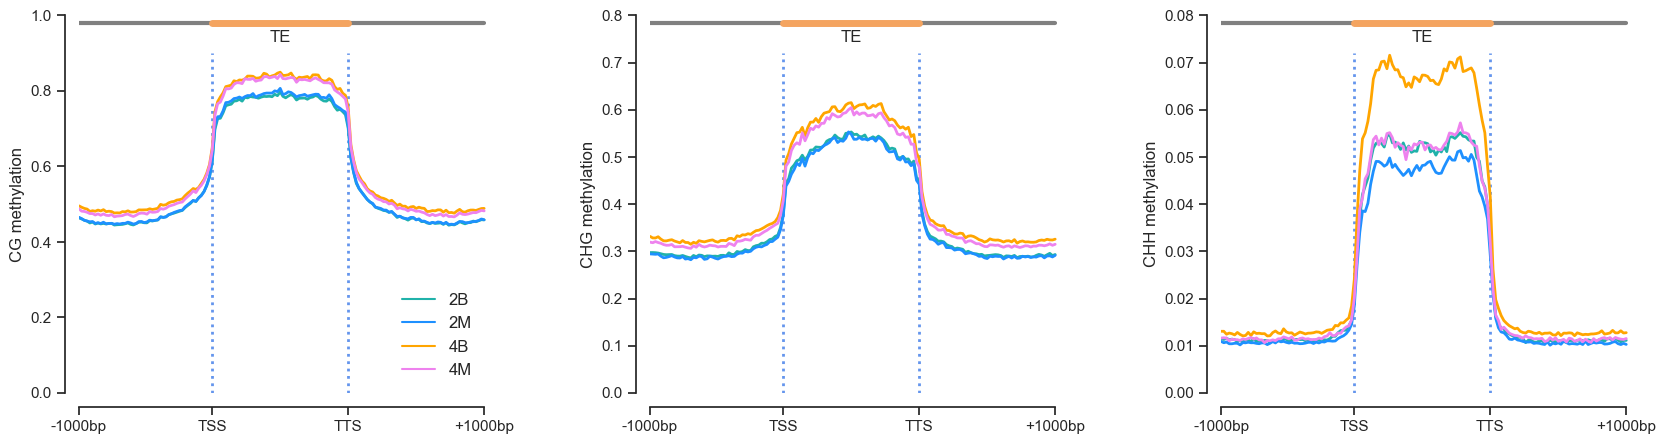

In [16]:
#Figure Global DNA methylation landscape in TEs.
fig,axes = plt.subplots(1,3,figsize=(20, 5))
# colors = ["lightcoral", "dodgerblue","orange","violet"]
colors = ["lightseagreen", "dodgerblue","orange","violet"]
sns.set(style="ticks")
#CG methylation
axes[0].plot([49, 49], [0, 0.9], linestyle=':', lw = 2 , color = "cornflowerblue")
axes[0].plot([99, 99], [0, 0.9], linestyle=':', lw = 2 , color = "cornflowerblue")
axes[0].plot([0,149],[0.98,0.98], lw = 3, color = 'grey')
axes[0].plot([49,99], [0.98,0.98], lw = 5, color = "sandybrown")
sns.lineplot(x=position, y=cg_rel_pos_list,hue=types,
            palette=colors,linewidth=2, ax = axes[0])
axes[0].set_ylim(0, 1)
axes[0].set_xlim(0, 150)
axes[0].set_xticks([0,49,99,149])
# axes[i].set_yticks([0, 0.2, 0.4,0.6,0.8,1])
# axes[i].set_yticklabels([0, 0.2, 0.4,0.6,0.8,1])
axes[0].set_xticklabels(["-1000bp", "TSS", "TTS" , "+1000bp"])
axes[0].set_ylabel("CG methylation")
axes[0].text(70,0.93,'TE')
axes[0].legend(loc='lower right',fontsize=12,frameon=False)
#CHG methylation
axes[1].plot([49, 49], [0, 0.9*.8], linestyle=':', lw = 2 , color = "cornflowerblue")
axes[1].plot([99, 99], [0, 0.9*.8], linestyle=':', lw = 2 , color = "cornflowerblue")
axes[1].plot([0,149],[0.98*.8,0.98*.8], lw = 3, color = 'grey')
axes[1].plot([49,99], [0.98*.8,0.98*.8], lw = 5, color = "sandybrown")
sns.lineplot(x=position, y=chg_rel_pos_list,hue=types,
            palette=colors,linewidth=2, ax = axes[1])
axes[1].set_ylim(0, 1*.8)
axes[1].set_xlim(0, 150)
axes[1].set_xticks([0,49,99,149])
# axes[i].set_yticks([0, 0.2, 0.4,0.6,0.8,1])
# axes[i].set_yticklabels([0, 0.2, 0.4,0.6,0.8,1])
axes[1].set_xticklabels(["-1000bp", "TSS", "TTS" , "+1000bp"])
axes[1].set_ylabel("CHG methylation")
axes[1].text(70,0.93*.8,'TE')
axes[1].legend(loc='lower right',fontsize=10,frameon=False)
axes[1].get_legend().remove()  # remove the lengend
#CHH methylation
axes[2].plot([49, 49], [0,  0.9*.08], linestyle=':', lw = 2 , color = "cornflowerblue")
axes[2].plot([99, 99], [0,  0.9*.08], linestyle=':', lw = 2 , color = "cornflowerblue")
axes[2].plot([0,149],[0.98*.08,0.98*.08], lw = 3, color = 'grey')
axes[2].plot([49,99], [0.98*.08,0.98*.08], lw = 5, color = "sandybrown")
sns.lineplot(x=position, y=chh_rel_pos_list,hue=types,
            palette=colors,linewidth=2, ax = axes[2])
axes[2].set_ylim(0, 0.08)
axes[2].set_xlim(0, 150)
axes[2].set_xticks([0,49,99,149])
# axes[i].set_yticks([0, 0.2, 0.4,0.6,0.8,1])
# axes[i].set_yticklabels([0, 0.2, 0.4,0.6,0.8,1])
axes[2].set_xticklabels(["-1000bp", "TSS", "TTS" , "+1000bp"])
axes[2].set_ylabel("CHH methylation")
axes[2].text(70,0.93*.08,'TE',fontsize=12)
axes[2].legend(loc='lower right',fontsize=10,frameon=False)
axes[2].get_legend().remove()

sns.despine(trim=True,offset=10)
plt.subplots_adjust(wspace=0.4)

# 2021-09-16
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part6_BS_seq/Figure6.4_Global_DNA_methylation_landscape_in_TE.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part6_BS_seq/Figure6.4_Global_DNA_methylation_landscape_in_TE.ps', format='ps', dpi=600, bbox_inches='tight',transparent = True)

#### **(5) Global DNA methylation landscape in m6A mod-gene and non-mod-gene**

In [47]:
def mod_and_non_mod_5mc(rel_pos_csv_file,phe_ratio_df):
    df = pd.read_csv(rel_pos_csv_file,sep='\t',header=0,
    dtype={'type':str,'gene_name':str,'rel_pos':int,'methylation_percentage':float})
    df = df[df['methylation_percentage'].notna()]
    m6a_mod_rel_pos = df[df['gene_name'].isin(phe_ratio_df.gene_name.unique())].groupby(['type','rel_pos']).agg('mean')
    m6a_non_mod_rel_pos = df[~df.gene_name.isin(phe_ratio_df.gene_name.unique())].groupby(['type','rel_pos']).agg('mean')
    m6a_mod_rel_pos_list = m6a_mod_rel_pos.T[['cds_up','cds','cds_down']].loc['methylation_percentage',:].to_list()
    m6a_non_mod_rel_pos_list = m6a_non_mod_rel_pos.T[['cds_up','cds','cds_down']].loc['methylation_percentage',:].to_list()
    return m6a_mod_rel_pos_list,m6a_non_mod_rel_pos_list

In [48]:
# coding gene profile
ratio_list = [phe_2b_ratio_df,phe_2m_ratio_df,phe_4b_ratio_df,phe_4m_ratio_df]
cg_m6a_mod_rel_pos_list = []
cg_m6a_non_mod_rel_pos_list = []        
for i,ratio in zip(['2B','2M','4B','4M'],ratio_list):
    file_name = ''.join(['Phe-',i,'_CG_gene_level_rel_pos_filter.csv'])
    path = os.path.join('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/06_unfiter_coding_gene/03_filter_gene_level_rel_pos/',file_name)
    cg_m6a_mod_rel_pos_list.extend(mod_and_non_mod_5mc(path,ratio)[0])
    cg_m6a_non_mod_rel_pos_list.extend(mod_and_non_mod_5mc(path,ratio)[1])
chg_m6a_mod_rel_pos_list = []
chg_m6a_non_mod_rel_pos_list = []
for i,ratio in zip(['2B','2M','4B','4M'],ratio_list):
    file_name = ''.join(['Phe-',i,'_CHG_gene_level_rel_pos_filter.csv'])
    path = os.path.join('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/06_unfiter_coding_gene/03_filter_gene_level_rel_pos/',file_name)
    chg_m6a_mod_rel_pos_list.extend(mod_and_non_mod_5mc(path,ratio)[0])
    chg_m6a_non_mod_rel_pos_list.extend(mod_and_non_mod_5mc(path,ratio)[1])
chh_m6a_mod_rel_pos_list = []
chh_m6a_non_mod_rel_pos_list = []
for i,ratio in zip(['2B','2M','4B','4M'],ratio_list):
    file_name = ''.join(['Phe-',i,'_CHH_gene_level_rel_pos_filter.csv'])
    path = os.path.join('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/06_unfiter_coding_gene/03_filter_gene_level_rel_pos/',file_name)
    chh_m6a_mod_rel_pos_list.extend(mod_and_non_mod_5mc(path,ratio)[0])
    chh_m6a_non_mod_rel_pos_list.extend(mod_and_non_mod_5mc(path,ratio)[1])

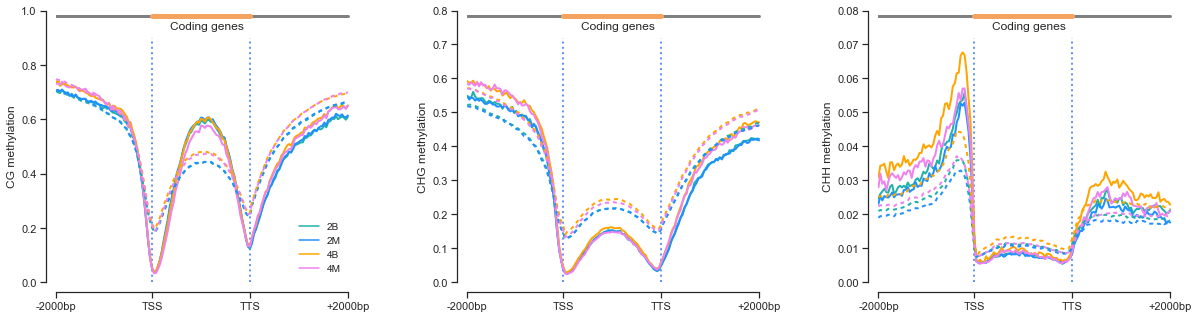

In [49]:
#Figure Global DNA methylation landscape in coding genes.
fig,axes = plt.subplots(1,3,figsize=(20, 5))
colors = ["lightseagreen", "dodgerblue","orange","violet"]
sns.set(style="ticks")
sf1,sf2,sf3 = (1,.8,.08)
#CG methylation
axes[0].plot([49, 49], [0, 0.9], linestyle=':', lw = 2 , color = "cornflowerblue")
axes[0].plot([99, 99], [0, 0.9], linestyle=':', lw = 2 , color = "cornflowerblue")
axes[0].plot([0,149],[0.98*sf1,0.98*sf1], lw = 3, color = 'grey')
axes[0].plot([49,99], [0.98*sf1,0.98*sf1], lw = 5, color = "sandybrown")
sns.lineplot(x=position, y=cg_m6a_mod_rel_pos_list,hue=types,
            palette=colors,linewidth=2, ax = axes[0])
sns.lineplot(x=position, y=cg_m6a_non_mod_rel_pos_list,hue=types,
            palette=colors,linewidth=2,linestyle=(0,(2,2)),legend=False, ax = axes[0])
axes[0].set_ylim(0, 1*sf1)
axes[0].set_xlim(0, 150)
axes[0].set_xticks([0,49,99,149])
# axes[i].set_yticks([0, 0.2, 0.4,0.6,0.8,1])
# axes[i].set_yticklabels([0, 0.2, 0.4,0.6,0.8,1])
axes[0].set_xticklabels(["-2000bp", "TSS", "TTS" , "+2000bp"])
axes[0].set_ylabel("CG methylation")
axes[0].text(58,0.93*sf1,'Coding genes')
axes[0].legend(loc='lower right',fontsize=10,frameon=False)
#CHG methylation
axes[1].plot([49, 49], [0, 0.9*sf2], linestyle=':', lw = 2 , color = "cornflowerblue")
axes[1].plot([99, 99], [0, 0.9*sf2], linestyle=':', lw = 2 , color = "cornflowerblue")
axes[1].plot([0,149],[0.98*sf2,0.98*sf2], lw = 3, color = 'grey')
axes[1].plot([49,99], [0.98*sf2,0.98*sf2], lw = 5, color = "sandybrown")
sns.lineplot(x=position, y=chg_m6a_mod_rel_pos_list,hue=types,
            palette=colors,linewidth=2,legend=False, ax = axes[1])
sns.lineplot(x=position, y=chg_m6a_non_mod_rel_pos_list,hue=types,
            palette=colors,linewidth=2,linestyle=(0,(2,2)),legend=False, ax = axes[1])
axes[1].set_ylim(0, 1*sf2)
axes[1].set_xlim(0, 150)
axes[1].set_xticks([0,49,99,149])
# axes[i].set_yticks([0, 0.2, 0.4,0.6,0.8,1])
# axes[i].set_yticklabels([0, 0.2, 0.4,0.6,0.8,1])
axes[1].set_xticklabels(["-2000bp", "TSS", "TTS" , "+2000bp"])
axes[1].set_ylabel("CHG methylation")
axes[1].text(58,0.93*sf2,'Coding genes')
# axes[1].legend(loc='lower right',fontsize=10,frameon=False)
#CHH methylation
axes[2].plot([49, 49], [0,  0.9*sf3], linestyle=':', lw = 2 , color = "cornflowerblue")
axes[2].plot([99, 99], [0,  0.9*sf3], linestyle=':', lw = 2 , color = "cornflowerblue")
axes[2].plot([0,149],[0.98*sf3,0.98*sf3], lw = 3, color = 'grey')
axes[2].plot([49,99], [0.98*sf3,0.98*sf3], lw = 5, color = "sandybrown")
sns.lineplot(x=position, y=chh_m6a_mod_rel_pos_list,hue=types,
            palette=colors,linewidth=2,legend=False, ax = axes[2])
sns.lineplot(x=position, y=chh_m6a_non_mod_rel_pos_list,hue=types,
            palette=colors,linewidth=2,linestyle=(0,(2,2)),legend=False, ax = axes[2])
axes[2].set_ylim(0, sf3)
axes[2].set_xlim(0, 150)
axes[2].set_xticks([0,49,99,149])
# axes[i].set_yticks([0, 0.2, 0.4,0.6,0.8,1])
# axes[i].set_yticklabels([0, 0.2, 0.4,0.6,0.8,1])
axes[2].set_xticklabels(["-2000bp", "TSS", "TTS" , "+2000bp"])
axes[2].set_ylabel("CHH methylation")
axes[2].text(58,0.93*sf3,'Coding genes')
# axes[2].legend(loc='lower right',fontsize=10,frameon=False)

sns.despine(trim=True,offset=10)
plt.subplots_adjust(wspace=0.4)
# plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part6_BS_seq/Figure_m6a_5mc.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)

### **2.Genome-wide differential DNA methylation profile**

#### **(1) The percentage of DMRs**

In [6]:
def read_DMR_csv(dmr_file):
    df = pd.read_csv(dmr_file,sep='\t',header=0)
    return df
def read_coding_gene_dmr(file):
    df = pd.read_csv(file,sep='\t')
    return df

In [13]:
def get_coding_gene_dmr(dmr_df,anno_gene_level,bins):
    anno_gene_level_cp = anno_gene_level.reset_index().rename(columns={'index':'gene_name'})[['gene_name','scaffold','tss','tts','strand']]
    
    anno_gene_level_groups = anno_gene_level_cp.groupby(['scaffold'])
    dmr_df_groups = dmr_df.groupby(['seqnames'])

    scaffold_dmr_list = []
    scaffolds = set(anno_gene_level.scaffold.unique()) & set(dmr_df.seqnames.unique())
    for scaffold in scaffolds:
        gene_dmr_list = []
        anno_gene_part = anno_gene_level_groups.get_group(scaffold).copy()
        dmr_df_part = dmr_df_groups.get_group(scaffold).copy()
        for row in anno_gene_part.iterrows():
            gene_name = row[1]['gene_name']
            start = min([row[1]['tss'],row[1]['tts']]) - bins
            end = max([row[1]['tss'],row[1]['tts']]) + bins
            dmr_df_gene_level = dmr_df_part[(dmr_df_part.start >= start) & (dmr_df_part.end <= end)].copy()
            if not dmr_df_gene_level.empty:
                dmr_df_gene_level.loc[:,'gene_name'] = gene_name
                gene_dmr_list.append(dmr_df_gene_level)
        if gene_dmr_list:
            scaffold_dmr_list.append(pd.concat(gene_dmr_list))
    df = pd.concat(scaffold_dmr_list)
    return df


In [6]:
def merge_dmarcaller_csv(dmrcaller_dir_path):
    dmr_df_list = []
    for root,dirs,files in os.walk(dmrcaller_dir_path,topdown=False):
        for single_file in files:
            single_df = read_DMR_csv(os.path.join(root,single_file))
            if not single_df.empty:
                dmr_df_list.append(single_df)
    df = pd.concat(dmr_df_list)
    # df = df.sort_values(by=['seqnames'],key=lambda gene_name: gene_name.map(lambda gene_name : re.search('[0-9]{5}',str(gene_name)).group()),ignore_index=True)
    return df
    
def select_error_log(csv_dir,log_dir):
    csv_file_list = []
    log_file_list = []
    for root,dirs,files in os.walk(csv_dir,topdown=False):
        for f in files:
            csv_file_list.append(f)
    for root,dirs,files in os.walk(log_dir,topdown=False):
        for f in files:
            log_file_list.append(f)
    error_log = set(log_file_list) - set(csv_file_list)
    return error_log

In [23]:
# merge multiple DMRcaller ouput csv file in single csv file
# vs_list = ['2B_vs_2M','2B_vs_4B','2M_vs_4M','4B_vs_4M']
# met_types = ['CG','CHG','CHH']
# for sample in vs_list:
#     for met_type in met_types:
#         path = os.path.join('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/02_dmrcaller/',sample,met_type,'csv')
#         file_name = ''.join(['DMRcaller_',met_type,'_',sample,'_merge.csv'])
#         output_path = os.path.join('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/01_merge_dmr',file_name)
#         df = merge_dmarcaller_csv(path)
#         df.to_csv(output_path,sep='\t',index=False,header=True)

In [8]:
phe_cg_2b_2m = read_DMR_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/01_merge_dmr/DMRcaller_CG_2B_vs_2M_merge.csv')
phe_cg_2b_4b = read_DMR_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/01_merge_dmr/DMRcaller_CG_2B_vs_4B_merge.csv')
phe_cg_2m_4m = read_DMR_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/01_merge_dmr/DMRcaller_CG_2M_vs_4M_merge.csv')
phe_cg_4b_4m = read_DMR_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/01_merge_dmr/DMRcaller_CG_4B_vs_4M_merge.csv')

phe_chg_2b_2m = read_DMR_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/01_merge_dmr/DMRcaller_CHG_2B_vs_2M_merge.csv')
phe_chg_2b_4b = read_DMR_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/01_merge_dmr/DMRcaller_CHG_2B_vs_4B_merge.csv')
phe_chg_2m_4m = read_DMR_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/01_merge_dmr/DMRcaller_CHG_2M_vs_4M_merge.csv')
phe_chg_4b_4m = read_DMR_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/01_merge_dmr/DMRcaller_CHG_4B_vs_4M_merge.csv')

phe_chh_2b_2m = read_DMR_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/01_merge_dmr/DMRcaller_CHH_2B_vs_2M_merge.csv')
phe_chh_2b_4b = read_DMR_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/01_merge_dmr/DMRcaller_CHH_2B_vs_4B_merge.csv')
phe_chh_2m_4m = read_DMR_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/01_merge_dmr/DMRcaller_CHH_2M_vs_4M_merge.csv')
phe_chh_4b_4m = read_DMR_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/01_merge_dmr/DMRcaller_CHH_4B_vs_4M_merge.csv')

In [12]:
phe_cg_2b_2m_coding_gene = get_coding_gene_dmr(phe_cg_2b_2m,anno_gene_level)
phe_cg_2b_4b_coding_gene = get_coding_gene_dmr(phe_cg_2b_4b,anno_gene_level)
phe_cg_2m_4m_coding_gene = get_coding_gene_dmr(phe_cg_2m_4m,anno_gene_level)
phe_cg_4b_4m_coding_gene = get_coding_gene_dmr(phe_cg_4b_4m,anno_gene_level)

phe_chg_2b_2m_coding_gene = get_coding_gene_dmr(phe_chg_2b_2m,anno_gene_level)
phe_chg_2b_4b_coding_gene = get_coding_gene_dmr(phe_chg_2b_4b,anno_gene_level)
phe_chg_2m_4m_coding_gene = get_coding_gene_dmr(phe_chg_2m_4m,anno_gene_level)
phe_chg_4b_4m_coding_gene = get_coding_gene_dmr(phe_chg_4b_4m,anno_gene_level)

phe_chh_2b_2m_coding_gene = get_coding_gene_dmr(phe_chh_2b_2m,anno_gene_level)
phe_chh_2b_4b_coding_gene = get_coding_gene_dmr(phe_chh_2b_4b,anno_gene_level)
phe_chh_2m_4m_coding_gene = get_coding_gene_dmr(phe_chh_2m_4m,anno_gene_level)
phe_chh_4b_4m_coding_gene = get_coding_gene_dmr(phe_chh_4b_4m,anno_gene_level)

In [41]:
# phe_cg_2b_2m_coding_gene.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/cg_2b_2m_coding_gene.csv',sep='\t',index=False)
# phe_cg_2b_4b_coding_gene.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/cg_2b_4b_coding_gene.csv',sep='\t',index=False)
# phe_cg_2m_4m_coding_gene.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/cg_2m_4m_coding_gene.csv',sep='\t',index=False)
# phe_cg_4b_4m_coding_gene.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/cg_4b_4m_coding_gene.csv',sep='\t',index=False)

# phe_chg_2b_2m_coding_gene.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/chg_2b_2m_coding_gene.csv',sep='\t',index=False)
# phe_chg_2b_4b_coding_gene.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/chg_2b_4b_coding_gene.csv',sep='\t',index=False)
# phe_chg_2m_4m_coding_gene.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/chg_2m_4m_coding_gene.csv',sep='\t',index=False)
# phe_chg_4b_4m_coding_gene.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/chg_4b_4m_coding_gene.csv',sep='\t',index=False)

# phe_chh_2b_2m_coding_gene.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/chh_2b_2m_coding_gene.csv',sep='\t',index=False)
# phe_chh_2b_4b_coding_gene.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/chh_2b_4b_coding_gene.csv',sep='\t',index=False)
# phe_chh_2m_4m_coding_gene.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/chh_2m_4m_coding_gene.csv',sep='\t',index=False)
# phe_chh_4b_4m_coding_gene.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/chh_4b_4m_coding_gene.csv',sep='\t',index=False)

In [7]:
phe_cg_2b_2m_coding_gene = read_coding_gene_dmr('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/cg_2b_2m_coding_gene.csv')
phe_cg_2b_4b_coding_gene = read_coding_gene_dmr('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/cg_2b_4b_coding_gene.csv')
phe_cg_2m_4m_coding_gene = read_coding_gene_dmr('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/cg_2m_4m_coding_gene.csv')
phe_cg_4b_4m_coding_gene = read_coding_gene_dmr('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/cg_4b_4m_coding_gene.csv')

phe_chg_2b_2m_coding_gene = read_coding_gene_dmr('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/chg_2b_2m_coding_gene.csv')
phe_chg_2b_4b_coding_gene = read_coding_gene_dmr('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/chg_2b_4b_coding_gene.csv')
phe_chg_2m_4m_coding_gene = read_coding_gene_dmr('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/chg_2m_4m_coding_gene.csv')
phe_chg_4b_4m_coding_gene = read_coding_gene_dmr('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/chg_4b_4m_coding_gene.csv')

phe_chh_2b_2m_coding_gene = read_coding_gene_dmr('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/chh_2b_2m_coding_gene.csv')
phe_chh_2b_4b_coding_gene = read_coding_gene_dmr('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/chh_2b_4b_coding_gene.csv')
phe_chh_2m_4m_coding_gene = read_coding_gene_dmr('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/chh_2m_4m_coding_gene.csv')
phe_chh_4b_4m_coding_gene = read_coding_gene_dmr('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/chh_4b_4m_coding_gene.csv')

In [11]:
#get all DMR gene
all_dmr_gene_list = []
for i in [phe_cg_2b_2m_coding_gene,phe_cg_2b_4b_coding_gene,phe_cg_2m_4m_coding_gene,phe_cg_4b_4m_coding_gene,phe_chg_2b_2m_coding_gene,phe_chg_2b_4b_coding_gene,phe_chg_2m_4m_coding_gene,phe_chg_4b_4m_coding_gene,phe_chh_2b_2m_coding_gene,phe_chh_2b_4b_coding_gene,phe_chh_2m_4m_coding_gene,phe_chh_4b_4m_coding_gene]:
    all_dmr_gene_list.extend(i['gene_name'].to_list())
all_dmr_gene_list = list(set(all_dmr_gene_list))
list_to_csv(all_dmr_gene_list,'/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/01_go/all_dmr_gene.csv')

In [13]:
#number of DMRs
pd.DataFrame([[len(phe_cg_2b_2m),len(phe_chg_2b_2m),len(phe_chh_2b_2m)],[len(phe_cg_2b_4b),len(phe_chg_2b_4b),len(phe_chh_2b_4b)],[len(phe_cg_2m_4m),len(phe_chg_2m_4m),len(phe_chh_2m_4m)],[len(phe_cg_4b_4m),len(phe_chg_4b_4m),len(phe_chh_4b_4m)]],index=['2bvs2m','2bvs4b','2mvs4m','4bvs4m'],columns=['CG','CHG','CHH'])

CG    CHG    CHH
2bvs2m  8459  18654   5027
2bvs4b  8984  18774  10410
2mvs4m  9969  20361   4566
4bvs4m  3359   7694   7703

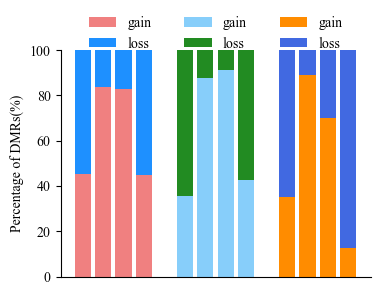

In [7]:
#Figure The percentage of differentially methylated regions (DMRs) gained or lost between consecutive periods

sample_list = [phe_cg_2b_2m,phe_cg_2b_4b,phe_cg_2m_4m,phe_cg_4b_4m,phe_chg_2b_2m,phe_chg_2b_4b,phe_chg_2m_4m,phe_chg_4b_4m,phe_chh_2b_2m,phe_chh_2b_4b,phe_chh_2m_4m,phe_chh_4b_4m]
gain_percentage = np.array([len(x[x['regionType'] == 'gain']) / len(x) for x in sample_list]) * 100
loss_percentage = np.array([len(x[x['regionType'] == 'loss']) / len(x) for x in sample_list]) * 100

fig, ax = plt.subplots(figsize=(4,3))
# labels = ['S-2-B vs S-2-M', 'S-2-B vs S-4-B', 'S-2-M vs S-4-M', 'S-4-B vs S-4-M'] * 3
x = np.arange(12)
width = 0.8    # the width of the bars: can also be len(x) sequence
colors = ["lightcoral", "dodgerblue","orange","violet"]
ax.bar(range(4) , gain_percentage[0:4], width, label='gain',color='lightcoral')
ax.bar(range(4) , loss_percentage[0:4], width, bottom=gain_percentage[0:4],label='loss',color='dodgerblue')

ax.bar(range(5,9) , gain_percentage[4:8], width, label='gain',color='lightskyblue')
ax.bar(range(5,9) , loss_percentage[4:8], width, bottom=gain_percentage[4:8],label='loss',color='forestgreen')

ax.bar(range(10,14) , gain_percentage[8:12], width, label='gain',color='darkorange')
ax.bar(range(10,14) , loss_percentage[8:12], width, bottom=gain_percentage[8:12],label='loss',color='royalblue')

ax.set_ylim(0,100)
# ax.set_xticks(range(14))
# ax.set_xticklabels([])

ax = plt.gca()
ax.axes.xaxis.set_ticks([])   #
# ax.axes.yaxis.set_ticks([])

ax.set_ylabel('Percentage of DMRs(%)',fontsize=10)
ax.legend(loc='center',fontsize=10,frameon=False,mode='expand',ncol=3,bbox_to_anchor=(0.05, 0.65, 0.9, 0.85))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# sns.despine(trim=True,offset=10)
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part6_BS_seq/Figure6.5_percentage_of_dmr.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part6_BS_seq/Figure6.5_percentage_of_dmr.ps', format='ps', dpi=600, bbox_inches='tight',transparent = True)

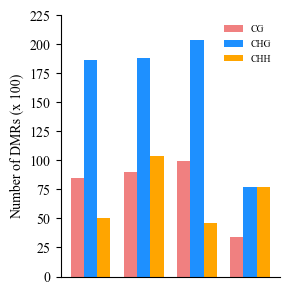

In [8]:
#Figure Overall numbers of DMRs
fig, ax = plt.subplots(figsize=(3,3))
labels = ['S-2-B vs S-2-M', 'S-2-B vs S-4-B', 'S-2-M vs S-4-M', 'S-4-B vs S-4-M']

cg_num = np.array([len(phe_cg_2b_2m),len(phe_cg_2b_4b),len(phe_cg_2m_4m),len(phe_cg_4b_4m)]) / 100
chg_num = np.array([len(phe_chg_2b_2m),len(phe_chg_2b_4b),len(phe_chg_2m_4m),len(phe_chg_4b_4m)]) / 100
chh_num = np.array([len(phe_chh_2b_2m),len(phe_chh_2b_4b),len(phe_chh_2m_4m),len(phe_chh_4b_4m)]) / 100

# phe_2b_2m_dmr_num = [len(phe_cg_2b_2m),len(phe_chg_2b_2m),len(phe_chh_2b_2m)]
# phe_2b_4b_dmr_num = [len(phe_cg_2b_4b),len(phe_chg_2b_4b),len(phe_chh_2b_4b)]
# phe_2m_4m_dmr_num = [len(phe_cg_2m_4m),len(phe_chg_2m_4m),len(phe_chh_2m_4m)]
# phe_4b_4m_dmr_num = [len(phe_cg_4b_4m),len(phe_chg_4b_4m),len(phe_chh_4b_4m)]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

rects1 = ax.bar(x - width,cg_num , width, label='CG',color='lightcoral')
rects2 = ax.bar(x , chg_num, width, label='CHG',color='dodgerblue')
rects3 = ax.bar(x + width, chh_num, width, label='CHH',color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim(0,225)
ax.set_ylabel('Number of DMRs (x 100)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(fontsize=7,frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

ax = plt.gca()
ax.axes.xaxis.set_ticks([]) 

fig.tight_layout()
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part6_BS_seq/Figure6.6_number_of_dmr.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part6_BS_seq/Figure6.6_number_of_dmr.ps', format='ps', dpi=600, bbox_inches='tight',transparent = True)

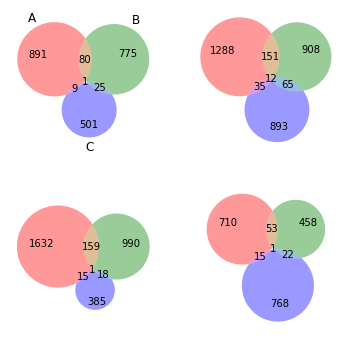

In [14]:
#Figure Comparison of DMR-containing genes
fig, axes = plt.subplots(2,2,figsize=(6,6))
v = venn3(subsets = [set(phe_cg_2b_2m_coding_gene['gene_name'].unique()),set(phe_chg_2b_2m_coding_gene['gene_name'].unique()),set(phe_chh_2b_2m_coding_gene['gene_name'].unique())],ax=axes[0,0],set_labels = ('A', 'B', 'C'))
venn3([set(phe_cg_2b_4b_coding_gene['gene_name'].unique()),set(phe_chg_2b_4b_coding_gene['gene_name'].unique()),set(phe_chh_2b_4b_coding_gene['gene_name'].unique())],ax=axes[0,1],
set_labels = ('', '', ''))
venn3([set(phe_cg_2m_4m_coding_gene['gene_name'].unique()),set(phe_chg_2m_4m_coding_gene['gene_name'].unique()),set(phe_chh_2m_4m_coding_gene['gene_name'].unique())],ax=axes[1,0],set_labels = ('', '', ''))
venn3([set(phe_cg_4b_4m_coding_gene['gene_name'].unique()),set(phe_chg_4b_4m_coding_gene['gene_name'].unique()),set(phe_chh_4b_4m_coding_gene['gene_name'].unique())],ax=axes[1,1],set_labels = ('', '', ''))

# h,l = [],[]
# for i,z,c in zip(('A', 'B', 'C'),['CG','CHG','CHH'],['lightcoral','dodgerblue','orange']):
#     # v.get_patch_by_id(i).set_color(c)
#     v.get_label_by_id(i).set_text("")
#     h.append(v.get_patch_by_id(i))
#     l.append(z)
# axes[0,0].legend(handles=h, labels=l,frameon=False,loc='lower left')
# plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part6_BS_seq/Figure6.7_venn_plot_of_dmr.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)
# plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part6_BS_seq/Figure6.7_venn_plot_of_dmr.ps', format='ps', dpi=600, bbox_inches='tight',transparent = True)

#### **(2) DMR distribution**

#### **(a) DMR distribution in coding gene**

In [ ]:
phe_cg_2b_2m_coding_gene_2000bp = get_coding_gene_dmr(phe_cg_2b_2m,anno_gene_level,2000)
phe_cg_2b_4b_coding_gene_2000bp = get_coding_gene_dmr(phe_cg_2b_4b,anno_gene_level,2000)
phe_cg_2m_4m_coding_gene_2000bp = get_coding_gene_dmr(phe_cg_2m_4m,anno_gene_level,2000)
phe_cg_4b_4m_coding_gene_2000bp = get_coding_gene_dmr(phe_cg_4b_4m,anno_gene_level,2000)

phe_chg_2b_2m_coding_gene_2000bp = get_coding_gene_dmr(phe_chg_2b_2m,anno_gene_level,2000)
phe_chg_2b_4b_coding_gene_2000bp = get_coding_gene_dmr(phe_chg_2b_4b,anno_gene_level,2000)
phe_chg_2m_4m_coding_gene_2000bp = get_coding_gene_dmr(phe_chg_2m_4m,anno_gene_level,2000)
phe_chg_4b_4m_coding_gene_2000bp = get_coding_gene_dmr(phe_chg_4b_4m,anno_gene_level,2000)

phe_chh_2b_2m_coding_gene_2000bp = get_coding_gene_dmr(phe_chh_2b_2m,anno_gene_level,2000)
phe_chh_2b_4b_coding_gene_2000bp = get_coding_gene_dmr(phe_chh_2b_4b,anno_gene_level,2000)
phe_chh_2m_4m_coding_gene_2000bp = get_coding_gene_dmr(phe_chh_2m_4m,anno_gene_level,2000)
phe_chh_4b_4m_coding_gene_2000bp = get_coding_gene_dmr(phe_chh_4b_4m,anno_gene_level,2000)

In [17]:
# phe_cg_2b_2m_coding_gene_2000bp.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/cg_2b_2m_coding_gene_2000bp.csv',sep='\t',index=False)
# phe_cg_2b_4b_coding_gene_2000bp.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/cg_2b_4b_coding_gene_2000bp.csv',sep='\t',index=False)
# phe_cg_2m_4m_coding_gene_2000bp.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/cg_2m_4m_coding_gene_2000bp.csv',sep='\t',index=False)
# phe_cg_4b_4m_coding_gene_2000bp.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/cg_4b_4m_coding_gene_2000bp.csv',sep='\t',index=False)

# phe_chg_2b_2m_coding_gene_2000bp.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/chg_2b_2m_coding_gene_2000bp.csv',sep='\t',index=False)
# phe_chg_2b_4b_coding_gene_2000bp.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/chg_2b_4b_coding_gene_2000bp.csv',sep='\t',index=False)
# phe_chg_2m_4m_coding_gene_2000bp.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/chg_2m_4m_coding_gene_2000bp.csv',sep='\t',index=False)
# phe_chg_4b_4m_coding_gene_2000bp.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/chg_4b_4m_coding_gene_2000bp.csv',sep='\t',index=False)

# phe_chh_2b_2m_coding_gene_2000bp.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/chh_2b_2m_coding_gene_2000bp.csv',sep='\t',index=False)
# phe_chh_2b_4b_coding_gene_2000bp.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/chh_2b_4b_coding_gene_2000bp.csv',sep='\t',index=False)
# phe_chh_2m_4m_coding_gene_2000bp.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/chh_2m_4m_coding_gene_2000bp.csv',sep='\t',index=False)
# phe_chh_4b_4m_coding_gene_2000bp.to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/chh_4b_4m_coding_gene_2000bp.csv',sep='\t',index=False)

In [12]:
phe_cg_2b_2m_coding_gene_2000bp = read_coding_gene_dmr('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/cg_2b_2m_coding_gene_2000bp.csv')
phe_cg_2b_4b_coding_gene_2000bp = read_coding_gene_dmr('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/cg_2b_4b_coding_gene_2000bp.csv')
phe_cg_2m_4m_coding_gene_2000bp = read_coding_gene_dmr('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/cg_2m_4m_coding_gene_2000bp.csv')
phe_cg_4b_4m_coding_gene_2000bp = read_coding_gene_dmr('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/cg_4b_4m_coding_gene_2000bp.csv')

phe_chg_2b_2m_coding_gene_2000bp = read_coding_gene_dmr('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/chg_2b_2m_coding_gene_2000bp.csv')
phe_chg_2b_4b_coding_gene_2000bp = read_coding_gene_dmr('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/chg_2b_4b_coding_gene_2000bp.csv')
phe_chg_2m_4m_coding_gene_2000bp = read_coding_gene_dmr('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/chg_2m_4m_coding_gene_2000bp.csv')
phe_chg_4b_4m_coding_gene_2000bp = read_coding_gene_dmr('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/chg_4b_4m_coding_gene_2000bp.csv')

phe_chh_2b_2m_coding_gene_2000bp = read_coding_gene_dmr('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/chh_2b_2m_coding_gene_2000bp.csv')
phe_chh_2b_4b_coding_gene_2000bp = read_coding_gene_dmr('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/chh_2b_4b_coding_gene_2000bp.csv')
phe_chh_2m_4m_coding_gene_2000bp = read_coding_gene_dmr('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/chh_2m_4m_coding_gene_2000bp.csv')
phe_chh_4b_4m_coding_gene_2000bp = read_coding_gene_dmr('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/02_DMRcaller/03_dmr_coding_gene/chh_4b_4m_coding_gene_2000bp.csv')

In [ ]:
phe_chh_2b_2m_coding_gene_2000bp,phe_chh_2b_4b_coding_gene_2000bp,phe_chh_2m_4m_coding_gene_2000bp,phe_chh_4b_4m_coding_gene_2000bp

In [14]:
def get_rel_pos(dmr_start,gene_name,anno_gene_level,bins=2000):
    strand = anno_gene_level.loc[gene_name,'strand']
    tss = anno_gene_level.loc[gene_name,'tss']
    tts = anno_gene_level.loc[gene_name,'tts']
    if strand == '+':
        if dmr_start < tss:
            dmr_rel_pos = (dmr_start - (tss - bins) + 1 ) / bins 
        elif dmr_start > tts:
            dmr_rel_pos = (dmr_start - tts ) / bins + 2
        else:
            dmr_rel_pos = (dmr_start - tss + 1) / (tts - tss + 1) + 1
    if strand == '-':
        if dmr_start > tss:
            dmr_rel_pos = (tss + bins - dmr_start + 1) / bins
        elif dmr_start < tts:
            dmr_rel_pos = (tts - dmr_start ) / bins + 2
        else:
            dmr_rel_pos = (tss - dmr_start + 1) / (tss - tts + 1) + 1
    return dmr_rel_pos

In [15]:
def get_sub_gene_mean_length(anno_gene_level,sub_gene_list):
    anno_gene_level = anno_gene_level[anno_gene_level.index.isin(sub_gene_list)]
    mean_gene_length = abs(anno_gene_level['tts'] - anno_gene_level['tss']).mean()
    return mean_gene_length

def dmr_rel_pos_rescale(rel_pos):
    sc = 2000 / 4515
    if rel_pos <= 1:
        rel_pos = rel_pos * sc
    elif rel_pos >2:
        rel_pos = (rel_pos - 2) * sc + 1 + sc
    else:
        rel_pos = (rel_pos - 1) + sc
    return rel_pos

In [19]:
samples = [phe_cg_2b_2m_coding_gene_2000bp,phe_cg_2b_4b_coding_gene_2000bp,phe_cg_2m_4m_coding_gene_2000bp,phe_cg_4b_4m_coding_gene_2000bp,
            phe_chg_2b_2m_coding_gene_2000bp,phe_chg_2b_4b_coding_gene_2000bp,phe_chg_2m_4m_coding_gene_2000bp,phe_chg_4b_4m_coding_gene_2000bp,
            phe_chh_2b_2m_coding_gene_2000bp,phe_chh_2b_4b_coding_gene_2000bp,phe_chh_2m_4m_coding_gene_2000bp,phe_chh_4b_4m_coding_gene_2000bp]
for sample in samples:
    sample.loc[:,'rel_pos'] = sample.apply(lambda row : get_rel_pos(row['start'],row['gene_name'],anno_gene_level,2000),axis=1)
    sample.loc[:,'scale_rel_pos'] = sample['rel_pos'].apply(dmr_rel_pos_rescale)

In [33]:
phe_cg_2b_2m_coding_gene_2000bp

seqnames     start       end  width strand  sumReadsM1  \
7069    hic_scaffold_18  34221508  34221607    100      *          13   
7072    hic_scaffold_18  34985508  34985607    100      *          24   
7079    hic_scaffold_18  35496408  35496507    100      *          37   
7086    hic_scaffold_18  36894708  36894807    100      *           5   
7087    hic_scaffold_18  36899908  36900007    100      *          26   
...                 ...       ...       ...    ...    ...         ...   
2149     hic_scaffold_8  45370326  45370425    100      *          17   
2150     hic_scaffold_8  45377826  45377925    100      *           9   
1368  hic_scaffold_4088      6153      6252    100      *           3   
7292  hic_scaffold_3158     13010     13109    100      *          21   
7293  hic_scaffold_3158     13410     13509    100      *           1   

      sumReadsN1  proportion1  sumReadsM2  sumReadsN2  proportion2  \
7069          20     0.650000           4          23     0.173913   
7072          48     0.500000          86          93     0.924731   
7079          39     0.948718          10          24     0.416667   
7086          86     0.058140          31          64     0.484375   
7087          56     0.464286          65          68     0.955882   
...          ...          ...         ...         ...          ...   
2149          26     0.653846           4          18     0.222222   
2150          60     0.150000          20          36     0.555556   
1368          28     0.107143          20          32     0.625000   
7292          38     0.552632          23          24     0.958333   
7293          16     0.062500          14          22     0.636364   

      cytosinesCount context  direction        pValue regionType  \
7069               5      CG         -1  2.389336e-03       loss   
7072              12      CG          1  1.890737e-07       gain   
7079               6      CG         -1  1.538918e-05       loss   
7086              15      CG          1  1.250166e-08       gain   
7087              12      CG          1  3.987741e-09       gain   
...              ...     ...        ...           ...        ...   
2149               4      CG         -1  6.680854e-03       loss   
2150               8      CG          1  1.371143e-04       gain   
1368               6      CG          1  4.510052e-05       gain   
7292               6      CG          1  5.314154e-04       gain   
7293               4      CG          1  5.314154e-04       gain   

          gene_name   rel_pos  scale_rel_pos  
7069  PH02Gene01252  0.840500       0.372315  
7072  PH02Gene01266  1.648242       0.730118  
7079  PH02Gene01279  1.699896       0.752999  
7086  PH02Gene01313  2.509000       1.668439  
7087  PH02Gene01313  1.653345       0.732379  
...             ...       ...            ...  
2149  PH02Gene49879  0.671000       0.297231  
2150  PH02Gene49880  1.848908       0.819007  
1368  PH02Gene26276  2.076500       1.476855  
7292  PH02Gene50482  1.152486       0.510514  
7293  PH02Gene50482  1.198728       0.530998  

[1755 rows x 19 columns]

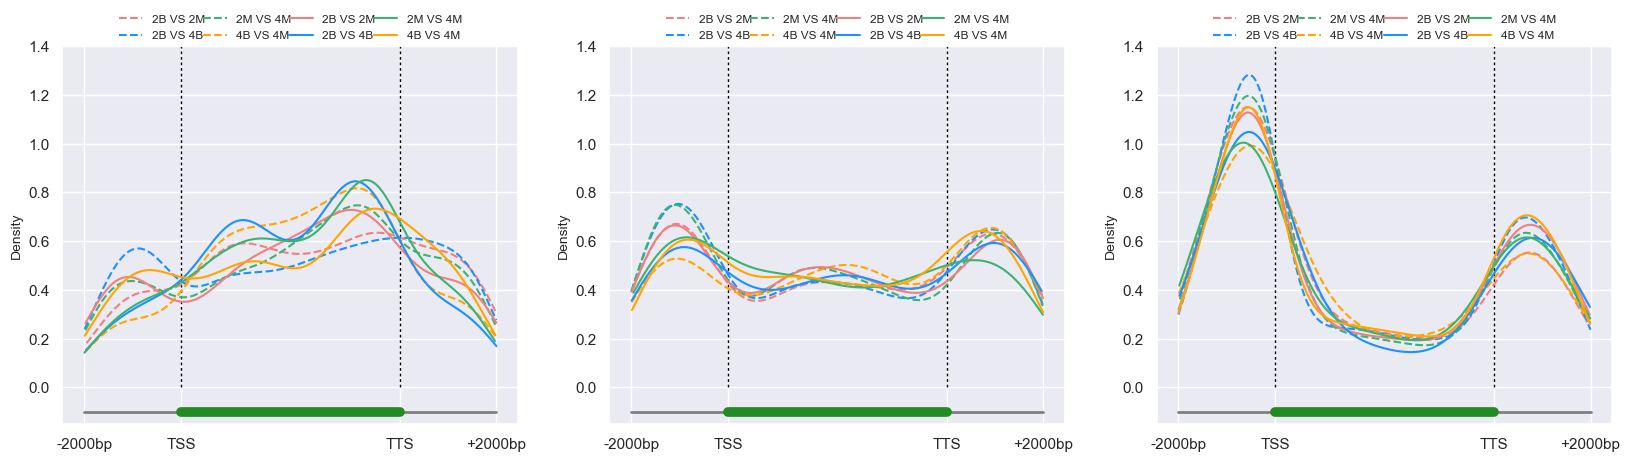

In [49]:
#Figure DMR distribution
f, axes = plt.subplots(1,3,figsize=(20, 5))
#f, ax = plt.subplots(1,1,figsize=(10, 6))
sns.set_theme()
# sns.axes_style()
# sns.set_style("darkgrid", {"axes.facecolor": ".9"})
tss = 2000 / 4515
tts = 2000 / 4515 + 1
end = (2000 / 4515) * 2 + 1

samples = [phe_cg_2b_2m_coding_gene_2000bp,phe_cg_2b_4b_coding_gene_2000bp,phe_cg_2m_4m_coding_gene_2000bp,phe_cg_4b_4m_coding_gene_2000bp,
            phe_chg_2b_2m_coding_gene_2000bp,phe_chg_2b_4b_coding_gene_2000bp,phe_chg_2m_4m_coding_gene_2000bp,phe_chg_4b_4m_coding_gene_2000bp,
            phe_chh_2b_2m_coding_gene_2000bp,phe_chh_2b_4b_coding_gene_2000bp,phe_chh_2m_4m_coding_gene_2000bp,phe_chh_4b_4m_coding_gene_2000bp]
            
for i in range(3):

# axes[i].set_ylim(0,1.4)
    axes[i].set_xlim(-0.1,end)

    axes[i].plot([tss, tss], [0, 1.4], linestyle=(0,(2,2)), lw = 1 , color = "black")
    axes[i].plot([tts, tts], [0, 1.4], linestyle=(0,(2,2)), lw = 1 , color = "black")
    axes[i].plot([0,end],[-0.1,-0.1], lw = 2, color = 'grey')
    axes[i].plot([tss,tts], [-0.1,-0.1], lw = 7, color = "forestgreen")

    sns.kdeplot(samples[0 + i*4][samples[0 + i*4]['regionType'] == 'gain'].scale_rel_pos.dropna(),fill=False,cut=0,color='lightcoral',label='2B VS 2M',linestyle='dashed',ax = axes[i])
    sns.kdeplot(samples[1 + i*4][samples[1 + i*4]['regionType'] == 'gain'].scale_rel_pos.dropna(),fill=False,cut=0,color='dodgerblue',label='2B VS 4B',linestyle='dashed',ax = axes[i])
    sns.kdeplot(samples[2 + i*4][samples[2 + i*4]['regionType'] == 'gain'].scale_rel_pos.dropna(),fill=False,cut=0,color='mediumseagreen',label='2M VS 4M',linestyle='dashed',ax = axes[i])
    sns.kdeplot(samples[3 + i*4][samples[3 + i*4]['regionType'] == 'gain'].scale_rel_pos.dropna(),fill=False,cut=0,color='orange',label='4B VS 4M',linestyle='dashed',ax = axes[i])

    sns.kdeplot(samples[0 + i*4][samples[0 + i*4]['regionType'] == 'loss'].scale_rel_pos.dropna(),fill=False,cut=0,color='lightcoral',label='2B VS 2M',ax = axes[i])
    sns.kdeplot(samples[1 + i*4][samples[1 + i*4]['regionType'] == 'loss'].scale_rel_pos.dropna(),fill=False,cut=0,color='dodgerblue',label='2B VS 4B',ax = axes[i])
    sns.kdeplot(samples[2 + i*4][samples[2 + i*4]['regionType'] == 'loss'].scale_rel_pos.dropna(),fill=False,cut=0,color='mediumseagreen',label='2M VS 4M',ax = axes[i])
    sns.kdeplot(samples[3 + i*4][samples[3 + i*4]['regionType'] == 'loss'].scale_rel_pos.dropna(),fill=False,cut=0,color='orange',label='4B VS 4M',ax = axes[i])

    axes[i].legend(loc='center',fontsize=8.5,frameon=False,mode='expand',ncol=4,bbox_to_anchor=(0.1, 0.65, 0.8, 0.8))

    axes[i].set_ylim(-0.15,1.4)
    axes[i].set_ylabel("Density",fontsize=10)
    axes[i].set_xlabel('')

    axes[i].set_xlim(-.1,end+.1)
    axes[i].set_xticks([0, tss, tts,end])
    axes[i].set_xticklabels(['-2000bp','TSS','TTS','+2000bp'])

plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part6_BS_seq/Figure6.8_DMR_distribution.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = False)
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part6_BS_seq/Figure6.8_DMR_distribution.ps', format='ps', dpi=600, bbox_inches='tight',transparent = False)

#### **(b) DMR distribution in exon and intron**

* $DMR{\ }observed{\ }frequency{\ }={\ }\frac{DMR{\ }number}{total{\ }DMR{\ }feature{\ }length{\ }}\times{DMR{\ }length}$

In [14]:
anno_exon_intron_level

gene_name    label strand     start       end
0       PH02Gene00001    exon1      +  34778847  34779045
1       PH02Gene00001  intron1      +  34779046  34779166
2       PH02Gene00001    exon2      +  34779167  34779666
3       PH02Gene00002    exon1      +  34783215  34783231
4       PH02Gene00002  intron1      +  34783232  34783533
...               ...      ...    ...       ...       ...
497597  PH02Gene51520    exon2      -       289       348
497598  PH02Gene51520  intron1      -       349       482
497599  PH02Gene51520    exon1      -       483       839
497600  PH02Gene51521    exon1      +       101       823
497601  PH02Gene51522    exon1      -       101       691

[497602 rows x 5 columns]

In [50]:
def get_dmr_position(dmr_start,dmr_end,gene_name,anno_exon_intron_level):
    """"Determine the position of dmr, if dmr spans introns and exons, it will return to "overlap". """
    anno_exon_intron_level_single_gene = anno_exon_intron_level[anno_exon_intron_level['gene_name'] == gene_name]
    for row in anno_exon_intron_level_single_gene.iterrows():
        if row[1]['start'] <= dmr_start and row[1]['end'] >= dmr_end:
            if 'exon' in row[1]['label']:
                return 'exon'
            else:
                return 'intron'
        else:
            continue
    return 'overlap'
def dmr_feature_length(dmr_start,dmr_end,gene_name,anno_exon_intron_level):
    anno_exon_intron_level_single_gene = anno_exon_intron_level[anno_exon_intron_level['gene_name'] == gene_name]
    for row in anno_exon_intron_level_single_gene.iterrows():
        if row[1]['start'] <= dmr_start and row[1]['end'] >= dmr_end:
            return row[1]['end'] - row[1]['start'] + 1
        else:
            continue
    return np.nan

In [51]:
def dmr_observed_frequency(df,anno_exon_intron_level):
    df.loc[:,'dmr_position'] = df.apply(lambda row: get_dmr_position(row['start'],row['end'],row['gene_name'],anno_exon_intron_level),axis=1)
    df.loc[:,'dmr_featrue_length'] = df.apply(lambda row : dmr_feature_length(row['start'],row['end'],row['gene_name'],anno_exon_intron_level),axis=1)
    total_hit_exon_length = sum(df[df.dmr_position.str.contains('exon',regex=False)]['dmr_featrue_length'])
    total_hit_intron_length = sum(df[df.dmr_position.str.contains('intron',regex=False)]['dmr_featrue_length'])
    number_dict = Counter(df['dmr_position'])
    exon_fre = number_dict['exon'] / total_hit_exon_length
    intron_fre = number_dict['intron'] / total_hit_intron_length
    return exon_fre,intron_fre,number_dict


In [52]:
samples = [phe_cg_2b_2m_coding_gene,phe_cg_2b_4b_coding_gene,phe_cg_2m_4m_coding_gene,phe_cg_4b_4m_coding_gene,
            phe_chg_2b_2m_coding_gene,phe_chg_2b_4b_coding_gene,phe_chg_2m_4m_coding_gene,phe_chg_4b_4m_coding_gene,
            phe_chh_2b_2m_coding_gene,phe_chh_2b_4b_coding_gene,phe_chh_2m_4m_coding_gene,phe_chh_4b_4m_coding_gene]
vs_list = ['2B_vs_2M','2B_vs_4B','2M_vs_4M','4B_vs_4M']
met_types = ['CG','CHG','CHH']
i = 0
dmr_obs_fre = {}
for met_type in met_types:
    dmr_obs_fre[met_type] = {}
    for label in vs_list:
        dmr_obs_fre[met_type][label] = dmr_observed_frequency(samples[i],anno_exon_intron_level)    
        i += 1

In [53]:
dmr_obs_fre_list = []
vs_list = ['2B_vs_2M','2B_vs_4B','2M_vs_4M','4B_vs_4M']
met_types = ['CG','CHG','CHH']
for met_type in met_types:
    for label in vs_list:
        temp_exon_list = ['_'.join([met_type,'exon']),label,dmr_obs_fre[met_type][label][0],dmr_obs_fre[met_type][label][2]['exon']]
        temp_intron_list = ['_'.join([met_type,'intron']),label,dmr_obs_fre[met_type][label][1],dmr_obs_fre[met_type][label][2]['intron']]
        dmr_obs_fre_list.append(temp_exon_list)
        dmr_obs_fre_list.append(temp_intron_list)
dmr_obs_fre_df = pd.DataFrame(dmr_obs_fre_list,columns=['type', 'sample', 'obs_fre','count'])

In [67]:
dmr_obs_fre_df

type    sample   obs_fre  count
0      CG_exon  2B_vs_2M  0.000887    204
1    CG_intron  2B_vs_2M  0.000249    546
2      CG_exon  2B_vs_4B  0.000918    235
3    CG_intron  2B_vs_4B  0.000290    932
4      CG_exon  2M_vs_4M  0.000817    395
5    CG_intron  2M_vs_4M  0.000288   1008
6      CG_exon  4B_vs_4M  0.000894    140
7    CG_intron  4B_vs_4M  0.000315    447
8     CHG_exon  2B_vs_2M  0.000961     58
9   CHG_intron  2B_vs_2M  0.000167    777
10    CHG_exon  2B_vs_4B  0.000900     77
11  CHG_intron  2B_vs_4B  0.000176    983
12    CHG_exon  2M_vs_4M  0.000849     61
13  CHG_intron  2M_vs_4M  0.000176   1048
14    CHG_exon  4B_vs_4M  0.001204     42
15  CHG_intron  4B_vs_4M  0.000201    418
16    CHH_exon  2B_vs_2M  0.000860     55
17  CHH_intron  2B_vs_2M  0.000348    481
18    CHH_exon  2B_vs_4B  0.000797     85
19  CHH_intron  2B_vs_4B  0.000341    956
20    CHH_exon  2M_vs_4M  0.000733     34
21  CHH_intron  2M_vs_4M  0.000323    380
22    CHH_exon  4B_vs_4M  0.000841     71
23  CHH_intron  4B_vs_4M  0.000332    767

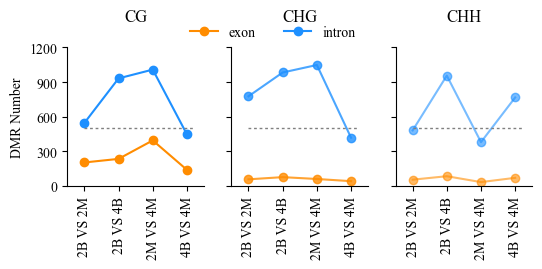

In [64]:
#Figure DMR number plot

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'font.sans-serif':'Times New Roman','axes.unicode_minus':False})

fig,axes = plt.subplots(1,3,figsize=(6,1.8))
# axes_pos = [[0,0],[0,1],[0,2],[1,0],[1,1],[1,2]]
# colors = ['darkorange','darkorange','darkorange','dodgerblue','dodgerblue','dodgerblue']
alphas = [1,.8,.6]
for sub_type,pos,alpha in zip([['CG_exon','CG_intron'],['CHG_exon','CHG_intron'],['CHH_exon','CHH_intron']],range(3),alphas):
    axes[pos].plot(range(0,4),dmr_obs_fre_df[dmr_obs_fre_df.type == sub_type[0]]['count'],marker="o",color='darkorange',alpha=alpha,label='exon')
    axes[pos].plot(range(0,4),dmr_obs_fre_df[dmr_obs_fre_df.type == sub_type[1]]['count'],marker="o",color='dodgerblue',alpha=alpha,label='intron')
    axes[pos].plot([0, 3.2], [500, 500], linestyle=(0,(2,2)), lw = 1 , color = "grey")
    # axes[pos].set_ylim(0.0001,0.0013)

    axes[pos].spines['right'].set_visible(False)
    axes[pos].spines['top'].set_visible(False)

    axes[pos].set_xlim(-0.5,3.5)

    axes[pos].set_xticks([0, 1, 2, 3])
    axes[pos].set_xticklabels(['2B VS 2M','2B VS 4B','2M VS 4M','4B VS 4M'],rotation=90)

    axes[pos].set_ylim(0,1200)
    y_major_locator=MultipleLocator(300)
    axes[pos].yaxis.set_major_locator(x_major_locator)

    if pos in [1,2]:
        axes[pos].yaxis.set_ticklabels([])
axes[0].legend(ncol=2,frameon=False,bbox_to_anchor=(2.2,1.25))
axes[0].set_ylabel('DMR Number')

axes[0].set_title('CG',pad=19)
axes[1].set_title('CHG',pad=19)
axes[2].set_title('CHH',pad=19)

plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part6_BS_seq/Figure6.9_DMR_number_in_exon_and_intron.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)
# plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part6_BS_seq/Figure6.9_DMR_number_in_exon_and_intron.ps', format='ps', dpi=600, bbox_inches='tight',transparent = True)

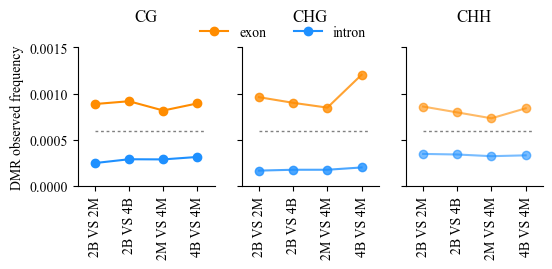

In [65]:
#Figure DMR observed frequency plot
fig,axes = plt.subplots(1,3,figsize=(6,1.8))
# axes_pos = [[0,0],[0,1],[0,2],[1,0],[1,1],[1,2]]
# colors = ['darkorange','darkorange','darkorange','dodgerblue','dodgerblue','dodgerblue']
alphas = [1,.8,.6]
for sub_type,pos,alpha in zip([['CG_exon','CG_intron'],['CHG_exon','CHG_intron'],['CHH_exon','CHH_intron']],range(3),alphas):
    axes[pos].plot(range(0,4),dmr_obs_fre_df[dmr_obs_fre_df.type == sub_type[0]]['obs_fre'],marker="o",color='darkorange',alpha=alpha,label='exon')
    axes[pos].plot(range(0,4),dmr_obs_fre_df[dmr_obs_fre_df.type == sub_type[1]]['obs_fre'],marker="o",color='dodgerblue',alpha=alpha,label='intron')
    axes[pos].plot([0, 3.2], [0.0006, 0.0006], linestyle=(0,(2,2)), lw = 1 , color = "grey")
    axes[pos].set_ylim(0.0001,0.0013)

    axes[pos].spines['right'].set_visible(False)
    axes[pos].spines['top'].set_visible(False)

    axes[pos].set_xlim(-0.5,3.5)

    axes[pos].set_xticks([0, 1, 2, 3])
    axes[pos].set_xticklabels(['2B VS 2M','2B VS 4B','2M VS 4M','4B VS 4M'],rotation=90)

    axes[pos].set_ylim(0,0.0015)


    if pos in [1,2]:
        axes[pos].yaxis.set_ticklabels([])
axes[0].legend(ncol=2,frameon=False,bbox_to_anchor=(2.2,1.25))
axes[0].set_ylabel('DMR observed frequency')

axes[0].set_title('CG',pad=19)
axes[1].set_title('CHG',pad=19)
axes[2].set_title('CHH',pad=19)

plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part6_BS_seq/Figure6.9_DMR_observed_frequency_in_exon_and_intron.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)

#### **(3) Circos plot.**

In [16]:
def split_to_single_gene(input_dir_path,output_dir_path,gene_name_list):

    samples = ['2B','2M','4B','4M']
    met_types = ['CG','CHG','CHH']
    for sample in samples:
        for met_type in met_types:
            #'Phe-2B_CG_coding_gene_region.csv'
            file_name = 'Phe-' + sample + '_' + met_type + '_coding_gene_region.csv'
            input_path = os.path.join(input_dir_path,file_name)
            df = pd.read_csv(input_path,sep='\t')
            df_groups = df.groupby(['gene_name'])
            for gene_name in gene_name_list:
                single_gene_df = df_groups.get_group(gene_name)
                #PH02Gene00008_2B_CG.csv
                output_file_name = gene_name + '_' + sample + '_' + met_type + '.csv'
                output_path = os.path.join(output_dir_path,output_file_name)
                single_gene_df.to_csv(output_path,sep='\t',index=False)

In [17]:
def position_transform(position,tss,strand,extend=2000):
    '''Convert the genomic position to the relative position of the specified interval.
        Tips: relative position is 0-based.
    ''' 
    if strand == '+':
        start = tss - extend
        rel_pos = position - start
    if strand == '-':
        start = tss + extend
        rel_pos = start - position
    return rel_pos


def get_locus_dict(single_gene_cx_file,anno_gene_level,extend=2000):

    locus_dict = {}
    position_list = []

    df = pd.read_csv(single_gene_cx_file,sep='\t',usecols=[1,7,8],header=0,names=['position','percentage','gene_name'])
    df.fillna({'percentage':0},inplace=True)
    gene_name = df.loc[1,'gene_name']
    df = df[df['percentage'] != 0]
    tss = anno_gene_level.loc[gene_name,'tss']
    tts = anno_gene_level.loc[gene_name,'tts']
    strand = anno_gene_level.loc[gene_name,'strand']
    interval_length = abs(tts - tss) + 1 + 2*extend

    theta = np.linspace(0,2*np.pi,interval_length,endpoint=True)
    width = (theta[1] - theta[0]) / 2

    df.loc[:,'rel_pos'] = df.apply(lambda x : position_transform(x['position'],tss,strand),axis=1)

    for rel_pos in df['rel_pos']:
        position_list.append(theta[rel_pos])

    locus_dict['position'] = position_list
    locus_dict['percentage'] = df['percentage'].to_list()
    locus_dict['width'] = width

    return locus_dict

In [18]:
def megrge_single_gene(dir_path,gene_name):

    locus_dict_all = {}
    samples = ['2B','2M','4B','4M']
    met_types = ['CG','CHG','CHH']

    for sample in samples:
        locus_dict_all[sample] = {}
        for met_type in met_types:
            file_name = gene_name + '_' + sample + '_' + met_type + '.csv'
            path = os.path.join(dir_path,file_name)
            locus_dict_all[sample][met_type] = get_locus_dict(path,anno_gene_level)
    
    return locus_dict_all

In [19]:
def select_dmr_gene(samples):
    gene_name_list_temp = []
    gene_name_list = []
    for sample in samples:
        count_dict = Counter(sample['gene_name'])
        for key,value in count_dict.items():    
            if value > 4:
                gene_name_list_temp.append(key)
    gene_count_dict = Counter(gene_name_list_temp)
    for key,vaule in gene_count_dict.items():
        if vaule > 0:
            gene_name_list.append(key)
    return gene_name_list

In [14]:
multiple_exons_gene = anno_intron_level['gene_name'].unique()

In [16]:
samples = [phe_cg_2b_2m_coding_gene_2000bp,phe_cg_2b_4b_coding_gene_2000bp,phe_cg_2m_4m_coding_gene_2000bp,phe_cg_4b_4m_coding_gene_2000bp,
            phe_chg_2b_2m_coding_gene_2000bp,phe_chg_2b_4b_coding_gene_2000bp,phe_chg_2m_4m_coding_gene_2000bp,phe_chg_4b_4m_coding_gene_2000bp,
            phe_chh_2b_2m_coding_gene_2000bp,phe_chh_2b_4b_coding_gene_2000bp,phe_chh_2m_4m_coding_gene_2000bp,phe_chh_4b_4m_coding_gene_2000bp]
gene_name_list = select_dmr_gene(samples)
gene_name_list = set(gene_name_list) & set(multiple_exons_gene)
# slect dmr gene (dmr >2)
# split_to_single_gene('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/03_coding_gene_region','/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/06_circos/01_single_gene',gene_name_list)

In [138]:
gene_name_list

{'PH02Gene02897',
 'PH02Gene03079',
 'PH02Gene08768',
 'PH02Gene09469',
 'PH02Gene15953',
 'PH02Gene22760',
 'PH02Gene23908',
 'PH02Gene27420',
 'PH02Gene33163',
 'PH02Gene38855',
 'PH02Gene48487'}

In [20]:
def annotation_feature(gene_name,anno_cds_level,anno_intron_level,anno_gene_level):
    
    anno_cds_level_single_gene = anno_cds_level[(anno_cds_level.label_group == 'exon') & (anno_cds_level.gene_name == gene_name)].copy()
    anno_intron_level_single_gene = anno_intron_level[anno_intron_level.gene_name == gene_name].copy()
    
    anno_cds_level_single_gene.loc[:,'rel_start'] = anno_cds_level_single_gene.apply(lambda x : position_transform(x['start'],anno_gene_level.loc[gene_name,'tss'],anno_gene_level.loc[gene_name,'strand']),axis=1)
    anno_cds_level_single_gene.loc[:,'rel_end'] = anno_cds_level_single_gene.apply(lambda x : position_transform(x['end'],anno_gene_level.loc[gene_name,'tss'],anno_gene_level.loc[gene_name,'strand']),axis=1)

    anno_intron_level_single_gene.loc[:,'rel_start'] = anno_intron_level_single_gene.apply(lambda x : position_transform(x['start'],anno_gene_level.loc[gene_name,'tss'],anno_gene_level.loc[gene_name,'strand']),axis=1)
    anno_intron_level_single_gene.loc[:,'rel_end'] = anno_intron_level_single_gene.apply(lambda x : position_transform(x['end'],anno_gene_level.loc[gene_name,'tss'],anno_gene_level.loc[gene_name,'strand']),axis=1)

    return anno_cds_level_single_gene, anno_intron_level_single_gene

In [55]:
def circos_plot(gene_name,anno_gene_level_single_gene,anno_cds_level_single_gene,anno_intron_level_single_gene,output_dir,output_circos_name=False):
    fig,ax = plt.subplots(subplot_kw={'projection': 'polar'})

    cir_end = 350
    #add methylation feature
    locus_dict = megrge_single_gene('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/06_circos/02_m6a_binding_proteins/',gene_name)
    
    bottom = 4
    sf = .8
    theta_sf = cir_end / 360
    samples = ['2B','2M','4B','4M']
    met_types = ['CG','CHG','CHH']
    colors = ['dodgerblue','lightcoral','mediumseagreen']
    

    for sample in samples:
        for met_type,color in zip(met_types,colors):
            for pos,per in zip(locus_dict[sample][met_type]['position'],locus_dict[sample][met_type]['percentage']):
                ax.plot([pos*theta_sf,pos*theta_sf],[bottom,bottom+per*sf],linewidth=.09,color=color)
        bottom += 1

    #add circle border feature
    cir_feature_theta = np.linspace(0,np.pi * 2,360)
    for i in range(4,8):
        ax.plot(cir_feature_theta[0:cir_end],[i] * cir_end,color='black',linewidth=.4)
        ax.plot(cir_feature_theta[0:cir_end],[(i + .8)] * cir_end,color='black',linewidth=.4)
        ax.plot([cir_feature_theta[0],cir_feature_theta[0]],[i,i+.8],color='black',linewidth=.4)
        ax.plot([cir_feature_theta[cir_end-1],cir_feature_theta[cir_end-1]],[i,i+.8],color='black',linewidth=.4)

    #add annotation feature
    anno_feature_r = 4
    # anno_feature_length = abs(anno_gene_level_single_gene.loc[gene_name,'tss'] - anno_gene_level_single_gene.loc[gene_name,'tts']) + 1 + 4000
    anno_feature_length = abs(anno_gene_level_single_gene['tss'] - anno_gene_level_single_gene['tts']) + 1 + 4000
    anno_feature_theta = np.linspace(0,cir_feature_theta[cir_end],anno_feature_length)
    # anno_cds_level_single_gene,anno_intron_level_single_gene = annotation_feature(gene_name,anno_cds_level,anno_intron_level,anno_gene_level)
    #up/downstream feature
    ax.plot(anno_feature_theta[0:2000],[anno_feature_r - .5] * 2000,color='black',linewidth=1)
    ax.plot(anno_feature_theta[-2000:],[anno_feature_r - .5] * 2000,color='black',linewidth=1)
    # ax.arrow(anno_feature_theta[-1:],anno_feature_r - .5,3,3,facecolor='black',edgecolor='black')
    #intron feature
    for rel_start,rel_end in zip(anno_intron_level_single_gene['rel_start'],anno_intron_level_single_gene['rel_end']):
        theta_start_index = min([rel_start,rel_end])
        theta_end_index = max([rel_start,rel_end])
        theta_length = theta_end_index - theta_start_index + 1 
        ax.plot(anno_feature_theta[theta_start_index:theta_end_index + 1],[anno_feature_r - .5] * theta_length,color='dimgray',linewidth=1)
    #exon feature
    for rel_start,rel_end in zip(anno_cds_level_single_gene['rel_start'],anno_cds_level_single_gene['rel_end']):
        theta_start_index = min([rel_start,rel_end])
        theta_end_index = max([rel_start,rel_end])
        theta_length = theta_end_index - theta_start_index + 1 
        ax.plot(anno_feature_theta[theta_start_index:theta_end_index + 1],[anno_feature_r - .5] * theta_length,color='royalblue',linewidth=3)

    #turn off axis
    frame = plt.gca()
    frame.axes.get_yaxis().set_visible(False)
    frame.axes.get_xaxis().set_visible(False)

    #turn off axis border
    ax.spines['polar'].set_visible(False)

    ax.set_ylim(0,8)
    
    if output_circos_name:
        figure_name = output_circos_name + '_circos.pdf'
    else:
        figure_name = gene_name + '_circos.pdf'
    path = os.path.join(output_dir,figure_name)
    plt.savefig(path, format='pdf', dpi=600, bbox_inches='tight',transparent = True)

In [19]:
anno_list = []
for gene_name in gene_name_list:
    anno_gene_level_single_gene = anno_gene_level.loc[gene_name,:]
    anno_cds_level_single_gene,anno_intron_level_single_gene = annotation_feature(gene_name,anno_cds_level,anno_intron_level,anno_gene_level)
    anno_list.append((gene_name,anno_gene_level_single_gene,anno_cds_level_single_gene,anno_intron_level_single_gene,'/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part6_BS_seq/circos',name))

In [33]:
Parallel(n_jobs=10)(delayed(circos_plot)(arg[0],arg[1],arg[2],arg[3],arg[4]) for arg in anno_list)

[None, None, None, None, None, None, None, None, None, None, None]

In [22]:
#circos plot of m6a binding proteins
m6a_binding_proteins_list = []
with open('/home/litao/bigdata/phe_shoot/phe_shoot_DRS/nanopore_output/12_jupyter/02_annotation/m6a_binding_proteins_homologue.csv','r') as m6a_gene_file:
    for line in m6a_gene_file:
        if line.strip() in ['readers','writer','erasers']:
            bind_type = line.strip()
        elif line.startswith('#'):
            line_list = line.strip().split()
            bind_name = line_list[1]
            for name in line_list[2:]:
                gene_name = '_'.join([bind_type,bind_name,name])
                m6a_binding_proteins_list.append(gene_name)

In [53]:
#circos plot of m6a binding proteins
anno_list = []
# gene_name_list = []
# for name in m6a_binding_proteins_list:
#     gene_name_list.append(name.split('_')[3])
# gene_name_list = list(set(gene_name_list) & set(multiple_exons_gene))
# split_to_single_gene('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/03_coding_gene_region/01_coding_gene_region','/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/06_circos/02_m6a_binding_proteins',gene_name_list)

for name in m6a_binding_proteins_list:
    gene_name = name.split('_')[3]
    if gene_name in multiple_exons_gene:
        anno_gene_level_single_gene = anno_gene_level.loc[gene_name,:]
        anno_cds_level_single_gene,anno_intron_level_single_gene = annotation_feature(gene_name,anno_cds_level,anno_intron_level,anno_gene_level)
        anno_list.append((gene_name,anno_gene_level_single_gene,anno_cds_level_single_gene,anno_intron_level_single_gene,'/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part6_BS_seq/m6a_binding_proteins_circos',name))

In [ ]:
Parallel(n_jobs=15)(delayed(circos_plot)(arg[0],arg[1],arg[2],arg[3],arg[4],arg[5]) for arg in anno_list)

### **3. DNA methylation and gene expression**

#### **(1) Methylation with intron and exon**

In [9]:
# anno_exon_intron_level = pd.concat([anno_intron_level[['gene_name','label','strand','start','end']],anno_cds_level[anno_cds_level.label_group == 'exon'][['gene_name','label','strand','start','end']]])
# anno_exon_intron_level.sort_values(by=['gene_name','start']).to_csv('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/00_Supplementary_file/anno_exon_intron_file.csv',sep='\t',index=False)

In [63]:
def read_coding_gene_region(coding_gene_region_csv):
    df = pd.read_csv(coding_gene_region_csv,sep='\t',
    dtype={'scaffold': str, 'position': int, 'strand': str, 'count_methylated': int,
    'count_unmethylated': int, 'C_context': str,'trinucleotide_context' : str,'methylation_percentage':float,'gene_name':str,'type':str,'rel_pos':int},header=0)
    return df
def read_anno_exon_intron_level(anno_exon_intron_file):
    df = pd.read_csv(anno_exon_intron_file,sep='\t',
    dtype={'gene_name':str,'label':str,'strand':str,'start':int,'end':int},header=0)
    return df
def add_exon_intron_tag(anno_exon_intron_level,coding_gene_cx_df):

    coding_gene_cx_groups = coding_gene_cx_df.groupby('gene_name')
    anno_exon_intron_level_groups = anno_exon_intron_level.groupby('gene_name')
    # gene_names = anno_exon_intron_level.gene_name.unique()
    gene_names = coding_gene_cx_df.gene_name.unique()
    gene_level_list = []
    try:
        with trange(len(gene_names)) as t:
            for gene_name,i in zip(gene_names,t):
                exon_level_cx_list = []
                coding_gene_cx_df_part = coding_gene_cx_groups.get_group(gene_name).copy()
                anno_exon_intron_level_part = anno_exon_intron_level_groups.get_group(gene_name)
                for row in anno_exon_intron_level_part.iterrows():
                    coding_gene_cx_df_exon_part = coding_gene_cx_df_part[(coding_gene_cx_df_part.position >= row[1]['start']) & (coding_gene_cx_df_part.position <= row[1]['end'])].copy()
                    if not coding_gene_cx_df_exon_part.empty:
                        coding_gene_cx_df_exon_part['label'] = row[1]['label']
                        exon_level_cx_list.append(coding_gene_cx_df_exon_part)
                gene_level_cx = pd.concat(exon_level_cx_list)
                gene_level_list.append(gene_level_cx)
            all_cx = pd.concat(gene_level_list)
    except KeyboardInterrupt:
        t.close()
        raise
    t.close()
    
    return all_cx

In [ ]:
# anno_exon_intron_level = read_anno_exon_intron_level('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/00_Supplementary_file/anno_exon_intron_file.csv')
# samples = ['2B','2M','4B','4M']
# meth_types = ['CHG','CG','CHH']
# # 'coding_region_2B_CG.csv_coding_gene_region.csv'
# for sample in samples:
#     for meth_type in meth_types:
#         input_file = '/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/06_unfiter_coding_gene/01_unfilter_gene_region/coding_region_' + sample + '_' + meth_type + '.csv_coding_gene_region.csv'
#         out_file_name = ''.join(['Phe-',sample,'_'+ meth_type + '_tag_exon_intron_cx.csv'])
#         path = os.path.join('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/06_unfiter_coding_gene/04_exon_intron_tag_cx/',file_name)

#         add_exon_intron_tag(anno_exon_intron_level,read_coding_gene_region(input_file)).to_csv(path,sep='\t',index=False)

In [ ]:
# anno_exon_intron_level = read_anno_exon_intron_level('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/00_Supplementary_file/anno_exon_intron_file.csv')

In [10]:
phe_sample_TPM = phe_sample_TPM.reset_index()
phe_sample_TPM = phe_sample_TPM.rename(columns={'gene_id':'gene_name'})
phe_sample_TPM = phe_sample_TPM.replace(0,np.nan)

In [52]:
phe_sample_TPM

gene_name     phe_2B     phe_2M     phe_4B     phe_4M
0      PH02Gene00001        NaN        NaN        NaN        NaN
1      PH02Gene00002        NaN        NaN        NaN        NaN
2      PH02Gene00003  27.014084  29.469539  18.224980  14.259494
3      PH02Gene00004  13.727788  12.596282   7.775682        NaN
4      PH02Gene00005   5.304015   6.064650   6.331270  17.084388
...              ...        ...        ...        ...        ...
50931  PH02Gene51518        NaN        NaN        NaN        NaN
50932  PH02Gene51519        NaN        NaN        NaN        NaN
50933  PH02Gene51520   1.589218   1.090274   1.062325        NaN
50934  PH02Gene51521        NaN        NaN        NaN        NaN
50935  PH02Gene51522        NaN        NaN        NaN        NaN

[50936 rows x 5 columns]

In [53]:
def read_tag_exon_intron_tag(tag_exon_intron_tag_cx):
    df = pd.read_csv(tag_exon_intron_tag_cx,sep='\t',
    dtype={'scaffold': str, 'position': int, 'strand': str, 'count_methylated': int,
    'count_unmethylated': int, 'C_context': str,'trinucleotide_context' : str,'methylation_percentage':float,'gene_name':str,'type':str,'rel_pos':int,'label':str},header=0)
    return df
def caculate_exon_intron_leve_5mc(phe_tag_exon_intron_cx_file,phe_sample_TPM,sample_name):
    sample_label = 'phe_' + sample_name

    phe_cx_exon_df = read_tag_exon_intron_tag(phe_tag_exon_intron_cx_file)
    phe_cx_exon_df = phe_cx_exon_df[phe_cx_exon_df['methylation_percentage'].notna()]
    phe_cx_exon_df = phe_cx_exon_df[['gene_name','label','methylation_percentage']].groupby(['gene_name','label']).agg('mean')
    phe_cx_exon_df = phe_cx_exon_df.reset_index()
    phe_cx_exon_df[['label_group','label_num']] = phe_cx_exon_df.label.str.extract('([a-z]+)([1-9]+)')
    phe_cx_exon_df = phe_cx_exon_df.groupby(['gene_name','label_group']).agg('mean')
    phe_cx_exon_df = phe_cx_exon_df.reset_index('label_group')

    #FIX only used coding reagion is flter, Please replace it with a complete coding reagion file in time, and delete this line of code.
    # phe_sample_TPM = phe_sample_TPM[phe_sample_TPM.gene_name.isin(phe_cx_exon_df.index.unique().to_list())].copy() 
    # phe_sample_TPM.loc[:,'range'] = pd.qcut(phe_sample_TPM[phe_sample_TPM[sample_label] != 0][sample_label],100,labels=range(100))

    phe_sample_TPM_copy = phe_sample_TPM.copy()
    phe_sample_TPM_copy.loc[:,'range'] = pd.qcut(phe_sample_TPM_copy[phe_sample_TPM_copy[sample_label].notna()][sample_label],100,labels=range(100))
    
    phe_cx_exon_df = pd.merge(phe_cx_exon_df,phe_sample_TPM_copy[['range','gene_name']],how='left',left_index=True,right_on='gene_name',sort=False)
    exon = phe_cx_exon_df[phe_cx_exon_df.notna()][['label_group','range','methylation_percentage']].groupby(['label_group','range']).agg('mean').T['exon'].loc['methylation_percentage',:].to_list()
    intron = phe_cx_exon_df[phe_cx_exon_df.notna()][['label_group','range','methylation_percentage']].groupby(['label_group','range']).agg('mean').T['intron'].loc['methylation_percentage',:].to_list()

    return intron,exon

In [54]:
cg_intron_rel_pos_list = []
cg_exon_rel_pos_list = []
for i in ['2B','2M','4B','4M']:
    file_name = ''.join(['Phe-',i,'_CG_tag_exon_intron_cx.csv'])
    path = os.path.join('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/06_unfiter_coding_gene/04_exon_intron_tag_cx/',file_name)
    (intron,exon) = caculate_exon_intron_leve_5mc(path,phe_sample_TPM,i)
    cg_intron_rel_pos_list.extend(intron)
    cg_exon_rel_pos_list.extend(exon)
chg_intron_rel_pos_list = []
chg_exon_rel_pos_list = []
for i in ['2B','2M','4B','4M']:
    file_name = ''.join(['Phe-',i,'_CHG_tag_exon_intron_cx.csv'])
    path = os.path.join('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/06_unfiter_coding_gene/04_exon_intron_tag_cx/',file_name)
    (intron,exon) = caculate_exon_intron_leve_5mc(path,phe_sample_TPM,i)
    chg_intron_rel_pos_list.extend(intron)
    chg_exon_rel_pos_list.extend(exon)
chh_intron_rel_pos_list = []
chh_exon_rel_pos_list = []
for i in ['2B','2M','4B','4M']:
    file_name = ''.join(['Phe-',i,'_CHH_tag_exon_intron_cx.csv'])
    path = os.path.join('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/06_unfiter_coding_gene/04_exon_intron_tag_cx/',file_name)
    (intron,exon) = caculate_exon_intron_leve_5mc(path,phe_sample_TPM,i)
    chh_intron_rel_pos_list.extend(intron)
    chh_exon_rel_pos_list.extend(exon)

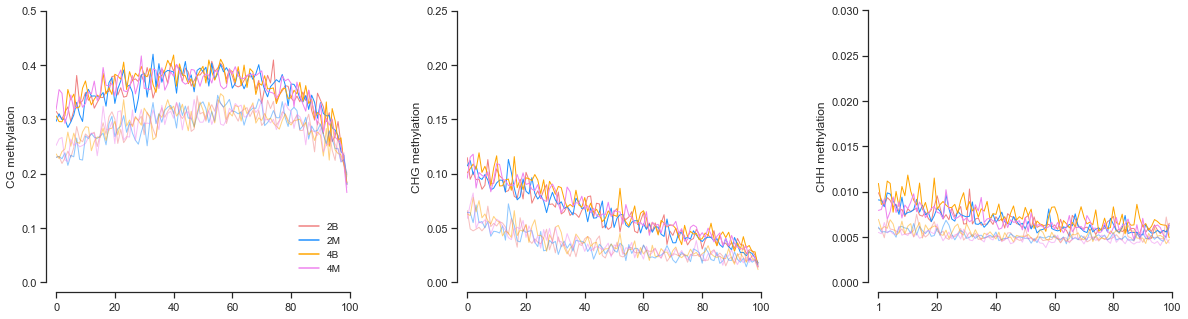

In [57]:
#Figure 
fig,axes = plt.subplots(1,3,figsize=(20, 5))

types = [y for y in ['2B','2M','4B','4M'] for x in range(100)]
position = [x for y in range(4) for x in range(100)]

# colors = ["lightseagreen", "dodgerblue","orange","violet"]
colors = ["lightcoral", "dodgerblue","orange","violet"]
sns.set(style="ticks")
sf1,sf2,sf3 = (0.5,.25,.03)
#CG methylation
# axes[0].plot([49, 49], [0, 0.9], linestyle=':', lw = 2 , color = "cornflowerblue")
# axes[0].plot([99, 99], [0, 0.9], linestyle=':', lw = 2 , color = "cornflowerblue")
# axes[0].plot([0,149],[0.98*sf1,0.98*sf1], lw = 3, color = 'grey')
# axes[0].plot([49,99], [0.98*sf1,0.98*sf1], lw = 5, color = "sandybrown")
sns.lineplot(x=position, y=cg_intron_rel_pos_list,hue=types,
            palette=colors,linewidth=1, ax = axes[0])
sns.lineplot(x=position, y=cg_exon_rel_pos_list,hue=types,
            palette=colors,linewidth=1,alpha=0.5,legend=False, ax = axes[0])
axes[0].set_ylim(0, 1*sf1)
axes[0].set_xlim(0, 100)
axes[0].set_xticks([0,20,40,60,80,100])
# axes[i].set_yticks([0, 0.2, 0.4,0.6,0.8,1])
# axes[i].set_yticklabels([0, 0.2, 0.4,0.6,0.8,1])
axes[0].set_xticklabels(["0", "20", "40" , "60",'80','100'])
axes[0].set_ylabel("CG methylation")
# axes[0].text(58,0.93*sf1,'Coding genes')
axes[0].legend(loc='lower right',fontsize=10,frameon=False)
#CHG methylation
# axes[1].plot([49, 49], [0, 0.9*sf2], linestyle=':', lw = 2 , color = "cornflowerblue")
# axes[1].plot([99, 99], [0, 0.9*sf2], linestyle=':', lw = 2 , color = "cornflowerblue")
# axes[1].plot([0,149],[0.98*sf2,0.98*sf2], lw = 3, color = 'grey')
# axes[1].plot([49,99], [0.98*sf2,0.98*sf2], lw = 5, color = "sandybrown")
sns.lineplot(x=position, y=chg_intron_rel_pos_list,hue=types,
            palette=colors,linewidth=1,legend=False, ax = axes[1])
sns.lineplot(x=position, y=chg_exon_rel_pos_list,hue=types,
            palette=colors,linewidth=1,alpha=0.5,legend=False, ax = axes[1])
axes[1].set_ylim(0, 1*sf2)
axes[1].set_xlim(0, 100)
axes[1].set_xticks([0,20,40,60,80,100])
# axes[i].set_yticks([0, 0.2, 0.4,0.6,0.8,1])
# axes[i].set_yticklabels([0, 0.2, 0.4,0.6,0.8,1])
axes[1].set_xticklabels(["0", "20", "40" , "60",'80','100'])
axes[1].set_ylabel("CHG methylation")
# axes[1].text(58,0.93*sf2,'Coding genes')
# axes[1].legend(loc='lower right',fontsize=10,frameon=False)
#CHH methylation
# axes[2].plot([49, 49], [0,  0.9*sf3], linestyle=':', lw = 2 , color = "cornflowerblue")
# axes[2].plot([99, 99], [0,  0.9*sf3], linestyle=':', lw = 2 , color = "cornflowerblue")
# axes[2].plot([0,149],[0.98*sf3,0.98*sf3], lw = 3, color = 'grey')
# axes[2].plot([49,99], [0.98*sf3,0.98*sf3], lw = 5, color = "sandybrown")
sns.lineplot(x=position, y=chh_intron_rel_pos_list,hue=types,
            palette=colors,linewidth=1,legend=False, ax = axes[2])
sns.lineplot(x=position, y=chh_exon_rel_pos_list,hue=types,
            palette=colors,linewidth=1,alpha=0.5,legend=False, ax = axes[2])
axes[2].set_ylim(0, sf3)
axes[2].set_xlim(0, 100)
axes[2].set_xticks([0,20,40,60,80,100])
# axes[i].set_yticks([0, 0.2, 0.4,0.6,0.8,1])
# axes[i].set_yticklabels([0, 0.2, 0.4,0.6,0.8,1])
axes[2].set_xticklabels(["1", "20", "40" , "60",'80','100'])
axes[2].set_ylabel("CHH methylation")
# axes[2].text(58,0.93*sf3,'Coding genes')
# axes[2].legend(loc='lower right',fontsize=10,frameon=False)

sns.despine(trim=True,offset=10)  
plt.subplots_adjust(wspace=0.4)
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part6_BS_seq/Figure_gene_expression_5mc-12-22.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)

#### **(2) Methylation profiles in promoter and gene-body regions of genes with different expression levels**

In [58]:
def classfy_gene_fpkm(phe_sample_TPM,sample_name):
    sample_label = 'phe_' + sample_name
    phe_sample_TPM_sample = phe_sample_TPM[phe_sample_TPM[sample_label].notna()][['gene_name',sample_label]].copy()
    phe_sample_TPM_sample.loc[:,'range'] = pd.qcut(phe_sample_TPM_sample[phe_sample_TPM_sample[sample_label].notna()][sample_label],4,labels=range(4))
    high = phe_sample_TPM_sample[phe_sample_TPM_sample.range == 3]['gene_name'].to_list()
    mid_high = phe_sample_TPM_sample[phe_sample_TPM_sample.range == 2]['gene_name'].to_list()
    mid_low = phe_sample_TPM_sample[phe_sample_TPM_sample.range == 1]['gene_name'].to_list()
    low = phe_sample_TPM_sample[phe_sample_TPM_sample.range == 0]['gene_name'].to_list()
    none = phe_sample_TPM[phe_sample_TPM[sample_label].isna()]['gene_name'].to_list()
    return high,mid_high,mid_low,low,none

In [59]:
def gene_fpkm_5mc(rel_pos_csv_file,phe_sample_TPM,sample_name):
    df = pd.read_csv(rel_pos_csv_file,sep='\t',header=0,
    dtype={'type':str,'gene_name':str,'rel_pos':int,'methylation_percentage':float},index_col='type')

    (high,mid_high,mid_low,low,none) = classfy_gene_fpkm(phe_sample_TPM,sample_name)
    high_rel_pos = df[df.gene_name.isin(high)].groupby(['type','rel_pos']).agg('mean')
    mid_high_rel_pos = df[df.gene_name.isin(mid_high)].groupby(['type','rel_pos']).agg('mean')
    mid_low_rel_pos = df[df.gene_name.isin(mid_low)].groupby(['type','rel_pos']).agg('mean')
    low_rel_pos = df[df.gene_name.isin(low)].groupby(['type','rel_pos']).agg('mean')
    none_rel_pos = df[df.gene_name.isin(none)].groupby(['type','rel_pos']).agg('mean')
    
    high_rel_pos_list = high_rel_pos.T[['cds_up','cds','cds_down']].loc['methylation_percentage',:].to_list()
    mid_high_rel_pos_list = mid_high_rel_pos.T[['cds_up','cds','cds_down']].loc['methylation_percentage',:].to_list()
    mid_low_rel_pos_list = mid_low_rel_pos.T[['cds_up','cds','cds_down']].loc['methylation_percentage',:].to_list()
    low_rel_pos_list = low_rel_pos.T[['cds_up','cds','cds_down']].loc['methylation_percentage',:].to_list()
    none_rel_pos_list = none_rel_pos.T[['cds_up','cds','cds_down']].loc['methylation_percentage',:].to_list()

    return none_rel_pos_list,low_rel_pos_list,mid_low_rel_pos_list,mid_high_rel_pos_list,high_rel_pos_list

In [60]:
cg_gene_expression_rel_pos_list = []
for i in ['2B','2M','4B','4M']:
    file_name = ''.join(['Phe-',i,'_CG_gene_level_rel_pos_filter.csv'])
    path = os.path.join('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/06_unfiter_coding_gene/03_filter_gene_level_rel_pos',file_name)
    cg_gene_expression_rel_pos_list.append(gene_fpkm_5mc(path,phe_sample_TPM,i))
    
chg_gene_expression_rel_pos_list = []
for i in ['2B','2M','4B','4M']:
    file_name = ''.join(['Phe-',i,'_CHG_gene_level_rel_pos_filter.csv'])
    path = os.path.join('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/06_unfiter_coding_gene/03_filter_gene_level_rel_pos',file_name)
    chg_gene_expression_rel_pos_list.append(gene_fpkm_5mc(path,phe_sample_TPM,i))

chh_gene_expression_rel_pos_list = []
for i in ['2B','2M','4B','4M']:
    file_name = ''.join(['Phe-',i,'_CHH_gene_level_rel_pos_filter.csv'])
    path = os.path.join('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/06_unfiter_coding_gene/03_filter_gene_level_rel_pos',file_name)
    chh_gene_expression_rel_pos_list.append(gene_fpkm_5mc(path,phe_sample_TPM,i))

In [67]:
def plot_3d_coding_gene_pattern(gene_expression_rel_pos_list,ax,sc):

    ax.plot3D(xs = [1,149], ys = [0.95*sc, 0.95*sc], zs = 0, zdir = 'y', lw = 4,color = "grey")
    ax.plot3D(xs = [51,99], ys = [0.95*sc, 0.95*sc], zs = 0, zdir = 'y', lw = 8,color = "mediumvioletred")

    #plot three gray borders
    sc_2 = sc / .8
    ax.plot3D(xs = [3,160], ys=[0,0],zs = [.84*sc_2, .84*sc_2],  lw = 1,color = "grey")
    ax.plot3D(xs = [1,1], ys=[4.1,-0.05],zs = [.83*sc_2, .83*sc_2],  lw = 1,color = "grey")
    ax.plot3D(xs = [1,1], ys=[4.1,4.1],zs = [0, .83*sc_2],  lw = 1,color = "grey")
    
    X= list(range(150))
    xi = 0
    lw = 1.5

    # coco = ["hotpink","lightseagreen","royalblue","mediumpurple"]
    # colors = ["lightseagreen", "dodgerblue","orange","violet"]
    colors = ["lightcoral", "dodgerblue","orange","violet"]

    for inlist in list(range(5)):
        if xi ==0:
            ax.plot3D(xs = X, ys=gene_expression_rel_pos_list[0][xi], zs = xi, zdir='y', lw= lw, label = "2B", color = colors[0])
            ax.plot3D(xs = X, ys=gene_expression_rel_pos_list[1][xi], zs = xi, zdir='y', lw= lw, label = "2M", color = colors[1])
            ax.plot3D(xs = X, ys=gene_expression_rel_pos_list[2][xi], zs = xi, zdir='y', lw= lw, label = "4B", color = colors[2])
            ax.plot3D(xs = X, ys=gene_expression_rel_pos_list[3][xi], zs = xi, zdir='y', lw= lw, label =  "4M", color = colors[3])
            xi+=1
        else:
            ax.plot3D(xs = X, ys=gene_expression_rel_pos_list[0][xi], zs = xi, zdir='y', lw= lw,  color = colors[0])
            ax.plot3D(xs = X, ys=gene_expression_rel_pos_list[1][xi], zs = xi, zdir='y', lw= lw,  color = colors[1])
            ax.plot3D(xs = X, ys=gene_expression_rel_pos_list[2][xi], zs = xi, zdir='y', lw= lw,  color = colors[2])
            ax.plot3D(xs = X, ys=gene_expression_rel_pos_list[3][xi], zs = xi, zdir='y', lw= lw,  color = colors[3])
            xi+=1

    for x in range(5):
        ax.plot3D(xs = [50,50], ys = [0*sc , .8*sc], zs = x, lw= 1, zdir='y',linestyle = "--", color = "grey")
        ax.plot3D(xs = [100,100], ys = [0*sc , .8*sc], zs = x, lw= 1, zdir='y',linestyle = "--", color = "grey")
    
    ax.set_xlim3d(0,150)
    ax.set_ylim3d(4,0)
    ax.set_zlim3d(0,1*sc)
    ax.view_init(elev=30, azim=-25)
    ax.set_xticks([0,50,100,150])
    ax.set_xticklabels(["-2kb","TSS","TTS","+2kb"])#,fontdict={'size' : 3})
    ax.set_yticks([0,1,2,3,4])
    ax.set_yticklabels(["none ","low ","mid low ","mid high", "high"])#,fontdict={'size' : 3})
    # ax.set_zticks([0 ,.2,.4, .6, .8 ])
    ax.set_box_aspect((4,4,2.6))

    ax.legend(loc='lower right',fontsize=10,frameon=False)

    return ax

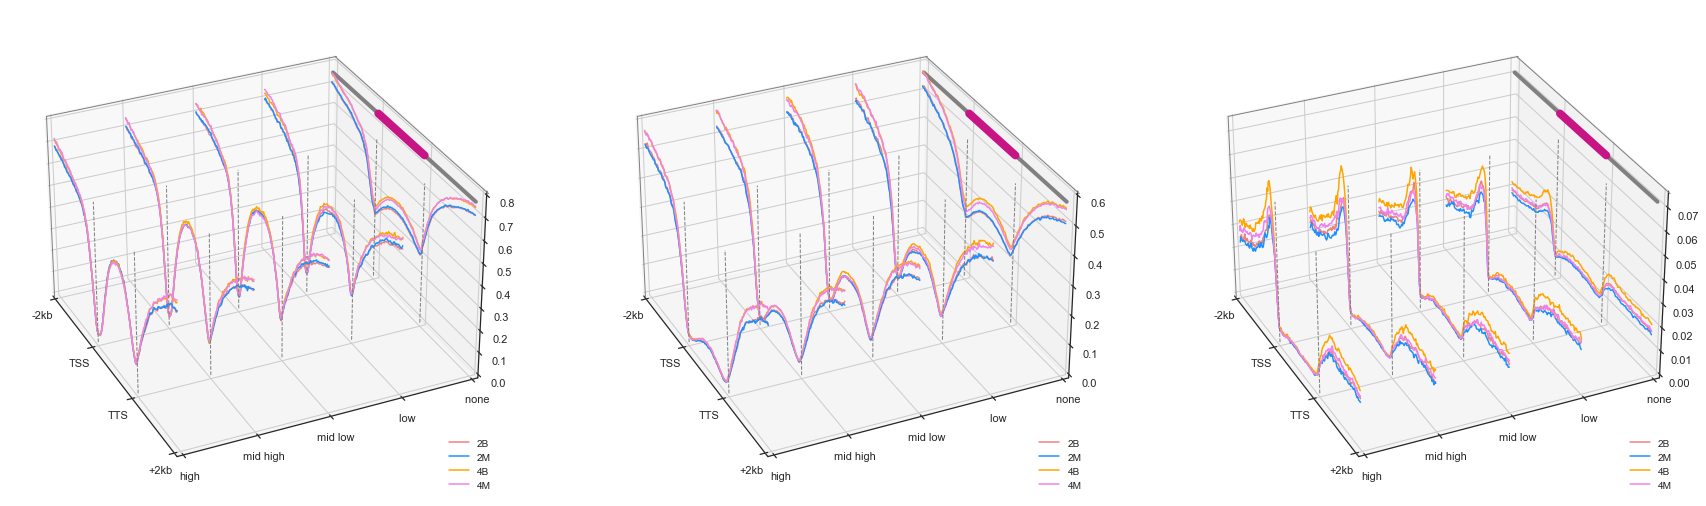

In [68]:
fig = plt.figure(figsize=(30,10))
axes1 = fig.add_subplot(1,3,1, projection='3d')
axes2 = fig.add_subplot(1,3,2, projection='3d')
axes3 = fig.add_subplot(1,3,3, projection='3d')
axes1 = plot_3d_coding_gene_pattern(cg_gene_expression_rel_pos_list,axes1,0.8)
axes2 = plot_3d_coding_gene_pattern(chg_gene_expression_rel_pos_list,axes2,.6)
axes3 = plot_3d_coding_gene_pattern(chh_gene_expression_rel_pos_list,axes3,.075)
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part6_BS_seq/Figure_gene_expression_3d-12-22.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)

#### **(3) Heatmap representation of CG, CHG and CHH methylation profiles in genes from low to high expression groups**

In [18]:
def rel_pos_transform(type_str):
    if type_str == 'cds_up':
        return 1
    elif type_str == 'cds':
        return 51
    else:
        return 101

def gene_expression_group(rel_pos_gene_level_file,phe_sample_TPM,group_num,sample_name):

    sample_label = 'phe_' + sample_name

    df = pd.read_csv(rel_pos_gene_level_file,sep='\t',header=0,
    dtype={'type':str,'gene_name':str,'rel_pos':int,'methylation_percentage':float},index_col='gene_name')

    phe_sample_TPM_cp = phe_sample_TPM[phe_sample_TPM.gene_name.isin(df.index.unique().to_list())].copy() 
    phe_sample_TPM_cp.loc[:,'range'] = pd.qcut(phe_sample_TPM_cp[phe_sample_TPM_cp[sample_label] != 0][sample_label],group_num,labels=range(group_num))
    df = pd.merge(df,phe_sample_TPM_cp[['range','gene_name']],how='left',left_index=True,right_on='gene_name',sort=False)
    df = df[['range','type','rel_pos','methylation_percentage']].groupby(['range','type','rel_pos']).agg('mean')
    df = df.reset_index()
    df.loc[:,'rel_pos_transform'] = df.type.apply(rel_pos_transform)
    df.loc[:,'rel_pos'] = df['rel_pos'] + df['rel_pos_transform']
    df = df.pivot(index='range',columns='rel_pos',values='methylation_percentage')
    df = df[::-1]  #Reverse according to index
    
    return df

In [24]:
cg_gene_expression_group_df_list = []
for i in ['2B','2M','4B','4M']:
    file_name = ''.join(['Phe-',i,'_CG_gene_level_rel_pos_filter.csv'])
    path = os.path.join('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/06_unfiter_coding_gene/03_filter_gene_level_rel_pos',file_name)
    cg_gene_expression_group_df_list.append(gene_expression_group(path,phe_sample_TPM,500,i))
    
chg_gene_expression_group_df_list = []
for i in ['2B','2M','4B','4M']:
    file_name = ''.join(['Phe-',i,'_CHG_gene_level_rel_pos_filter.csv'])
    path = os.path.join('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/06_unfiter_coding_gene/03_filter_gene_level_rel_pos',file_name)
    chg_gene_expression_group_df_list.append(gene_expression_group(path,phe_sample_TPM,500,i))

chh_gene_expression_group_df_list = []
for i in ['2B','2M','4B','4M']:
    file_name = ''.join(['Phe-',i,'_CHH_gene_level_rel_pos_filter.csv'])
    path = os.path.join('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/06_unfiter_coding_gene/03_filter_gene_level_rel_pos',file_name)
    chh_gene_expression_group_df_list.append(gene_expression_group(path,phe_sample_TPM,500,i))

In [44]:
def methylation_gene_expression_heatmap(group_df,ax,max_value,min_value=0):
    #max_value is heatmap vmax value, min_value is heatmap vmin value
    sns.heatmap(group_df,cmap = "vlag",xticklabels=False,yticklabels=False,vmax=max_value,vmin=min_value,ax = ax)

    ax.plot([50, 50], [0, 500], linestyle='solid', lw = .5 , color = "black")
    ax.plot([100, 100], [0, 500], linestyle='solid', lw = .5 , color = "black")

    #plot a black border
    ax.plot([1, 150], [0, 0], linestyle='solid', lw = 1 , color = "black")
    ax.plot([1, 150], [500, 500], linestyle='solid', lw = 1 , color = "black")
    ax.plot([0, 0], [0, 500], linestyle='solid', lw = 1 , color = "black")
    ax.plot([150, 150], [0, 500], linestyle='solid', lw = 1 , color = "black")

    ax.set_xticks([0,50,100,150])
    ax.set_xticklabels(["-2kb","TSS","TTS","+2kb"])

    ax.text(-40,480,'Low')
    ax.text(-40,25,'High')
    ax.set_ylabel('Expression (TPM)')
    ax.set_xlabel('')
    ax.tick_params(bottom=False)

    #set colorbar tick
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(size=1)

    return ax

In [45]:
fig,axes = plt.subplots(4,3,figsize=(8,12))

for i,n,vmax in zip(range(3),[cg_gene_expression_group_df_list,chg_gene_expression_group_df_list,chh_gene_expression_group_df_list],[.8,.6,.06]):
    for z in range(4):
        axes[z,i] = methylation_gene_expression_heatmap(n[z],axes[z,i],vmax)

plt.subplots_adjust(wspace=0.5)

axes[0,0].set_title('CG')
axes[0,1].set_title('CHG')
axes[0,2].set_title('CHH')

axes[0,0].text(-80,250,'2B',rotation=90,fontsize=12)
axes[1,0].text(-80,250,'2M',rotation=90,fontsize=12)
axes[2,0].text(-80,250,'4B',rotation=90,fontsize=12)
axes[3,0].text(-80,250,'4M',rotation=90,fontsize=12)

plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part6_BS_seq/Figure_gene_expression_heatmap.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)
plt.close()

#### **(2)Heatmap of methylation and poly(A) tial**

In [21]:
def polya_tail_group(rel_pos_gene_level_file,gene_polya_info,group_num):

    df = pd.read_csv(rel_pos_gene_level_file,sep='\t',header=0,
    dtype={'type':str,'gene_name':str,'rel_pos':int,'methylation_percentage':float})

    gene_polya_info_cp = gene_polya_info.reset_index().copy() 
    gene_polya_info_cp = gene_polya_info_cp.rename(columns={'geneid':'gene_name'})
    # gene_polya_info_cp = gene_polya_info_cp[gene_polya_info_cp['gene_name'].isin(df.index.unique().to_list())]
    gene_polya_info_cp.loc[:,'range'] = pd.qcut(gene_polya_info_cp['median_length'],group_num,labels=range(group_num))

    df = df.reset_index()
    df = pd.merge(df,gene_polya_info_cp[['range','gene_name']],how='left',left_on='gene_name',right_on='gene_name',sort=False)
    df = df[['range','type','rel_pos','methylation_percentage']].groupby(['range','type','rel_pos']).agg('mean')
    df = df.reset_index()
    df.loc[:,'rel_pos_transform'] = df.type.apply(rel_pos_transform)
    df.loc[:,'rel_pos'] = df['rel_pos'] + df['rel_pos_transform']
    df = df.pivot(index='range',columns='rel_pos',values='methylation_percentage')
    df = df[::-1]  #Reverse according to index
    
    return df

def rel_pos_transform(type_str):
    if type_str == 'cds_up':
        return 1
    elif type_str == 'cds':
        return 51
    else:
        return 101

In [22]:
gene_polyas = [gene_polya_info_2b,gene_polya_info_2m,gene_polya_info_4b,gene_polya_info_4m]
cg_polya_tail_group_df_list = []
for i,n in zip(['2B','2M','4B','4M'],gene_polyas):
    file_name = ''.join(['Phe-',i,'_CG_gene_level_rel_pos_filter.csv'])
    path = os.path.join('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/06_unfiter_coding_gene/03_filter_gene_level_rel_pos/',file_name)
    cg_polya_tail_group_df_list.append(polya_tail_group(path,n,100))
    
chg_polya_tail_group_df_list = []
for i,n in zip(['2B','2M','4B','4M'],gene_polyas):
    file_name = ''.join(['Phe-',i,'_CHG_gene_level_rel_pos_filter.csv'])
    path = os.path.join('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/06_unfiter_coding_gene/03_filter_gene_level_rel_pos/',file_name)
    chg_polya_tail_group_df_list.append(polya_tail_group(path,n,100))

chh_polya_tail_group_df_list = []
for i,n in zip(['2B','2M','4B','4M'],gene_polyas):
    file_name = ''.join(['Phe-',i,'_CHH_gene_level_rel_pos_filter.csv'])
    path = os.path.join('/home/litao/bigdata/phe_shoot/phe_shoot_BS/output/01_jupyter/06_unfiter_coding_gene/03_filter_gene_level_rel_pos/',file_name)
    chh_polya_tail_group_df_list.append(polya_tail_group(path,n,100))

In [23]:
def methylation_polya_tail_heatmap(group_df,ax,sc):

    sc = sc /500
    sns.heatmap(group_df,cmap = "vlag",xticklabels=False,yticklabels=False,ax = ax)

    ax.plot([50, 50], [0, 500*sc], linestyle='solid', lw = .5 , color = "black")
    ax.plot([100, 100], [0, 500*sc], linestyle='solid', lw = .5 , color = "black")

    #plot a black border
    ax.plot([1, 150], [0, 0], linestyle='solid', lw = 1 , color = "black")
    ax.plot([1, 150], [500*sc, 500*sc], linestyle='solid', lw = 1 , color = "black")
    ax.plot([0, 0], [0, 500*sc], linestyle='solid', lw = 1 , color = "black")
    ax.plot([150, 150], [0, 500*sc], linestyle='solid', lw = 1 , color = "black")

    ax.set_xticks([0,50,100,150])
    ax.set_xticklabels(["-2kb","TSS","TTS","+2kb"])

    ax.text(-43,480*sc,'Short')
    ax.text(-43,25*sc,'Long')
    ax.set_ylabel('Poly(A) tail length')
    ax.set_xlabel('')
    ax.tick_params(bottom=False)

    #set colorbar tick
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(size=1)

    return ax

In [24]:
#Figure polya tail and 5mc
fig,axes = plt.subplots(4,3,figsize=(8,12))

for i,n in zip(range(3),[cg_polya_tail_group_df_list,chg_polya_tail_group_df_list,chh_polya_tail_group_df_list]):
    for z in range(4):
        axes[z,i] = methylation_polya_tail_heatmap(n[z],axes[z,i],100)

sc = 100 / 500
plt.subplots_adjust(wspace=0.5)

axes[0,0].set_title('CG')
axes[0,1].set_title('CHG')
axes[0,2].set_title('CHH')

axes[0,0].text(-80,250*sc,'2B',rotation=90,fontsize=12)
axes[1,0].text(-80,250*sc,'2M',rotation=90,fontsize=12)
axes[2,0].text(-80,250*sc,'4B',rotation=90,fontsize=12)
axes[3,0].text(-80,250*sc,'4M',rotation=90,fontsize=12)
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part6_BS_seq/Figure_polya_heatmap.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)
plt.close()

In [ ]:
# def plot_border(ax,group_num,sub_num):

#     sc = group_num / 500
#     #plot a black border
#     tick_list = []
#     for num in range(sub_num):
#         ax.plot([0+num*150, 150+num*150], [0, 0], linestyle='solid', lw = 1 , color = "grey")
#         ax.plot([0+num*150, 150+num*150], [500*sc, 500*sc], linestyle='solid', lw = 1 , color = "grey")
#         ax.plot([0+num*150, 1+num*150], [0, 500*sc], linestyle='solid', lw = 1 , color = "grey")
#         ax.plot([150+num*150, 150+num*150], [0, 500*sc], linestyle='solid', lw = 1 , color = "grey")
#         tick_list.extend([0+num*150,50+num*150,100+num*150,150+num*150])

#     ax.set_xlabel('')
#     ax.set_ylabel('')

#     ax.set_xticks(tick_list)
#     ax.set_xticklabels(["","","",""]*sub_num)

#     ax.set_aspect(4)
    
#     return ax


# fig,axes = plt.subplots(1,4,figsize=(6, 6))
# # sns.heatmap(all_group_polya[::-1],cmap = "vlag",xticklabels=False,yticklabels=False,cbar=False,ax=axes[0])
# for i in range(4):
#     if i == 2:
#         # sns.heatmap(cg_polya_tail_group_df_list[i],cmap = "vlag",xticklabels=False,yticklabels=False,cbar_kws={"use_gridspec":False,'location':"bottom"},ax=axes[i])
#         sns.heatmap(cg_polya_tail_group_df_list[i],cmap = "vlag",xticklabels=False,yticklabels=False,cbar=False,ax=axes[i])
#     else:
#         sns.heatmap(cg_polya_tail_group_df_list[i],cmap = "vlag",xticklabels=False,yticklabels=False,cbar=False,ax=axes[i])
#     plot_border(axes[i],100,3)

# # divider = make_axes_locatable(axes[3])
# # cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
# # fig.add_axes(cax)
# # fig.colorbar(axes[3], cax=cax, orientation="horizontal")

# plt.subplots_adjust(wspace=0)

In [30]:
phe_sample_TPM = phe_sample_TPM.reset_index()
phe_sample_TPM = phe_sample_TPM.rename(columns={'gene_id':'gene_name'})
phe_sample_TPM = phe_sample_TPM.replace(0,np.nan)

In [27]:
# def group_expression_polya_tail(gene_polya_info,phe_sample_TPM,sample_name,group_num):
#     sample_label = 'phe_' + sample_name

#     used_fpkm = phe_sample_TPM[(phe_sample_TPM.gene_name.isin(gene_polya_info.index)) & (phe_sample_TPM[sample_label].notna())][[sample_label,'gene_name']]
#     used_fpkm = pd.merge(used_fpkm,gene_polya_info['median_length'],how='left',left_on='gene_name',right_index=True,sort=False)
#     used_fpkm.loc[:,'range'] = pd.qcut(used_fpkm[sample_label],group_num,labels=range(group_num))
#     used_fpkm = used_fpkm.rename(columns={sample_label:'fpkm'})
#     df = used_fpkm[['range','median_length']].groupby(['range']).agg('mean')

#     return df

def group_polya_tail_expression(gene_polya_info,phe_sample_TPM,sample_name,group_num):
    sample_label = 'phe_' + sample_name

    used_fpkm = phe_sample_TPM[(phe_sample_TPM.gene_name.isin(gene_polya_info.index)) & (phe_sample_TPM[sample_label].notna())][[sample_label,'gene_name']]
    used_fpkm = pd.merge(used_fpkm,gene_polya_info['median_length'],how='left',left_on='gene_name',right_index=True,sort=False)
    used_fpkm.loc[:,'range'] = pd.qcut(used_fpkm['median_length'],group_num,labels=range(group_num))
    # used_fpkm = used_fpkm.rename(columns={sample_label:'fpkm'})
    df = used_fpkm[['range',sample_label]].groupby(['range']).agg('mean')

    return df

In [31]:
all_polya_tail = [gene_polya_info_2b,gene_polya_info_2m,gene_polya_info_4b,gene_polya_info_4m]

fpkm_list = []
for i,n in zip(all_polya_tail,['2B','2M','4B','4M']):
    sample_label = 'phe_' + n
    fpkm_list.append(group_polya_tail_expression(i,phe_sample_TPM,n,100)[sample_label])
all_group_polya = pd.concat(fpkm_list,axis=1)

In [34]:
#Figure polya_tail_and_5mc_all_heatmap
fig,axes = plt.subplots(1,4,figsize=(9,3))

samples = [pd.concat(cg_polya_tail_group_df_list,axis=1),pd.concat(chg_polya_tail_group_df_list,axis=1),pd.concat(chh_polya_tail_group_df_list,axis=1)]

sns.heatmap(all_group_polya[::-1],cmap = "vlag",xticklabels=False,yticklabels=False,vmax=250,cbar_kws={"use_gridspec":False,'location':"bottom",'shrink':0.3,'pad':0.05,'drawedges':False,'aspect':10},ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].set_aspect(0.15)

for n,sample in zip(range(1,4),samples):

    sns.heatmap(sample,cmap = "vlag",xticklabels=False,yticklabels=False,cbar_kws={"use_gridspec":False,'location':"bottom",'shrink':0.5,'pad':0.05,'drawedges':False,'aspect':10},ax=axes[n])
    
    # plot tick
    tick_list = []
    for t in range(4):
        tick_list.extend([0+t*150,50+t*150,100+t*150,150+t*150])
        axes[n].set_xticks(tick_list)
    axes[n].set_xticklabels(["","","",""]*4)

    #plot_border
    for i in range(5):
        axes[n].plot([0+i*150-1, 0+i*150-1], [0, 100], linestyle='solid', lw = 1 , color = "grey")
    axes[n].plot([0,150*4],[0,0], linestyle='solid', lw = 1 , color = "grey")
    axes[n].plot([0,150*4],[99.99,99.99], linestyle='solid', lw = 1 , color = "grey")
    
    # axes[n].set_aspect(5)
    axes[n].set_ylabel('')
    axes[n].set_xlabel('')
# plt.subplots_adjust(wspace=0.1)
plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part6_BS_seq/Figure_polya_tail_and_5mc_all_heatmap-12-22.pdf', format='pdf', dpi=600, bbox_inches='tight',transparent = True)
plt.close()
# plt.savefig('/home/litao/bigdata/phe_shoot/phe_shoot_figure/Part6_BS_seq/Figure6.11_polya_tail_and_5mc_all_heatmap.ps', format='ps', dpi=600, bbox_inches='tight',transparent = True)


#### **(3)Poly(A) tail length and gene expression (illumina FPKM)**

In [27]:
phe_all_illu[phe_all_illu.FPKM_2B.notna()]

gene_name    FPKM_2B    FPKM_2M    FPKM_4B   FPKM_4M     TPM_2B  \
1      PH02Gene00002   3.167933   2.707781   2.314539  2.332086   4.875152   
2      PH02Gene00003  17.496618  19.064458  11.162389  8.489622  26.919550   
3      PH02Gene00004  11.588147  11.078569   5.987314  0.671110  17.826983   
4      PH02Gene00005   2.615806   2.613210   2.771106  6.707238   4.022498   
5      PH02Gene00006  17.517642  14.044202  10.212654  7.096065  26.954054   
...              ...        ...        ...        ...       ...        ...   
50924  PH02Gene51511   0.137099   0.243211        NaN       NaN   0.211291   
50926  PH02Gene51513   2.976144   2.346560   3.139048  2.501447   4.576314   
50927  PH02Gene51514   2.337972   2.076216   2.814942  3.228503   3.596305   
50932  PH02Gene51519   0.658097   0.580284   0.517590  0.434783   1.015109   
50933  PH02Gene51520   1.253178   1.199691   0.282034       NaN   1.927167   

          TPM_2M     TPM_4B     TPM_4M  
1       4.339417   3.699422   3.950036  
2      30.532024  17.853936  14.375935  
3      17.745605   9.577098   1.136679  
4       4.188218   4.432204  11.356417  
5      22.494134  16.334035  12.015657  
...          ...        ...        ...  
50924   0.388757        NaN        NaN  
50926   3.755085   5.021609   4.236151  
50927   3.325341   4.501883   5.468164  
50932   0.927816   0.827990   0.735001  
50933   1.917927   0.450807        NaN  

[33933 rows x 9 columns]

In [21]:
polya_fpkm = phe_all_illu[(phe_all_illu.gene_name.isin(gene_polya_info_2b.index)) & (phe_all_illu.FPKM_2B.notna())]['FPKM_2B']
non_polya_fpkm = phe_all_illu[~(phe_all_illu.gene_name.isin(gene_polya_info_2b.index)) & (phe_all_illu.FPKM_2B.notna())]['FPKM_2B']

In [ ]:
def split_cx_file(cx_file,out_put_dir):
    df = read_cx_report(cx_file)
    scaffolds = df.chromosome.unique()
    df_part = df.groupby(['chromosome'])
    for scaffold in scaffolds:
        scaffold_cx = df.get_group(scaffold)
        path = os.path.join(out_put_dir,scaffold)
        scaffold_cx.to_csv(path,sep='\t',index=False,header=False)

In [39]:
def split_go_term(name):
    if ',' in name:
        name = '/'.join(name.split(','))
        name = name.replace('_',' ')
        return 
    else:
        name = name.replace('_',' ')
        return name
def go_file_fit(go_file,out):
    df = pd.read_csv(go_file,sep='\t',header=0)
    df.loc[:,'name'] = df['name'].apply(split_go_term)
    df.to_csv(out,sep='\t',index=False,header=True)